## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.  compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

def get_calibration_mtx():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

### Computer camera calibration matrix

In [2]:
%matplotlib qt
mtx, dist = get_calibration_mtx()

## 2. use the calibration for new image testing  

In [3]:
%matplotlib inline
import numpy as np

def testimg_calibration(mtx, dist):
    images = glob.glob('../camera_cal/calibration*.jpg')
    testidx = np.random.randint(0, len(images))
    print('test on image file ', images[testidx])
    img = cv2.imread(images[testidx])

    dst = cv2.undistort(img, mtx, dist, None, mtx)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

test on image file  ../camera_cal\calibration12.jpg


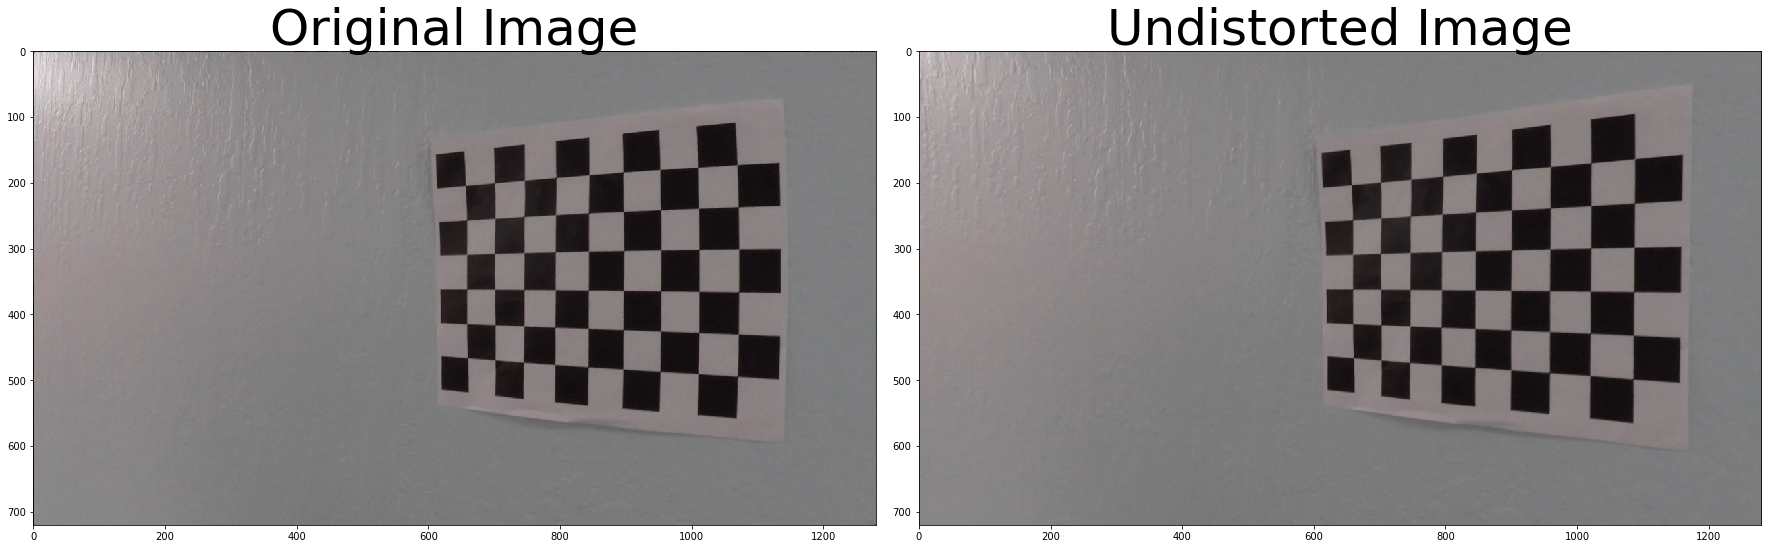

In [4]:
testimg_calibration(mtx, dist)


## 3 Apply a perspective transform to rectify binary image ("birds-eye view").
find a proper image to do the perspective transform


In [5]:
import os
%matplotlib inline
def get_perspective_transform_mtx():
    pers_img = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    print(pers_img)
    img = cv2.imread(pers_img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    src = np.float32([[603, 444], [675, 444], [1050, 688], [253, 688]])
    dst = np.float32([[250, 0], [1050, 0], [1050, 700], [250, 700]])
    '''
          1   2
           ---
          /   \
         /     \
        /       \
        ---------
       4         3 
    '''
    plt.plot(*src[0], '.', color = 'r')
    plt.plot(*src[1], '.', color = 'r')
    plt.plot(*src[2], '.', color = 'r')
    plt.plot(*src[3], '.', color = 'r')
    plt.plot(*dst[0], 'x', color = 'y')
    plt.plot(*dst[1], 'x', color = 'y')
    plt.plot(*dst[2], 'x', color = 'y')
    plt.plot(*dst[3], 'x', color = 'y')

    # computer the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv


..\test_images\straight_lines1.jpg


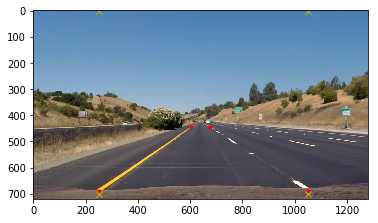

In [6]:
M, Minv = get_perspective_transform_mtx()

In [7]:
def testimg_perspective_transform(m):
    # do transformation on the test image
    # check the final warped image after perspective transformation
    imgname = os.path.join('..', 'test_images', 'straight_lines1.jpg')
    img = cv2.imread(imgname)    
    img_size = img.shape[1], img.shape[0]
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

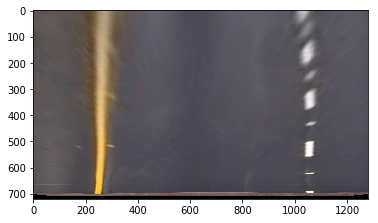

In [8]:
testimg_perspective_transform(M)   

## 4. Use color transforms, gradients, etc., to create a thresholded binary image.
define a function called bin img selection

In [9]:
from cv2 import Sobel

def build_binary_img(img, rawtype = 'bgr', orient = 'x', sobeltype = 's', s_thresh = (170, 255), sobel_thresh = (20, 100)):
    if rawtype == 'rgb': # cv2.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif rawtype == 'bgr': # matplotlib.image.imread()
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else:  # gray
        assert 0

    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    channel = gray
    sobelx = Sobel(channel, cv2.CV_64F, 1, 0)
    sobelx = np.absolute(sobelx)
    sobelx = np.uint8(255*sobelx/np.max(sobelx))
    
    sobely = Sobel(channel, cv2.CV_64F, 0, 1)
    sobely = np.absolute(sobely)
    sobely = np.uint8(255*sobely/np.max(sobely))

    # sobel_thresh = (20, 100)
    sobel_bin = np.zeros_like(sobelx)
    if orient == 'x':
        sobel_bin[(sobelx >= sobel_thresh[0]) & (sobelx <= sobel_thresh[1])] = 1
    else:
        sobel_bin[(sobely >= sobel_thresh[0]) & (sobely <= sobel_thresh[1])] = 1
        
    channel = S
    color_bin = np.zeros_like(channel)
    if orient == 'x':
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    else:
        color_bin[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1

    combined_bin = np.zeros_like(gray)
    combined_bin[(color_bin == 1) | (sobel_bin == 1)] = 1

#     sobel_bin = np.dstack(sobel_bin*3) *255
#     color_bin = np.dstack(color_bin*3) *255
#     combined_bin = np.dstack(combined_bin*3) *255
    
    return sobel_bin*255, color_bin*255, combined_bin*255

In [10]:
def testimg_build_binary():
    # test the function build_binary_image()
    images = glob.glob('../test_images/*.jpg')
    testidx = np.random.randint(0, len(images))
    print('testing the binary img build function on test image ', images[testidx])
    img = cv2.imread(images[testidx])

    img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

    img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )

    f, ax = plt.subplots(2, 3, figsize=(48, 18))
    f.tight_layout()
    ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[0][0].set_title('Original Image', fontsize=32)
    
    ax[0][1].imshow(cv2.cvtColor(img0, cv2.COLOR_BGR2RGB))
    ax[0][1].set_title('perspective transformed img', fontsize=32)
    
    ax[0][2].imshow(img1, cmap = 'gray')
    ax[0][2].set_title('gray sobel x Image', fontsize=32)

    ax[1][0].imshow(img2, cmap = 'gray')
    ax[1][0].set_title('s color channel Image', fontsize=32)

    ax[1][1].imshow(img3, cmap = 'gray')
    ax[1][1].set_title('combin bin Image', fontsize=32)

    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0, wspace=None, hspace=0.4)
    
    # img, img0 are color imgs
    # img1, img2, img3 are gray imgs
    return img, img0, img1, img2, img3

testing the binary img build function on test image  ../test_images\straight_lines2.jpg


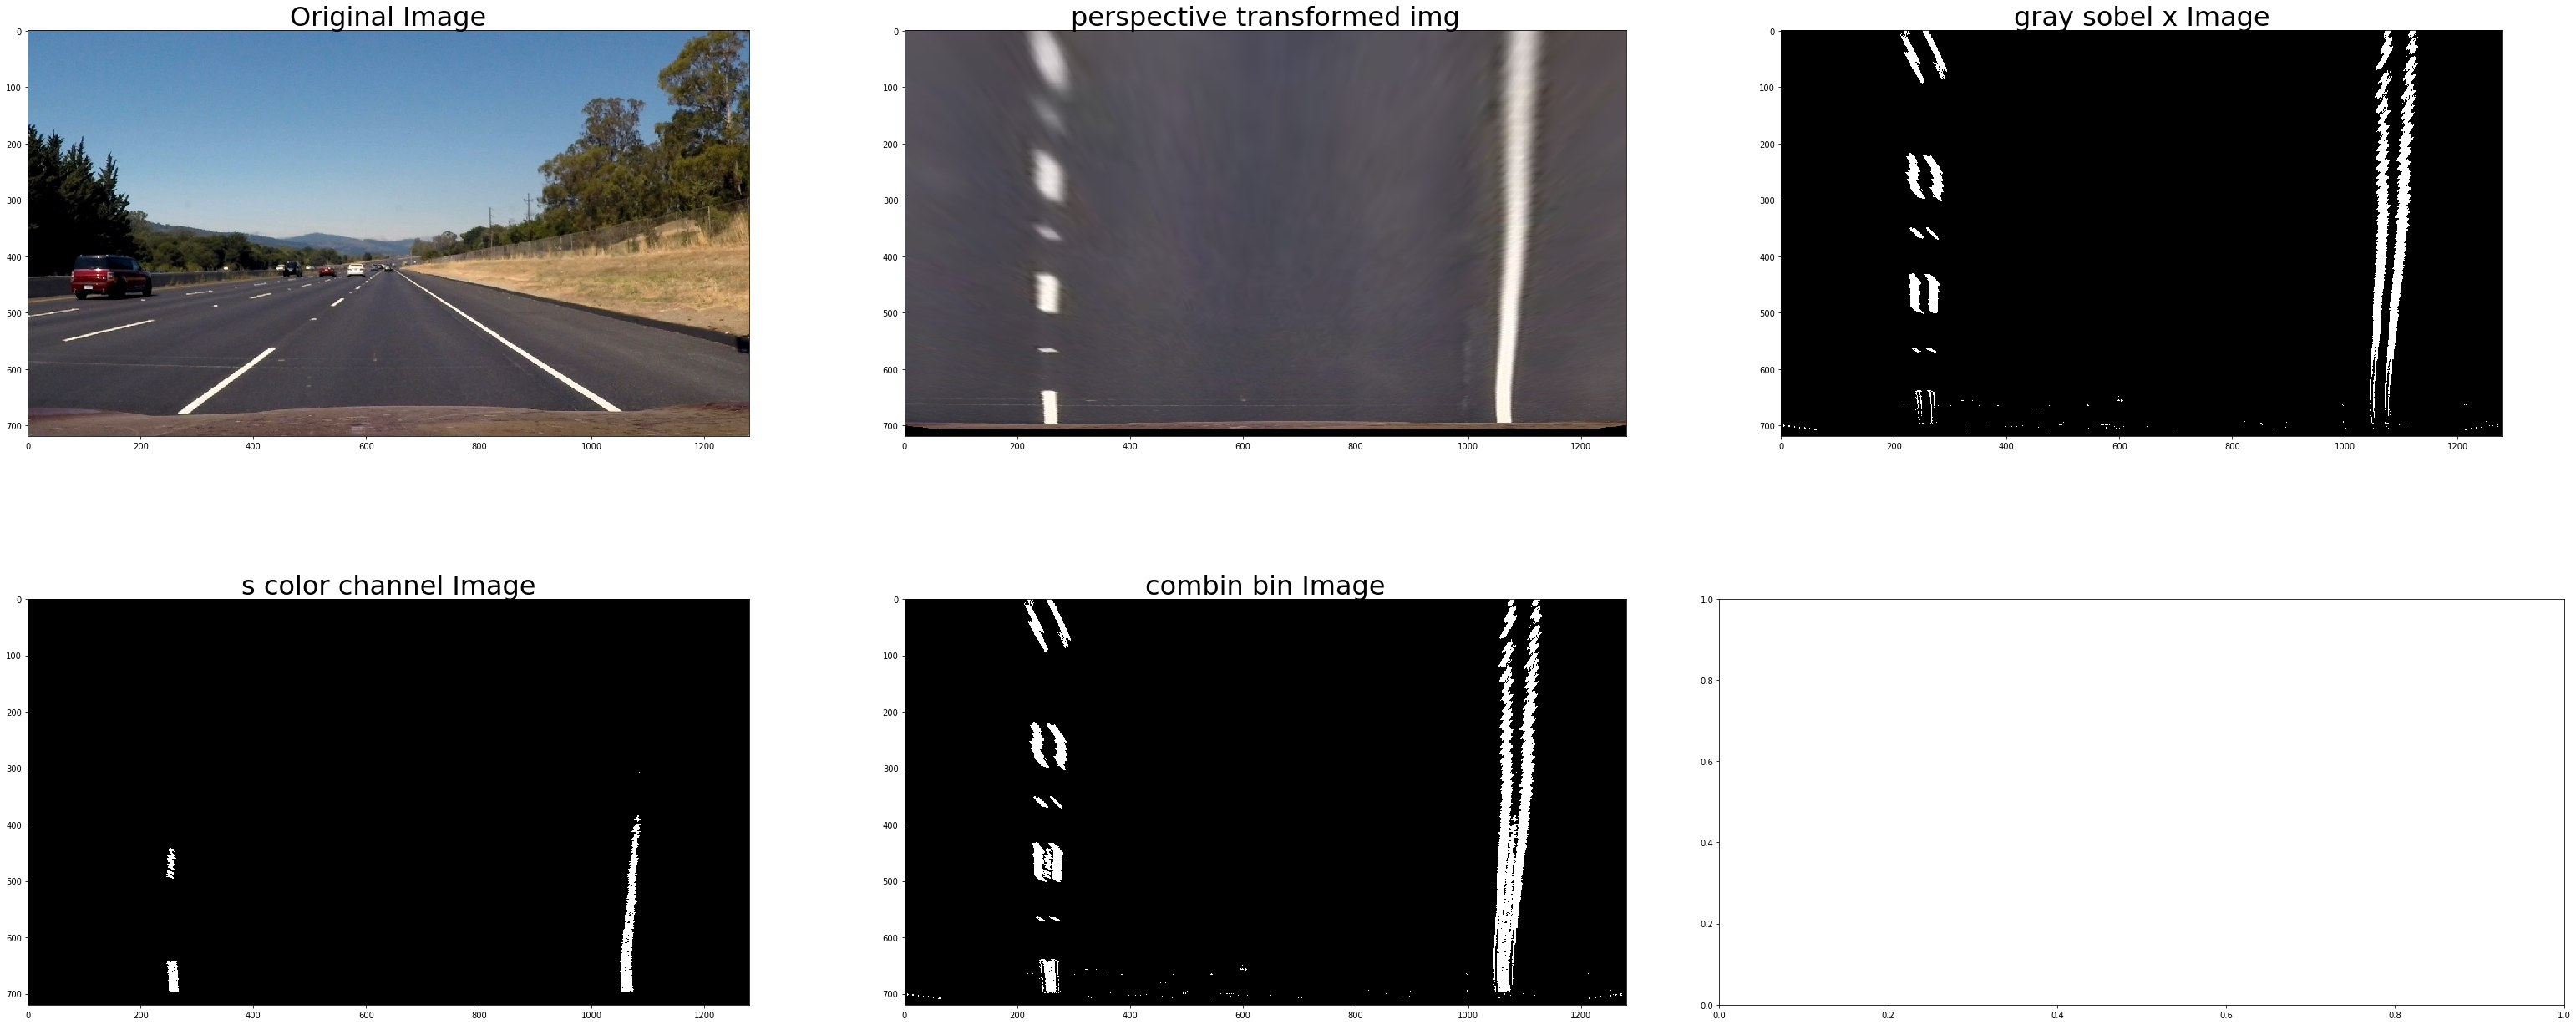

In [11]:
rawimg, img0, img1, img2, img3 = testimg_build_binary()

### 5. Detect lane pixels and fit to find the lane boundary.

In [12]:

def get_histogram(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # as in the persepctive transformation, we have already changed the bottom half to the whole image,
    # then no need to only use the bottom half, just use the whole half
    histogram = np.sum(img[:,:], axis=0)
    out_img = np.dstack((img, img, img))
#     plt.imshow(out_img)
#     plt.show()
#     plt.plot(histogram)
#     plt.show()    
    return histogram

In [13]:
# img is the raw color img,
# img0 is the perspectived img
# img1 is the sobel x binary img
# img2 is the color threshold img
# img3 is the combination of img2 and img3

histogram = get_histogram(img3)

Sliding Window

In [58]:
# we use a class to collect all the variables together in a scope

# use it as global as it not changed [y_pixdels, x_pixels]
imgsize = img3.shape


class LaneLineHandler(object):
    def __init__(self):
        self.nwindows = 9
        self.window_height = np.int(imgsize[0]/self.nwindows)
        self.margin = 100
        self.minpix = 50
        self.left_lane_inds = []
        self.right_lane_inds = []
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700
        
        
    def readin(self, img):
        # readin the raw color image taken from the camera
        
        self.raw = img
        img0 = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        img1, img2, img3 = build_binary_img(img0, rawtype = 'rgb' )
        
        self.histogram = get_histogram(img3)
        # print(self.histogram.shape)
        self.midpoint = np.int(self.histogram.shape[0]/2)
        self.leftx_base = np.argmax(self.histogram[:self.midpoint])
        self.rightx_base = np.argmax(self.histogram[self.midpoint:]) + self.midpoint
        # print('left base is: ', self.leftx_base, ' right base is: ', self.rightx_base)

        # out_color is color image
        self.out_color = np.dstack((img3, img3, img3))
        
        self.nonzero = self.out_color.nonzero()
        self.nonzerox = np.array(self.nonzero[1])
        self.nonzeroy = np.array(self.nonzero[0])
        # print('non zero points in x: ', len(self.nonzerox))
        self.leftx_current = self.leftx_base
        self.rightx_current = self.rightx_base
    
    def showOutImg(self):
        plt.imshow(self.out_color)
        
    def slidingWindow(self, plotRectangle = True):
        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = self.out_color.shape[0] - (window+1)*self.window_height
            win_y_high = self.out_color.shape[0] - window*self.window_height
            win_xleft_low = self.leftx_current - self.margin
            win_xleft_high = self.leftx_current + self.margin
            win_xright_low = self.rightx_current - self.margin
            win_xright_high = self.rightx_current + self.margin
            # Draw the windows on the visualization image
            if plotRectangle:
                cv2.rectangle(self.out_color,
                              (win_xleft_low, win_y_low), (win_xleft_high,win_y_high),
                              (0,255,0), 3) 
                # print('build a rectangle : (', win_xleft_low, win_y_low, '), (', win_xleft_high, win_y_high,')')
                cv2.rectangle(self.out_color,
                              (win_xright_low,win_y_low),(win_xright_high,win_y_high), 
                              (0,255,0), 3) 
            # print('build a rectangle : (', win_xright_low, win_y_low, '), (', win_xright_high, win_y_high,')')
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                              (self.nonzerox >= win_xleft_low) &  (self.nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((self.nonzeroy >= win_y_low) & (self.nonzeroy < win_y_high) & 
                               (self.nonzerox >= win_xright_low) &  (self.nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            # print(good_left_inds.shape, good_right_inds.shape)
            self.left_lane_inds.append(good_left_inds)
            self.right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            # print('len good_left_inds is: ', len(good_left_inds))
            if len(good_left_inds) > self.minpix:
                self.leftx_current = np.int(np.mean(self.nonzerox[good_left_inds]))
            # print('len good_right_inds is: ', len(good_right_inds))
            if len(good_right_inds) > self.minpix:
                self.rightx_current = np.int(np.mean(self.nonzerox[good_right_inds]))
            
            # mark left lane pixels as red, right lane [ixels as blue]
    def markLanepixelColor(self):
        self.left_lane_inds = np.concatenate(self.left_lane_inds)
        self.right_lane_inds = np.concatenate(self.right_lane_inds)

        self.out_color[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        self.out_color[self.nonzeroy[self.right_lane_inds],self.nonzerox[self.right_lane_inds]] = [0, 0, 255]
    
    def fitting(self):
        # Extract left and right line pixel positions
        leftx = self.nonzerox[self.left_lane_inds]
        lefty = self.nonzeroy[self.left_lane_inds] 
        rightx = self.nonzerox[self.right_lane_inds]
        righty = self.nonzeroy[self.right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        self.left_fit_meter = np.polyfit(lefty * self.ym_per_pix, leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(righty * self.ym_per_pix, rightx * self.xm_per_pix, 2)
        
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
    def showFitting(self):
        # Generate x and y values for plotting
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        plt.imshow(self.out_color)
        plt.plot(self.left_fitx, ploty, color='yellow')
        plt.plot(self.right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
        
    def nextFitting(self, newimg):
        # quick find the fitting of the new image based on the new image
        nonzero = newimg.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # margin = 100
        left_lane_inds = (
            (nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - self.margin)) &
            (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + self.margin))) 

        right_lane_inds = (
            (nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - self.margin)) & 
            (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + self.margin)))  

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
    
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.left_fit_meter = np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2)
        self.right_fit_meter = np.polyfit(self.righty * self.ym_perpix, slef.rightx * self.xm_per_pix, 2)
        # Generate x and y values for plotting
        # ploty = np.linspace(0, img3.shape[0]-1, img3.shape[0] )
        self.left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
    
    # after a new raw file read in, do the fitting based on the new image
    def showFitting2(self):
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((self.raw , self.raw, self.raw))
        
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[self.nonzeroy[self.left_lane_inds], self.nonzerox[self.left_lane_inds]] = [255, 0, 0]
        out_img[self.nonzeroy[self.right_lane_inds], self.nonzerox[self.right_lane_inds]] = [0, 0, 255]

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]
        
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - self.margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + self.margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - self.margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + self.margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    
    def calcCurvature(self):
        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )

        y_eval = np.max(ploty)
        # calc the curvature at the bottom,e.g., close to the car
        # x = a*y^2 + b*y + c 
        # R_curve = [1 + (2a+b)^2]^(3/2)/ |2a|

        self.left_curverad = ((1 + (2*self.left_fit[0]*y_eval + self.left_fit[1])**2)**1.5) / np.absolute(2*self.left_fit[0])
        self.right_curverad = ((1 + (2*self.right_fit[0]*y_eval + self.right_fit[1])**2)**1.5) / np.absolute(2*self.right_fit[0])

        y_eval = y_eval * self.ym_per_pix
        self.left_curverad_meter =((1 + (2*self.left_fit_meter[0]* y_eval + self.left_fit_meter[1])**2)**1.5) / np.absolute(2*self.left_fit_meter[0])
        self.right_curverad_meter = ((1 + (2*self.right_fit_meter[0] * y_eval + self.right_fit_meter[1])**2)**1.5) / np.absolute(2*self.right_fit_meter[0])
        print('left curvature is: ', self.left_curverad, ' pixels, e.g, ', self.left_curverad_meter, ' meters')
        print('right curvature is: ', self.right_curverad, ' pixels, e.g, ', self.right_curverad_meter, ' meters')
    
    def drawBack(self):
        # Create an image to draw the lines on
        color_warp = np.zeros_like(self.raw).astype(np.uint8)
        # color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, imgsize[0]-1, imgsize[0] )
            
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([self.left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([self.right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (imgsize[1], imgsize[0])) 
        
        # Combine the result with the original image
        result = cv2.addWeighted(self.raw, 1, newwarp, 0.3, 0)
        plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
        
        # write the curvature and position information
        font = cv2.FONT_HERSHEY_SIMPLEX
        text = 'Radius of Curvature = (m)'        
        cv2.putText(result, text, (200,100), font, 2, (255,255,255),2, cv2.LINE_AA)
        text = 'Vehicle is m left of center'        
        cv2.putText(result, text, (200,200), font, 2, (255,255,255),2, cv2.LINE_AA)
        
        return result
    
    def run(self, img):
        self.readin(img)
        self.slidingWindow(plotRectangle = False)
        self.markLanepixelColor()
        self.fitting()
        self.calcCurvature()
        result = self.drawBack()
        return result

left curvature is:  572704.226627  pixels, e.g,  188084.887528  meters
right curvature is:  9684.05735403  pixels, e.g,  3140.97076687  meters


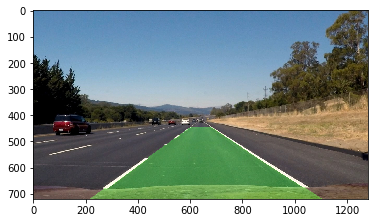

In [59]:
handler = LaneLineHandler()
result = handler.run(rawimg)

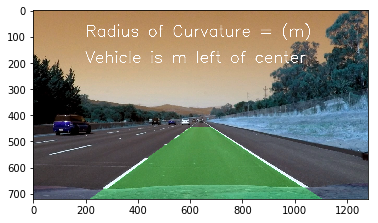

In [60]:
plt.imshow(result)

In [40]:
handler2 = LaneLineHandler()
handler2.readin(rawimg)

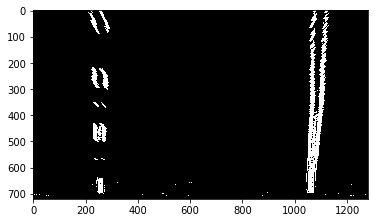

In [30]:
handler2.showOutImg()

In [31]:
handler2.slidingWindow()

In [32]:
handler2.markLanepixelColor()

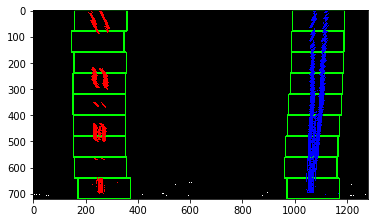

In [33]:
handler2.showOutImg()

In [34]:
handler2.fitting()

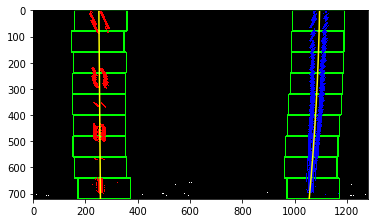

In [35]:
handler2.showFitting()

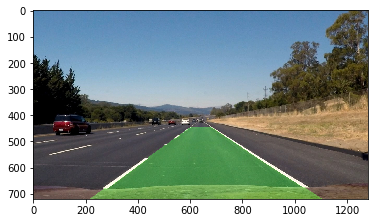

In [36]:
result2 = handler2.drawBack()

### 7. Warp the detected lane boundaries back onto the original image.

In [24]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 9. final pipe line function

In [30]:
# function for video handling
def process_image(img):
    handler = LaneLineHandler()
    result = handler.run(img)
    return result

left curvature is:  492.074513547  pixels, e.g,  152.684656868  meters
right curvature is:  549.038073786  pixels, e.g,  172.16909536  meters
left curvature is:  663.696199185  pixels, e.g,  217.731371199  meters
right curvature is:  730.02274125  pixels, e.g,  114.886374031  meters
left curvature is:  1233.61413088  pixels, e.g,  370.2503683  meters
right curvature is:  780.04157085  pixels, e.g,  250.41977607  meters
left curvature is:  811.71753774  pixels, e.g,  259.969449166  meters
right curvature is:  434.053312168  pixels, e.g,  96.0653848763  meters
left curvature is:  483.218747043  pixels, e.g,  143.685147581  meters
right curvature is:  478.274808942  pixels, e.g,  142.919714086  meters
left curvature is:  1156.73157604  pixels, e.g,  340.428038183  meters
right curvature is:  561.34014453  pixels, e.g,  183.990679692  meters


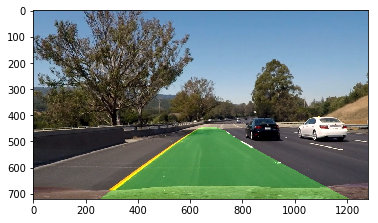

In [31]:
imgnames = glob.glob('../test_images/test*.jpg')
for imgname in imgnames:
    dirname, filename = os.path.split(imgname)
    newimgname = os.path.join('../output_images', filename)
    img = cv2.imread(imgname)
    result = process_image(img)
    # plt.imshow(result)
    cv2.imwrite(newimgname, result)             

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters
[MoviePy] >>>> Building video ../project_solution.mp4
[MoviePy] Writing video ../project_solution.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

left curvature is:  670.294186068  pixels, e.g,  220.151256973  meters
right curvature is:  805.843060784  pixels, e.g,  262.927406647  meters


  0%|                                                                                 | 1/1261 [00:00<07:05,  2.96it/s]

left curvature is:  658.881413406  pixels, e.g,  216.408698922  meters
right curvature is:  932.047175762  pixels, e.g,  297.279403518  meters


  0%|▏                                                                                | 2/1261 [00:00<06:34,  3.19it/s]

left curvature is:  663.393007811  pixels, e.g,  217.864776533  meters
right curvature is:  692.989376962  pixels, e.g,  226.218968609  meters


  0%|▏                                                                                | 3/1261 [00:00<06:09,  3.41it/s]

left curvature is:  635.708728019  pixels, e.g,  208.80064373  meters
right curvature is:  759.433019142  pixels, e.g,  243.983795152  meters


  0%|▎                                                                                | 4/1261 [00:01<05:47,  3.62it/s]

left curvature is:  659.36017742  pixels, e.g,  216.362786164  meters
right curvature is:  481.107778576  pixels, e.g,  149.158469261  meters


  0%|▎                                                                                | 5/1261 [00:01<05:31,  3.78it/s]

left curvature is:  684.280779221  pixels, e.g,  224.061276091  meters
right curvature is:  821.975440778  pixels, e.g,  259.924195802  meters


  0%|▍                                                                                | 6/1261 [00:01<05:26,  3.84it/s]

left curvature is:  725.339381345  pixels, e.g,  236.351502319  meters
right curvature is:  785.460860146  pixels, e.g,  250.199875716  meters


  1%|▍                                                                                | 7/1261 [00:01<05:18,  3.94it/s]

left curvature is:  716.821278552  pixels, e.g,  233.269619576  meters
right curvature is:  845.396413774  pixels, e.g,  265.407158583  meters


  1%|▌                                                                                | 8/1261 [00:02<05:35,  3.73it/s]

left curvature is:  758.382221701  pixels, e.g,  245.289293052  meters
right curvature is:  815.104520316  pixels, e.g,  257.826440211  meters


  1%|▌                                                                                | 9/1261 [00:02<05:31,  3.77it/s]

left curvature is:  783.258902565  pixels, e.g,  251.910041913  meters
right curvature is:  701.449461534  pixels, e.g,  227.635466267  meters


  1%|▋                                                                               | 10/1261 [00:02<05:27,  3.82it/s]

left curvature is:  762.522483518  pixels, e.g,  245.702971562  meters
right curvature is:  718.5336253  pixels, e.g,  231.147715639  meters


  1%|▋                                                                               | 11/1261 [00:02<05:19,  3.91it/s]

left curvature is:  892.878285316  pixels, e.g,  281.23872582  meters
right curvature is:  1067.55444029  pixels, e.g,  331.41801448  meters


  1%|▊                                                                               | 12/1261 [00:03<05:12,  4.00it/s]

left curvature is:  858.533708382  pixels, e.g,  271.811713547  meters
right curvature is:  718.651731995  pixels, e.g,  233.62506956  meters


  1%|▊                                                                               | 13/1261 [00:03<05:11,  4.01it/s]

left curvature is:  814.135664531  pixels, e.g,  259.573939404  meters
right curvature is:  745.217874063  pixels, e.g,  241.292488536  meters


  1%|▉                                                                               | 14/1261 [00:03<05:09,  4.03it/s]

left curvature is:  734.375443986  pixels, e.g,  237.057396597  meters
right curvature is:  1017.72908129  pixels, e.g,  305.245957078  meters


  1%|▉                                                                               | 15/1261 [00:03<05:03,  4.10it/s]

left curvature is:  690.137558639  pixels, e.g,  224.187297398  meters
right curvature is:  923.93503233  pixels, e.g,  275.799872561  meters


  1%|█                                                                               | 16/1261 [00:04<04:59,  4.16it/s]

left curvature is:  663.079832686  pixels, e.g,  216.057057885  meters
right curvature is:  899.834435176  pixels, e.g,  271.479872428  meters


  1%|█                                                                               | 17/1261 [00:04<04:59,  4.16it/s]

left curvature is:  653.755911267  pixels, e.g,  213.19314657  meters
right curvature is:  987.080728495  pixels, e.g,  291.454822778  meters


  1%|█▏                                                                              | 18/1261 [00:04<04:55,  4.21it/s]

left curvature is:  687.178513576  pixels, e.g,  223.048493766  meters
right curvature is:  964.884512396  pixels, e.g,  289.299556273  meters


  2%|█▏                                                                              | 19/1261 [00:04<04:55,  4.21it/s]

left curvature is:  735.22346435  pixels, e.g,  236.894367463  meters
right curvature is:  848.7373355  pixels, e.g,  263.64190237  meters


  2%|█▎                                                                              | 20/1261 [00:04<04:50,  4.27it/s]

left curvature is:  795.033837713  pixels, e.g,  253.841636984  meters
right curvature is:  635.548359269  pixels, e.g,  207.117113406  meters


  2%|█▎                                                                              | 21/1261 [00:05<05:14,  3.94it/s]

left curvature is:  799.826037504  pixels, e.g,  255.002426792  meters
right curvature is:  645.381617366  pixels, e.g,  211.263097667  meters


  2%|█▍                                                                              | 22/1261 [00:05<05:10,  3.99it/s]

left curvature is:  798.583665451  pixels, e.g,  255.373203672  meters
right curvature is:  684.859978212  pixels, e.g,  224.196937246  meters


  2%|█▍                                                                              | 23/1261 [00:05<05:13,  3.95it/s]

left curvature is:  712.160034948  pixels, e.g,  231.121195065  meters
right curvature is:  770.263823824  pixels, e.g,  248.510002739  meters


  2%|█▌                                                                              | 24/1261 [00:06<05:21,  3.85it/s]

left curvature is:  669.492864447  pixels, e.g,  218.589191228  meters
right curvature is:  696.4169718  pixels, e.g,  226.035320416  meters


  2%|█▌                                                                              | 25/1261 [00:06<05:12,  3.95it/s]

left curvature is:  670.138645522  pixels, e.g,  219.076021223  meters
right curvature is:  689.453972195  pixels, e.g,  225.244404837  meters


  2%|█▋                                                                              | 26/1261 [00:06<05:19,  3.87it/s]

left curvature is:  648.508376209  pixels, e.g,  212.468607803  meters
right curvature is:  663.071028526  pixels, e.g,  216.925211806  meters


  2%|█▋                                                                              | 27/1261 [00:06<05:12,  3.94it/s]

left curvature is:  664.507742302  pixels, e.g,  217.5012878  meters
right curvature is:  687.912623886  pixels, e.g,  225.63443173  meters


  2%|█▊                                                                              | 28/1261 [00:07<05:07,  4.01it/s]

left curvature is:  629.523646968  pixels, e.g,  206.56740834  meters
right curvature is:  706.201118864  pixels, e.g,  230.567657957  meters


  2%|█▊                                                                              | 29/1261 [00:07<04:59,  4.12it/s]

left curvature is:  562.401959336  pixels, e.g,  184.553014142  meters
right curvature is:  676.491783248  pixels, e.g,  220.236002213  meters


  2%|█▉                                                                              | 30/1261 [00:07<04:56,  4.15it/s]

left curvature is:  518.21766943  pixels, e.g,  169.22735636  meters
right curvature is:  636.209355423  pixels, e.g,  206.724142013  meters


  2%|█▉                                                                              | 31/1261 [00:07<04:49,  4.25it/s]

left curvature is:  480.870085661  pixels, e.g,  155.253803498  meters
right curvature is:  574.601102158  pixels, e.g,  186.238112874  meters


  3%|██                                                                              | 32/1261 [00:08<05:01,  4.08it/s]

left curvature is:  504.61850319  pixels, e.g,  164.284085758  meters
right curvature is:  481.929022813  pixels, e.g,  94.9792973267  meters


  3%|██                                                                              | 33/1261 [00:08<05:09,  3.96it/s]

left curvature is:  490.124319327  pixels, e.g,  159.144310622  meters
right curvature is:  432.409327402  pixels, e.g,  135.160862702  meters


  3%|██▏                                                                             | 34/1261 [00:08<05:23,  3.79it/s]

left curvature is:  484.830749542  pixels, e.g,  157.580193702  meters
right curvature is:  438.218226511  pixels, e.g,  137.689092366  meters


  3%|██▏                                                                             | 35/1261 [00:08<05:21,  3.82it/s]

left curvature is:  475.584323699  pixels, e.g,  154.419154303  meters
right curvature is:  441.02046703  pixels, e.g,  142.413929765  meters


  3%|██▎                                                                             | 36/1261 [00:09<05:22,  3.80it/s]

left curvature is:  465.385157339  pixels, e.g,  150.67661497  meters
right curvature is:  490.548187145  pixels, e.g,  160.654375866  meters


  3%|██▎                                                                             | 37/1261 [00:09<05:10,  3.95it/s]

left curvature is:  458.183367621  pixels, e.g,  148.383990171  meters
right curvature is:  461.101952449  pixels, e.g,  151.413379259  meters


  3%|██▍                                                                             | 38/1261 [00:09<05:10,  3.94it/s]

left curvature is:  448.648790672  pixels, e.g,  144.898986561  meters
right curvature is:  648.756803944  pixels, e.g,  84.4345640735  meters


  3%|██▍                                                                             | 39/1261 [00:09<04:55,  4.14it/s]

left curvature is:  449.027370414  pixels, e.g,  145.564743848  meters
right curvature is:  511.664481705  pixels, e.g,  166.073764778  meters


  3%|██▌                                                                             | 40/1261 [00:10<05:17,  3.85it/s]

left curvature is:  447.037552876  pixels, e.g,  145.190853541  meters
right curvature is:  575.169495492  pixels, e.g,  182.940317224  meters


  3%|██▌                                                                             | 41/1261 [00:10<05:02,  4.03it/s]

left curvature is:  451.372046432  pixels, e.g,  147.143967664  meters
right curvature is:  561.886944058  pixels, e.g,  179.028442149  meters


  3%|██▋                                                                             | 42/1261 [00:10<05:01,  4.04it/s]

left curvature is:  476.278972295  pixels, e.g,  156.293161479  meters
right curvature is:  572.970395457  pixels, e.g,  183.491305459  meters


  3%|██▋                                                                             | 43/1261 [00:10<05:06,  3.98it/s]

left curvature is:  512.990026302  pixels, e.g,  168.435310904  meters
right curvature is:  577.50118752  pixels, e.g,  186.074804451  meters


  3%|██▊                                                                             | 44/1261 [00:11<05:01,  4.04it/s]

left curvature is:  544.615709088  pixels, e.g,  178.240277336  meters
right curvature is:  527.064588842  pixels, e.g,  171.768773684  meters


  4%|██▊                                                                             | 45/1261 [00:11<04:54,  4.13it/s]

left curvature is:  619.8856272  pixels, e.g,  200.537160102  meters
right curvature is:  844.408489126  pixels, e.g,  84.4258009499  meters


  4%|██▉                                                                             | 46/1261 [00:11<04:46,  4.25it/s]

left curvature is:  660.121672381  pixels, e.g,  211.80929841  meters
right curvature is:  694.564740164  pixels, e.g,  131.132046315  meters


  4%|██▉                                                                             | 47/1261 [00:11<04:40,  4.34it/s]

left curvature is:  694.453682545  pixels, e.g,  221.034750729  meters
right curvature is:  583.210604937  pixels, e.g,  188.150601547  meters


  4%|███                                                                             | 48/1261 [00:11<04:38,  4.36it/s]

left curvature is:  774.042414636  pixels, e.g,  242.198034186  meters
right curvature is:  595.167870926  pixels, e.g,  193.034397568  meters


  4%|███                                                                             | 49/1261 [00:12<04:39,  4.33it/s]

left curvature is:  779.271217807  pixels, e.g,  243.358791555  meters
right curvature is:  701.445989866  pixels, e.g,  97.7476427745  meters


  4%|███▏                                                                            | 50/1261 [00:12<04:38,  4.35it/s]

left curvature is:  813.042154357  pixels, e.g,  252.850774571  meters
right curvature is:  744.011681236  pixels, e.g,  73.7281481652  meters


  4%|███▏                                                                            | 51/1261 [00:12<04:37,  4.35it/s]

left curvature is:  780.720730463  pixels, e.g,  244.977439025  meters
right curvature is:  618.00307791  pixels, e.g,  87.4859242777  meters


  4%|███▎                                                                            | 52/1261 [00:12<04:36,  4.37it/s]

left curvature is:  734.040866608  pixels, e.g,  232.517478646  meters
right curvature is:  1299.16831925  pixels, e.g,  80.8584808385  meters


  4%|███▎                                                                            | 53/1261 [00:13<04:48,  4.19it/s]

left curvature is:  741.425216764  pixels, e.g,  234.695793598  meters
right curvature is:  654.944521433  pixels, e.g,  204.192912506  meters


  4%|███▍                                                                            | 54/1261 [00:13<04:45,  4.23it/s]

left curvature is:  763.414727894  pixels, e.g,  240.866422883  meters
right curvature is:  609.009793486  pixels, e.g,  192.871053658  meters


  4%|███▍                                                                            | 55/1261 [00:13<04:43,  4.26it/s]

left curvature is:  785.281387294  pixels, e.g,  247.079677834  meters
right curvature is:  679.07364561  pixels, e.g,  213.500842444  meters


  4%|███▌                                                                            | 56/1261 [00:13<04:44,  4.24it/s]

left curvature is:  779.993671174  pixels, e.g,  246.130773236  meters
right curvature is:  618.790592737  pixels, e.g,  195.618629377  meters


  5%|███▌                                                                            | 57/1261 [00:14<04:40,  4.30it/s]

left curvature is:  788.841692028  pixels, e.g,  249.066598995  meters
right curvature is:  652.182356378  pixels, e.g,  205.75549621  meters


  5%|███▋                                                                            | 58/1261 [00:14<04:35,  4.36it/s]

left curvature is:  774.038679505  pixels, e.g,  246.306022039  meters
right curvature is:  674.578417369  pixels, e.g,  210.500619197  meters


  5%|███▋                                                                            | 59/1261 [00:14<04:36,  4.35it/s]

left curvature is:  744.749168446  pixels, e.g,  239.142859639  meters
right curvature is:  744.727080737  pixels, e.g,  89.2080046804  meters


  5%|███▊                                                                            | 60/1261 [00:14<04:35,  4.36it/s]

left curvature is:  683.174805877  pixels, e.g,  221.937205257  meters
right curvature is:  613.566766536  pixels, e.g,  192.592216405  meters


  5%|███▊                                                                            | 61/1261 [00:14<04:36,  4.34it/s]

left curvature is:  664.458679757  pixels, e.g,  216.848876139  meters
right curvature is:  838.296981475  pixels, e.g,  243.815065098  meters


  5%|███▉                                                                            | 62/1261 [00:15<04:34,  4.38it/s]

left curvature is:  664.769402248  pixels, e.g,  217.111905341  meters
right curvature is:  786.713538175  pixels, e.g,  234.793586311  meters


  5%|███▉                                                                            | 63/1261 [00:15<04:34,  4.36it/s]

left curvature is:  623.702445757  pixels, e.g,  204.635009649  meters
right curvature is:  500.286525312  pixels, e.g,  162.791001765  meters


  5%|████                                                                            | 64/1261 [00:15<04:35,  4.34it/s]

left curvature is:  681.793552196  pixels, e.g,  222.950042577  meters
right curvature is:  853.359557868  pixels, e.g,  253.155472609  meters


  5%|████                                                                            | 65/1261 [00:15<04:35,  4.34it/s]

left curvature is:  648.612671857  pixels, e.g,  212.78840261  meters
right curvature is:  943.815170851  pixels, e.g,  274.755480232  meters


  5%|████▏                                                                           | 66/1261 [00:16<04:33,  4.38it/s]

left curvature is:  652.329435194  pixels, e.g,  214.047823363  meters
right curvature is:  1003.69459537  pixels, e.g,  293.26804847  meters


  5%|████▎                                                                           | 67/1261 [00:16<04:31,  4.40it/s]

left curvature is:  655.361739799  pixels, e.g,  214.960201281  meters
right curvature is:  960.665038771  pixels, e.g,  285.042203988  meters


  5%|████▎                                                                           | 68/1261 [00:16<04:30,  4.41it/s]

left curvature is:  621.787776025  pixels, e.g,  204.215397354  meters
right curvature is:  824.671174781  pixels, e.g,  246.78343236  meters


  5%|████▍                                                                           | 69/1261 [00:16<04:27,  4.46it/s]

left curvature is:  654.083738439  pixels, e.g,  214.606740945  meters
right curvature is:  846.699906205  pixels, e.g,  260.278879783  meters


  6%|████▍                                                                           | 70/1261 [00:17<04:27,  4.45it/s]

left curvature is:  758.602961833  pixels, e.g,  247.337569015  meters
right curvature is:  469.771316187  pixels, e.g,  154.145714832  meters


  6%|████▌                                                                           | 71/1261 [00:17<04:30,  4.41it/s]

left curvature is:  783.254528842  pixels, e.g,  254.78973574  meters
right curvature is:  736.854020898  pixels, e.g,  87.9460593943  meters


  6%|████▌                                                                           | 72/1261 [00:17<04:36,  4.29it/s]

left curvature is:  803.444637259  pixels, e.g,  260.827187643  meters
right curvature is:  463.689988131  pixels, e.g,  151.843323751  meters


  6%|████▋                                                                           | 73/1261 [00:17<04:53,  4.05it/s]

left curvature is:  810.350512827  pixels, e.g,  263.032478066  meters
right curvature is:  538.244632203  pixels, e.g,  176.513171427  meters


  6%|████▋                                                                           | 74/1261 [00:18<05:02,  3.93it/s]

left curvature is:  870.637433499  pixels, e.g,  280.812449645  meters
right curvature is:  566.122217485  pixels, e.g,  185.683446379  meters


  6%|████▊                                                                           | 75/1261 [00:18<04:59,  3.95it/s]

left curvature is:  821.855613881  pixels, e.g,  266.906305535  meters
right curvature is:  582.173603166  pixels, e.g,  95.9905071988  meters


  6%|████▊                                                                           | 76/1261 [00:18<04:51,  4.06it/s]

left curvature is:  931.069033809  pixels, e.g,  299.071305256  meters
right curvature is:  589.511101665  pixels, e.g,  193.322491197  meters


  6%|████▉                                                                           | 77/1261 [00:18<04:50,  4.08it/s]

left curvature is:  954.292525289  pixels, e.g,  305.856607721  meters
right curvature is:  597.8273532  pixels, e.g,  196.131908709  meters


  6%|████▉                                                                           | 78/1261 [00:19<04:46,  4.13it/s]

left curvature is:  944.732121034  pixels, e.g,  303.406228498  meters
right curvature is:  625.127707213  pixels, e.g,  205.017318368  meters


  6%|█████                                                                           | 79/1261 [00:19<04:45,  4.14it/s]

left curvature is:  893.158525399  pixels, e.g,  288.639833954  meters
right curvature is:  634.271091607  pixels, e.g,  207.783001441  meters


  6%|█████                                                                           | 80/1261 [00:19<04:46,  4.13it/s]

left curvature is:  860.683992573  pixels, e.g,  279.741702233  meters
right curvature is:  589.032542128  pixels, e.g,  193.16545087  meters


  6%|█████▏                                                                          | 81/1261 [00:19<04:42,  4.18it/s]

left curvature is:  842.636229288  pixels, e.g,  274.421426279  meters
right curvature is:  608.956348621  pixels, e.g,  199.629772607  meters


  7%|█████▏                                                                          | 82/1261 [00:19<04:40,  4.20it/s]

left curvature is:  809.002979158  pixels, e.g,  264.517361816  meters
right curvature is:  742.828293645  pixels, e.g,  108.614491742  meters


  7%|█████▎                                                                          | 83/1261 [00:20<04:39,  4.21it/s]

left curvature is:  886.610619396  pixels, e.g,  288.314052605  meters
right curvature is:  820.599907704  pixels, e.g,  109.432106572  meters


  7%|█████▎                                                                          | 84/1261 [00:20<04:37,  4.24it/s]

left curvature is:  833.201696687  pixels, e.g,  272.29170017  meters
right curvature is:  753.284955843  pixels, e.g,  245.950990662  meters


  7%|█████▍                                                                          | 85/1261 [00:20<04:42,  4.17it/s]

left curvature is:  800.859017034  pixels, e.g,  262.435335993  meters
right curvature is:  725.265882689  pixels, e.g,  118.489429242  meters


  7%|█████▍                                                                          | 86/1261 [00:20<04:39,  4.20it/s]

left curvature is:  682.917305527  pixels, e.g,  223.934553345  meters
right curvature is:  463.777017974  pixels, e.g,  129.836264416  meters


  7%|█████▌                                                                          | 87/1261 [00:21<04:40,  4.18it/s]

left curvature is:  620.324854575  pixels, e.g,  201.609994355  meters
right curvature is:  741.518259474  pixels, e.g,  238.130775717  meters


  7%|█████▌                                                                          | 88/1261 [00:21<04:40,  4.18it/s]

left curvature is:  575.378634105  pixels, e.g,  184.309411159  meters
right curvature is:  706.409223325  pixels, e.g,  225.911448117  meters


  7%|█████▋                                                                          | 89/1261 [00:21<04:41,  4.17it/s]

left curvature is:  533.972794879  pixels, e.g,  167.321475711  meters
right curvature is:  670.451090872  pixels, e.g,  212.335025084  meters


  7%|█████▋                                                                          | 90/1261 [00:21<04:38,  4.20it/s]

left curvature is:  553.120807477  pixels, e.g,  175.554616984  meters
right curvature is:  587.594294997  pixels, e.g,  190.691010472  meters


  7%|█████▊                                                                          | 91/1261 [00:22<04:37,  4.21it/s]

left curvature is:  556.373007131  pixels, e.g,  177.188438382  meters
right curvature is:  673.454875738  pixels, e.g,  215.958142987  meters


  7%|█████▊                                                                          | 92/1261 [00:22<04:36,  4.23it/s]

left curvature is:  541.01476845  pixels, e.g,  171.079894185  meters
right curvature is:  600.033872157  pixels, e.g,  194.526818816  meters


  7%|█████▉                                                                          | 93/1261 [00:22<04:32,  4.28it/s]

left curvature is:  533.808036619  pixels, e.g,  168.797995336  meters
right curvature is:  700.084609591  pixels, e.g,  222.484080013  meters


  7%|█████▉                                                                          | 94/1261 [00:22<04:30,  4.32it/s]

left curvature is:  547.975866279  pixels, e.g,  175.033691371  meters
right curvature is:  764.006595831  pixels, e.g,  242.944334422  meters


  8%|██████                                                                          | 95/1261 [00:23<04:32,  4.29it/s]

left curvature is:  573.377858078  pixels, e.g,  185.490892824  meters
right curvature is:  540.065661398  pixels, e.g,  177.382129541  meters


  8%|██████                                                                          | 96/1261 [00:23<04:34,  4.25it/s]

left curvature is:  560.846087851  pixels, e.g,  181.04541077  meters
right curvature is:  525.65966629  pixels, e.g,  172.649030647  meters


  8%|██████▏                                                                         | 97/1261 [00:23<04:35,  4.22it/s]

left curvature is:  588.94323976  pixels, e.g,  191.616938823  meters
right curvature is:  542.245851002  pixels, e.g,  178.069392164  meters


  8%|██████▏                                                                         | 98/1261 [00:23<04:34,  4.24it/s]

left curvature is:  568.079634467  pixels, e.g,  184.064789804  meters
right curvature is:  522.164198087  pixels, e.g,  171.408165094  meters


  8%|██████▎                                                                         | 99/1261 [00:23<04:40,  4.14it/s]

left curvature is:  567.40949419  pixels, e.g,  183.719587424  meters
right curvature is:  567.956141198  pixels, e.g,  186.529975806  meters


  8%|██████▎                                                                        | 100/1261 [00:24<04:40,  4.13it/s]

left curvature is:  549.574151247  pixels, e.g,  177.111293435  meters
right curvature is:  581.436101987  pixels, e.g,  190.883654845  meters


  8%|██████▎                                                                        | 101/1261 [00:24<04:42,  4.10it/s]

left curvature is:  532.25901297  pixels, e.g,  170.031848781  meters
right curvature is:  533.07850148  pixels, e.g,  175.085955469  meters


  8%|██████▍                                                                        | 102/1261 [00:24<04:40,  4.13it/s]

left curvature is:  534.530571483  pixels, e.g,  171.06913199  meters
right curvature is:  539.871263214  pixels, e.g,  177.322536073  meters


  8%|██████▍                                                                        | 103/1261 [00:24<04:37,  4.18it/s]

left curvature is:  524.722350846  pixels, e.g,  167.393648305  meters
right curvature is:  552.685629532  pixels, e.g,  181.434005037  meters


  8%|██████▌                                                                        | 104/1261 [00:25<04:44,  4.06it/s]

left curvature is:  540.286371536  pixels, e.g,  173.809649633  meters
right curvature is:  613.686760508  pixels, e.g,  201.406391976  meters


  8%|██████▌                                                                        | 105/1261 [00:25<04:48,  4.01it/s]

left curvature is:  547.263217432  pixels, e.g,  176.9043514  meters
right curvature is:  637.558014437  pixels, e.g,  209.293389742  meters


  8%|██████▋                                                                        | 106/1261 [00:25<04:40,  4.12it/s]

left curvature is:  556.012648616  pixels, e.g,  180.379181602  meters
right curvature is:  628.290129615  pixels, e.g,  206.358279968  meters


  8%|██████▋                                                                        | 107/1261 [00:25<04:43,  4.07it/s]

left curvature is:  539.135198155  pixels, e.g,  174.139473369  meters
right curvature is:  487.679078427  pixels, e.g,  158.156957542  meters


  9%|██████▊                                                                        | 108/1261 [00:26<04:40,  4.11it/s]

left curvature is:  576.836178909  pixels, e.g,  188.319275212  meters
right curvature is:  534.773646319  pixels, e.g,  174.105043838  meters


  9%|██████▊                                                                        | 109/1261 [00:26<04:44,  4.05it/s]

left curvature is:  579.154876399  pixels, e.g,  189.193083726  meters
right curvature is:  674.142879595  pixels, e.g,  96.6325250562  meters


  9%|██████▉                                                                        | 110/1261 [00:26<04:40,  4.11it/s]

left curvature is:  568.424459676  pixels, e.g,  185.355130411  meters
right curvature is:  556.632352324  pixels, e.g,  182.604058819  meters


  9%|██████▉                                                                        | 111/1261 [00:26<04:39,  4.11it/s]

left curvature is:  593.570419275  pixels, e.g,  194.286767516  meters
right curvature is:  619.939396859  pixels, e.g,  203.488048367  meters


  9%|███████                                                                        | 112/1261 [00:27<04:39,  4.12it/s]

left curvature is:  542.774073072  pixels, e.g,  176.089516764  meters
right curvature is:  528.660232768  pixels, e.g,  173.209786176  meters


  9%|███████                                                                        | 113/1261 [00:27<04:50,  3.96it/s]

left curvature is:  536.397651342  pixels, e.g,  173.415696842  meters
right curvature is:  538.561057588  pixels, e.g,  176.576381765  meters


  9%|███████▏                                                                       | 114/1261 [00:27<04:48,  3.98it/s]

left curvature is:  511.858667127  pixels, e.g,  164.398674611  meters
right curvature is:  499.258812779  pixels, e.g,  163.8041022  meters


  9%|███████▏                                                                       | 115/1261 [00:27<04:44,  4.02it/s]

left curvature is:  504.171398918  pixels, e.g,  161.460949073  meters
right curvature is:  511.20466064  pixels, e.g,  167.899655502  meters


  9%|███████▎                                                                       | 116/1261 [00:28<04:43,  4.03it/s]

left curvature is:  511.443218152  pixels, e.g,  164.652517224  meters
right curvature is:  508.81553849  pixels, e.g,  167.121260387  meters


  9%|███████▎                                                                       | 117/1261 [00:28<04:38,  4.11it/s]

left curvature is:  508.448589744  pixels, e.g,  164.039118252  meters
right curvature is:  493.75598314  pixels, e.g,  162.155050714  meters


  9%|███████▍                                                                       | 118/1261 [00:28<04:39,  4.08it/s]

left curvature is:  515.432926328  pixels, e.g,  167.003777067  meters
right curvature is:  495.737262777  pixels, e.g,  162.82353258  meters


  9%|███████▍                                                                       | 119/1261 [00:28<04:42,  4.04it/s]

left curvature is:  482.899362049  pixels, e.g,  154.808368626  meters
right curvature is:  485.524356896  pixels, e.g,  159.151731722  meters


 10%|███████▌                                                                       | 120/1261 [00:29<04:41,  4.06it/s]

left curvature is:  517.50950464  pixels, e.g,  168.211820399  meters
right curvature is:  490.935472708  pixels, e.g,  161.200435689  meters


 10%|███████▌                                                                       | 121/1261 [00:29<04:44,  4.00it/s]

left curvature is:  519.615186526  pixels, e.g,  169.168636675  meters
right curvature is:  483.286241221  pixels, e.g,  158.645618551  meters


 10%|███████▋                                                                       | 122/1261 [00:29<04:46,  3.97it/s]

left curvature is:  506.660134555  pixels, e.g,  164.546198874  meters
right curvature is:  379.791126046  pixels, e.g,  117.338376522  meters


 10%|███████▋                                                                       | 123/1261 [00:29<04:41,  4.05it/s]

left curvature is:  507.848183412  pixels, e.g,  165.049110878  meters
right curvature is:  390.802072128  pixels, e.g,  124.968552932  meters


 10%|███████▊                                                                       | 124/1261 [00:30<04:40,  4.05it/s]

left curvature is:  510.397889276  pixels, e.g,  166.13764962  meters
right curvature is:  434.698023745  pixels, e.g,  142.490413087  meters


 10%|███████▊                                                                       | 125/1261 [00:30<04:39,  4.07it/s]

left curvature is:  544.86781648  pixels, e.g,  178.533417362  meters
right curvature is:  488.402774895  pixels, e.g,  160.415928283  meters


 10%|███████▉                                                                       | 126/1261 [00:30<04:39,  4.07it/s]

left curvature is:  536.667397178  pixels, e.g,  175.679742464  meters
right curvature is:  515.750344279  pixels, e.g,  168.270158739  meters


 10%|███████▉                                                                       | 127/1261 [00:30<04:54,  3.85it/s]

left curvature is:  556.011996899  pixels, e.g,  182.441037792  meters
right curvature is:  624.109582196  pixels, e.g,  199.34722715  meters


 10%|████████                                                                       | 128/1261 [00:31<05:12,  3.62it/s]

left curvature is:  533.891594632  pixels, e.g,  174.975108745  meters
right curvature is:  549.699254606  pixels, e.g,  174.992291633  meters


 10%|████████                                                                       | 129/1261 [00:31<05:04,  3.72it/s]

left curvature is:  569.285060464  pixels, e.g,  186.957122708  meters
right curvature is:  561.520834904  pixels, e.g,  179.965889131  meters


 10%|████████▏                                                                      | 130/1261 [00:31<04:58,  3.79it/s]

left curvature is:  579.070152825  pixels, e.g,  190.196004685  meters
right curvature is:  551.590056204  pixels, e.g,  177.161304793  meters


 10%|████████▏                                                                      | 131/1261 [00:31<04:47,  3.93it/s]

left curvature is:  565.903416856  pixels, e.g,  185.85712974  meters
right curvature is:  508.477837997  pixels, e.g,  163.304941862  meters


 10%|████████▎                                                                      | 132/1261 [00:32<04:57,  3.80it/s]

left curvature is:  579.347263125  pixels, e.g,  190.288356816  meters
right curvature is:  503.718284396  pixels, e.g,  163.390178337  meters


 11%|████████▎                                                                      | 133/1261 [00:32<04:57,  3.79it/s]

left curvature is:  604.920012263  pixels, e.g,  198.56781762  meters
right curvature is:  499.036643446  pixels, e.g,  162.826025918  meters


 11%|████████▍                                                                      | 134/1261 [00:32<05:42,  3.29it/s]

left curvature is:  622.760899048  pixels, e.g,  204.271638776  meters
right curvature is:  529.189577115  pixels, e.g,  172.140111906  meters


 11%|████████▍                                                                      | 135/1261 [00:33<05:57,  3.15it/s]

left curvature is:  635.618668726  pixels, e.g,  208.362857456  meters
right curvature is:  569.883380512  pixels, e.g,  184.56092152  meters


 11%|████████▌                                                                      | 136/1261 [00:33<05:45,  3.26it/s]

left curvature is:  683.071729315  pixels, e.g,  223.204784585  meters
right curvature is:  611.016011371  pixels, e.g,  197.602290614  meters


 11%|████████▌                                                                      | 137/1261 [00:33<05:26,  3.44it/s]

left curvature is:  719.31136328  pixels, e.g,  234.381594598  meters
right curvature is:  738.145972809  pixels, e.g,  235.490988624  meters


 11%|████████▋                                                                      | 138/1261 [00:34<05:17,  3.54it/s]

left curvature is:  737.124174438  pixels, e.g,  240.025652342  meters
right curvature is:  720.589473789  pixels, e.g,  231.083348226  meters


 11%|████████▋                                                                      | 139/1261 [00:34<05:07,  3.65it/s]

left curvature is:  792.67760696  pixels, e.g,  256.615723579  meters
right curvature is:  739.24038383  pixels, e.g,  238.634674868  meters


 11%|████████▊                                                                      | 140/1261 [00:34<05:28,  3.41it/s]

left curvature is:  767.841274906  pixels, e.g,  249.561540513  meters
right curvature is:  729.944495809  pixels, e.g,  234.98468366  meters


 11%|████████▊                                                                      | 141/1261 [00:34<05:23,  3.46it/s]

left curvature is:  752.029132212  pixels, e.g,  245.155832635  meters
right curvature is:  758.311480416  pixels, e.g,  242.352867735  meters


 11%|████████▉                                                                      | 142/1261 [00:35<05:24,  3.45it/s]

left curvature is:  693.315913814  pixels, e.g,  227.253872893  meters
right curvature is:  852.567271354  pixels, e.g,  265.801371761  meters


 11%|████████▉                                                                      | 143/1261 [00:35<05:15,  3.55it/s]

left curvature is:  697.229398819  pixels, e.g,  228.572253354  meters
right curvature is:  674.753540458  pixels, e.g,  216.602857654  meters


 11%|█████████                                                                      | 144/1261 [00:35<05:24,  3.44it/s]

left curvature is:  698.942623551  pixels, e.g,  229.204073531  meters
right curvature is:  695.510002892  pixels, e.g,  223.070962845  meters


 11%|█████████                                                                      | 145/1261 [00:36<05:26,  3.42it/s]

left curvature is:  675.20886732  pixels, e.g,  221.679377781  meters
right curvature is:  537.193661583  pixels, e.g,  176.20441446  meters


 12%|█████████▏                                                                     | 146/1261 [00:36<05:30,  3.38it/s]

left curvature is:  697.501687853  pixels, e.g,  228.849881411  meters
right curvature is:  537.272698828  pixels, e.g,  176.465326266  meters


 12%|█████████▏                                                                     | 147/1261 [00:36<05:28,  3.39it/s]

left curvature is:  604.124653846  pixels, e.g,  197.978960145  meters
right curvature is:  670.947965301  pixels, e.g,  86.9359204701  meters


 12%|█████████▎                                                                     | 148/1261 [00:36<05:22,  3.45it/s]

left curvature is:  593.789707252  pixels, e.g,  194.333973444  meters
right curvature is:  668.860859531  pixels, e.g,  87.4963361469  meters


 12%|█████████▎                                                                     | 149/1261 [00:37<05:19,  3.48it/s]

left curvature is:  620.875209736  pixels, e.g,  203.688514121  meters
right curvature is:  651.684241563  pixels, e.g,  210.311424872  meters


 12%|█████████▍                                                                     | 150/1261 [00:37<05:26,  3.41it/s]

left curvature is:  626.768278748  pixels, e.g,  205.622162882  meters
right curvature is:  577.412318668  pixels, e.g,  188.894757175  meters


 12%|█████████▍                                                                     | 151/1261 [00:37<05:22,  3.44it/s]

left curvature is:  633.164449464  pixels, e.g,  207.756890678  meters
right curvature is:  603.735450209  pixels, e.g,  105.756167438  meters


 12%|█████████▌                                                                     | 152/1261 [00:38<05:21,  3.45it/s]

left curvature is:  602.77191914  pixels, e.g,  197.358356047  meters
right curvature is:  622.084572357  pixels, e.g,  102.591942664  meters


 12%|█████████▌                                                                     | 153/1261 [00:38<05:22,  3.43it/s]

left curvature is:  634.633110622  pixels, e.g,  208.365800539  meters
right curvature is:  627.599032463  pixels, e.g,  113.857927794  meters


 12%|█████████▋                                                                     | 154/1261 [00:38<05:19,  3.46it/s]

left curvature is:  654.067218798  pixels, e.g,  214.827673393  meters
right curvature is:  699.892483954  pixels, e.g,  225.768908214  meters


 12%|█████████▋                                                                     | 155/1261 [00:39<05:26,  3.39it/s]

left curvature is:  651.966414145  pixels, e.g,  214.136555754  meters
right curvature is:  573.411598091  pixels, e.g,  187.795567503  meters


 12%|█████████▊                                                                     | 156/1261 [00:39<05:22,  3.42it/s]

left curvature is:  622.360355323  pixels, e.g,  204.388028961  meters
right curvature is:  645.441262619  pixels, e.g,  209.179264275  meters


 12%|█████████▊                                                                     | 157/1261 [00:39<05:42,  3.22it/s]

left curvature is:  593.415715384  pixels, e.g,  194.632694612  meters
right curvature is:  716.599866135  pixels, e.g,  226.719300546  meters


 13%|█████████▉                                                                     | 158/1261 [00:39<05:43,  3.21it/s]

left curvature is:  601.248487755  pixels, e.g,  197.341056715  meters
right curvature is:  543.16380901  pixels, e.g,  178.303088174  meters


 13%|█████████▉                                                                     | 159/1261 [00:40<05:42,  3.22it/s]

left curvature is:  585.29284708  pixels, e.g,  192.022681377  meters
right curvature is:  453.940366235  pixels, e.g,  148.694122962  meters


 13%|██████████                                                                     | 160/1261 [00:40<05:36,  3.27it/s]

left curvature is:  618.106308281  pixels, e.g,  203.015593437  meters
right curvature is:  415.177219248  pixels, e.g,  114.864232357  meters


 13%|██████████                                                                     | 161/1261 [00:40<05:16,  3.47it/s]

left curvature is:  620.585582675  pixels, e.g,  203.800630351  meters
right curvature is:  426.50119704  pixels, e.g,  121.724468531  meters


 13%|██████████▏                                                                    | 162/1261 [00:41<05:08,  3.56it/s]

left curvature is:  647.554307069  pixels, e.g,  212.364145392  meters
right curvature is:  554.436399145  pixels, e.g,  182.091019389  meters


 13%|██████████▏                                                                    | 163/1261 [00:41<04:54,  3.73it/s]

left curvature is:  606.65153953  pixels, e.g,  199.241796856  meters
right curvature is:  542.185714369  pixels, e.g,  177.999019733  meters


 13%|██████████▎                                                                    | 164/1261 [00:41<04:59,  3.66it/s]

left curvature is:  569.916627218  pixels, e.g,  187.085818897  meters
right curvature is:  585.409718191  pixels, e.g,  188.037053931  meters


 13%|██████████▎                                                                    | 165/1261 [00:41<04:59,  3.66it/s]

left curvature is:  566.840390016  pixels, e.g,  186.113455197  meters
right curvature is:  646.964580265  pixels, e.g,  204.939893177  meters


 13%|██████████▍                                                                    | 166/1261 [00:42<04:44,  3.85it/s]

left curvature is:  548.83654906  pixels, e.g,  180.025481341  meters
right curvature is:  719.93986124  pixels, e.g,  222.155003536  meters


 13%|██████████▍                                                                    | 167/1261 [00:42<04:44,  3.85it/s]

left curvature is:  605.256348491  pixels, e.g,  198.620663347  meters
right curvature is:  821.781470415  pixels, e.g,  253.826834524  meters


 13%|██████████▌                                                                    | 168/1261 [00:42<04:48,  3.78it/s]

left curvature is:  630.132095861  pixels, e.g,  206.300700191  meters
right curvature is:  691.960652132  pixels, e.g,  220.285956101  meters


 13%|██████████▌                                                                    | 169/1261 [00:42<05:02,  3.61it/s]

left curvature is:  680.85857228  pixels, e.g,  221.688239691  meters
right curvature is:  666.731830139  pixels, e.g,  215.346400375  meters


 13%|██████████▋                                                                    | 170/1261 [00:43<04:56,  3.69it/s]

left curvature is:  684.768807766  pixels, e.g,  222.625721559  meters
right curvature is:  415.52921274  pixels, e.g,  131.292072403  meters


 14%|██████████▋                                                                    | 171/1261 [00:43<04:41,  3.88it/s]

left curvature is:  683.362684764  pixels, e.g,  222.11944624  meters
right curvature is:  389.928148972  pixels, e.g,  120.382361529  meters


 14%|██████████▊                                                                    | 172/1261 [00:43<04:34,  3.96it/s]

left curvature is:  632.124076459  pixels, e.g,  206.730545984  meters
right curvature is:  375.549408235  pixels, e.g,  94.950654336  meters


 14%|██████████▊                                                                    | 173/1261 [00:43<04:25,  4.10it/s]

left curvature is:  572.48915895  pixels, e.g,  187.993771372  meters
right curvature is:  346.155814741  pixels, e.g,  107.275458199  meters


 14%|██████████▉                                                                    | 174/1261 [00:44<04:21,  4.15it/s]

left curvature is:  543.937656906  pixels, e.g,  178.623001118  meters
right curvature is:  324.479599253  pixels, e.g,  90.9437133626  meters


 14%|██████████▉                                                                    | 175/1261 [00:44<04:21,  4.15it/s]

left curvature is:  521.447306817  pixels, e.g,  170.887940457  meters
right curvature is:  341.287698994  pixels, e.g,  110.90413294  meters


 14%|███████████                                                                    | 176/1261 [00:44<04:27,  4.06it/s]

left curvature is:  560.989790828  pixels, e.g,  184.257954338  meters
right curvature is:  375.137899915  pixels, e.g,  122.434211117  meters


 14%|███████████                                                                    | 177/1261 [00:44<04:22,  4.12it/s]

left curvature is:  560.837250727  pixels, e.g,  184.203642112  meters
right curvature is:  384.124385111  pixels, e.g,  125.42298941  meters


 14%|███████████▏                                                                   | 178/1261 [00:45<04:20,  4.16it/s]

left curvature is:  542.361535473  pixels, e.g,  178.036301987  meters
right curvature is:  387.874048221  pixels, e.g,  126.89757991  meters


 14%|███████████▏                                                                   | 179/1261 [00:45<04:15,  4.23it/s]

left curvature is:  546.249454517  pixels, e.g,  179.301368396  meters
right curvature is:  369.928823874  pixels, e.g,  120.391676142  meters


 14%|███████████▎                                                                   | 180/1261 [00:45<04:12,  4.29it/s]

left curvature is:  501.299656662  pixels, e.g,  163.459770378  meters
right curvature is:  379.753750526  pixels, e.g,  124.396424505  meters


 14%|███████████▎                                                                   | 181/1261 [00:45<04:12,  4.27it/s]

left curvature is:  508.117092224  pixels, e.g,  165.707455883  meters
right curvature is:  381.049748956  pixels, e.g,  124.796388581  meters


 14%|███████████▍                                                                   | 182/1261 [00:46<04:14,  4.25it/s]

left curvature is:  479.156754117  pixels, e.g,  154.535600073  meters
right curvature is:  392.276006855  pixels, e.g,  128.792961306  meters


 15%|███████████▍                                                                   | 183/1261 [00:46<04:16,  4.20it/s]

left curvature is:  462.858919153  pixels, e.g,  147.905940736  meters
right curvature is:  389.816743995  pixels, e.g,  127.827113346  meters


 15%|███████████▌                                                                   | 184/1261 [00:46<04:15,  4.21it/s]

left curvature is:  451.307268691  pixels, e.g,  142.764042438  meters
right curvature is:  385.540410476  pixels, e.g,  126.232157536  meters


 15%|███████████▌                                                                   | 185/1261 [00:46<04:12,  4.27it/s]

left curvature is:  416.142623387  pixels, e.g,  125.839399272  meters
right curvature is:  397.075330923  pixels, e.g,  127.430167432  meters


 15%|███████████▋                                                                   | 186/1261 [00:46<04:10,  4.29it/s]

left curvature is:  418.990715822  pixels, e.g,  128.176617581  meters
right curvature is:  367.318426339  pixels, e.g,  119.80505541  meters


 15%|███████████▋                                                                   | 187/1261 [00:47<04:10,  4.29it/s]

left curvature is:  414.454353164  pixels, e.g,  127.001725365  meters
right curvature is:  484.606982841  pixels, e.g,  148.550241125  meters


 15%|███████████▊                                                                   | 188/1261 [00:47<04:26,  4.02it/s]

left curvature is:  418.90758888  pixels, e.g,  129.584150795  meters
right curvature is:  508.282513307  pixels, e.g,  155.254342772  meters


 15%|███████████▊                                                                   | 189/1261 [00:47<04:30,  3.97it/s]

left curvature is:  417.70123013  pixels, e.g,  129.822524422  meters
right curvature is:  494.620392605  pixels, e.g,  150.877579557  meters


 15%|███████████▉                                                                   | 190/1261 [00:48<04:54,  3.64it/s]

left curvature is:  414.231726923  pixels, e.g,  129.155149554  meters
right curvature is:  612.713505569  pixels, e.g,  178.823753278  meters


 15%|███████████▉                                                                   | 191/1261 [00:48<04:52,  3.66it/s]

left curvature is:  421.382129531  pixels, e.g,  133.207438995  meters
right curvature is:  721.779600441  pixels, e.g,  205.104262268  meters


 15%|████████████                                                                   | 192/1261 [00:48<04:57,  3.60it/s]

left curvature is:  422.181476831  pixels, e.g,  134.195189288  meters
right curvature is:  485.903942928  pixels, e.g,  147.202808474  meters


 15%|████████████                                                                   | 193/1261 [00:48<04:54,  3.63it/s]

left curvature is:  433.243447048  pixels, e.g,  138.993914099  meters
right curvature is:  477.739959727  pixels, e.g,  147.813406018  meters


 15%|████████████▏                                                                  | 194/1261 [00:49<04:41,  3.80it/s]

left curvature is:  432.587486075  pixels, e.g,  138.788797974  meters
right curvature is:  498.977201243  pixels, e.g,  153.73236351  meters


 15%|████████████▏                                                                  | 195/1261 [00:49<04:30,  3.95it/s]

left curvature is:  524.40158603  pixels, e.g,  172.214365222  meters
right curvature is:  472.238880014  pixels, e.g,  153.76165695  meters


 16%|████████████▎                                                                  | 196/1261 [00:49<04:42,  3.77it/s]

left curvature is:  608.057374795  pixels, e.g,  198.778211464  meters
right curvature is:  504.970413085  pixels, e.g,  165.185385185  meters


 16%|████████████▎                                                                  | 197/1261 [00:49<04:39,  3.80it/s]

left curvature is:  699.084403075  pixels, e.g,  225.354711253  meters
right curvature is:  554.892480468  pixels, e.g,  182.11628391  meters


 16%|████████████▍                                                                  | 198/1261 [00:50<04:36,  3.85it/s]

left curvature is:  828.893671854  pixels, e.g,  260.793188229  meters
right curvature is:  575.179146166  pixels, e.g,  188.843959346  meters


 16%|████████████▍                                                                  | 199/1261 [00:50<04:38,  3.81it/s]

left curvature is:  764.570176802  pixels, e.g,  243.67095492  meters
right curvature is:  686.594711128  pixels, e.g,  223.347301909  meters


 16%|████████████▌                                                                  | 200/1261 [00:50<04:37,  3.82it/s]

left curvature is:  790.909602108  pixels, e.g,  251.077462592  meters
right curvature is:  765.774827178  pixels, e.g,  248.197937037  meters


 16%|████████████▌                                                                  | 201/1261 [00:50<04:32,  3.89it/s]

left curvature is:  693.544113947  pixels, e.g,  224.154064756  meters
right curvature is:  671.638783966  pixels, e.g,  216.862646301  meters


 16%|████████████▋                                                                  | 202/1261 [00:51<04:27,  3.96it/s]

left curvature is:  623.94744808  pixels, e.g,  203.92295459  meters
right curvature is:  608.395327407  pixels, e.g,  196.708250869  meters


 16%|████████████▋                                                                  | 203/1261 [00:51<04:25,  3.99it/s]

left curvature is:  616.826230918  pixels, e.g,  201.780325984  meters
right curvature is:  680.280861339  pixels, e.g,  216.968671298  meters


 16%|████████████▊                                                                  | 204/1261 [00:51<04:22,  4.02it/s]

left curvature is:  574.642011385  pixels, e.g,  188.618071672  meters
right curvature is:  520.637823744  pixels, e.g,  168.773742878  meters


 16%|████████████▊                                                                  | 205/1261 [00:51<04:29,  3.91it/s]

left curvature is:  560.686148714  pixels, e.g,  184.131756369  meters
right curvature is:  577.955635947  pixels, e.g,  184.564562408  meters


 16%|████████████▉                                                                  | 206/1261 [00:52<04:25,  3.98it/s]

left curvature is:  510.858366351  pixels, e.g,  167.478508212  meters
right curvature is:  542.320161536  pixels, e.g,  171.115077097  meters


 16%|████████████▉                                                                  | 207/1261 [00:52<04:23,  4.00it/s]

left curvature is:  499.00239714  pixels, e.g,  163.352696498  meters
right curvature is:  481.151374929  pixels, e.g,  154.666833419  meters


 16%|█████████████                                                                  | 208/1261 [00:52<04:37,  3.79it/s]

left curvature is:  520.540695378  pixels, e.g,  170.865475518  meters
right curvature is:  511.405975257  pixels, e.g,  164.53551189  meters


 17%|█████████████                                                                  | 209/1261 [00:53<04:42,  3.72it/s]

left curvature is:  535.806970581  pixels, e.g,  175.982067195  meters
right curvature is:  579.476797688  pixels, e.g,  185.024872835  meters


 17%|█████████████▏                                                                 | 210/1261 [00:53<04:47,  3.66it/s]

left curvature is:  592.809036403  pixels, e.g,  194.176154684  meters
right curvature is:  698.26088921  pixels, e.g,  221.0299013  meters


 17%|█████████████▏                                                                 | 211/1261 [00:53<04:37,  3.79it/s]

left curvature is:  569.230601661  pixels, e.g,  186.773517989  meters
right curvature is:  609.148817611  pixels, e.g,  197.398444368  meters


 17%|█████████████▎                                                                 | 212/1261 [00:53<04:38,  3.77it/s]

left curvature is:  574.412109622  pixels, e.g,  188.403527738  meters
right curvature is:  661.931697223  pixels, e.g,  81.4291894913  meters


 17%|█████████████▎                                                                 | 213/1261 [00:54<04:29,  3.89it/s]

left curvature is:  552.13485124  pixels, e.g,  181.267339703  meters
right curvature is:  789.462323456  pixels, e.g,  240.455357147  meters


 17%|█████████████▍                                                                 | 214/1261 [00:54<04:25,  3.94it/s]

left curvature is:  557.545252352  pixels, e.g,  182.988253757  meters
right curvature is:  843.917793689  pixels, e.g,  253.404473911  meters


 17%|█████████████▍                                                                 | 215/1261 [00:54<04:34,  3.81it/s]

left curvature is:  538.616391399  pixels, e.g,  176.87186895  meters
right curvature is:  760.828302399  pixels, e.g,  231.44446837  meters


 17%|█████████████▌                                                                 | 216/1261 [00:54<04:40,  3.72it/s]

left curvature is:  547.137608629  pixels, e.g,  179.546994223  meters
right curvature is:  721.660149424  pixels, e.g,  220.420380463  meters


 17%|█████████████▌                                                                 | 217/1261 [00:55<04:42,  3.69it/s]

left curvature is:  584.86743564  pixels, e.g,  191.120042512  meters
right curvature is:  719.21882898  pixels, e.g,  223.697262841  meters


 17%|█████████████▋                                                                 | 218/1261 [00:55<04:39,  3.73it/s]

left curvature is:  573.050504601  pixels, e.g,  187.423279823  meters
right curvature is:  609.458007253  pixels, e.g,  191.298564026  meters


 17%|█████████████▋                                                                 | 219/1261 [00:55<04:33,  3.81it/s]

left curvature is:  620.01518739  pixels, e.g,  201.248336296  meters
right curvature is:  592.852016132  pixels, e.g,  190.991680851  meters


 17%|█████████████▊                                                                 | 220/1261 [00:55<04:26,  3.91it/s]

left curvature is:  679.787329573  pixels, e.g,  218.017522091  meters
right curvature is:  582.658608389  pixels, e.g,  190.090117109  meters


 18%|█████████████▊                                                                 | 221/1261 [00:56<04:26,  3.91it/s]

left curvature is:  705.388959637  pixels, e.g,  225.226287239  meters
right curvature is:  586.981073358  pixels, e.g,  191.176885258  meters


 18%|█████████████▉                                                                 | 222/1261 [00:56<04:20,  3.99it/s]

left curvature is:  744.883709508  pixels, e.g,  235.928253133  meters
right curvature is:  640.170139125  pixels, e.g,  206.782890569  meters


 18%|█████████████▉                                                                 | 223/1261 [00:56<04:19,  4.01it/s]

left curvature is:  701.171534376  pixels, e.g,  224.417371422  meters
right curvature is:  583.789672666  pixels, e.g,  187.080561796  meters


 18%|██████████████                                                                 | 224/1261 [00:56<04:15,  4.05it/s]

left curvature is:  713.575386606  pixels, e.g,  228.297770046  meters
right curvature is:  647.240835529  pixels, e.g,  206.491365502  meters


 18%|██████████████                                                                 | 225/1261 [00:57<04:21,  3.97it/s]

left curvature is:  669.801374736  pixels, e.g,  216.337857017  meters
right curvature is:  587.112603003  pixels, e.g,  187.192145547  meters


 18%|██████████████▏                                                                | 226/1261 [00:57<04:53,  3.53it/s]

left curvature is:  709.041741704  pixels, e.g,  227.527631928  meters
right curvature is:  596.973821368  pixels, e.g,  190.676144122  meters


 18%|██████████████▏                                                                | 227/1261 [00:57<04:38,  3.72it/s]

left curvature is:  736.867956203  pixels, e.g,  235.543082777  meters
right curvature is:  575.565835453  pixels, e.g,  186.000556701  meters


 18%|██████████████▎                                                                | 228/1261 [00:57<04:28,  3.84it/s]

left curvature is:  750.4281212  pixels, e.g,  239.241088248  meters
right curvature is:  697.763187008  pixels, e.g,  219.455361254  meters


 18%|██████████████▎                                                                | 229/1261 [00:58<04:20,  3.96it/s]

left curvature is:  781.926050256  pixels, e.g,  247.59948215  meters
right curvature is:  666.095441235  pixels, e.g,  213.99636422  meters


 18%|██████████████▍                                                                | 230/1261 [00:58<04:22,  3.94it/s]

left curvature is:  707.837229956  pixels, e.g,  227.053307986  meters
right curvature is:  662.041085659  pixels, e.g,  210.429519502  meters


 18%|██████████████▍                                                                | 231/1261 [00:58<04:16,  4.01it/s]

left curvature is:  755.484259883  pixels, e.g,  240.241918449  meters
right curvature is:  629.140986652  pixels, e.g,  203.523311721  meters


 18%|██████████████▌                                                                | 232/1261 [00:58<04:17,  4.00it/s]

left curvature is:  812.366334975  pixels, e.g,  256.423057951  meters
right curvature is:  445.347126205  pixels, e.g,  144.642881141  meters


 18%|██████████████▌                                                                | 233/1261 [00:59<04:16,  4.01it/s]

left curvature is:  814.695379832  pixels, e.g,  257.364905554  meters
right curvature is:  477.042892848  pixels, e.g,  156.56051955  meters


 19%|██████████████▋                                                                | 234/1261 [00:59<04:14,  4.04it/s]

left curvature is:  804.711343265  pixels, e.g,  255.140306803  meters
right curvature is:  473.051441192  pixels, e.g,  155.171771142  meters


 19%|██████████████▋                                                                | 235/1261 [00:59<04:16,  4.00it/s]

left curvature is:  709.062525392  pixels, e.g,  228.784216121  meters
right curvature is:  371.504805951  pixels, e.g,  117.968270827  meters


 19%|██████████████▊                                                                | 236/1261 [00:59<04:11,  4.07it/s]

left curvature is:  699.325878767  pixels, e.g,  226.162684383  meters
right curvature is:  399.496581076  pixels, e.g,  129.59882076  meters


 19%|██████████████▊                                                                | 237/1261 [01:00<04:08,  4.12it/s]

left curvature is:  634.23698676  pixels, e.g,  207.06088169  meters
right curvature is:  466.094923849  pixels, e.g,  151.995552271  meters


 19%|██████████████▉                                                                | 238/1261 [01:00<04:07,  4.13it/s]

left curvature is:  601.271196545  pixels, e.g,  197.094430459  meters
right curvature is:  468.996157606  pixels, e.g,  152.18333861  meters


 19%|██████████████▉                                                                | 239/1261 [01:00<04:04,  4.18it/s]

left curvature is:  594.541221891  pixels, e.g,  195.012586563  meters
right curvature is:  434.070718436  pixels, e.g,  141.700456403  meters


 19%|███████████████                                                                | 240/1261 [01:00<04:02,  4.21it/s]

left curvature is:  583.12802139  pixels, e.g,  191.348696843  meters
right curvature is:  462.870999365  pixels, e.g,  150.302983501  meters


 19%|███████████████                                                                | 241/1261 [01:01<03:58,  4.27it/s]

left curvature is:  619.136187664  pixels, e.g,  202.578652268  meters
right curvature is:  466.710661008  pixels, e.g,  152.613418894  meters


 19%|███████████████▏                                                               | 242/1261 [01:01<03:57,  4.30it/s]

left curvature is:  575.124339081  pixels, e.g,  188.85514669  meters
right curvature is:  504.519822884  pixels, e.g,  162.084211057  meters


 19%|███████████████▏                                                               | 243/1261 [01:01<03:55,  4.33it/s]

left curvature is:  575.901536506  pixels, e.g,  189.076157015  meters
right curvature is:  529.358056904  pixels, e.g,  170.112809896  meters


 19%|███████████████▎                                                               | 244/1261 [01:01<03:53,  4.35it/s]

left curvature is:  589.101233844  pixels, e.g,  193.485546227  meters
right curvature is:  398.347587502  pixels, e.g,  130.764002291  meters


 19%|███████████████▎                                                               | 245/1261 [01:02<03:59,  4.25it/s]

left curvature is:  590.070322259  pixels, e.g,  193.809125439  meters
right curvature is:  395.05821946  pixels, e.g,  129.730491373  meters


 20%|███████████████▍                                                               | 246/1261 [01:02<04:06,  4.12it/s]

left curvature is:  607.114506147  pixels, e.g,  199.369675063  meters
right curvature is:  416.859194216  pixels, e.g,  136.91257009  meters


 20%|███████████████▍                                                               | 247/1261 [01:02<04:06,  4.11it/s]

left curvature is:  560.451501956  pixels, e.g,  183.885659993  meters
right curvature is:  462.304197427  pixels, e.g,  149.610129099  meters


 20%|███████████████▌                                                               | 248/1261 [01:02<04:02,  4.18it/s]

left curvature is:  584.685524946  pixels, e.g,  192.009446257  meters
right curvature is:  456.916994725  pixels, e.g,  149.579643755  meters


 20%|███████████████▌                                                               | 249/1261 [01:03<04:00,  4.20it/s]

left curvature is:  583.803823326  pixels, e.g,  191.68636028  meters
right curvature is:  430.073411089  pixels, e.g,  141.065027232  meters


 20%|███████████████▋                                                               | 250/1261 [01:03<03:57,  4.25it/s]

left curvature is:  592.494691246  pixels, e.g,  194.583495289  meters
right curvature is:  411.954524778  pixels, e.g,  135.305213529  meters


 20%|███████████████▋                                                               | 251/1261 [01:03<03:54,  4.32it/s]

left curvature is:  599.48482309  pixels, e.g,  196.892039229  meters
right curvature is:  438.074634833  pixels, e.g,  143.684376994  meters


 20%|███████████████▊                                                               | 252/1261 [01:03<03:56,  4.27it/s]

left curvature is:  607.238569751  pixels, e.g,  199.445230068  meters
right curvature is:  516.070030393  pixels, e.g,  167.255200533  meters


 20%|███████████████▊                                                               | 253/1261 [01:03<03:54,  4.30it/s]

left curvature is:  644.182019081  pixels, e.g,  211.447527775  meters
right curvature is:  554.525352846  pixels, e.g,  179.540318  meters


 20%|███████████████▉                                                               | 254/1261 [01:04<03:58,  4.21it/s]

left curvature is:  619.066583668  pixels, e.g,  203.321137753  meters
right curvature is:  522.559003061  pixels, e.g,  169.365924886  meters


 20%|███████████████▉                                                               | 255/1261 [01:04<03:57,  4.24it/s]

left curvature is:  602.292310313  pixels, e.g,  197.73039533  meters
right curvature is:  450.224634033  pixels, e.g,  147.806664335  meters


 20%|████████████████                                                               | 256/1261 [01:04<03:54,  4.29it/s]

left curvature is:  635.656301312  pixels, e.g,  208.697938643  meters
right curvature is:  389.871645046  pixels, e.g,  123.363417213  meters


 20%|████████████████                                                               | 257/1261 [01:04<03:59,  4.20it/s]

left curvature is:  619.707563519  pixels, e.g,  203.057691094  meters
right curvature is:  391.016105295  pixels, e.g,  124.119750038  meters


 20%|████████████████▏                                                              | 258/1261 [01:05<03:56,  4.24it/s]

left curvature is:  625.784823072  pixels, e.g,  205.04839587  meters
right curvature is:  423.303925823  pixels, e.g,  136.745993431  meters


 21%|████████████████▏                                                              | 259/1261 [01:05<03:57,  4.22it/s]

left curvature is:  615.52701654  pixels, e.g,  201.170771615  meters
right curvature is:  923.892850429  pixels, e.g,  105.509869886  meters


 21%|████████████████▎                                                              | 260/1261 [01:05<03:53,  4.29it/s]

left curvature is:  659.827670482  pixels, e.g,  216.432958764  meters
right curvature is:  895.403694712  pixels, e.g,  124.219857033  meters


 21%|████████████████▎                                                              | 261/1261 [01:05<03:53,  4.29it/s]

left curvature is:  647.548339966  pixels, e.g,  212.041553223  meters
right curvature is:  874.885108788  pixels, e.g,  127.642734219  meters


 21%|████████████████▍                                                              | 262/1261 [01:06<03:50,  4.33it/s]

left curvature is:  662.677198208  pixels, e.g,  217.126843386  meters
right curvature is:  927.013139205  pixels, e.g,  112.585846484  meters


 21%|████████████████▍                                                              | 263/1261 [01:06<03:53,  4.28it/s]

left curvature is:  655.312266166  pixels, e.g,  214.342439736  meters
right curvature is:  512.249500949  pixels, e.g,  168.241421624  meters


 21%|████████████████▌                                                              | 264/1261 [01:06<03:52,  4.29it/s]

left curvature is:  671.936826377  pixels, e.g,  220.138754789  meters
right curvature is:  511.064704431  pixels, e.g,  167.81573713  meters


 21%|████████████████▌                                                              | 265/1261 [01:06<03:56,  4.21it/s]

left curvature is:  639.563092087  pixels, e.g,  209.102971543  meters
right curvature is:  557.966889999  pixels, e.g,  183.265629114  meters


 21%|████████████████▋                                                              | 266/1261 [01:06<03:52,  4.28it/s]

left curvature is:  625.918081401  pixels, e.g,  204.063478923  meters
right curvature is:  577.006004205  pixels, e.g,  189.275217835  meters


 21%|████████████████▋                                                              | 267/1261 [01:07<03:53,  4.25it/s]

left curvature is:  628.580987741  pixels, e.g,  204.97501988  meters
right curvature is:  606.577175164  pixels, e.g,  198.942987136  meters


 21%|████████████████▊                                                              | 268/1261 [01:07<03:54,  4.24it/s]

left curvature is:  661.968695284  pixels, e.g,  216.609485013  meters
right curvature is:  655.114594775  pixels, e.g,  214.890105231  meters


 21%|████████████████▊                                                              | 269/1261 [01:07<03:54,  4.22it/s]

left curvature is:  840.391754504  pixels, e.g,  275.956016924  meters
right curvature is:  712.698774527  pixels, e.g,  86.8700147794  meters


 21%|████████████████▉                                                              | 270/1261 [01:07<03:54,  4.23it/s]

left curvature is:  842.764315355  pixels, e.g,  276.804064924  meters
right curvature is:  990.426657884  pixels, e.g,  124.371488747  meters


 21%|████████████████▉                                                              | 271/1261 [01:08<03:56,  4.19it/s]

left curvature is:  754.65081331  pixels, e.g,  246.992081734  meters
right curvature is:  1063.83963647  pixels, e.g,  93.2326798018  meters


 22%|█████████████████                                                              | 272/1261 [01:08<03:54,  4.22it/s]

left curvature is:  755.052887663  pixels, e.g,  246.882306419  meters
right curvature is:  623.898014557  pixels, e.g,  203.76505611  meters


 22%|█████████████████                                                              | 273/1261 [01:08<03:54,  4.21it/s]

left curvature is:  770.603439757  pixels, e.g,  251.660178313  meters
right curvature is:  576.585958852  pixels, e.g,  103.682070947  meters


 22%|█████████████████▏                                                             | 274/1261 [01:08<03:56,  4.17it/s]

left curvature is:  834.242351638  pixels, e.g,  273.562055459  meters
right curvature is:  478.91187105  pixels, e.g,  115.179486546  meters


 22%|█████████████████▏                                                             | 275/1261 [01:09<03:58,  4.14it/s]

left curvature is:  848.941116557  pixels, e.g,  278.607918552  meters
right curvature is:  583.981713682  pixels, e.g,  191.80759053  meters


 22%|█████████████████▎                                                             | 276/1261 [01:09<03:55,  4.18it/s]

left curvature is:  909.915285375  pixels, e.g,  298.86164954  meters
right curvature is:  625.533634168  pixels, e.g,  205.181813508  meters


 22%|█████████████████▎                                                             | 277/1261 [01:09<04:01,  4.08it/s]

left curvature is:  870.081499649  pixels, e.g,  285.761498682  meters
right curvature is:  668.142871647  pixels, e.g,  218.946616799  meters


 22%|█████████████████▍                                                             | 278/1261 [01:09<03:53,  4.20it/s]

left curvature is:  888.230243739  pixels, e.g,  291.661549927  meters
right curvature is:  760.677008276  pixels, e.g,  247.227627401  meters


 22%|█████████████████▍                                                             | 279/1261 [01:10<03:54,  4.19it/s]

left curvature is:  863.334017938  pixels, e.g,  283.288743886  meters
right curvature is:  640.440710593  pixels, e.g,  210.106106937  meters


 22%|█████████████████▌                                                             | 280/1261 [01:10<03:49,  4.27it/s]

left curvature is:  1009.74061182  pixels, e.g,  331.650334226  meters
right curvature is:  629.988457505  pixels, e.g,  206.686820961  meters


 22%|█████████████████▌                                                             | 281/1261 [01:10<04:01,  4.05it/s]

left curvature is:  1023.2706654  pixels, e.g,  336.035835715  meters
right curvature is:  876.905496788  pixels, e.g,  112.143060598  meters


 22%|█████████████████▋                                                             | 282/1261 [01:10<03:59,  4.09it/s]

left curvature is:  1100.43456021  pixels, e.g,  361.401883365  meters
right curvature is:  970.890330653  pixels, e.g,  107.613547183  meters


 22%|█████████████████▋                                                             | 283/1261 [01:11<04:06,  3.97it/s]

left curvature is:  1089.99861003  pixels, e.g,  358.000392209  meters
right curvature is:  828.411878694  pixels, e.g,  131.593733192  meters


 23%|█████████████████▊                                                             | 284/1261 [01:11<04:08,  3.93it/s]

left curvature is:  1047.06260529  pixels, e.g,  343.729330274  meters
right curvature is:  817.201400885  pixels, e.g,  268.008838222  meters


 23%|█████████████████▊                                                             | 285/1261 [01:11<04:08,  3.93it/s]

left curvature is:  1266.65811729  pixels, e.g,  415.646399142  meters
right curvature is:  840.145355513  pixels, e.g,  275.948575823  meters


 23%|█████████████████▉                                                             | 286/1261 [01:11<04:07,  3.94it/s]

left curvature is:  1211.64172806  pixels, e.g,  397.954419066  meters
right curvature is:  885.987148331  pixels, e.g,  290.869428557  meters


 23%|█████████████████▉                                                             | 287/1261 [01:12<04:18,  3.76it/s]

left curvature is:  1082.18411286  pixels, e.g,  355.203657062  meters
right curvature is:  963.165406257  pixels, e.g,  315.913001171  meters


 23%|██████████████████                                                             | 288/1261 [01:12<04:15,  3.81it/s]

left curvature is:  1034.25834769  pixels, e.g,  338.529423564  meters
right curvature is:  777.411010186  pixels, e.g,  255.334103113  meters


 23%|██████████████████                                                             | 289/1261 [01:12<04:09,  3.89it/s]

left curvature is:  1098.28919008  pixels, e.g,  360.136174844  meters
right curvature is:  805.513210247  pixels, e.g,  264.568166387  meters


 23%|██████████████████▏                                                            | 290/1261 [01:12<04:09,  3.89it/s]

left curvature is:  1036.67149548  pixels, e.g,  338.641916676  meters
right curvature is:  818.40524081  pixels, e.g,  268.328574603  meters


 23%|██████████████████▏                                                            | 291/1261 [01:13<04:00,  4.03it/s]

left curvature is:  986.036658518  pixels, e.g,  320.628396952  meters
right curvature is:  880.714999892  pixels, e.g,  288.08874598  meters


 23%|██████████████████▎                                                            | 292/1261 [01:13<03:52,  4.17it/s]

left curvature is:  1330.70468372  pixels, e.g,  436.381677952  meters
right curvature is:  898.180773197  pixels, e.g,  294.658614495  meters


 23%|██████████████████▎                                                            | 293/1261 [01:13<04:01,  4.01it/s]

left curvature is:  1230.91483731  pixels, e.g,  402.438643541  meters
right curvature is:  847.316750261  pixels, e.g,  277.782190607  meters


 23%|██████████████████▍                                                            | 294/1261 [01:13<04:04,  3.95it/s]

left curvature is:  1219.86918078  pixels, e.g,  399.074812232  meters
right curvature is:  668.390705898  pixels, e.g,  142.368104825  meters


 23%|██████████████████▍                                                            | 295/1261 [01:14<04:02,  3.99it/s]

left curvature is:  1269.52884623  pixels, e.g,  415.295492747  meters
right curvature is:  648.937964635  pixels, e.g,  147.9970206  meters


 23%|██████████████████▌                                                            | 296/1261 [01:14<03:57,  4.06it/s]

left curvature is:  1242.18915156  pixels, e.g,  406.344055464  meters
right curvature is:  624.927597332  pixels, e.g,  161.246017439  meters


 24%|██████████████████▌                                                            | 297/1261 [01:14<03:51,  4.16it/s]

left curvature is:  1385.71038762  pixels, e.g,  454.768794519  meters
right curvature is:  880.823609359  pixels, e.g,  289.224434518  meters


 24%|██████████████████▋                                                            | 298/1261 [01:14<03:51,  4.16it/s]

left curvature is:  1435.45300799  pixels, e.g,  471.336848591  meters
right curvature is:  698.974675729  pixels, e.g,  213.864907971  meters


 24%|██████████████████▋                                                            | 299/1261 [01:15<03:47,  4.23it/s]

left curvature is:  1231.78522165  pixels, e.g,  404.005698417  meters
right curvature is:  762.357754063  pixels, e.g,  241.484342721  meters


 24%|██████████████████▊                                                            | 300/1261 [01:15<03:47,  4.22it/s]

left curvature is:  1327.79274449  pixels, e.g,  435.844186417  meters
right curvature is:  1275.76342967  pixels, e.g,  414.243835563  meters


 24%|██████████████████▊                                                            | 301/1261 [01:15<03:48,  4.21it/s]

left curvature is:  1374.8279008  pixels, e.g,  451.550807355  meters
right curvature is:  1451.03278418  pixels, e.g,  469.354134778  meters


 24%|██████████████████▉                                                            | 302/1261 [01:15<03:50,  4.16it/s]

left curvature is:  1365.58352027  pixels, e.g,  448.526533184  meters
right curvature is:  1766.25032245  pixels, e.g,  563.05856941  meters


 24%|██████████████████▉                                                            | 303/1261 [01:16<03:45,  4.24it/s]

left curvature is:  1463.85187921  pixels, e.g,  480.757169209  meters
right curvature is:  1900.00268229  pixels, e.g,  603.504596122  meters


 24%|███████████████████                                                            | 304/1261 [01:16<03:46,  4.23it/s]

left curvature is:  2699.35541697  pixels, e.g,  877.649412195  meters
right curvature is:  1092.41785639  pixels, e.g,  357.300557836  meters


 24%|███████████████████                                                            | 305/1261 [01:16<04:10,  3.82it/s]

left curvature is:  2797.5478301  pixels, e.g,  914.456069695  meters
right curvature is:  914.346925099  pixels, e.g,  297.498213059  meters


 24%|███████████████████▏                                                           | 306/1261 [01:16<04:13,  3.77it/s]

left curvature is:  3158.92368326  pixels, e.g,  1028.0509075  meters
right curvature is:  1287.168387  pixels, e.g,  422.697245768  meters


 24%|███████████████████▏                                                           | 307/1261 [01:17<04:11,  3.79it/s]

left curvature is:  2525.38073386  pixels, e.g,  828.724714602  meters
right curvature is:  1207.04793688  pixels, e.g,  394.497906516  meters


 24%|███████████████████▎                                                           | 308/1261 [01:17<04:12,  3.77it/s]

left curvature is:  2232.14496494  pixels, e.g,  733.064282544  meters
right curvature is:  1272.64426148  pixels, e.g,  415.977661566  meters


 25%|███████████████████▎                                                           | 309/1261 [01:17<04:19,  3.66it/s]

left curvature is:  2717.15970589  pixels, e.g,  892.357068986  meters
right curvature is:  1333.32255594  pixels, e.g,  434.873325039  meters


 25%|███████████████████▍                                                           | 310/1261 [01:17<04:17,  3.70it/s]

left curvature is:  3825.88877353  pixels, e.g,  1256.27306603  meters
right curvature is:  1365.5676705  pixels, e.g,  444.145540663  meters


 25%|███████████████████▍                                                           | 311/1261 [01:18<04:15,  3.72it/s]

left curvature is:  3031.60188714  pixels, e.g,  995.619527791  meters
right curvature is:  1594.91517274  pixels, e.g,  515.621914635  meters


 25%|███████████████████▌                                                           | 312/1261 [01:18<04:07,  3.83it/s]

left curvature is:  2888.30917842  pixels, e.g,  946.303016076  meters
right curvature is:  1509.32032405  pixels, e.g,  483.290537976  meters


 25%|███████████████████▌                                                           | 313/1261 [01:18<04:09,  3.79it/s]

left curvature is:  2932.83847629  pixels, e.g,  961.878451547  meters
right curvature is:  1757.10521913  pixels, e.g,  563.392100871  meters


 25%|███████████████████▋                                                           | 314/1261 [01:18<04:00,  3.94it/s]

left curvature is:  4035.69661021  pixels, e.g,  1324.97996537  meters
right curvature is:  1569.86202346  pixels, e.g,  509.08282978  meters


 25%|███████████████████▋                                                           | 315/1261 [01:19<03:57,  3.97it/s]

left curvature is:  4287.98473783  pixels, e.g,  1408.06328058  meters
right curvature is:  1347.27599747  pixels, e.g,  442.027046481  meters


 25%|███████████████████▊                                                           | 316/1261 [01:19<04:06,  3.83it/s]

left curvature is:  11208.3630453  pixels, e.g,  3680.44343509  meters
right curvature is:  1134.03524368  pixels, e.g,  368.465128283  meters


 25%|███████████████████▊                                                           | 317/1261 [01:19<04:06,  3.83it/s]

left curvature is:  11637.553538  pixels, e.g,  3820.84289928  meters
right curvature is:  1062.56445921  pixels, e.g,  346.692835124  meters


 25%|███████████████████▉                                                           | 318/1261 [01:19<03:59,  3.94it/s]

left curvature is:  10186.9007777  pixels, e.g,  3343.74295256  meters
right curvature is:  1198.67046839  pixels, e.g,  392.019850301  meters


 25%|███████████████████▉                                                           | 319/1261 [01:20<03:56,  3.99it/s]

left curvature is:  12413.4173602  pixels, e.g,  4068.88356406  meters
right curvature is:  1040.11064006  pixels, e.g,  337.636629835  meters


 25%|████████████████████                                                           | 320/1261 [01:20<04:05,  3.84it/s]

left curvature is:  17263.6741387  pixels, e.g,  5665.01549398  meters
right curvature is:  1071.30931324  pixels, e.g,  346.493145407  meters


 25%|████████████████████                                                           | 321/1261 [01:20<04:01,  3.90it/s]

left curvature is:  7269.10100928  pixels, e.g,  2379.70207028  meters
right curvature is:  1261.07309552  pixels, e.g,  413.381261522  meters


 26%|████████████████████▏                                                          | 322/1261 [01:21<04:00,  3.90it/s]

left curvature is:  10998.3360289  pixels, e.g,  3603.67437631  meters
right curvature is:  1641.31647861  pixels, e.g,  538.970556529  meters


 26%|████████████████████▏                                                          | 323/1261 [01:21<03:59,  3.92it/s]

left curvature is:  7285.33408397  pixels, e.g,  2389.40507331  meters
right curvature is:  1563.51429842  pixels, e.g,  513.025491903  meters


 26%|████████████████████▎                                                          | 324/1261 [01:21<03:54,  4.00it/s]

left curvature is:  9051.42246823  pixels, e.g,  2966.50029824  meters
right curvature is:  1824.41177594  pixels, e.g,  598.793363331  meters


 26%|████████████████████▎                                                          | 325/1261 [01:21<03:57,  3.95it/s]

left curvature is:  8570.6329568  pixels, e.g,  2809.32988074  meters
right curvature is:  1586.7287117  pixels, e.g,  521.163224229  meters


 26%|████████████████████▍                                                          | 326/1261 [01:22<04:09,  3.75it/s]

left curvature is:  6536.22150447  pixels, e.g,  2141.40441438  meters
right curvature is:  1840.68162325  pixels, e.g,  604.562732063  meters


 26%|████████████████████▍                                                          | 327/1261 [01:22<04:05,  3.80it/s]

left curvature is:  6648.73531925  pixels, e.g,  2177.07074762  meters
right curvature is:  2230.17128623  pixels, e.g,  731.594760965  meters


 26%|████████████████████▌                                                          | 328/1261 [01:22<04:19,  3.60it/s]

left curvature is:  7674.86370254  pixels, e.g,  2516.47633902  meters
right curvature is:  2102.8522915  pixels, e.g,  688.222515096  meters


 26%|████████████████████▌                                                          | 329/1261 [01:22<04:27,  3.48it/s]

left curvature is:  7546.11263667  pixels, e.g,  2470.20239117  meters
right curvature is:  2374.4362505  pixels, e.g,  779.886365964  meters


 26%|████████████████████▋                                                          | 330/1261 [01:23<04:29,  3.46it/s]

left curvature is:  12940.9835949  pixels, e.g,  4235.18186948  meters
right curvature is:  1896.74261807  pixels, e.g,  621.90734055  meters


 26%|████████████████████▋                                                          | 331/1261 [01:23<04:27,  3.47it/s]

left curvature is:  11299.2064328  pixels, e.g,  3674.22123478  meters
right curvature is:  1541.77308772  pixels, e.g,  505.633894315  meters


 26%|████████████████████▊                                                          | 332/1261 [01:23<04:19,  3.57it/s]

left curvature is:  5903.26145319  pixels, e.g,  1903.72354206  meters
right curvature is:  1562.8530128  pixels, e.g,  513.208107939  meters


 26%|████████████████████▊                                                          | 333/1261 [01:24<04:08,  3.73it/s]

left curvature is:  8513.37247792  pixels, e.g,  2762.28334958  meters
right curvature is:  1585.45260614  pixels, e.g,  519.868098839  meters


 26%|████████████████████▉                                                          | 334/1261 [01:24<03:59,  3.87it/s]

left curvature is:  8849.15292525  pixels, e.g,  2872.38553095  meters
right curvature is:  2398.5910641  pixels, e.g,  785.936379327  meters


 27%|████████████████████▉                                                          | 335/1261 [01:24<03:56,  3.92it/s]

left curvature is:  5901.81520708  pixels, e.g,  1924.53335625  meters
right curvature is:  2556.13011864  pixels, e.g,  839.317815437  meters


 27%|█████████████████████                                                          | 336/1261 [01:24<03:54,  3.94it/s]

left curvature is:  5273.00451802  pixels, e.g,  1720.0873303  meters
right curvature is:  2859.10270921  pixels, e.g,  937.88261739  meters


 27%|█████████████████████                                                          | 337/1261 [01:24<03:50,  4.00it/s]

left curvature is:  7014.99433261  pixels, e.g,  2294.96913199  meters
right curvature is:  2734.59008986  pixels, e.g,  897.778943397  meters


 27%|█████████████████████▏                                                         | 338/1261 [01:25<03:43,  4.12it/s]

left curvature is:  6992.92031598  pixels, e.g,  2286.82080872  meters
right curvature is:  2920.2357699  pixels, e.g,  958.531097321  meters


 27%|█████████████████████▏                                                         | 339/1261 [01:25<03:41,  4.16it/s]

left curvature is:  8061.05793367  pixels, e.g,  2629.79494981  meters
right curvature is:  3250.79703121  pixels, e.g,  1063.61579692  meters


 27%|█████████████████████▎                                                         | 340/1261 [01:25<03:37,  4.24it/s]

left curvature is:  3977.94717855  pixels, e.g,  1280.63282338  meters
right curvature is:  2003.9517415  pixels, e.g,  657.227980127  meters


 27%|█████████████████████▎                                                         | 341/1261 [01:25<03:37,  4.23it/s]

left curvature is:  4773.33801229  pixels, e.g,  1530.62801433  meters
right curvature is:  1431.9015808  pixels, e.g,  466.116843283  meters


 27%|█████████████████████▍                                                         | 342/1261 [01:26<03:41,  4.16it/s]

left curvature is:  4996.08400728  pixels, e.g,  1608.1648167  meters
right curvature is:  1828.98705252  pixels, e.g,  598.986004962  meters


 27%|█████████████████████▍                                                         | 343/1261 [01:26<03:39,  4.18it/s]

left curvature is:  4419.04133411  pixels, e.g,  1425.73544385  meters
right curvature is:  2107.7378302  pixels, e.g,  691.725593007  meters


 27%|█████████████████████▌                                                         | 344/1261 [01:26<03:44,  4.08it/s]

left curvature is:  3913.17336325  pixels, e.g,  1264.30073426  meters
right curvature is:  2156.52898908  pixels, e.g,  707.358609881  meters


 27%|█████████████████████▌                                                         | 345/1261 [01:26<03:42,  4.12it/s]

left curvature is:  3996.86306322  pixels, e.g,  1296.61692899  meters
right curvature is:  2146.38271024  pixels, e.g,  701.719630912  meters


 27%|█████████████████████▋                                                         | 346/1261 [01:27<03:46,  4.04it/s]

left curvature is:  3631.86792097  pixels, e.g,  1175.00028521  meters
right curvature is:  2655.82958019  pixels, e.g,  872.286725857  meters


 28%|█████████████████████▋                                                         | 347/1261 [01:27<03:47,  4.03it/s]

left curvature is:  2794.38335434  pixels, e.g,  904.753820947  meters
right curvature is:  3210.73432002  pixels, e.g,  1054.53444332  meters


 28%|█████████████████████▊                                                         | 348/1261 [01:27<03:44,  4.07it/s]

left curvature is:  2803.36382699  pixels, e.g,  903.697351373  meters
right curvature is:  2897.33510724  pixels, e.g,  951.631528189  meters


 28%|█████████████████████▊                                                         | 349/1261 [01:27<03:39,  4.15it/s]

left curvature is:  2507.02273683  pixels, e.g,  810.654776816  meters
right curvature is:  2765.87004609  pixels, e.g,  907.827295676  meters


 28%|█████████████████████▉                                                         | 350/1261 [01:28<03:36,  4.21it/s]

left curvature is:  2317.09013422  pixels, e.g,  746.084378853  meters
right curvature is:  2675.39673527  pixels, e.g,  878.116167259  meters


 28%|█████████████████████▉                                                         | 351/1261 [01:28<03:36,  4.21it/s]

left curvature is:  2014.33959469  pixels, e.g,  645.720795517  meters
right curvature is:  3028.72818687  pixels, e.g,  994.54550581  meters


 28%|██████████████████████                                                         | 352/1261 [01:28<03:42,  4.08it/s]

left curvature is:  1821.54273387  pixels, e.g,  583.269185934  meters
right curvature is:  2428.66379389  pixels, e.g,  788.806279784  meters


 28%|██████████████████████                                                         | 353/1261 [01:28<04:00,  3.78it/s]

left curvature is:  5870.67017109  pixels, e.g,  1920.49618058  meters
right curvature is:  2385.05347097  pixels, e.g,  776.79392668  meters


 28%|██████████████████████▏                                                        | 354/1261 [01:29<04:02,  3.75it/s]

left curvature is:  8264.17253916  pixels, e.g,  2709.56786467  meters
right curvature is:  2289.28692483  pixels, e.g,  743.278977674  meters


 28%|██████████████████████▏                                                        | 355/1261 [01:29<04:13,  3.57it/s]

left curvature is:  7108.21162424  pixels, e.g,  2329.2427219  meters
right curvature is:  2751.32288685  pixels, e.g,  898.983252598  meters


 28%|██████████████████████▎                                                        | 356/1261 [01:29<04:14,  3.55it/s]

left curvature is:  16079.4957405  pixels, e.g,  5272.82671838  meters
right curvature is:  2220.50845051  pixels, e.g,  725.813215087  meters


 28%|██████████████████████▎                                                        | 357/1261 [01:30<04:07,  3.65it/s]

left curvature is:  8932.79304032  pixels, e.g,  2932.7242409  meters
right curvature is:  2377.19165579  pixels, e.g,  777.85296368  meters


 28%|██████████████████████▍                                                        | 358/1261 [01:30<04:02,  3.72it/s]

left curvature is:  6157.74170425  pixels, e.g,  2022.11008661  meters
right curvature is:  3472.44351483  pixels, e.g,  1140.22649977  meters


 28%|██████████████████████▍                                                        | 359/1261 [01:30<03:59,  3.77it/s]

left curvature is:  6895.54889107  pixels, e.g,  2263.84526852  meters
right curvature is:  3228.90618706  pixels, e.g,  1060.49353509  meters


 29%|██████████████████████▌                                                        | 360/1261 [01:30<03:58,  3.78it/s]

left curvature is:  6203.59363788  pixels, e.g,  2035.33692131  meters
right curvature is:  4424.42068094  pixels, e.g,  1452.69231714  meters


 29%|██████████████████████▌                                                        | 361/1261 [01:31<03:47,  3.95it/s]

left curvature is:  18149.8841395  pixels, e.g,  5961.39186522  meters
right curvature is:  4422.80356211  pixels, e.g,  1450.42657021  meters


 29%|██████████████████████▋                                                        | 362/1261 [01:31<03:41,  4.06it/s]

left curvature is:  4214.86603084  pixels, e.g,  1380.51373514  meters
right curvature is:  5190.47420804  pixels, e.g,  1702.42688471  meters


 29%|██████████████████████▋                                                        | 363/1261 [01:31<03:34,  4.19it/s]

left curvature is:  2674.3009496  pixels, e.g,  875.898544737  meters
right curvature is:  4795.19978431  pixels, e.g,  1564.14756156  meters


 29%|██████████████████████▊                                                        | 364/1261 [01:31<03:30,  4.25it/s]

left curvature is:  2912.54362499  pixels, e.g,  955.654944692  meters
right curvature is:  4507.50061436  pixels, e.g,  1478.08512027  meters


 29%|██████████████████████▊                                                        | 365/1261 [01:31<03:28,  4.30it/s]

left curvature is:  3388.65511056  pixels, e.g,  1112.98921958  meters
right curvature is:  4685.92461645  pixels, e.g,  1535.90047361  meters


 29%|██████████████████████▉                                                        | 366/1261 [01:32<03:30,  4.26it/s]

left curvature is:  4202.73746614  pixels, e.g,  1380.08890254  meters
right curvature is:  3908.60858434  pixels, e.g,  1283.77877868  meters


 29%|██████████████████████▉                                                        | 367/1261 [01:32<03:30,  4.24it/s]

left curvature is:  4543.31761877  pixels, e.g,  1492.06281926  meters
right curvature is:  4926.55187307  pixels, e.g,  1618.07929157  meters


 29%|███████████████████████                                                        | 368/1261 [01:32<03:29,  4.27it/s]

left curvature is:  2991.1810404  pixels, e.g,  982.41664817  meters
right curvature is:  8961.23584013  pixels, e.g,  2925.46578878  meters


 29%|███████████████████████                                                        | 369/1261 [01:32<03:30,  4.24it/s]

left curvature is:  4938.6903658  pixels, e.g,  1619.61471719  meters
right curvature is:  6360.48457251  pixels, e.g,  2087.47416001  meters


 29%|███████████████████████▏                                                       | 370/1261 [01:33<03:29,  4.25it/s]

left curvature is:  6586.09483702  pixels, e.g,  2155.20904809  meters
right curvature is:  12058.9841554  pixels, e.g,  3944.2894103  meters


 29%|███████████████████████▏                                                       | 371/1261 [01:33<03:30,  4.23it/s]

left curvature is:  5077.18439651  pixels, e.g,  1666.15200382  meters
right curvature is:  12364.1632167  pixels, e.g,  4054.98160496  meters


 30%|███████████████████████▎                                                       | 372/1261 [01:33<03:37,  4.08it/s]

left curvature is:  10261.9616773  pixels, e.g,  3360.78389264  meters
right curvature is:  284813.645198  pixels, e.g,  93198.4719508  meters


 30%|███████████████████████▎                                                       | 373/1261 [01:33<03:52,  3.82it/s]

left curvature is:  1295956.92247  pixels, e.g,  421390.795393  meters
right curvature is:  85653.4396693  pixels, e.g,  27939.9058507  meters


 30%|███████████████████████▍                                                       | 374/1261 [01:34<03:51,  3.84it/s]

left curvature is:  14541.7900837  pixels, e.g,  4693.3853776  meters
right curvature is:  33944.0833798  pixels, e.g,  11073.2302331  meters


 30%|███████████████████████▍                                                       | 375/1261 [01:34<03:45,  3.92it/s]

left curvature is:  5493.03287282  pixels, e.g,  1730.56711947  meters
right curvature is:  45463.0222225  pixels, e.g,  14728.6058822  meters


 30%|███████████████████████▌                                                       | 376/1261 [01:34<03:37,  4.07it/s]

left curvature is:  4213.88848539  pixels, e.g,  1306.58545235  meters
right curvature is:  173077.000554  pixels, e.g,  56310.3966891  meters


 30%|███████████████████████▌                                                       | 377/1261 [01:34<03:38,  4.04it/s]

left curvature is:  3800.36556489  pixels, e.g,  1172.49611306  meters
right curvature is:  38675.6362727  pixels, e.g,  12530.8865955  meters


 30%|███████████████████████▋                                                       | 378/1261 [01:35<03:37,  4.05it/s]

left curvature is:  3436.00849326  pixels, e.g,  1063.65741244  meters
right curvature is:  27369.3930033  pixels, e.g,  8909.58063849  meters


 30%|███████████████████████▋                                                       | 379/1261 [01:35<03:35,  4.09it/s]

left curvature is:  2780.02558277  pixels, e.g,  860.388121315  meters
right curvature is:  27773.2526774  pixels, e.g,  9058.37297849  meters


 30%|███████████████████████▊                                                       | 380/1261 [01:35<03:34,  4.10it/s]

left curvature is:  2680.71434369  pixels, e.g,  832.115409037  meters
right curvature is:  12968.7444147  pixels, e.g,  4225.04741944  meters


 30%|███████████████████████▊                                                       | 381/1261 [01:35<03:39,  4.02it/s]

left curvature is:  2865.34442982  pixels, e.g,  897.794537057  meters
right curvature is:  10143.1759958  pixels, e.g,  3307.03144657  meters


 30%|███████████████████████▉                                                       | 382/1261 [01:36<03:38,  4.02it/s]

left curvature is:  2804.75525634  pixels, e.g,  878.206669731  meters
right curvature is:  8255.46913061  pixels, e.g,  2682.35558872  meters


 30%|███████████████████████▉                                                       | 383/1261 [01:36<03:36,  4.05it/s]

left curvature is:  3136.83333442  pixels, e.g,  989.257267527  meters
right curvature is:  56659.7674791  pixels, e.g,  18533.925804  meters


 30%|████████████████████████                                                       | 384/1261 [01:36<03:32,  4.12it/s]

left curvature is:  2808.68062696  pixels, e.g,  887.408903919  meters
right curvature is:  243079.288364  pixels, e.g,  79578.11337  meters


 31%|████████████████████████                                                       | 385/1261 [01:36<03:30,  4.16it/s]

left curvature is:  2794.23650321  pixels, e.g,  890.957617758  meters
right curvature is:  20346.0176664  pixels, e.g,  6649.97509359  meters


 31%|████████████████████████▏                                                      | 386/1261 [01:37<03:26,  4.23it/s]

left curvature is:  3402.02896287  pixels, e.g,  1100.41335116  meters
right curvature is:  5822.79408992  pixels, e.g,  1899.18406627  meters


 31%|████████████████████████▏                                                      | 387/1261 [01:37<03:25,  4.25it/s]

left curvature is:  2871.56334852  pixels, e.g,  924.824446875  meters
right curvature is:  10539.6413379  pixels, e.g,  3441.15113477  meters


 31%|████████████████████████▎                                                      | 388/1261 [01:37<03:24,  4.27it/s]

left curvature is:  2988.94052785  pixels, e.g,  966.572939078  meters
right curvature is:  6974.12798023  pixels, e.g,  2274.42380919  meters


 31%|████████████████████████▎                                                      | 389/1261 [01:37<03:23,  4.28it/s]

left curvature is:  3824.22804875  pixels, e.g,  1245.94297133  meters
right curvature is:  53356.5280717  pixels, e.g,  17524.4979359  meters


 31%|████████████████████████▍                                                      | 390/1261 [01:38<03:25,  4.24it/s]

left curvature is:  4882.37949694  pixels, e.g,  1596.70443856  meters
right curvature is:  35848.5052204  pixels, e.g,  11774.5446918  meters


 31%|████████████████████████▍                                                      | 391/1261 [01:38<03:27,  4.19it/s]

left curvature is:  4125.47593436  pixels, e.g,  1350.33105291  meters
right curvature is:  119303.084671  pixels, e.g,  39185.2132372  meters


 31%|████████████████████████▌                                                      | 392/1261 [01:38<03:28,  4.16it/s]

left curvature is:  3707.40128811  pixels, e.g,  1210.64676508  meters
right curvature is:  11020.7440696  pixels, e.g,  3599.14848402  meters


 31%|████████████████████████▌                                                      | 393/1261 [01:38<03:27,  4.19it/s]

left curvature is:  3424.20604366  pixels, e.g,  1120.17539849  meters
right curvature is:  9126.59005449  pixels, e.g,  2981.41397717  meters


 31%|████████████████████████▋                                                      | 394/1261 [01:39<03:30,  4.12it/s]

left curvature is:  4152.1535566  pixels, e.g,  1361.19424398  meters
right curvature is:  9128.92616368  pixels, e.g,  2978.29407299  meters


 31%|████████████████████████▋                                                      | 395/1261 [01:39<03:27,  4.17it/s]

left curvature is:  4328.53343244  pixels, e.g,  1420.13861271  meters
right curvature is:  8602.21309198  pixels, e.g,  2805.99812478  meters


 31%|████████████████████████▊                                                      | 396/1261 [01:39<03:33,  4.04it/s]

left curvature is:  3712.74288651  pixels, e.g,  1218.58946384  meters
right curvature is:  10042.926659  pixels, e.g,  3285.49761252  meters


 31%|████████████████████████▊                                                      | 397/1261 [01:39<03:35,  4.01it/s]

left curvature is:  2605.09490456  pixels, e.g,  853.126217309  meters
right curvature is:  11363.117563  pixels, e.g,  3717.74248963  meters


 32%|████████████████████████▉                                                      | 398/1261 [01:39<03:31,  4.07it/s]

left curvature is:  2567.3830389  pixels, e.g,  841.456007319  meters
right curvature is:  15483.1475506  pixels, e.g,  5077.84888644  meters


 32%|████████████████████████▉                                                      | 399/1261 [01:40<03:29,  4.12it/s]

left curvature is:  2740.38720017  pixels, e.g,  898.354151366  meters
right curvature is:  7985.75411493  pixels, e.g,  2611.48504037  meters


 32%|█████████████████████████                                                      | 400/1261 [01:40<03:26,  4.17it/s]

left curvature is:  2976.50242404  pixels, e.g,  977.027848446  meters
right curvature is:  20309.2931371  pixels, e.g,  6668.30120081  meters


 32%|█████████████████████████                                                      | 401/1261 [01:40<03:37,  3.96it/s]

left curvature is:  4356.66091023  pixels, e.g,  1430.8534579  meters
right curvature is:  5174.91525239  pixels, e.g,  1687.99999204  meters


 32%|█████████████████████████▏                                                     | 402/1261 [01:41<03:42,  3.87it/s]

left curvature is:  4338.80629978  pixels, e.g,  1424.63127685  meters
right curvature is:  14483.3803565  pixels, e.g,  4749.43753397  meters


 32%|█████████████████████████▏                                                     | 403/1261 [01:41<03:44,  3.82it/s]

left curvature is:  4253.54612739  pixels, e.g,  1397.03194198  meters
right curvature is:  19208.5811441  pixels, e.g,  6307.03900635  meters


 32%|█████████████████████████▎                                                     | 404/1261 [01:41<03:39,  3.91it/s]

left curvature is:  3914.40138977  pixels, e.g,  1285.15860031  meters
right curvature is:  71197.3930968  pixels, e.g,  23367.8021155  meters


 32%|█████████████████████████▎                                                     | 405/1261 [01:41<03:45,  3.80it/s]

left curvature is:  3861.19154515  pixels, e.g,  1268.08083576  meters
right curvature is:  172350.944699  pixels, e.g,  56609.2409105  meters


 32%|█████████████████████████▍                                                     | 406/1261 [01:42<03:41,  3.85it/s]

left curvature is:  3739.27869708  pixels, e.g,  1227.98805234  meters
right curvature is:  159199022.014  pixels, e.g,  52289095.9233  meters


 32%|█████████████████████████▍                                                     | 407/1261 [01:42<03:41,  3.85it/s]

left curvature is:  3704.80970825  pixels, e.g,  1216.75546692  meters
right curvature is:  35069.8593968  pixels, e.g,  11517.2025309  meters


 32%|█████████████████████████▌                                                     | 408/1261 [01:42<03:37,  3.93it/s]

left curvature is:  3750.84115606  pixels, e.g,  1231.97132287  meters
right curvature is:  36659.8339291  pixels, e.g,  12040.9813029  meters


 32%|█████████████████████████▌                                                     | 409/1261 [01:42<03:32,  4.00it/s]

left curvature is:  3973.65874545  pixels, e.g,  1305.10078175  meters
right curvature is:  190224.348487  pixels, e.g,  62432.2778927  meters


 33%|█████████████████████████▋                                                     | 410/1261 [01:43<03:34,  3.97it/s]

left curvature is:  3629.22896956  pixels, e.g,  1191.90791828  meters
right curvature is:  36836.3306456  pixels, e.g,  12090.082445  meters


 33%|█████████████████████████▋                                                     | 411/1261 [01:43<03:47,  3.73it/s]

left curvature is:  3205.79781068  pixels, e.g,  1052.1957125  meters
right curvature is:  13837.8654416  pixels, e.g,  4534.99971723  meters


 33%|█████████████████████████▊                                                     | 412/1261 [01:43<03:54,  3.62it/s]

left curvature is:  2981.21978177  pixels, e.g,  976.617105597  meters
right curvature is:  19473.544573  pixels, e.g,  6389.40434805  meters


 33%|█████████████████████████▊                                                     | 413/1261 [01:43<03:54,  3.61it/s]

left curvature is:  2584.10630485  pixels, e.g,  845.229869608  meters
right curvature is:  8238.48229215  pixels, e.g,  2695.56657811  meters


 33%|█████████████████████████▉                                                     | 414/1261 [01:44<03:43,  3.78it/s]

left curvature is:  2690.2165282  pixels, e.g,  876.956631003  meters
right curvature is:  17707.3609506  pixels, e.g,  5812.42217479  meters


 33%|█████████████████████████▉                                                     | 415/1261 [01:44<03:36,  3.92it/s]

left curvature is:  2486.1095785  pixels, e.g,  812.159193473  meters
right curvature is:  55789.7693145  pixels, e.g,  18316.0987317  meters


 33%|██████████████████████████                                                     | 416/1261 [01:44<03:31,  4.00it/s]

left curvature is:  2375.85399426  pixels, e.g,  773.895037669  meters
right curvature is:  204919.642172  pixels, e.g,  67208.8272693  meters


 33%|██████████████████████████                                                     | 417/1261 [01:44<03:30,  4.01it/s]

left curvature is:  2283.03811947  pixels, e.g,  743.89322003  meters
right curvature is:  11281.2812357  pixels, e.g,  3705.2673789  meters


 33%|██████████████████████████▏                                                    | 418/1261 [01:45<03:28,  4.04it/s]

left curvature is:  2225.8207244  pixels, e.g,  725.652479217  meters
right curvature is:  20764.0546752  pixels, e.g,  6819.31930696  meters


 33%|██████████████████████████▏                                                    | 419/1261 [01:45<03:25,  4.09it/s]

left curvature is:  2050.35114989  pixels, e.g,  666.484278852  meters
right curvature is:  64911.8710991  pixels, e.g,  21263.6229727  meters


 33%|██████████████████████████▎                                                    | 420/1261 [01:45<03:24,  4.11it/s]

left curvature is:  1799.89738559  pixels, e.g,  583.87344856  meters
right curvature is:  1904146.78163  pixels, e.g,  624357.513981  meters


 33%|██████████████████████████▍                                                    | 421/1261 [01:45<03:23,  4.13it/s]

left curvature is:  1822.93935023  pixels, e.g,  590.378078427  meters
right curvature is:  47490.5350054  pixels, e.g,  15523.1634226  meters


 33%|██████████████████████████▍                                                    | 422/1261 [01:46<03:31,  3.98it/s]

left curvature is:  1813.63266953  pixels, e.g,  589.476059353  meters
right curvature is:  79501.8643236  pixels, e.g,  26058.3959425  meters


 34%|██████████████████████████▌                                                    | 423/1261 [01:46<03:34,  3.91it/s]

left curvature is:  1808.09301142  pixels, e.g,  588.44824104  meters
right curvature is:  16167.2153464  pixels, e.g,  5306.31557571  meters


 34%|██████████████████████████▌                                                    | 424/1261 [01:46<03:32,  3.95it/s]

left curvature is:  5268.86717462  pixels, e.g,  1730.5758421  meters
right curvature is:  6645.4264146  pixels, e.g,  2181.41155731  meters


 34%|██████████████████████████▋                                                    | 425/1261 [01:46<03:31,  3.95it/s]

left curvature is:  3945.85182655  pixels, e.g,  1296.01847363  meters
right curvature is:  53673.2722478  pixels, e.g,  17629.0533105  meters


 34%|██████████████████████████▋                                                    | 426/1261 [01:47<03:27,  4.02it/s]

left curvature is:  5260.92983083  pixels, e.g,  1727.62779332  meters
right curvature is:  3301.36356056  pixels, e.g,  1073.45766881  meters


 34%|██████████████████████████▊                                                    | 427/1261 [01:47<03:32,  3.93it/s]

left curvature is:  6606.68356523  pixels, e.g,  2168.3095936  meters
right curvature is:  4165.7711363  pixels, e.g,  1361.75260695  meters


 34%|██████████████████████████▊                                                    | 428/1261 [01:47<03:38,  3.82it/s]

left curvature is:  3623.59479145  pixels, e.g,  1189.96797562  meters
right curvature is:  4321.49092504  pixels, e.g,  1416.29229939  meters


 34%|██████████████████████████▉                                                    | 429/1261 [01:47<03:37,  3.82it/s]

left curvature is:  13680.5576543  pixels, e.g,  4485.75960469  meters
right curvature is:  4133.97171421  pixels, e.g,  1353.16408145  meters


 34%|██████████████████████████▉                                                    | 430/1261 [01:48<03:31,  3.93it/s]

left curvature is:  9718.48200752  pixels, e.g,  3182.5658788  meters
right curvature is:  4577.72677564  pixels, e.g,  1497.15514114  meters


 34%|███████████████████████████                                                    | 431/1261 [01:48<03:27,  3.99it/s]

left curvature is:  3422.67546853  pixels, e.g,  1124.15142745  meters
right curvature is:  3418.30595701  pixels, e.g,  1115.59191529  meters


 34%|███████████████████████████                                                    | 432/1261 [01:48<03:22,  4.09it/s]

left curvature is:  2958.94100227  pixels, e.g,  971.16347122  meters
right curvature is:  3606.79800722  pixels, e.g,  1172.10000671  meters


 34%|███████████████████████████▏                                                   | 433/1261 [01:48<03:23,  4.08it/s]

left curvature is:  5492.11878385  pixels, e.g,  1799.89488599  meters
right curvature is:  3657.10948373  pixels, e.g,  1193.96305918  meters


 34%|███████████████████████████▏                                                   | 434/1261 [01:49<03:20,  4.13it/s]

left curvature is:  3557.1292057  pixels, e.g,  1167.73737058  meters
right curvature is:  4025.27092945  pixels, e.g,  1314.91040901  meters


 34%|███████████████████████████▎                                                   | 435/1261 [01:49<03:16,  4.20it/s]

left curvature is:  4970.38246539  pixels, e.g,  1631.59878411  meters
right curvature is:  5175.11733035  pixels, e.g,  1697.18018893  meters


 35%|███████████████████████████▎                                                   | 436/1261 [01:49<03:19,  4.13it/s]

left curvature is:  6523.96157122  pixels, e.g,  2135.2474084  meters
right curvature is:  3053.91561936  pixels, e.g,  999.700429948  meters


 35%|███████████████████████████▍                                                   | 437/1261 [01:49<03:21,  4.10it/s]

left curvature is:  7741.97803094  pixels, e.g,  2531.81989124  meters
right curvature is:  2603.60336721  pixels, e.g,  844.328327041  meters


 35%|███████████████████████████▍                                                   | 438/1261 [01:50<03:20,  4.11it/s]

left curvature is:  8095.52622322  pixels, e.g,  2657.56542851  meters
right curvature is:  3682.46767082  pixels, e.g,  1209.24398859  meters


 35%|███████████████████████████▌                                                   | 439/1261 [01:50<03:21,  4.09it/s]

left curvature is:  9691.77394449  pixels, e.g,  3182.82335069  meters
right curvature is:  3153.47731353  pixels, e.g,  1035.76454471  meters


 35%|███████████████████████████▌                                                   | 440/1261 [01:50<03:19,  4.12it/s]

left curvature is:  14493.7808742  pixels, e.g,  4759.55078631  meters
right curvature is:  3770.54990781  pixels, e.g,  1238.45011089  meters


 35%|███████████████████████████▋                                                   | 441/1261 [01:50<03:20,  4.10it/s]

left curvature is:  13293.2787145  pixels, e.g,  4366.05115333  meters
right curvature is:  4053.75640038  pixels, e.g,  1331.46862723  meters


 35%|███████████████████████████▋                                                   | 442/1261 [01:51<03:17,  4.16it/s]

left curvature is:  13251.0141657  pixels, e.g,  4346.28688971  meters
right curvature is:  3236.54914203  pixels, e.g,  1055.14251892  meters


 35%|███████████████████████████▊                                                   | 443/1261 [01:51<03:16,  4.17it/s]

left curvature is:  13679.7175192  pixels, e.g,  4489.58771443  meters
right curvature is:  3193.51242434  pixels, e.g,  1044.59300761  meters


 35%|███████████████████████████▊                                                   | 444/1261 [01:51<03:13,  4.21it/s]

left curvature is:  12097.5291733  pixels, e.g,  3966.40866949  meters
right curvature is:  3824.25455059  pixels, e.g,  1251.44773347  meters


 35%|███████████████████████████▉                                                   | 445/1261 [01:51<03:14,  4.19it/s]

left curvature is:  10557.8131673  pixels, e.g,  3463.85632577  meters
right curvature is:  3514.02360801  pixels, e.g,  1151.51785118  meters


 35%|███████████████████████████▉                                                   | 446/1261 [01:52<03:13,  4.21it/s]

left curvature is:  6656.66779233  pixels, e.g,  2186.27347619  meters
right curvature is:  6389.21683043  pixels, e.g,  2096.98830629  meters


 35%|████████████████████████████                                                   | 447/1261 [01:52<03:09,  4.29it/s]

left curvature is:  17259.4991481  pixels, e.g,  5666.71407244  meters
right curvature is:  3896.28076259  pixels, e.g,  1279.17232688  meters


 36%|████████████████████████████                                                   | 448/1261 [01:52<03:06,  4.37it/s]

left curvature is:  6781.76944746  pixels, e.g,  2191.92869996  meters
right curvature is:  7737.66187701  pixels, e.g,  2540.81543912  meters


 36%|████████████████████████████▏                                                  | 449/1261 [01:52<03:07,  4.34it/s]

left curvature is:  6664.21151939  pixels, e.g,  2156.25712847  meters
right curvature is:  9620.38659897  pixels, e.g,  3159.1709959  meters


 36%|████████████████████████████▏                                                  | 450/1261 [01:52<03:13,  4.19it/s]

left curvature is:  13362.6768343  pixels, e.g,  4335.5260838  meters
right curvature is:  15480.2059543  pixels, e.g,  5076.24249282  meters


 36%|████████████████████████████▎                                                  | 451/1261 [01:53<03:12,  4.22it/s]

left curvature is:  5586.85112939  pixels, e.g,  1793.14469607  meters
right curvature is:  189659.42928  pixels, e.g,  62134.1412676  meters


 36%|████████████████████████████▎                                                  | 452/1261 [01:53<03:12,  4.20it/s]

left curvature is:  5428.76584479  pixels, e.g,  1746.57735384  meters
right curvature is:  18728.3534061  pixels, e.g,  6120.40400183  meters


 36%|████████████████████████████▍                                                  | 453/1261 [01:53<03:12,  4.20it/s]

left curvature is:  3948.28382488  pixels, e.g,  1254.96611069  meters
right curvature is:  17582.6482629  pixels, e.g,  5727.7164226  meters


 36%|████████████████████████████▍                                                  | 454/1261 [01:53<03:11,  4.22it/s]

left curvature is:  3261.33473238  pixels, e.g,  1026.43040204  meters
right curvature is:  9026.14557358  pixels, e.g,  2937.14206102  meters


 36%|████████████████████████████▌                                                  | 455/1261 [01:54<03:15,  4.12it/s]

left curvature is:  3378.51605231  pixels, e.g,  1070.81266307  meters
right curvature is:  6336.32025291  pixels, e.g,  2056.84673798  meters


 36%|████████████████████████████▌                                                  | 456/1261 [01:54<03:13,  4.16it/s]

left curvature is:  3632.49038746  pixels, e.g,  1153.14316438  meters
right curvature is:  11691.6074752  pixels, e.g,  3817.39597712  meters


 36%|████████████████████████████▋                                                  | 457/1261 [01:54<03:10,  4.22it/s]

left curvature is:  3119.19875764  pixels, e.g,  986.993178158  meters
right curvature is:  7668.50587059  pixels, e.g,  2503.42140193  meters


 36%|████████████████████████████▋                                                  | 458/1261 [01:54<03:08,  4.26it/s]

left curvature is:  2396.15639528  pixels, e.g,  739.912539531  meters
right curvature is:  18448.3999923  pixels, e.g,  6029.63131964  meters


 36%|████████████████████████████▊                                                  | 459/1261 [01:55<03:07,  4.28it/s]

left curvature is:  2479.08360769  pixels, e.g,  770.640119236  meters
right curvature is:  6553.37790869  pixels, e.g,  2136.68493009  meters


 36%|████████████████████████████▊                                                  | 460/1261 [01:55<03:05,  4.32it/s]

left curvature is:  3001.83953503  pixels, e.g,  935.902492061  meters
right curvature is:  17346.2512  pixels, e.g,  5693.93342716  meters


 37%|████████████████████████████▉                                                  | 461/1261 [01:55<03:07,  4.26it/s]

left curvature is:  2848.82936884  pixels, e.g,  891.68315118  meters
right curvature is:  24036.5102901  pixels, e.g,  7894.60713742  meters


 37%|████████████████████████████▉                                                  | 462/1261 [01:55<03:12,  4.15it/s]

left curvature is:  2410.04394541  pixels, e.g,  755.990854848  meters
right curvature is:  22082.9141692  pixels, e.g,  7246.08982958  meters


 37%|█████████████████████████████                                                  | 463/1261 [01:56<03:14,  4.11it/s]

left curvature is:  2920.6942076  pixels, e.g,  916.286664237  meters
right curvature is:  22193.9646449  pixels, e.g,  7286.76175761  meters


 37%|█████████████████████████████                                                  | 464/1261 [01:56<03:13,  4.11it/s]

left curvature is:  1862.47581123  pixels, e.g,  570.447932254  meters
right curvature is:  9376.22505644  pixels, e.g,  3079.47549835  meters


 37%|█████████████████████████████▏                                                 | 465/1261 [01:56<03:10,  4.19it/s]

left curvature is:  3066.36334236  pixels, e.g,  963.42184392  meters
right curvature is:  6432.24717069  pixels, e.g,  2109.53790291  meters


 37%|█████████████████████████████▏                                                 | 466/1261 [01:56<03:09,  4.19it/s]

left curvature is:  2375.39322198  pixels, e.g,  741.308077423  meters
right curvature is:  5706.42104484  pixels, e.g,  1871.43377768  meters


 37%|█████████████████████████████▎                                                 | 467/1261 [01:57<03:15,  4.06it/s]

left curvature is:  2132.5698777  pixels, e.g,  664.972640246  meters
right curvature is:  6886.18548028  pixels, e.g,  2260.07620897  meters


 37%|█████████████████████████████▎                                                 | 468/1261 [01:57<03:11,  4.14it/s]

left curvature is:  1976.23482831  pixels, e.g,  617.584483063  meters
right curvature is:  8260.0519076  pixels, e.g,  2711.44758705  meters


 37%|█████████████████████████████▍                                                 | 469/1261 [01:57<03:11,  4.14it/s]

left curvature is:  1824.61789239  pixels, e.g,  575.895046292  meters
right curvature is:  7670.47931173  pixels, e.g,  2518.70167476  meters


 37%|█████████████████████████████▍                                                 | 470/1261 [01:57<03:07,  4.22it/s]

left curvature is:  2188.07679073  pixels, e.g,  693.263648112  meters
right curvature is:  7022.01603735  pixels, e.g,  2305.848857  meters


 37%|█████████████████████████████▌                                                 | 471/1261 [01:57<03:07,  4.22it/s]

left curvature is:  2216.15859902  pixels, e.g,  706.753049406  meters
right curvature is:  11897.3887151  pixels, e.g,  3905.12445154  meters


 37%|█████████████████████████████▌                                                 | 472/1261 [01:58<03:02,  4.32it/s]

left curvature is:  4586.59008223  pixels, e.g,  1486.0096427  meters
right curvature is:  4938.52077868  pixels, e.g,  1579.7956071  meters


 38%|█████████████████████████████▋                                                 | 473/1261 [01:58<03:09,  4.16it/s]

left curvature is:  5881.84226412  pixels, e.g,  1908.07652605  meters
right curvature is:  4948.43309479  pixels, e.g,  1593.61566508  meters


 38%|█████████████████████████████▋                                                 | 474/1261 [01:58<03:10,  4.12it/s]

left curvature is:  5016.84753874  pixels, e.g,  1635.59289275  meters
right curvature is:  5829.48236645  pixels, e.g,  1863.06030774  meters


 38%|█████████████████████████████▊                                                 | 475/1261 [01:58<03:13,  4.07it/s]

left curvature is:  7633.70443598  pixels, e.g,  2494.08578647  meters
right curvature is:  5833.88808775  pixels, e.g,  1872.82293992  meters


 38%|█████████████████████████████▊                                                 | 476/1261 [01:59<03:14,  4.04it/s]

left curvature is:  7323.83571441  pixels, e.g,  2398.79918317  meters
right curvature is:  5675.4236564  pixels, e.g,  1807.2669851  meters


 38%|█████████████████████████████▉                                                 | 477/1261 [01:59<03:47,  3.45it/s]

left curvature is:  7530.9046774  pixels, e.g,  2468.42403561  meters
right curvature is:  6787.87486616  pixels, e.g,  2168.03912493  meters


 38%|█████████████████████████████▉                                                 | 478/1261 [01:59<03:42,  3.51it/s]

left curvature is:  8689.45940518  pixels, e.g,  2851.24240208  meters
right curvature is:  6219.57395326  pixels, e.g,  1978.10203077  meters


 38%|██████████████████████████████                                                 | 479/1261 [02:00<03:40,  3.55it/s]

left curvature is:  9057.64749242  pixels, e.g,  2974.86425024  meters
right curvature is:  8447.21984846  pixels, e.g,  2687.22507068  meters


 38%|██████████████████████████████                                                 | 480/1261 [02:00<03:39,  3.56it/s]

left curvature is:  27022.4505801  pixels, e.g,  8874.29740471  meters
right curvature is:  6002.50166627  pixels, e.g,  1912.35689502  meters


 38%|██████████████████████████████▏                                                | 481/1261 [02:00<03:35,  3.61it/s]

left curvature is:  39572.2615046  pixels, e.g,  12990.6563618  meters
right curvature is:  5050.65419325  pixels, e.g,  1590.09729135  meters


 38%|██████████████████████████████▏                                                | 482/1261 [02:00<03:37,  3.58it/s]

left curvature is:  27821.9432066  pixels, e.g,  9136.97226455  meters
right curvature is:  6456.01096589  pixels, e.g,  2043.34565247  meters


 38%|██████████████████████████████▎                                                | 483/1261 [02:01<03:39,  3.54it/s]

left curvature is:  28732.4577227  pixels, e.g,  9436.64034001  meters
right curvature is:  5565.1088973  pixels, e.g,  1767.16105499  meters


 38%|██████████████████████████████▎                                                | 484/1261 [02:01<03:40,  3.53it/s]

left curvature is:  15278.3336773  pixels, e.g,  5012.36306966  meters
right curvature is:  13317.226861  pixels, e.g,  4299.84040382  meters


 38%|██████████████████████████████▍                                                | 485/1261 [02:01<03:33,  3.63it/s]

left curvature is:  46846.2332694  pixels, e.g,  15369.1080468  meters
right curvature is:  4081.99212198  pixels, e.g,  1300.65453556  meters


 39%|██████████████████████████████▍                                                | 486/1261 [02:02<03:28,  3.71it/s]

left curvature is:  22870.7996095  pixels, e.g,  7480.59934724  meters
right curvature is:  4021.41779397  pixels, e.g,  1285.7351027  meters


 39%|██████████████████████████████▌                                                | 487/1261 [02:02<03:23,  3.80it/s]

left curvature is:  6617.33910607  pixels, e.g,  2137.04657721  meters
right curvature is:  5317.8567179  pixels, e.g,  1727.72790215  meters


 39%|██████████████████████████████▌                                                | 488/1261 [02:02<03:24,  3.78it/s]

left curvature is:  7083.65671103  pixels, e.g,  2278.19301835  meters
right curvature is:  7895.70359959  pixels, e.g,  2584.80251634  meters


 39%|██████████████████████████████▋                                                | 489/1261 [02:02<03:26,  3.73it/s]

left curvature is:  5623.03417359  pixels, e.g,  1808.01455394  meters
right curvature is:  5373.15086801  pixels, e.g,  1748.82558701  meters


 39%|██████████████████████████████▋                                                | 490/1261 [02:03<03:32,  3.63it/s]

left curvature is:  5512.40644942  pixels, e.g,  1770.54331692  meters
right curvature is:  7727.58594308  pixels, e.g,  2530.02091735  meters


 39%|██████████████████████████████▊                                                | 491/1261 [02:03<03:31,  3.63it/s]

left curvature is:  4650.71039703  pixels, e.g,  1501.63677545  meters
right curvature is:  7666.07069813  pixels, e.g,  2501.0089323  meters


 39%|██████████████████████████████▊                                                | 492/1261 [02:03<03:28,  3.69it/s]

left curvature is:  4843.81441431  pixels, e.g,  1565.88862315  meters
right curvature is:  5331.42770481  pixels, e.g,  1736.86860256  meters


 39%|██████████████████████████████▉                                                | 493/1261 [02:03<03:21,  3.82it/s]

left curvature is:  5185.94900459  pixels, e.g,  1689.36141673  meters
right curvature is:  8644.29726841  pixels, e.g,  2813.94229055  meters


 39%|██████████████████████████████▉                                                | 494/1261 [02:04<03:15,  3.92it/s]

left curvature is:  4411.85382624  pixels, e.g,  1438.06136895  meters
right curvature is:  7312.32147356  pixels, e.g,  2374.1387561  meters


 39%|███████████████████████████████                                                | 495/1261 [02:04<03:20,  3.82it/s]

left curvature is:  12614.8272469  pixels, e.g,  4127.60498476  meters
right curvature is:  6252.49316552  pixels, e.g,  2029.83769573  meters


 39%|███████████████████████████████                                                | 496/1261 [02:04<03:20,  3.81it/s]

left curvature is:  5102.61342549  pixels, e.g,  1657.1799971  meters
right curvature is:  9256.04545436  pixels, e.g,  3014.24584486  meters


 39%|███████████████████████████████▏                                               | 497/1261 [02:04<03:33,  3.59it/s]

left curvature is:  4635.19259009  pixels, e.g,  1499.48104535  meters
right curvature is:  4284.5680615  pixels, e.g,  1387.78367472  meters


 39%|███████████████████████████████▏                                               | 498/1261 [02:05<03:27,  3.67it/s]

left curvature is:  4525.30056473  pixels, e.g,  1467.91113061  meters
right curvature is:  4864.46449332  pixels, e.g,  1575.33611635  meters


 40%|███████████████████████████████▎                                               | 499/1261 [02:05<03:26,  3.69it/s]

left curvature is:  4001.00548894  pixels, e.g,  1303.001105  meters
right curvature is:  8726.42272666  pixels, e.g,  2829.79358738  meters


 40%|███████████████████████████████▎                                               | 500/1261 [02:05<03:27,  3.66it/s]

left curvature is:  6139.17368488  pixels, e.g,  2013.10940452  meters
right curvature is:  6277.10883267  pixels, e.g,  2013.02968568  meters


 40%|███████████████████████████████▍                                               | 501/1261 [02:06<03:29,  3.62it/s]

left curvature is:  6671.59131462  pixels, e.g,  2191.19333892  meters
right curvature is:  10326.6129309  pixels, e.g,  3369.007233  meters


 40%|███████████████████████████████▍                                               | 502/1261 [02:06<03:32,  3.57it/s]

left curvature is:  4216.04165021  pixels, e.g,  1380.3593463  meters
right curvature is:  4503.85146964  pixels, e.g,  1441.25767468  meters


 40%|███████████████████████████████▌                                               | 503/1261 [02:06<03:25,  3.69it/s]

left curvature is:  4931.92868855  pixels, e.g,  1617.75136941  meters
right curvature is:  7034.71070815  pixels, e.g,  2267.67234376  meters


 40%|███████████████████████████████▌                                               | 504/1261 [02:06<03:22,  3.73it/s]

left curvature is:  3139.58409074  pixels, e.g,  1026.32675733  meters
right curvature is:  7935.36370458  pixels, e.g,  2567.4546939  meters


 40%|███████████████████████████████▋                                               | 505/1261 [02:07<03:31,  3.57it/s]

left curvature is:  2952.72061475  pixels, e.g,  964.08573195  meters
right curvature is:  5636.58326618  pixels, e.g,  1816.3213798  meters


 40%|███████████████████████████████▋                                               | 506/1261 [02:07<03:30,  3.59it/s]

left curvature is:  2748.98354461  pixels, e.g,  899.029313565  meters
right curvature is:  4941.40320677  pixels, e.g,  1584.90818484  meters


 40%|███████████████████████████████▊                                               | 507/1261 [02:07<03:29,  3.60it/s]

left curvature is:  4719.81842515  pixels, e.g,  1548.71159882  meters
right curvature is:  3489.0223249  pixels, e.g,  1111.53102733  meters


 40%|███████████████████████████████▊                                               | 508/1261 [02:08<03:41,  3.40it/s]

left curvature is:  7150.4923863  pixels, e.g,  2348.58067221  meters
right curvature is:  7175.4131204  pixels, e.g,  2323.35353505  meters


 40%|███████████████████████████████▉                                               | 509/1261 [02:08<03:37,  3.45it/s]

left curvature is:  7751.9546105  pixels, e.g,  2546.08794841  meters
right curvature is:  6251.1469083  pixels, e.g,  2027.19370524  meters


 40%|███████████████████████████████▉                                               | 510/1261 [02:08<03:31,  3.56it/s]

left curvature is:  13330.1211176  pixels, e.g,  4377.0944188  meters
right curvature is:  6499.3739947  pixels, e.g,  2110.65852088  meters


 41%|████████████████████████████████                                               | 511/1261 [02:08<03:21,  3.71it/s]

left curvature is:  13580.2034744  pixels, e.g,  4460.08289073  meters
right curvature is:  4472.7761752  pixels, e.g,  1448.42344008  meters


 41%|████████████████████████████████                                               | 512/1261 [02:09<03:22,  3.70it/s]

left curvature is:  9539.29106868  pixels, e.g,  3131.21122924  meters
right curvature is:  4482.86425487  pixels, e.g,  1465.47386029  meters


 41%|████████████████████████████████▏                                              | 513/1261 [02:09<03:21,  3.72it/s]

left curvature is:  11206.9013795  pixels, e.g,  3680.85143539  meters
right curvature is:  7033.52236769  pixels, e.g,  2304.27466404  meters


 41%|████████████████████████████████▏                                              | 514/1261 [02:09<03:27,  3.61it/s]

left curvature is:  10025.1011874  pixels, e.g,  3292.52348023  meters
right curvature is:  3727.80551843  pixels, e.g,  1216.65085004  meters


 41%|████████████████████████████████▎                                              | 515/1261 [02:09<03:20,  3.73it/s]

left curvature is:  35566.8170879  pixels, e.g,  11652.300768  meters
right curvature is:  3850.58400661  pixels, e.g,  1251.22153208  meters


 41%|████████████████████████████████▎                                              | 516/1261 [02:10<03:17,  3.78it/s]

left curvature is:  22040.966462  pixels, e.g,  7224.68873642  meters
right curvature is:  5737.34681324  pixels, e.g,  1869.6182655  meters


 41%|████████████████████████████████▍                                              | 517/1261 [02:10<03:12,  3.86it/s]

left curvature is:  7935.93771668  pixels, e.g,  2605.33376329  meters
right curvature is:  5441.71764332  pixels, e.g,  1772.50583679  meters


 41%|████████████████████████████████▍                                              | 518/1261 [02:10<03:15,  3.80it/s]

left curvature is:  9352.21777248  pixels, e.g,  3067.47864693  meters
right curvature is:  4963.69429463  pixels, e.g,  1606.86811571  meters


 41%|████████████████████████████████▌                                              | 519/1261 [02:11<03:27,  3.57it/s]

left curvature is:  6191.64423141  pixels, e.g,  2033.65408857  meters
right curvature is:  6357.59943276  pixels, e.g,  2073.4316845  meters


 41%|████████████████████████████████▌                                              | 520/1261 [02:11<03:22,  3.65it/s]

left curvature is:  50750.1550894  pixels, e.g,  16664.263836  meters
right curvature is:  5177.17017152  pixels, e.g,  1689.07465901  meters


 41%|████████████████████████████████▋                                              | 521/1261 [02:11<03:13,  3.81it/s]

left curvature is:  29679.0061331  pixels, e.g,  9747.15204716  meters
right curvature is:  14551.9508022  pixels, e.g,  4775.3124976  meters


 41%|████████████████████████████████▋                                              | 522/1261 [02:11<03:12,  3.84it/s]

left curvature is:  30464.3510879  pixels, e.g,  10006.0017217  meters
right curvature is:  3271.19647582  pixels, e.g,  1059.37180918  meters


 41%|████████████████████████████████▊                                              | 523/1261 [02:12<03:10,  3.88it/s]

left curvature is:  111148.198906  pixels, e.g,  36468.5475808  meters
right curvature is:  2306.3828361  pixels, e.g,  740.82219001  meters


 42%|████████████████████████████████▊                                              | 524/1261 [02:12<03:07,  3.93it/s]

left curvature is:  32161.3910756  pixels, e.g,  10514.3649377  meters
right curvature is:  1994.37854809  pixels, e.g,  634.361893564  meters


 42%|████████████████████████████████▉                                              | 525/1261 [02:12<03:06,  3.96it/s]

left curvature is:  13508.7991428  pixels, e.g,  4427.58596381  meters
right curvature is:  7945.76192688  pixels, e.g,  2588.76304839  meters


 42%|████████████████████████████████▉                                              | 526/1261 [02:12<03:06,  3.94it/s]

left curvature is:  8077.75861128  pixels, e.g,  2646.74248534  meters
right curvature is:  6077.28466221  pixels, e.g,  1969.88340281  meters


 42%|█████████████████████████████████                                              | 527/1261 [02:13<03:03,  4.01it/s]

left curvature is:  7849.0412618  pixels, e.g,  2577.47511272  meters
right curvature is:  22828.2060266  pixels, e.g,  7394.21799017  meters


 42%|█████████████████████████████████                                              | 528/1261 [02:13<03:09,  3.87it/s]

left curvature is:  8296.84220608  pixels, e.g,  2722.72504133  meters
right curvature is:  12630.8572173  pixels, e.g,  4104.37362577  meters


 42%|█████████████████████████████████▏                                             | 529/1261 [02:13<03:11,  3.83it/s]

left curvature is:  13417.0807723  pixels, e.g,  4395.21823307  meters
right curvature is:  24357.6356987  pixels, e.g,  7978.58732879  meters


 42%|█████████████████████████████████▏                                             | 530/1261 [02:13<03:04,  3.95it/s]

left curvature is:  7060.4814795  pixels, e.g,  2304.87452271  meters
right curvature is:  12425.5953658  pixels, e.g,  4075.29202654  meters


 42%|█████████████████████████████████▎                                             | 531/1261 [02:14<02:57,  4.11it/s]

left curvature is:  5206.69389701  pixels, e.g,  1679.54456448  meters
right curvature is:  62682.3024812  pixels, e.g,  20577.7309034  meters


 42%|█████████████████████████████████▎                                             | 532/1261 [02:14<02:53,  4.19it/s]

left curvature is:  63338.6987613  pixels, e.g,  20601.576029  meters
right curvature is:  4998.15206547  pixels, e.g,  1629.08841479  meters


 42%|█████████████████████████████████▍                                             | 533/1261 [02:14<02:50,  4.26it/s]

left curvature is:  198310.376087  pixels, e.g,  64690.4120291  meters
right curvature is:  3323.62603088  pixels, e.g,  1076.29745873  meters


 42%|█████████████████████████████████▍                                             | 534/1261 [02:14<02:50,  4.27it/s]

left curvature is:  7663.13890565  pixels, e.g,  2496.02098959  meters
right curvature is:  180811.413469  pixels, e.g,  59387.7842114  meters


 42%|█████████████████████████████████▌                                             | 535/1261 [02:14<02:54,  4.16it/s]

left curvature is:  19138.7048743  pixels, e.g,  6271.82425369  meters
right curvature is:  28341.1656615  pixels, e.g,  9300.29971311  meters


 43%|█████████████████████████████████▌                                             | 536/1261 [02:15<02:53,  4.18it/s]

left curvature is:  1769.3692549  pixels, e.g,  563.225505969  meters
right curvature is:  7311.64004056  pixels, e.g,  2400.93042614  meters


 43%|█████████████████████████████████▋                                             | 537/1261 [02:15<02:49,  4.27it/s]

left curvature is:  1602.62383132  pixels, e.g,  511.73302664  meters
right curvature is:  12027.8186652  pixels, e.g,  3923.18003344  meters


 43%|█████████████████████████████████▋                                             | 538/1261 [02:15<02:49,  4.28it/s]

left curvature is:  2015.79557163  pixels, e.g,  651.856451288  meters
right curvature is:  6924.45919232  pixels, e.g,  2271.63202292  meters


 43%|█████████████████████████████████▊                                             | 539/1261 [02:15<02:51,  4.20it/s]

left curvature is:  5011.58311607  pixels, e.g,  1640.86250127  meters
right curvature is:  6700.35347347  pixels, e.g,  2197.01796589  meters


 43%|█████████████████████████████████▊                                             | 540/1261 [02:16<03:01,  3.96it/s]

left curvature is:  13959.4385309  pixels, e.g,  4584.73901923  meters
right curvature is:  4612.02507909  pixels, e.g,  1514.3015134  meters


 43%|█████████████████████████████████▉                                             | 541/1261 [02:16<02:56,  4.08it/s]

left curvature is:  24718.5913841  pixels, e.g,  8099.0266872  meters
right curvature is:  4312.0536262  pixels, e.g,  1416.22354803  meters


 43%|█████████████████████████████████▉                                             | 542/1261 [02:16<02:50,  4.23it/s]

left curvature is:  1943.99909891  pixels, e.g,  633.712851783  meters
right curvature is:  3971.3845232  pixels, e.g,  1304.2057939  meters


 43%|██████████████████████████████████                                             | 543/1261 [02:16<02:57,  4.05it/s]

left curvature is:  151170.60734  pixels, e.g,  49586.4020076  meters
right curvature is:  5189.12487448  pixels, e.g,  1703.93316665  meters


 43%|██████████████████████████████████                                             | 544/1261 [02:17<02:56,  4.06it/s]

left curvature is:  3375.83347119  pixels, e.g,  1106.24106826  meters
right curvature is:  2914.84657402  pixels, e.g,  956.571691956  meters


 43%|██████████████████████████████████▏                                            | 545/1261 [02:17<02:58,  4.02it/s]

left curvature is:  1921.8876974  pixels, e.g,  623.306943546  meters
right curvature is:  2632.796957  pixels, e.g,  862.443009515  meters


 43%|██████████████████████████████████▏                                            | 546/1261 [02:17<02:59,  3.98it/s]

left curvature is:  8921.85469879  pixels, e.g,  2912.80252189  meters
right curvature is:  2017.95907276  pixels, e.g,  660.330230378  meters


 43%|██████████████████████████████████▎                                            | 547/1261 [02:17<02:54,  4.09it/s]

left curvature is:  3144.84507113  pixels, e.g,  1019.38208541  meters
right curvature is:  2592.20618237  pixels, e.g,  851.351693021  meters


 43%|██████████████████████████████████▎                                            | 548/1261 [02:18<02:52,  4.14it/s]

left curvature is:  1591.73969978  pixels, e.g,  517.021433469  meters
right curvature is:  2787.20621692  pixels, e.g,  915.441664931  meters


 44%|██████████████████████████████████▍                                            | 549/1261 [02:18<02:50,  4.17it/s]

left curvature is:  9331.11050241  pixels, e.g,  3056.94687727  meters
right curvature is:  1686.94505431  pixels, e.g,  554.043547521  meters


 44%|██████████████████████████████████▍                                            | 550/1261 [02:18<02:55,  4.05it/s]

left curvature is:  1818.47272708  pixels, e.g,  591.171686059  meters
right curvature is:  3418.46891289  pixels, e.g,  1114.39212361  meters


 44%|██████████████████████████████████▌                                            | 551/1261 [02:18<02:51,  4.13it/s]

left curvature is:  108740.584582  pixels, e.g,  35628.238226  meters
right curvature is:  3161.28542453  pixels, e.g,  1028.88484424  meters


 44%|██████████████████████████████████▌                                            | 552/1261 [02:19<02:46,  4.26it/s]

left curvature is:  63563.6411388  pixels, e.g,  20864.6043579  meters
right curvature is:  3034.1073031  pixels, e.g,  988.427715195  meters


 44%|██████████████████████████████████▋                                            | 553/1261 [02:19<02:43,  4.33it/s]

left curvature is:  6467.50016007  pixels, e.g,  2123.45470111  meters
right curvature is:  2295.58281023  pixels, e.g,  752.866427399  meters


 44%|██████████████████████████████████▋                                            | 554/1261 [02:19<02:40,  4.39it/s]

left curvature is:  1822.63747693  pixels, e.g,  597.868812608  meters
right curvature is:  2450.0756596  pixels, e.g,  803.092410473  meters


 44%|██████████████████████████████████▊                                            | 555/1261 [02:19<02:45,  4.28it/s]

left curvature is:  2892.97807916  pixels, e.g,  949.581474865  meters
right curvature is:  2534.72002197  pixels, e.g,  832.253098074  meters


 44%|██████████████████████████████████▊                                            | 556/1261 [02:20<02:48,  4.19it/s]

left curvature is:  1820.87332125  pixels, e.g,  596.392699392  meters
right curvature is:  5762.77466923  pixels, e.g,  1871.64339159  meters


 44%|██████████████████████████████████▉                                            | 557/1261 [02:20<02:52,  4.07it/s]

left curvature is:  663.201850036  pixels, e.g,  203.217459629  meters
right curvature is:  5009.84900455  pixels, e.g,  1625.78325021  meters


 44%|██████████████████████████████████▉                                            | 558/1261 [02:20<02:49,  4.15it/s]

left curvature is:  894.702781976  pixels, e.g,  281.754412693  meters
right curvature is:  3282.44429072  pixels, e.g,  1063.20146664  meters


 44%|███████████████████████████████████                                            | 559/1261 [02:20<02:45,  4.24it/s]

left curvature is:  1908.89469067  pixels, e.g,  625.655275572  meters
right curvature is:  743.187594944  pixels, e.g,  244.09947448  meters


 44%|███████████████████████████████████                                            | 560/1261 [02:20<02:50,  4.11it/s]

left curvature is:  1198.04238148  pixels, e.g,  393.422083726  meters
right curvature is:  913.017038421  pixels, e.g,  296.116043813  meters


 44%|███████████████████████████████████▏                                           | 561/1261 [02:21<02:49,  4.14it/s]

left curvature is:  1724.64775283  pixels, e.g,  558.433582017  meters
right curvature is:  799.630389266  pixels, e.g,  262.641340633  meters


 45%|███████████████████████████████████▏                                           | 562/1261 [02:21<02:46,  4.20it/s]

left curvature is:  898.025701492  pixels, e.g,  291.588841857  meters
right curvature is:  1675.4276649  pixels, e.g,  545.791157202  meters


 45%|███████████████████████████████████▎                                           | 563/1261 [02:21<02:44,  4.25it/s]

left curvature is:  1736.56316028  pixels, e.g,  563.438069689  meters
right curvature is:  5555.7081546  pixels, e.g,  1816.43113253  meters


 45%|███████████████████████████████████▎                                           | 564/1261 [02:21<02:37,  4.42it/s]

left curvature is:  783.77820621  pixels, e.g,  240.456481178  meters
right curvature is:  50020.9205167  pixels, e.g,  16364.7047932  meters


 45%|███████████████████████████████████▍                                           | 565/1261 [02:22<02:38,  4.38it/s]

left curvature is:  570.754663658  pixels, e.g,  162.493541524  meters
right curvature is:  6137.66389013  pixels, e.g,  2013.77328959  meters


 45%|███████████████████████████████████▍                                           | 566/1261 [02:22<02:37,  4.41it/s]

left curvature is:  2215.76653691  pixels, e.g,  712.673211736  meters
right curvature is:  2304.85080442  pixels, e.g,  745.587702068  meters


 45%|███████████████████████████████████▌                                           | 567/1261 [02:22<02:36,  4.43it/s]

left curvature is:  1552.13571992  pixels, e.g,  509.574364142  meters
right curvature is:  2235.03088773  pixels, e.g,  724.281173035  meters


 45%|███████████████████████████████████▌                                           | 568/1261 [02:22<02:35,  4.46it/s]

left curvature is:  3118.77514305  pixels, e.g,  1023.75575261  meters
right curvature is:  2457.09242917  pixels, e.g,  793.365306181  meters


 45%|███████████████████████████████████▋                                           | 569/1261 [02:23<02:34,  4.49it/s]

left curvature is:  389.44072377  pixels, e.g,  115.996304419  meters
right curvature is:  3295.33548079  pixels, e.g,  1065.95536621  meters


 45%|███████████████████████████████████▋                                           | 570/1261 [02:23<02:32,  4.54it/s]

left curvature is:  363.389571193  pixels, e.g,  91.3398410078  meters
right curvature is:  8919.34674615  pixels, e.g,  2922.36484302  meters


 45%|███████████████████████████████████▊                                           | 571/1261 [02:23<02:32,  4.53it/s]

left curvature is:  542.58925174  pixels, e.g,  169.793749074  meters
right curvature is:  2355.29466804  pixels, e.g,  743.417969854  meters


 45%|███████████████████████████████████▊                                           | 572/1261 [02:23<02:34,  4.45it/s]

left curvature is:  582.824453381  pixels, e.g,  186.261105002  meters
right curvature is:  5875.44251415  pixels, e.g,  1884.7745439  meters


 45%|███████████████████████████████████▉                                           | 573/1261 [02:23<02:49,  4.07it/s]

left curvature is:  811.705905947  pixels, e.g,  264.362130124  meters
right curvature is:  9293.56076042  pixels, e.g,  3022.12082092  meters


 46%|███████████████████████████████████▉                                           | 574/1261 [02:24<02:48,  4.07it/s]

left curvature is:  479.176159325  pixels, e.g,  143.514138922  meters
right curvature is:  36173.3049258  pixels, e.g,  11839.7279094  meters


 46%|████████████████████████████████████                                           | 575/1261 [02:24<02:46,  4.13it/s]

left curvature is:  403.140331273  pixels, e.g,  117.587550886  meters
right curvature is:  1682.54514584  pixels, e.g,  536.846625569  meters


 46%|████████████████████████████████████                                           | 576/1261 [02:24<02:50,  4.01it/s]

left curvature is:  865.649035366  pixels, e.g,  277.987972779  meters
right curvature is:  2860.8539458  pixels, e.g,  923.083157892  meters


 46%|████████████████████████████████████▏                                          | 577/1261 [02:25<02:57,  3.86it/s]

left curvature is:  531.341746926  pixels, e.g,  165.94979207  meters
right curvature is:  2533.54415533  pixels, e.g,  810.139337281  meters


 46%|████████████████████████████████████▏                                          | 578/1261 [02:25<02:51,  3.99it/s]

left curvature is:  332.599842401  pixels, e.g,  99.0187855145  meters
right curvature is:  2733.09221602  pixels, e.g,  871.392401482  meters


 46%|████████████████████████████████████▎                                          | 579/1261 [02:25<02:49,  4.02it/s]

left curvature is:  229.47867865  pixels, e.g,  58.4156968764  meters
right curvature is:  2122.90497797  pixels, e.g,  669.459543308  meters


 46%|████████████████████████████████████▎                                          | 580/1261 [02:25<02:55,  3.88it/s]

left curvature is:  11600.8201791  pixels, e.g,  3800.42215784  meters
right curvature is:  1738.9535625  pixels, e.g,  529.346610252  meters


 46%|████████████████████████████████████▍                                          | 581/1261 [02:25<02:49,  4.01it/s]

left curvature is:  21061.7903697  pixels, e.g,  6827.11850818  meters
right curvature is:  1512.44632574  pixels, e.g,  451.738296965  meters


 46%|████████████████████████████████████▍                                          | 582/1261 [02:26<02:43,  4.15it/s]

left curvature is:  2736.80538841  pixels, e.g,  841.154093554  meters
right curvature is:  1427.90493145  pixels, e.g,  421.692023917  meters


 46%|████████████████████████████████████▌                                          | 583/1261 [02:26<02:40,  4.24it/s]

left curvature is:  3951.40966605  pixels, e.g,  1294.89723285  meters
right curvature is:  1195.46643871  pixels, e.g,  332.053203981  meters


 46%|████████████████████████████████████▌                                          | 584/1261 [02:26<02:49,  3.99it/s]

left curvature is:  735.943956775  pixels, e.g,  235.9328346  meters
right curvature is:  1317.06949181  pixels, e.g,  394.387144079  meters


 46%|████████████████████████████████████▋                                          | 585/1261 [02:26<02:46,  4.07it/s]

left curvature is:  1972.98089889  pixels, e.g,  642.891001975  meters
right curvature is:  1121.18006484  pixels, e.g,  312.322873226  meters


 46%|████████████████████████████████████▋                                          | 586/1261 [02:27<02:48,  4.00it/s]

left curvature is:  8832.76606951  pixels, e.g,  2854.77123664  meters
right curvature is:  1085.55879467  pixels, e.g,  305.465697937  meters


 47%|████████████████████████████████████▊                                          | 587/1261 [02:27<02:49,  3.99it/s]

left curvature is:  1040.20235125  pixels, e.g,  335.720536002  meters
right curvature is:  994.780517703  pixels, e.g,  265.773869143  meters


 47%|████████████████████████████████████▊                                          | 588/1261 [02:27<02:49,  3.97it/s]

left curvature is:  1471.01355426  pixels, e.g,  458.07744356  meters
right curvature is:  953.126343568  pixels, e.g,  242.245925333  meters


 47%|████████████████████████████████████▉                                          | 589/1261 [02:27<02:47,  4.02it/s]

left curvature is:  49446.1702137  pixels, e.g,  16238.5464738  meters
right curvature is:  1032.83975798  pixels, e.g,  300.454430151  meters


 47%|████████████████████████████████████▉                                          | 590/1261 [02:28<02:52,  3.89it/s]

left curvature is:  27491.4355182  pixels, e.g,  9026.20402912  meters
right curvature is:  1104.6614095  pixels, e.g,  337.978782203  meters


 47%|█████████████████████████████████████                                          | 591/1261 [02:28<02:46,  4.02it/s]

left curvature is:  18192.3989404  pixels, e.g,  5975.3548135  meters
right curvature is:  1075.36120526  pixels, e.g,  333.321117928  meters


 47%|█████████████████████████████████████                                          | 592/1261 [02:28<02:41,  4.15it/s]

left curvature is:  1569.02590341  pixels, e.g,  479.082586647  meters
right curvature is:  909.228560959  pixels, e.g,  256.365718805  meters


 47%|█████████████████████████████████████▏                                         | 593/1261 [02:28<02:40,  4.16it/s]

left curvature is:  2281.30299669  pixels, e.g,  722.081153689  meters
right curvature is:  937.130433858  pixels, e.g,  277.692465936  meters


 47%|█████████████████████████████████████▏                                         | 594/1261 [02:29<02:37,  4.24it/s]

left curvature is:  2098.69234458  pixels, e.g,  670.531331006  meters
right curvature is:  856.604997862  pixels, e.g,  237.927343671  meters


 47%|█████████████████████████████████████▎                                         | 595/1261 [02:29<02:41,  4.12it/s]

left curvature is:  4831.68325534  pixels, e.g,  1561.50946522  meters
right curvature is:  1044.50264284  pixels, e.g,  333.534482072  meters


 47%|█████████████████████████████████████▎                                         | 596/1261 [02:29<02:43,  4.07it/s]

left curvature is:  60358.1218753  pixels, e.g,  19759.5430917  meters
right curvature is:  1014.92536778  pixels, e.g,  325.632181409  meters


 47%|█████████████████████████████████████▍                                         | 597/1261 [02:29<02:40,  4.14it/s]

left curvature is:  11421.8799273  pixels, e.g,  3748.52819299  meters
right curvature is:  1041.32974125  pixels, e.g,  338.19709155  meters


 47%|█████████████████████████████████████▍                                         | 598/1261 [02:30<02:36,  4.23it/s]

left curvature is:  2046.77197824  pixels, e.g,  652.524103625  meters
right curvature is:  942.906620607  pixels, e.g,  303.052566475  meters


 48%|█████████████████████████████████████▌                                         | 599/1261 [02:30<02:36,  4.23it/s]

left curvature is:  1508.85981468  pixels, e.g,  470.367094894  meters
right curvature is:  754.311094517  pixels, e.g,  223.136243044  meters


 48%|█████████████████████████████████████▌                                         | 600/1261 [02:30<02:34,  4.28it/s]

left curvature is:  1413.57744251  pixels, e.g,  432.691014066  meters
right curvature is:  737.562270745  pixels, e.g,  216.146856169  meters


 48%|█████████████████████████████████████▋                                         | 601/1261 [02:30<02:37,  4.18it/s]

left curvature is:  1183.41519146  pixels, e.g,  343.718731187  meters
right curvature is:  700.347142098  pixels, e.g,  201.745000467  meters


 48%|█████████████████████████████████████▋                                         | 602/1261 [02:31<02:36,  4.22it/s]

left curvature is:  1566.40296805  pixels, e.g,  508.108060372  meters
right curvature is:  599.617358843  pixels, e.g,  146.734907864  meters


 48%|█████████████████████████████████████▊                                         | 603/1261 [02:31<02:32,  4.30it/s]

left curvature is:  1710.35051834  pixels, e.g,  557.522704492  meters
right curvature is:  673.907314789  pixels, e.g,  210.118571911  meters


 48%|█████████████████████████████████████▊                                         | 604/1261 [02:31<02:32,  4.30it/s]

left curvature is:  865.040316239  pixels, e.g,  264.454267313  meters
right curvature is:  832.909752435  pixels, e.g,  267.029436998  meters


 48%|█████████████████████████████████████▉                                         | 605/1261 [02:31<02:35,  4.23it/s]

left curvature is:  594.486450407  pixels, e.g,  174.205430757  meters
right curvature is:  672.579710872  pixels, e.g,  201.925036817  meters


 48%|█████████████████████████████████████▉                                         | 606/1261 [02:32<02:39,  4.10it/s]

left curvature is:  468.495807833  pixels, e.g,  109.374340406  meters
right curvature is:  602.936317825  pixels, e.g,  167.798816987  meters


 48%|██████████████████████████████████████                                         | 607/1261 [02:32<02:37,  4.15it/s]

left curvature is:  519.710462179  pixels, e.g,  151.026257278  meters
right curvature is:  581.143783252  pixels, e.g,  164.753696057  meters


 48%|██████████████████████████████████████                                         | 608/1261 [02:32<02:35,  4.20it/s]

left curvature is:  601.461810267  pixels, e.g,  185.283174817  meters
right curvature is:  562.509151814  pixels, e.g,  159.979966248  meters


 48%|██████████████████████████████████████▏                                        | 609/1261 [02:32<02:33,  4.26it/s]

left curvature is:  552.50832384  pixels, e.g,  163.740214521  meters
right curvature is:  566.292965471  pixels, e.g,  167.913166205  meters


 48%|██████████████████████████████████████▏                                        | 610/1261 [02:32<02:31,  4.29it/s]

left curvature is:  726.393542461  pixels, e.g,  230.375517693  meters
right curvature is:  529.284329148  pixels, e.g,  148.886456485  meters


 48%|██████████████████████████████████████▎                                        | 611/1261 [02:33<02:29,  4.35it/s]

left curvature is:  514.755954384  pixels, e.g,  154.550269285  meters
right curvature is:  536.310555912  pixels, e.g,  156.081788123  meters


 49%|██████████████████████████████████████▎                                        | 612/1261 [02:33<02:35,  4.17it/s]

left curvature is:  533.301723  pixels, e.g,  159.12604464  meters
right curvature is:  566.216877319  pixels, e.g,  144.684296909  meters


 49%|██████████████████████████████████████▍                                        | 613/1261 [02:33<02:47,  3.87it/s]

left curvature is:  523.217424977  pixels, e.g,  160.446078742  meters
right curvature is:  556.344644809  pixels, e.g,  139.85428271  meters


 49%|██████████████████████████████████████▍                                        | 614/1261 [02:34<02:54,  3.71it/s]

left curvature is:  484.355291379  pixels, e.g,  144.844296965  meters
right curvature is:  547.054575068  pixels, e.g,  149.517339367  meters


 49%|██████████████████████████████████████▌                                        | 615/1261 [02:34<02:59,  3.59it/s]

left curvature is:  513.916923805  pixels, e.g,  164.57433028  meters
right curvature is:  537.515647263  pixels, e.g,  154.123916533  meters


 49%|██████████████████████████████████████▌                                        | 616/1261 [02:34<03:03,  3.52it/s]

left curvature is:  453.597547397  pixels, e.g,  144.036122322  meters
right curvature is:  594.839500382  pixels, e.g,  114.619675291  meters


 49%|██████████████████████████████████████▋                                        | 617/1261 [02:34<03:10,  3.38it/s]

left curvature is:  446.793586034  pixels, e.g,  142.658667031  meters
right curvature is:  592.181700806  pixels, e.g,  110.570434584  meters


 49%|██████████████████████████████████████▋                                        | 618/1261 [02:35<03:05,  3.47it/s]

left curvature is:  402.234971818  pixels, e.g,  130.04080594  meters
right curvature is:  655.066765007  pixels, e.g,  102.047256207  meters


 49%|██████████████████████████████████████▊                                        | 619/1261 [02:35<02:56,  3.63it/s]

left curvature is:  445.810241425  pixels, e.g,  146.275546794  meters
right curvature is:  612.522103649  pixels, e.g,  199.907366535  meters


 49%|██████████████████████████████████████▊                                        | 620/1261 [02:35<02:46,  3.84it/s]

left curvature is:  484.905692681  pixels, e.g,  158.242674646  meters
right curvature is:  663.915215258  pixels, e.g,  217.999963926  meters


 49%|██████████████████████████████████████▉                                        | 621/1261 [02:35<02:49,  3.78it/s]

left curvature is:  525.07462767  pixels, e.g,  171.460555784  meters
right curvature is:  616.306461761  pixels, e.g,  202.097402327  meters


 49%|██████████████████████████████████████▉                                        | 622/1261 [02:36<02:49,  3.77it/s]

left curvature is:  512.072944691  pixels, e.g,  167.293219766  meters
right curvature is:  632.987736614  pixels, e.g,  91.2967816412  meters


 49%|███████████████████████████████████████                                        | 623/1261 [02:36<02:45,  3.86it/s]

left curvature is:  423.818470033  pixels, e.g,  139.158317139  meters
right curvature is:  634.206427846  pixels, e.g,  208.166918872  meters


 49%|███████████████████████████████████████                                        | 624/1261 [02:36<02:40,  3.97it/s]

left curvature is:  383.447347351  pixels, e.g,  124.35006652  meters
right curvature is:  697.570344282  pixels, e.g,  228.535472004  meters


 50%|███████████████████████████████████████▏                                       | 625/1261 [02:36<02:36,  4.05it/s]

left curvature is:  311.28109169  pixels, e.g,  102.188705905  meters
right curvature is:  748.196697782  pixels, e.g,  243.497056656  meters


 50%|███████████████████████████████████████▏                                       | 626/1261 [02:37<02:35,  4.08it/s]

left curvature is:  285.609530999  pixels, e.g,  93.8008690839  meters
right curvature is:  707.299210722  pixels, e.g,  230.800168705  meters


 50%|███████████████████████████████████████▎                                       | 627/1261 [02:37<02:36,  4.05it/s]

left curvature is:  341.0192838  pixels, e.g,  109.245662616  meters
right curvature is:  611.661224144  pixels, e.g,  200.792280216  meters


 50%|███████████████████████████████████████▎                                       | 628/1261 [02:37<02:36,  4.06it/s]

left curvature is:  589.118066173  pixels, e.g,  175.741209062  meters
right curvature is:  430.038033755  pixels, e.g,  118.652801803  meters


 50%|███████████████████████████████████████▍                                       | 629/1261 [02:37<02:35,  4.07it/s]

left curvature is:  948.791543768  pixels, e.g,  269.906260677  meters
right curvature is:  409.668784421  pixels, e.g,  99.5263021599  meters


 50%|███████████████████████████████████████▍                                       | 630/1261 [02:38<02:37,  3.99it/s]

left curvature is:  1087.37180015  pixels, e.g,  319.019040024  meters
right curvature is:  396.068724553  pixels, e.g,  76.5545730309  meters


 50%|███████████████████████████████████████▌                                       | 631/1261 [02:38<02:35,  4.06it/s]

left curvature is:  1100.33048827  pixels, e.g,  334.030184118  meters
right curvature is:  375.328081793  pixels, e.g,  83.0234235947  meters


 50%|███████████████████████████████████████▌                                       | 632/1261 [02:38<02:33,  4.11it/s]

left curvature is:  987.017268855  pixels, e.g,  306.383293921  meters
right curvature is:  375.501851041  pixels, e.g,  75.5883261549  meters


 50%|███████████████████████████████████████▋                                       | 633/1261 [02:38<02:35,  4.05it/s]

left curvature is:  902.663492757  pixels, e.g,  278.067040077  meters
right curvature is:  388.755719757  pixels, e.g,  108.285789163  meters


 50%|███████████████████████████████████████▋                                       | 634/1261 [02:39<02:34,  4.05it/s]

left curvature is:  821.639866346  pixels, e.g,  245.55160617  meters
right curvature is:  504.674016233  pixels, e.g,  162.924377721  meters


 50%|███████████████████████████████████████▊                                       | 635/1261 [02:39<02:35,  4.03it/s]

left curvature is:  719.150776891  pixels, e.g,  207.796482712  meters
right curvature is:  517.353276432  pixels, e.g,  169.287284072  meters


 50%|███████████████████████████████████████▊                                       | 636/1261 [02:39<02:35,  4.02it/s]

left curvature is:  772.26832829  pixels, e.g,  207.730262525  meters
right curvature is:  494.767821753  pixels, e.g,  160.412435043  meters


 51%|███████████████████████████████████████▉                                       | 637/1261 [02:39<02:31,  4.13it/s]

left curvature is:  1077.13589832  pixels, e.g,  270.192075478  meters
right curvature is:  497.085694509  pixels, e.g,  161.532821439  meters


 51%|███████████████████████████████████████▉                                       | 638/1261 [02:40<02:27,  4.23it/s]

left curvature is:  1192.25156536  pixels, e.g,  305.22492886  meters
right curvature is:  588.394454923  pixels, e.g,  193.252644212  meters


 51%|████████████████████████████████████████                                       | 639/1261 [02:40<02:26,  4.25it/s]

left curvature is:  1121.91018955  pixels, e.g,  312.351384809  meters
right curvature is:  537.801883658  pixels, e.g,  176.642708104  meters


 51%|████████████████████████████████████████                                       | 640/1261 [02:40<02:30,  4.12it/s]

left curvature is:  959.019506841  pixels, e.g,  289.474338941  meters
right curvature is:  517.713488016  pixels, e.g,  169.847163912  meters


 51%|████████████████████████████████████████▏                                      | 641/1261 [02:40<02:28,  4.16it/s]

left curvature is:  1020.12983919  pixels, e.g,  318.643809009  meters
right curvature is:  411.967619032  pixels, e.g,  82.4139488635  meters


 51%|████████████████████████████████████████▏                                      | 642/1261 [02:41<02:28,  4.18it/s]

left curvature is:  1123.17405853  pixels, e.g,  341.188295436  meters
right curvature is:  412.639520895  pixels, e.g,  72.9700401927  meters


 51%|████████████████████████████████████████▎                                      | 643/1261 [02:41<02:28,  4.17it/s]

left curvature is:  1198.27383646  pixels, e.g,  354.255749774  meters
right curvature is:  374.567485733  pixels, e.g,  89.3639428175  meters


 51%|████████████████████████████████████████▎                                      | 644/1261 [02:41<02:30,  4.10it/s]

left curvature is:  978.517301479  pixels, e.g,  295.635042701  meters
right curvature is:  387.776174523  pixels, e.g,  109.924534025  meters


 51%|████████████████████████████████████████▍                                      | 645/1261 [02:41<02:30,  4.09it/s]

left curvature is:  853.951362486  pixels, e.g,  259.958149836  meters
right curvature is:  491.897904706  pixels, e.g,  158.673170415  meters


 51%|████████████████████████████████████████▍                                      | 646/1261 [02:42<02:30,  4.09it/s]

left curvature is:  825.652855883  pixels, e.g,  254.559699246  meters
right curvature is:  497.892256069  pixels, e.g,  160.71078398  meters


 51%|████████████████████████████████████████▌                                      | 647/1261 [02:42<02:28,  4.14it/s]

left curvature is:  896.545023621  pixels, e.g,  273.971646363  meters
right curvature is:  573.025354581  pixels, e.g,  188.100973688  meters


 51%|████████████████████████████████████████▌                                      | 648/1261 [02:42<02:27,  4.16it/s]

left curvature is:  1190.51218292  pixels, e.g,  349.770124806  meters
right curvature is:  599.526170698  pixels, e.g,  196.810112136  meters


 51%|████████████████████████████████████████▋                                      | 649/1261 [02:42<02:24,  4.23it/s]

left curvature is:  1322.88550336  pixels, e.g,  392.737205435  meters
right curvature is:  634.211744748  pixels, e.g,  207.649628305  meters


 52%|████████████████████████████████████████▋                                      | 650/1261 [02:43<02:23,  4.26it/s]

left curvature is:  1860.32465914  pixels, e.g,  537.730494952  meters
right curvature is:  529.199262846  pixels, e.g,  77.6990723921  meters


 52%|████████████████████████████████████████▊                                      | 651/1261 [02:43<02:21,  4.31it/s]

left curvature is:  1179.61943433  pixels, e.g,  358.65396677  meters
right curvature is:  520.466685872  pixels, e.g,  76.7648743732  meters


 52%|████████████████████████████████████████▊                                      | 652/1261 [02:43<02:19,  4.37it/s]

left curvature is:  977.357559352  pixels, e.g,  301.415120192  meters
right curvature is:  498.75745479  pixels, e.g,  78.4175463487  meters


 52%|████████████████████████████████████████▉                                      | 653/1261 [02:43<02:17,  4.41it/s]

left curvature is:  704.710457804  pixels, e.g,  226.702839763  meters
right curvature is:  425.52698022  pixels, e.g,  96.1651421672  meters


 52%|████████████████████████████████████████▉                                      | 654/1261 [02:43<02:21,  4.28it/s]

left curvature is:  679.989557999  pixels, e.g,  218.929438794  meters
right curvature is:  448.938908739  pixels, e.g,  130.140907994  meters


 52%|█████████████████████████████████████████                                      | 655/1261 [02:44<02:27,  4.10it/s]

left curvature is:  646.478946833  pixels, e.g,  209.418497363  meters
right curvature is:  496.660812259  pixels, e.g,  156.487468219  meters


 52%|█████████████████████████████████████████                                      | 656/1261 [02:44<02:38,  3.82it/s]

left curvature is:  640.02602129  pixels, e.g,  207.391844119  meters
right curvature is:  564.879594236  pixels, e.g,  183.011737493  meters


 52%|█████████████████████████████████████████▏                                     | 657/1261 [02:44<02:38,  3.82it/s]

left curvature is:  593.004634226  pixels, e.g,  192.616892954  meters
right curvature is:  598.007793188  pixels, e.g,  195.179845336  meters


 52%|█████████████████████████████████████████▏                                     | 658/1261 [02:45<02:35,  3.87it/s]

left curvature is:  616.795193068  pixels, e.g,  200.472686296  meters
right curvature is:  630.392210685  pixels, e.g,  206.747693566  meters


 52%|█████████████████████████████████████████▎                                     | 659/1261 [02:45<02:32,  3.94it/s]

left curvature is:  600.865175151  pixels, e.g,  195.060872933  meters
right curvature is:  505.661433243  pixels, e.g,  101.569982506  meters


 52%|█████████████████████████████████████████▎                                     | 660/1261 [02:45<02:28,  4.05it/s]

left curvature is:  723.484126869  pixels, e.g,  231.957223614  meters
right curvature is:  927.207093021  pixels, e.g,  296.32574312  meters


 52%|█████████████████████████████████████████▍                                     | 661/1261 [02:45<02:24,  4.14it/s]

left curvature is:  646.416348916  pixels, e.g,  210.466803798  meters
right curvature is:  1006.99862993  pixels, e.g,  318.463208546  meters


 52%|█████████████████████████████████████████▍                                     | 662/1261 [02:45<02:24,  4.14it/s]

left curvature is:  668.611582819  pixels, e.g,  217.310977892  meters
right curvature is:  905.904001935  pixels, e.g,  289.466037537  meters


 53%|█████████████████████████████████████████▌                                     | 663/1261 [02:46<02:25,  4.12it/s]

left curvature is:  683.901432393  pixels, e.g,  221.744146011  meters
right curvature is:  733.414220876  pixels, e.g,  239.286865423  meters


 53%|█████████████████████████████████████████▌                                     | 664/1261 [02:46<02:23,  4.16it/s]

left curvature is:  664.66223964  pixels, e.g,  215.590780158  meters
right curvature is:  730.408025879  pixels, e.g,  238.646369194  meters


 53%|█████████████████████████████████████████▋                                     | 665/1261 [02:46<02:20,  4.23it/s]

left curvature is:  789.48230256  pixels, e.g,  250.554205988  meters
right curvature is:  736.195570393  pixels, e.g,  241.568932115  meters


 53%|█████████████████████████████████████████▋                                     | 666/1261 [02:46<02:18,  4.31it/s]

left curvature is:  839.43416443  pixels, e.g,  262.487734485  meters
right curvature is:  579.810501746  pixels, e.g,  183.863237214  meters


 53%|█████████████████████████████████████████▊                                     | 667/1261 [02:47<02:19,  4.26it/s]

left curvature is:  789.765534193  pixels, e.g,  250.88030136  meters
right curvature is:  585.463799325  pixels, e.g,  186.506088785  meters


 53%|█████████████████████████████████████████▊                                     | 668/1261 [02:47<02:21,  4.20it/s]

left curvature is:  904.11926706  pixels, e.g,  284.224831784  meters
right curvature is:  636.097775839  pixels, e.g,  206.442539701  meters


 53%|█████████████████████████████████████████▉                                     | 669/1261 [02:47<02:24,  4.11it/s]

left curvature is:  854.4695808  pixels, e.g,  270.343311628  meters
right curvature is:  690.994285882  pixels, e.g,  226.279806411  meters


 53%|█████████████████████████████████████████▉                                     | 670/1261 [02:47<02:23,  4.11it/s]

left curvature is:  992.432706113  pixels, e.g,  309.818768063  meters
right curvature is:  748.19111355  pixels, e.g,  245.7220333  meters


 53%|██████████████████████████████████████████                                     | 671/1261 [02:48<02:20,  4.19it/s]

left curvature is:  854.011758948  pixels, e.g,  268.609784157  meters
right curvature is:  633.581456495  pixels, e.g,  206.314974325  meters


 53%|██████████████████████████████████████████                                     | 672/1261 [02:48<02:21,  4.17it/s]

left curvature is:  960.078968759  pixels, e.g,  298.645223535  meters
right curvature is:  674.182907061  pixels, e.g,  221.106767111  meters


 53%|██████████████████████████████████████████▏                                    | 673/1261 [02:48<02:21,  4.17it/s]

left curvature is:  1382.08518783  pixels, e.g,  411.349519206  meters
right curvature is:  641.466407455  pixels, e.g,  210.253520723  meters


 53%|██████████████████████████████████████████▏                                    | 674/1261 [02:48<02:19,  4.20it/s]

left curvature is:  1469.87811898  pixels, e.g,  433.778654773  meters
right curvature is:  637.012971609  pixels, e.g,  208.94405303  meters


 54%|██████████████████████████████████████████▎                                    | 675/1261 [02:49<02:16,  4.28it/s]

left curvature is:  1518.71669974  pixels, e.g,  447.107279238  meters
right curvature is:  639.771486808  pixels, e.g,  209.805526462  meters


 54%|██████████████████████████████████████████▎                                    | 676/1261 [02:49<02:14,  4.36it/s]

left curvature is:  1615.96822713  pixels, e.g,  474.214964282  meters
right curvature is:  714.054155024  pixels, e.g,  234.510283268  meters


 54%|██████████████████████████████████████████▍                                    | 677/1261 [02:49<02:14,  4.33it/s]

left curvature is:  1857.87973675  pixels, e.g,  542.99617737  meters
right curvature is:  714.611949691  pixels, e.g,  234.610636078  meters


 54%|██████████████████████████████████████████▍                                    | 678/1261 [02:49<02:21,  4.12it/s]

left curvature is:  991.695043541  pixels, e.g,  308.529034952  meters
right curvature is:  538.549732912  pixels, e.g,  165.445052985  meters


 54%|██████████████████████████████████████████▌                                    | 679/1261 [02:50<02:22,  4.08it/s]

left curvature is:  1142.40675604  pixels, e.g,  348.578696692  meters
right curvature is:  565.415678316  pixels, e.g,  176.523118762  meters


 54%|██████████████████████████████████████████▌                                    | 680/1261 [02:50<02:22,  4.08it/s]

left curvature is:  1125.0022882  pixels, e.g,  343.875893162  meters
right curvature is:  635.797510611  pixels, e.g,  205.327986893  meters


 54%|██████████████████████████████████████████▋                                    | 681/1261 [02:50<02:17,  4.20it/s]

left curvature is:  1176.41363623  pixels, e.g,  360.179613206  meters
right curvature is:  628.514025838  pixels, e.g,  202.976171044  meters


 54%|██████████████████████████████████████████▋                                    | 682/1261 [02:50<02:17,  4.20it/s]

left curvature is:  1241.98467055  pixels, e.g,  380.485240244  meters
right curvature is:  634.266421926  pixels, e.g,  205.597652863  meters


 54%|██████████████████████████████████████████▊                                    | 683/1261 [02:50<02:16,  4.24it/s]

left curvature is:  1070.59521755  pixels, e.g,  335.179432772  meters
right curvature is:  629.527913177  pixels, e.g,  204.329641126  meters


 54%|██████████████████████████████████████████▊                                    | 684/1261 [02:51<02:16,  4.22it/s]

left curvature is:  1023.90319736  pixels, e.g,  322.347586015  meters
right curvature is:  746.110637614  pixels, e.g,  245.046377422  meters


 54%|██████████████████████████████████████████▉                                    | 685/1261 [02:51<02:15,  4.24it/s]

left curvature is:  1109.59807331  pixels, e.g,  343.845118629  meters
right curvature is:  644.907873942  pixels, e.g,  211.251810076  meters


 54%|██████████████████████████████████████████▉                                    | 686/1261 [02:51<02:14,  4.26it/s]

left curvature is:  1318.69005574  pixels, e.g,  404.849181733  meters
right curvature is:  699.197750837  pixels, e.g,  229.630640354  meters


 54%|███████████████████████████████████████████                                    | 687/1261 [02:51<02:14,  4.28it/s]

left curvature is:  1452.21584423  pixels, e.g,  446.843319187  meters
right curvature is:  716.770263006  pixels, e.g,  235.404264371  meters


 55%|███████████████████████████████████████████                                    | 688/1261 [02:52<02:12,  4.33it/s]

left curvature is:  1083.05282346  pixels, e.g,  345.117449798  meters
right curvature is:  702.734501734  pixels, e.g,  230.735237129  meters


 55%|███████████████████████████████████████████▏                                   | 689/1261 [02:52<02:09,  4.42it/s]

left curvature is:  742.910178873  pixels, e.g,  242.208476623  meters
right curvature is:  699.449689709  pixels, e.g,  229.705681153  meters


 55%|███████████████████████████████████████████▏                                   | 690/1261 [02:52<02:09,  4.43it/s]

left curvature is:  1176.36230054  pixels, e.g,  374.311662178  meters
right curvature is:  750.210372431  pixels, e.g,  246.126287597  meters


 55%|███████████████████████████████████████████▎                                   | 691/1261 [02:52<02:08,  4.45it/s]

left curvature is:  594.968300843  pixels, e.g,  195.419125439  meters
right curvature is:  552.249140779  pixels, e.g,  169.242168926  meters


 55%|███████████████████████████████████████████▎                                   | 692/1261 [02:52<02:09,  4.41it/s]

left curvature is:  587.144280427  pixels, e.g,  192.845453578  meters
right curvature is:  590.943290571  pixels, e.g,  186.803094348  meters


 55%|███████████████████████████████████████████▍                                   | 693/1261 [02:53<02:10,  4.35it/s]

left curvature is:  599.49984053  pixels, e.g,  196.875721977  meters
right curvature is:  591.898758746  pixels, e.g,  188.154294267  meters


 55%|███████████████████████████████████████████▍                                   | 694/1261 [02:53<02:10,  4.35it/s]

left curvature is:  582.264646993  pixels, e.g,  191.233923129  meters
right curvature is:  597.722897992  pixels, e.g,  191.590575368  meters


 55%|███████████████████████████████████████████▌                                   | 695/1261 [02:53<02:10,  4.35it/s]

left curvature is:  616.688493872  pixels, e.g,  202.208915145  meters
right curvature is:  563.699013411  pixels, e.g,  178.059726237  meters


 55%|███████████████████████████████████████████▌                                   | 696/1261 [02:53<02:09,  4.35it/s]

left curvature is:  654.946359786  pixels, e.g,  213.226642865  meters
right curvature is:  525.805073659  pixels, e.g,  163.669329212  meters


 55%|███████████████████████████████████████████▋                                   | 697/1261 [02:54<02:10,  4.32it/s]

left curvature is:  606.870239739  pixels, e.g,  197.898159379  meters
right curvature is:  630.213875488  pixels, e.g,  205.922496079  meters


 55%|███████████████████████████████████████████▋                                   | 698/1261 [02:54<02:09,  4.33it/s]

left curvature is:  583.287419088  pixels, e.g,  190.31179642  meters
right curvature is:  669.644112325  pixels, e.g,  219.66164386  meters


 55%|███████████████████████████████████████████▊                                   | 699/1261 [02:54<02:08,  4.38it/s]

left curvature is:  546.261419962  pixels, e.g,  178.277250675  meters
right curvature is:  712.202514903  pixels, e.g,  233.772291234  meters


 56%|███████████████████████████████████████████▊                                   | 700/1261 [02:54<02:08,  4.38it/s]

left curvature is:  611.931688554  pixels, e.g,  197.751547466  meters
right curvature is:  733.533826949  pixels, e.g,  240.895224967  meters


 56%|███████████████████████████████████████████▉                                   | 701/1261 [02:55<02:06,  4.43it/s]

left curvature is:  594.397519406  pixels, e.g,  193.216977115  meters
right curvature is:  759.141501354  pixels, e.g,  249.337383935  meters


 56%|███████████████████████████████████████████▉                                   | 702/1261 [02:55<02:05,  4.44it/s]

left curvature is:  704.66635508  pixels, e.g,  225.117305064  meters
right curvature is:  667.441486935  pixels, e.g,  218.348213194  meters


 56%|████████████████████████████████████████████                                   | 703/1261 [02:55<02:06,  4.40it/s]

left curvature is:  699.759090523  pixels, e.g,  222.724891782  meters
right curvature is:  615.556438393  pixels, e.g,  199.713828869  meters


 56%|████████████████████████████████████████████                                   | 704/1261 [02:55<02:08,  4.35it/s]

left curvature is:  737.747263245  pixels, e.g,  232.18686099  meters
right curvature is:  592.342572734  pixels, e.g,  191.217010857  meters


 56%|████████████████████████████████████████████▏                                  | 705/1261 [02:55<02:09,  4.30it/s]

left curvature is:  742.888167005  pixels, e.g,  233.957901809  meters
right curvature is:  584.458296381  pixels, e.g,  188.517403463  meters


 56%|████████████████████████████████████████████▏                                  | 706/1261 [02:56<02:08,  4.32it/s]

left curvature is:  803.990672193  pixels, e.g,  251.486108201  meters
right curvature is:  576.841206895  pixels, e.g,  186.154253381  meters


 56%|████████████████████████████████████████████▎                                  | 707/1261 [02:56<02:13,  4.15it/s]

left curvature is:  812.545316773  pixels, e.g,  253.885924859  meters
right curvature is:  546.89803293  pixels, e.g,  175.289512858  meters


 56%|████████████████████████████████████████████▎                                  | 708/1261 [02:56<02:14,  4.11it/s]

left curvature is:  797.794439535  pixels, e.g,  248.783927787  meters
right curvature is:  540.190685655  pixels, e.g,  173.464051765  meters


 56%|████████████████████████████████████████████▍                                  | 709/1261 [02:57<02:21,  3.91it/s]

left curvature is:  841.351606652  pixels, e.g,  261.060394363  meters
right curvature is:  548.59266223  pixels, e.g,  177.035634447  meters


 56%|████████████████████████████████████████████▍                                  | 710/1261 [02:57<02:23,  3.84it/s]

left curvature is:  846.291231288  pixels, e.g,  263.888435734  meters
right curvature is:  567.502188118  pixels, e.g,  184.580722487  meters


 56%|████████████████████████████████████████████▌                                  | 711/1261 [02:57<02:18,  3.97it/s]

left curvature is:  783.608963379  pixels, e.g,  248.135178403  meters
right curvature is:  578.016634359  pixels, e.g,  188.699541153  meters


 56%|████████████████████████████████████████████▌                                  | 712/1261 [02:57<02:13,  4.13it/s]

left curvature is:  820.311997311  pixels, e.g,  258.964142849  meters
right curvature is:  580.668926176  pixels, e.g,  190.204402676  meters


 57%|████████████████████████████████████████████▋                                  | 713/1261 [02:57<02:09,  4.24it/s]

left curvature is:  838.480055526  pixels, e.g,  262.579050926  meters
right curvature is:  705.393131333  pixels, e.g,  231.62385205  meters


 57%|████████████████████████████████████████████▋                                  | 714/1261 [02:58<02:07,  4.30it/s]

left curvature is:  956.835510718  pixels, e.g,  293.212416061  meters
right curvature is:  725.495579056  pixels, e.g,  238.065926352  meters


 57%|████████████████████████████████████████████▊                                  | 715/1261 [02:58<02:05,  4.34it/s]

left curvature is:  926.962866244  pixels, e.g,  284.831186227  meters
right curvature is:  611.505776495  pixels, e.g,  199.730632467  meters


 57%|████████████████████████████████████████████▊                                  | 716/1261 [02:58<02:05,  4.35it/s]

left curvature is:  872.847558062  pixels, e.g,  272.154944035  meters
right curvature is:  611.147567792  pixels, e.g,  200.044448794  meters


 57%|████████████████████████████████████████████▉                                  | 717/1261 [02:58<02:03,  4.41it/s]

left curvature is:  938.686556909  pixels, e.g,  291.912400961  meters
right curvature is:  680.377434015  pixels, e.g,  223.451082412  meters


 57%|████████████████████████████████████████████▉                                  | 718/1261 [02:59<02:06,  4.30it/s]

left curvature is:  1044.92894804  pixels, e.g,  320.343333965  meters
right curvature is:  699.315887708  pixels, e.g,  229.489830225  meters


 57%|█████████████████████████████████████████████                                  | 719/1261 [02:59<02:08,  4.22it/s]

left curvature is:  879.943061575  pixels, e.g,  275.597932323  meters
right curvature is:  684.393819786  pixels, e.g,  224.578102551  meters


 57%|█████████████████████████████████████████████                                  | 720/1261 [02:59<02:08,  4.20it/s]

left curvature is:  855.337456698  pixels, e.g,  269.804965199  meters
right curvature is:  697.543691548  pixels, e.g,  228.715059707  meters


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [02:59<02:11,  4.12it/s]

left curvature is:  882.862101593  pixels, e.g,  278.024006441  meters
right curvature is:  558.874310221  pixels, e.g,  182.291609641  meters


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [03:00<02:11,  4.11it/s]

left curvature is:  968.928837617  pixels, e.g,  301.969953947  meters
right curvature is:  680.290325397  pixels, e.g,  223.160210775  meters


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [03:00<02:09,  4.16it/s]

left curvature is:  1040.84454905  pixels, e.g,  321.970155371  meters
right curvature is:  931.584663786  pixels, e.g,  295.974791991  meters


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [03:00<02:08,  4.17it/s]

left curvature is:  885.167161264  pixels, e.g,  279.8713482  meters
right curvature is:  762.828258401  pixels, e.g,  247.75838663  meters


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [03:00<02:04,  4.31it/s]

left curvature is:  1070.48462351  pixels, e.g,  332.828337877  meters
right curvature is:  682.464412387  pixels, e.g,  222.813179824  meters


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [03:00<02:03,  4.34it/s]

left curvature is:  941.35727128  pixels, e.g,  293.324372261  meters
right curvature is:  567.240567733  pixels, e.g,  186.31196474  meters


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [03:01<02:07,  4.20it/s]

left curvature is:  690.466998336  pixels, e.g,  220.797488378  meters
right curvature is:  461.607420922  pixels, e.g,  148.620928836  meters


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [03:01<02:05,  4.26it/s]

left curvature is:  700.404111119  pixels, e.g,  222.891522805  meters
right curvature is:  449.007686835  pixels, e.g,  144.307342891  meters


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [03:01<02:05,  4.23it/s]

left curvature is:  658.220536325  pixels, e.g,  210.925249241  meters
right curvature is:  484.404102692  pixels, e.g,  157.988224371  meters


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [03:01<02:04,  4.27it/s]

left curvature is:  644.664221122  pixels, e.g,  206.161325027  meters
right curvature is:  362.899828144  pixels, e.g,  92.0187148968  meters


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [03:02<02:02,  4.31it/s]

left curvature is:  689.603541058  pixels, e.g,  216.933533769  meters
right curvature is:  883.536391747  pixels, e.g,  282.198486964  meters


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [03:02<02:02,  4.32it/s]

left curvature is:  641.407744178  pixels, e.g,  201.158119153  meters
right curvature is:  835.227342285  pixels, e.g,  269.628843514  meters


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [03:02<02:01,  4.34it/s]

left curvature is:  643.430692462  pixels, e.g,  201.161208013  meters
right curvature is:  810.80229085  pixels, e.g,  261.907291581  meters


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [03:02<02:01,  4.34it/s]

left curvature is:  631.523410556  pixels, e.g,  198.450419661  meters
right curvature is:  899.394791917  pixels, e.g,  287.635884334  meters


 58%|██████████████████████████████████████████████                                 | 735/1261 [03:03<01:58,  4.44it/s]

left curvature is:  619.462472978  pixels, e.g,  195.464279403  meters
right curvature is:  900.385069303  pixels, e.g,  287.126514615  meters


 58%|██████████████████████████████████████████████                                 | 736/1261 [03:03<01:57,  4.46it/s]

left curvature is:  608.836355728  pixels, e.g,  193.174209025  meters
right curvature is:  657.102794923  pixels, e.g,  215.089163279  meters


 58%|██████████████████████████████████████████████▏                                | 737/1261 [03:03<01:54,  4.56it/s]

left curvature is:  582.621223453  pixels, e.g,  185.654139952  meters
right curvature is:  560.241184427  pixels, e.g,  183.982198257  meters


 59%|██████████████████████████████████████████████▏                                | 738/1261 [03:03<01:57,  4.46it/s]

left curvature is:  636.610465011  pixels, e.g,  201.699826337  meters
right curvature is:  483.200570498  pixels, e.g,  157.01487582  meters


 59%|██████████████████████████████████████████████▎                                | 739/1261 [03:03<01:57,  4.44it/s]

left curvature is:  705.823468066  pixels, e.g,  219.237208542  meters
right curvature is:  391.128052428  pixels, e.g,  114.827744106  meters


 59%|██████████████████████████████████████████████▎                                | 740/1261 [03:04<01:56,  4.46it/s]

left curvature is:  687.84160274  pixels, e.g,  214.658866773  meters
right curvature is:  448.476054855  pixels, e.g,  144.05391911  meters


 59%|██████████████████████████████████████████████▍                                | 741/1261 [03:04<01:59,  4.37it/s]

left curvature is:  732.014748207  pixels, e.g,  224.071106789  meters
right curvature is:  501.982116559  pixels, e.g,  164.024058969  meters


 59%|██████████████████████████████████████████████▍                                | 742/1261 [03:04<01:59,  4.35it/s]

left curvature is:  720.474068775  pixels, e.g,  221.181579752  meters
right curvature is:  564.264511197  pixels, e.g,  185.329452119  meters


 59%|██████████████████████████████████████████████▌                                | 743/1261 [03:04<01:58,  4.36it/s]

left curvature is:  712.537467455  pixels, e.g,  218.326265898  meters
right curvature is:  625.797895757  pixels, e.g,  205.104390556  meters


 59%|██████████████████████████████████████████████▌                                | 744/1261 [03:05<01:57,  4.41it/s]

left curvature is:  758.029298376  pixels, e.g,  232.057210756  meters
right curvature is:  626.532286681  pixels, e.g,  205.406253104  meters


 59%|██████████████████████████████████████████████▋                                | 745/1261 [03:05<01:58,  4.34it/s]

left curvature is:  784.651538575  pixels, e.g,  239.216803029  meters
right curvature is:  694.072838101  pixels, e.g,  225.836765309  meters


 59%|██████████████████████████████████████████████▋                                | 746/1261 [03:05<01:57,  4.38it/s]

left curvature is:  952.144748155  pixels, e.g,  282.808358423  meters
right curvature is:  686.982538509  pixels, e.g,  223.874560662  meters


 59%|██████████████████████████████████████████████▊                                | 747/1261 [03:05<01:57,  4.37it/s]

left curvature is:  1013.68644802  pixels, e.g,  301.096888741  meters
right curvature is:  723.533177664  pixels, e.g,  234.513341019  meters


 59%|██████████████████████████████████████████████▊                                | 748/1261 [03:06<01:55,  4.46it/s]

left curvature is:  1182.79989654  pixels, e.g,  344.853730202  meters
right curvature is:  644.035507506  pixels, e.g,  210.108272136  meters


 59%|██████████████████████████████████████████████▉                                | 749/1261 [03:06<01:55,  4.44it/s]

left curvature is:  1058.35864451  pixels, e.g,  312.600156571  meters
right curvature is:  607.299996094  pixels, e.g,  199.072476855  meters


 59%|██████████████████████████████████████████████▉                                | 750/1261 [03:06<01:52,  4.53it/s]

left curvature is:  1039.04738704  pixels, e.g,  306.317563011  meters
right curvature is:  530.411985788  pixels, e.g,  174.163768773  meters


 60%|███████████████████████████████████████████████                                | 751/1261 [03:06<01:55,  4.40it/s]

left curvature is:  953.930305735  pixels, e.g,  286.421001102  meters
right curvature is:  396.463490341  pixels, e.g,  121.561259595  meters


 60%|███████████████████████████████████████████████                                | 752/1261 [03:06<01:55,  4.41it/s]

left curvature is:  932.258061769  pixels, e.g,  278.391679996  meters
right curvature is:  367.121656426  pixels, e.g,  109.648086365  meters


 60%|███████████████████████████████████████████████▏                               | 753/1261 [03:07<01:55,  4.41it/s]

left curvature is:  937.236436717  pixels, e.g,  276.287503606  meters
right curvature is:  373.4282235  pixels, e.g,  118.091746847  meters


 60%|███████████████████████████████████████████████▏                               | 754/1261 [03:07<01:54,  4.41it/s]

left curvature is:  833.796994716  pixels, e.g,  250.597252819  meters
right curvature is:  361.630619579  pixels, e.g,  114.737009566  meters


 60%|███████████████████████████████████████████████▎                               | 755/1261 [03:07<01:56,  4.34it/s]

left curvature is:  900.15693531  pixels, e.g,  269.298098789  meters
right curvature is:  348.666295414  pixels, e.g,  110.910926876  meters


 60%|███████████████████████████████████████████████▎                               | 756/1261 [03:07<01:56,  4.34it/s]

left curvature is:  849.248424614  pixels, e.g,  258.389147824  meters
right curvature is:  319.048845245  pixels, e.g,  99.3300443363  meters


 60%|███████████████████████████████████████████████▍                               | 757/1261 [03:08<01:59,  4.21it/s]

left curvature is:  994.952169334  pixels, e.g,  297.220445302  meters
right curvature is:  326.109674573  pixels, e.g,  104.762975972  meters


 60%|███████████████████████████████████████████████▍                               | 758/1261 [03:08<01:57,  4.30it/s]

left curvature is:  1067.17299945  pixels, e.g,  317.934984094  meters
right curvature is:  560.122437354  pixels, e.g,  179.913897455  meters


 60%|███████████████████████████████████████████████▌                               | 759/1261 [03:08<01:56,  4.32it/s]

left curvature is:  951.047739846  pixels, e.g,  289.86145556  meters
right curvature is:  677.31601059  pixels, e.g,  213.744554483  meters


 60%|███████████████████████████████████████████████▌                               | 760/1261 [03:08<01:53,  4.41it/s]

left curvature is:  1039.8311755  pixels, e.g,  315.263580553  meters
right curvature is:  477.028140181  pixels, e.g,  155.967445473  meters


 60%|███████████████████████████████████████████████▋                               | 761/1261 [03:08<01:52,  4.45it/s]

left curvature is:  918.499925561  pixels, e.g,  285.691874843  meters
right curvature is:  480.323368558  pixels, e.g,  157.060577892  meters


 60%|███████████████████████████████████████████████▋                               | 762/1261 [03:09<01:58,  4.20it/s]

left curvature is:  907.238877894  pixels, e.g,  282.476587748  meters
right curvature is:  598.624901409  pixels, e.g,  195.078759859  meters


 61%|███████████████████████████████████████████████▊                               | 763/1261 [03:09<02:01,  4.10it/s]

left curvature is:  702.83064206  pixels, e.g,  226.29126672  meters
right curvature is:  467.163224432  pixels, e.g,  150.587332517  meters


 61%|███████████████████████████████████████████████▊                               | 764/1261 [03:09<02:02,  4.07it/s]

left curvature is:  716.352060834  pixels, e.g,  230.300622059  meters
right curvature is:  475.266627861  pixels, e.g,  153.498702836  meters


 61%|███████████████████████████████████████████████▉                               | 765/1261 [03:10<02:00,  4.11it/s]

left curvature is:  672.871068242  pixels, e.g,  216.771887604  meters
right curvature is:  458.587231188  pixels, e.g,  147.641567245  meters


 61%|███████████████████████████████████████████████▉                               | 766/1261 [03:10<01:59,  4.15it/s]

left curvature is:  636.84039153  pixels, e.g,  206.732330083  meters
right curvature is:  477.940656026  pixels, e.g,  155.819107096  meters


 61%|████████████████████████████████████████████████                               | 767/1261 [03:10<02:02,  4.02it/s]

left curvature is:  642.53345946  pixels, e.g,  207.774748266  meters
right curvature is:  459.344917492  pixels, e.g,  150.253047076  meters


 61%|████████████████████████████████████████████████                               | 768/1261 [03:10<02:03,  3.99it/s]

left curvature is:  653.558411954  pixels, e.g,  209.583046361  meters
right curvature is:  459.839826045  pixels, e.g,  150.573985216  meters


 61%|████████████████████████████████████████████████▏                              | 769/1261 [03:10<02:00,  4.07it/s]

left curvature is:  652.201517529  pixels, e.g,  208.358668427  meters
right curvature is:  563.374399075  pixels, e.g,  184.804800702  meters


 61%|████████████████████████████████████████████████▏                              | 770/1261 [03:11<01:59,  4.09it/s]

left curvature is:  658.590332123  pixels, e.g,  210.202500843  meters
right curvature is:  770.382139148  pixels, e.g,  248.367077433  meters


 61%|████████████████████████████████████████████████▎                              | 771/1261 [03:11<01:57,  4.18it/s]

left curvature is:  692.285900453  pixels, e.g,  221.757588531  meters
right curvature is:  916.116694857  pixels, e.g,  290.050315582  meters


 61%|████████████████████████████████████████████████▎                              | 772/1261 [03:11<01:54,  4.28it/s]

left curvature is:  708.61351702  pixels, e.g,  226.942369943  meters
right curvature is:  725.214403008  pixels, e.g,  234.126070526  meters


 61%|████████████████████████████████████████████████▍                              | 773/1261 [03:11<02:00,  4.04it/s]

left curvature is:  716.538926439  pixels, e.g,  229.432749639  meters
right curvature is:  1249.84186891  pixels, e.g,  395.530217286  meters


 61%|████████████████████████████████████████████████▍                              | 774/1261 [03:12<02:00,  4.04it/s]

left curvature is:  676.989488245  pixels, e.g,  218.301786822  meters
right curvature is:  1056.54754538  pixels, e.g,  341.131395107  meters


 61%|████████████████████████████████████████████████▌                              | 775/1261 [03:12<01:57,  4.14it/s]

left curvature is:  735.087120408  pixels, e.g,  232.787295236  meters
right curvature is:  645.067922048  pixels, e.g,  210.798310601  meters


 62%|████████████████████████████████████████████████▌                              | 776/1261 [03:12<01:55,  4.19it/s]

left curvature is:  770.685851922  pixels, e.g,  242.194772335  meters
right curvature is:  584.798785113  pixels, e.g,  189.9043264  meters


 62%|████████████████████████████████████████████████▋                              | 777/1261 [03:12<01:57,  4.14it/s]

left curvature is:  784.698959226  pixels, e.g,  244.355328991  meters
right curvature is:  479.827405342  pixels, e.g,  151.459177752  meters


 62%|████████████████████████████████████████████████▋                              | 778/1261 [03:13<01:54,  4.21it/s]

left curvature is:  828.317669377  pixels, e.g,  256.511813115  meters
right curvature is:  526.951949087  pixels, e.g,  169.677411457  meters


 62%|████████████████████████████████████████████████▊                              | 779/1261 [03:13<01:56,  4.12it/s]

left curvature is:  881.091695957  pixels, e.g,  272.240322058  meters
right curvature is:  505.540380364  pixels, e.g,  161.765863981  meters


 62%|████████████████████████████████████████████████▊                              | 780/1261 [03:13<01:55,  4.18it/s]

left curvature is:  971.967199849  pixels, e.g,  299.706358775  meters
right curvature is:  581.553933001  pixels, e.g,  189.736234719  meters


 62%|████████████████████████████████████████████████▉                              | 781/1261 [03:13<01:58,  4.06it/s]

left curvature is:  994.373058413  pixels, e.g,  311.431879926  meters
right curvature is:  599.355156017  pixels, e.g,  196.561390921  meters


 62%|████████████████████████████████████████████████▉                              | 782/1261 [03:14<01:55,  4.13it/s]

left curvature is:  1180.0346087  pixels, e.g,  360.634131156  meters
right curvature is:  1091.65441631  pixels, e.g,  353.957752383  meters


 62%|█████████████████████████████████████████████████                              | 783/1261 [03:14<01:57,  4.05it/s]

left curvature is:  1240.69434022  pixels, e.g,  380.911607345  meters
right curvature is:  1174.24500058  pixels, e.g,  380.304425133  meters


 62%|█████████████████████████████████████████████████                              | 784/1261 [03:14<01:54,  4.15it/s]

left curvature is:  1086.56307701  pixels, e.g,  342.768955825  meters
right curvature is:  1069.47319161  pixels, e.g,  348.358722449  meters


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [03:14<01:59,  4.00it/s]

left curvature is:  1170.04520896  pixels, e.g,  365.318648144  meters
right curvature is:  899.518146476  pixels, e.g,  295.202394588  meters


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [03:15<02:02,  3.87it/s]

left curvature is:  1276.29328901  pixels, e.g,  396.000440374  meters
right curvature is:  778.482079477  pixels, e.g,  255.574440042  meters


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [03:15<02:14,  3.53it/s]

left curvature is:  1091.74177729  pixels, e.g,  341.943404824  meters
right curvature is:  520.203172063  pixels, e.g,  161.028448511  meters


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [03:15<02:13,  3.54it/s]

left curvature is:  1126.23046703  pixels, e.g,  349.371424805  meters
right curvature is:  482.040714452  pixels, e.g,  145.893669191  meters


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [03:16<02:11,  3.58it/s]

left curvature is:  1094.30474758  pixels, e.g,  340.296208386  meters
right curvature is:  594.867366137  pixels, e.g,  192.011630949  meters


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [03:16<02:07,  3.70it/s]

left curvature is:  1244.69294855  pixels, e.g,  384.206306281  meters
right curvature is:  815.919039645  pixels, e.g,  267.99063304  meters


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [03:16<02:02,  3.83it/s]

left curvature is:  1464.38164448  pixels, e.g,  448.24367058  meters
right curvature is:  1183.11979118  pixels, e.g,  383.567340462  meters


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [03:16<01:57,  3.99it/s]

left curvature is:  1384.49909485  pixels, e.g,  423.468934926  meters
right curvature is:  1227.67538789  pixels, e.g,  399.681087753  meters


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [03:17<01:58,  3.94it/s]

left curvature is:  1557.60436265  pixels, e.g,  473.999028075  meters
right curvature is:  1226.39527139  pixels, e.g,  399.644109838  meters


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [03:17<02:09,  3.62it/s]

left curvature is:  1654.1508133  pixels, e.g,  500.65477402  meters
right curvature is:  908.822678568  pixels, e.g,  298.500884309  meters


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [03:17<02:05,  3.70it/s]

left curvature is:  1729.86440746  pixels, e.g,  523.976411354  meters
right curvature is:  914.708567315  pixels, e.g,  300.435117952  meters


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [03:17<02:01,  3.82it/s]

left curvature is:  1761.44219163  pixels, e.g,  537.366203033  meters
right curvature is:  1166.29995803  pixels, e.g,  381.369627971  meters


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [03:18<02:06,  3.66it/s]

left curvature is:  1767.35798248  pixels, e.g,  542.852597522  meters
right curvature is:  1449.0260327  pixels, e.g,  471.225402398  meters


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [03:18<02:01,  3.80it/s]

left curvature is:  1763.21778717  pixels, e.g,  548.104587847  meters
right curvature is:  1408.1727588  pixels, e.g,  457.148854669  meters


 63%|██████████████████████████████████████████████████                             | 799/1261 [03:18<02:04,  3.72it/s]

left curvature is:  1927.86691493  pixels, e.g,  602.526059384  meters
right curvature is:  1204.01525897  pixels, e.g,  394.433417143  meters


 63%|██████████████████████████████████████████████████                             | 800/1261 [03:18<02:02,  3.76it/s]

left curvature is:  1571.94012198  pixels, e.g,  500.927836574  meters
right curvature is:  1930.46302423  pixels, e.g,  622.478826505  meters


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [03:19<01:59,  3.84it/s]

left curvature is:  1566.62597394  pixels, e.g,  502.280493777  meters
right curvature is:  2368.11550717  pixels, e.g,  758.217585946  meters


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [03:19<01:59,  3.83it/s]

left curvature is:  1453.33648197  pixels, e.g,  468.357442746  meters
right curvature is:  2305.43513412  pixels, e.g,  741.021518359  meters


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [03:19<01:57,  3.89it/s]

left curvature is:  1217.38396359  pixels, e.g,  393.780780051  meters
right curvature is:  1143.74344009  pixels, e.g,  375.527332329  meters


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [03:19<01:54,  3.99it/s]

left curvature is:  1001.81750694  pixels, e.g,  325.711078332  meters
right curvature is:  1045.22132183  pixels, e.g,  342.391447714  meters


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [03:20<01:57,  3.89it/s]

left curvature is:  887.505555165  pixels, e.g,  290.237506443  meters
right curvature is:  1043.55542792  pixels, e.g,  341.602400821  meters


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [03:20<01:57,  3.87it/s]

left curvature is:  1009.43869406  pixels, e.g,  329.671106959  meters
right curvature is:  1082.91877827  pixels, e.g,  354.765128244  meters


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [03:20<02:04,  3.65it/s]

left curvature is:  1012.74516166  pixels, e.g,  331.130214156  meters
right curvature is:  959.50655444  pixels, e.g,  311.679253263  meters


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [03:21<02:03,  3.66it/s]

left curvature is:  886.242562922  pixels, e.g,  291.088835988  meters
right curvature is:  1013.52327213  pixels, e.g,  330.779767966  meters


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [03:21<02:00,  3.75it/s]

left curvature is:  689.758628582  pixels, e.g,  224.263138089  meters
right curvature is:  1020.45599561  pixels, e.g,  333.358339813  meters


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [03:21<02:07,  3.54it/s]

left curvature is:  734.906150608  pixels, e.g,  239.518940372  meters
right curvature is:  907.206018985  pixels, e.g,  293.449111239  meters


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [03:21<02:10,  3.46it/s]

left curvature is:  726.797694058  pixels, e.g,  235.089741423  meters
right curvature is:  790.351388974  pixels, e.g,  251.828519648  meters


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [03:22<02:04,  3.60it/s]

left curvature is:  728.401674538  pixels, e.g,  235.630347356  meters
right curvature is:  795.886939238  pixels, e.g,  254.668230534  meters


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [03:22<02:04,  3.59it/s]

left curvature is:  777.427635699  pixels, e.g,  252.983036917  meters
right curvature is:  903.411400457  pixels, e.g,  293.72830804  meters


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [03:22<01:58,  3.77it/s]

left curvature is:  871.237145167  pixels, e.g,  285.741614904  meters
right curvature is:  821.91363224  pixels, e.g,  265.252867512  meters


 65%|███████████████████████████████████████████████████                            | 815/1261 [03:22<01:58,  3.75it/s]

left curvature is:  837.742577751  pixels, e.g,  275.119559945  meters
right curvature is:  669.502386465  pixels, e.g,  207.71841346  meters


 65%|███████████████████████████████████████████████████                            | 816/1261 [03:23<01:56,  3.83it/s]

left curvature is:  796.194397177  pixels, e.g,  261.441776919  meters
right curvature is:  604.84543966  pixels, e.g,  178.476521068  meters


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [03:23<01:54,  3.89it/s]

left curvature is:  787.475022394  pixels, e.g,  258.504086878  meters
right curvature is:  604.685120828  pixels, e.g,  179.072460275  meters


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [03:23<01:51,  3.98it/s]

left curvature is:  800.138758804  pixels, e.g,  262.765745117  meters
right curvature is:  594.787685266  pixels, e.g,  177.803205374  meters


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [03:23<01:51,  3.96it/s]

left curvature is:  811.923388207  pixels, e.g,  266.602093508  meters
right curvature is:  597.530364047  pixels, e.g,  181.88536142  meters


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [03:24<01:49,  4.01it/s]

left curvature is:  914.521513312  pixels, e.g,  300.02658332  meters
right curvature is:  582.145911063  pixels, e.g,  178.059311434  meters


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [03:24<01:50,  3.97it/s]

left curvature is:  989.976697488  pixels, e.g,  324.948497328  meters
right curvature is:  578.697497142  pixels, e.g,  180.080376498  meters


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [03:24<01:47,  4.08it/s]

left curvature is:  940.938509574  pixels, e.g,  308.985351449  meters
right curvature is:  659.486629721  pixels, e.g,  213.770187235  meters


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [03:24<01:45,  4.15it/s]

left curvature is:  994.533650052  pixels, e.g,  326.372982942  meters
right curvature is:  624.747082946  pixels, e.g,  200.946940688  meters


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [03:25<01:44,  4.17it/s]

left curvature is:  1005.5048264  pixels, e.g,  329.496426832  meters
right curvature is:  693.161429353  pixels, e.g,  226.06336196  meters


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [03:25<01:53,  3.85it/s]

left curvature is:  967.461717173  pixels, e.g,  316.899144655  meters
right curvature is:  701.060931734  pixels, e.g,  228.406112881  meters


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [03:25<01:55,  3.76it/s]

left curvature is:  917.023363879  pixels, e.g,  300.743672014  meters
right curvature is:  703.535874287  pixels, e.g,  229.915396608  meters


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [03:25<01:51,  3.88it/s]

left curvature is:  898.425631741  pixels, e.g,  294.769730328  meters
right curvature is:  665.081780416  pixels, e.g,  216.6981238  meters


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [03:26<01:56,  3.73it/s]

left curvature is:  771.382983815  pixels, e.g,  253.354725546  meters
right curvature is:  620.037826199  pixels, e.g,  200.985636699  meters


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [03:26<01:53,  3.81it/s]

left curvature is:  1112.960311  pixels, e.g,  362.318592688  meters
right curvature is:  614.531336198  pixels, e.g,  199.822668531  meters


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [03:26<01:49,  3.92it/s]

left curvature is:  988.76072856  pixels, e.g,  324.225105778  meters
right curvature is:  593.965674028  pixels, e.g,  193.160909632  meters


 66%|████████████████████████████████████████████████████                           | 831/1261 [03:26<01:46,  4.05it/s]

left curvature is:  946.923738442  pixels, e.g,  310.871865946  meters
right curvature is:  586.276694392  pixels, e.g,  190.956206066  meters


 66%|████████████████████████████████████████████████████                           | 832/1261 [03:27<01:49,  3.93it/s]

left curvature is:  1021.47981019  pixels, e.g,  335.154264249  meters
right curvature is:  576.772597705  pixels, e.g,  187.96163921  meters


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [03:27<01:49,  3.92it/s]

left curvature is:  964.578490162  pixels, e.g,  316.749105959  meters
right curvature is:  578.108021748  pixels, e.g,  188.927000341  meters


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [03:27<01:47,  3.97it/s]

left curvature is:  688.06298365  pixels, e.g,  222.792422689  meters
right curvature is:  567.737941641  pixels, e.g,  184.953181793  meters


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [03:27<01:44,  4.08it/s]

left curvature is:  692.480581767  pixels, e.g,  222.903881088  meters
right curvature is:  613.059423816  pixels, e.g,  201.186416257  meters


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [03:28<01:44,  4.08it/s]

left curvature is:  717.246372381  pixels, e.g,  230.908124266  meters
right curvature is:  572.310639146  pixels, e.g,  187.556479895  meters


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [03:28<01:45,  4.03it/s]

left curvature is:  746.68082354  pixels, e.g,  243.070056843  meters
right curvature is:  441.322453046  pixels, e.g,  132.455811693  meters


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [03:28<01:49,  3.87it/s]

left curvature is:  724.904492151  pixels, e.g,  235.572629183  meters
right curvature is:  725.884502314  pixels, e.g,  237.754724923  meters


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [03:29<01:51,  3.79it/s]

left curvature is:  702.203272951  pixels, e.g,  229.449892245  meters
right curvature is:  849.202094558  pixels, e.g,  276.461347814  meters


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [03:29<01:55,  3.64it/s]

left curvature is:  713.566999642  pixels, e.g,  232.780553642  meters
right curvature is:  1053.17921806  pixels, e.g,  335.994041399  meters


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [03:29<01:56,  3.61it/s]

left curvature is:  725.117960708  pixels, e.g,  234.944071878  meters
right curvature is:  1112.28623939  pixels, e.g,  352.257108928  meters


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [03:29<01:53,  3.71it/s]

left curvature is:  686.606912694  pixels, e.g,  221.351768004  meters
right curvature is:  1062.60595289  pixels, e.g,  337.550505178  meters


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [03:30<01:57,  3.55it/s]

left curvature is:  725.376813752  pixels, e.g,  233.481050515  meters
right curvature is:  901.234625568  pixels, e.g,  290.826077396  meters


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [03:30<01:52,  3.69it/s]

left curvature is:  741.698955869  pixels, e.g,  240.603689734  meters
right curvature is:  825.406615274  pixels, e.g,  267.533177384  meters


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [03:30<01:48,  3.85it/s]

left curvature is:  743.68396646  pixels, e.g,  243.23152591  meters
right curvature is:  698.456304219  pixels, e.g,  228.250757132  meters


 67%|█████████████████████████████████████████████████████                          | 846/1261 [03:30<01:45,  3.93it/s]

left curvature is:  943.904653778  pixels, e.g,  309.611975268  meters
right curvature is:  681.19638252  pixels, e.g,  223.047781742  meters


 67%|█████████████████████████████████████████████████████                          | 847/1261 [03:31<01:43,  3.99it/s]

left curvature is:  1023.404515  pixels, e.g,  335.598625302  meters
right curvature is:  420.455291741  pixels, e.g,  91.262859666  meters


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [03:31<01:42,  4.01it/s]

left curvature is:  1055.3576639  pixels, e.g,  345.391554705  meters
right curvature is:  879.446434159  pixels, e.g,  279.226501921  meters


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [03:31<01:42,  4.04it/s]

left curvature is:  1116.33160888  pixels, e.g,  363.391314785  meters
right curvature is:  1110.27392798  pixels, e.g,  343.43217146  meters


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [03:31<01:40,  4.09it/s]

left curvature is:  1289.38847318  pixels, e.g,  414.907216257  meters
right curvature is:  478.437962407  pixels, e.g,  153.77946584  meters


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [03:32<01:37,  4.21it/s]

left curvature is:  1472.98062669  pixels, e.g,  470.60621009  meters
right curvature is:  506.229351018  pixels, e.g,  165.659470695  meters


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [03:32<01:38,  4.17it/s]

left curvature is:  1411.86214576  pixels, e.g,  449.632553021  meters
right curvature is:  1532.57497725  pixels, e.g,  458.081503001  meters


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [03:32<01:37,  4.17it/s]

left curvature is:  1592.10192268  pixels, e.g,  506.751464773  meters
right curvature is:  823.905720614  pixels, e.g,  263.21670916  meters


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [03:32<01:38,  4.14it/s]

left curvature is:  1565.05526173  pixels, e.g,  499.078204159  meters
right curvature is:  1164.8619182  pixels, e.g,  358.76941259  meters


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [03:33<01:41,  4.01it/s]

left curvature is:  1525.41862306  pixels, e.g,  485.774255864  meters
right curvature is:  1182.98409863  pixels, e.g,  367.016526207  meters


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [03:33<01:40,  4.03it/s]

left curvature is:  1641.03561524  pixels, e.g,  522.020881602  meters
right curvature is:  1058.42779374  pixels, e.g,  332.920605073  meters


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [03:33<01:37,  4.16it/s]

left curvature is:  1798.72083353  pixels, e.g,  565.874898606  meters
right curvature is:  767.345731774  pixels, e.g,  248.637041572  meters


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [03:33<01:35,  4.23it/s]

left curvature is:  1353.00973273  pixels, e.g,  429.593393656  meters
right curvature is:  573.300087102  pixels, e.g,  188.29246907  meters


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [03:34<01:34,  4.27it/s]

left curvature is:  1465.59833859  pixels, e.g,  463.321124727  meters
right curvature is:  421.793617653  pixels, e.g,  79.9499497786  meters


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [03:34<01:35,  4.18it/s]

left curvature is:  1330.90943427  pixels, e.g,  423.931627992  meters
right curvature is:  640.425171532  pixels, e.g,  209.352328569  meters


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [03:34<01:34,  4.22it/s]

left curvature is:  1375.25095423  pixels, e.g,  439.56279707  meters
right curvature is:  396.283509777  pixels, e.g,  116.994975014  meters


 68%|██████████████████████████████████████████████████████                         | 862/1261 [03:34<01:39,  3.99it/s]

left curvature is:  1466.35083953  pixels, e.g,  468.17914218  meters
right curvature is:  401.204547586  pixels, e.g,  110.003802391  meters


 68%|██████████████████████████████████████████████████████                         | 863/1261 [03:35<01:39,  3.99it/s]

left curvature is:  1415.20111039  pixels, e.g,  455.363069252  meters
right curvature is:  414.464367069  pixels, e.g,  131.192560278  meters


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [03:35<01:42,  3.88it/s]

left curvature is:  1205.04258923  pixels, e.g,  393.013473744  meters
right curvature is:  481.964009536  pixels, e.g,  158.062771579  meters


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [03:35<01:50,  3.59it/s]

left curvature is:  1256.43678236  pixels, e.g,  408.674780037  meters
right curvature is:  462.369435761  pixels, e.g,  151.705811506  meters


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [03:35<01:53,  3.49it/s]

left curvature is:  1041.53976561  pixels, e.g,  341.771177939  meters
right curvature is:  494.75308139  pixels, e.g,  162.21024911  meters


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [03:36<01:54,  3.44it/s]

left curvature is:  1049.7783776  pixels, e.g,  344.079178764  meters
right curvature is:  650.478804037  pixels, e.g,  210.529595917  meters


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [03:36<01:55,  3.40it/s]

left curvature is:  924.52254155  pixels, e.g,  303.36079516  meters
right curvature is:  726.31437845  pixels, e.g,  235.042059608  meters


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [03:36<01:56,  3.35it/s]

left curvature is:  1292.95401092  pixels, e.g,  420.09869398  meters
right curvature is:  634.671374354  pixels, e.g,  207.427806371  meters


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [03:37<01:53,  3.46it/s]

left curvature is:  1142.50554165  pixels, e.g,  372.638915841  meters
right curvature is:  416.660875488  pixels, e.g,  82.1595246079  meters


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [03:37<01:51,  3.50it/s]

left curvature is:  1193.19028038  pixels, e.g,  390.06368824  meters
right curvature is:  390.891703463  pixels, e.g,  85.418682229  meters


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [03:37<01:51,  3.50it/s]

left curvature is:  1202.91211901  pixels, e.g,  392.755464808  meters
right curvature is:  376.436419774  pixels, e.g,  83.1049388664  meters


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [03:37<01:49,  3.53it/s]

left curvature is:  1272.88009755  pixels, e.g,  416.281623453  meters
right curvature is:  372.777509889  pixels, e.g,  87.5709633839  meters


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [03:38<01:45,  3.67it/s]

left curvature is:  1131.43649115  pixels, e.g,  370.355617526  meters
right curvature is:  330.694198688  pixels, e.g,  82.0536066656  meters


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [03:38<01:40,  3.84it/s]

left curvature is:  1017.07151602  pixels, e.g,  332.942320951  meters
right curvature is:  338.064020905  pixels, e.g,  71.8556802127  meters


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [03:38<01:40,  3.81it/s]

left curvature is:  933.227454391  pixels, e.g,  306.445730701  meters
right curvature is:  320.362355606  pixels, e.g,  97.7512365624  meters


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [03:38<01:38,  3.89it/s]

left curvature is:  985.102973793  pixels, e.g,  323.365477191  meters
right curvature is:  514.7178763  pixels, e.g,  167.890805258  meters


 70%|███████████████████████████████████████████████████████                        | 878/1261 [03:39<01:35,  4.00it/s]

left curvature is:  1076.55493843  pixels, e.g,  352.405867362  meters
right curvature is:  652.739322499  pixels, e.g,  207.840742334  meters


 70%|███████████████████████████████████████████████████████                        | 879/1261 [03:39<01:33,  4.11it/s]

left curvature is:  925.202676566  pixels, e.g,  303.715894647  meters
right curvature is:  781.498947293  pixels, e.g,  245.899613945  meters


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [03:39<01:30,  4.19it/s]

left curvature is:  817.633907982  pixels, e.g,  268.550135256  meters
right curvature is:  1212.0705112  pixels, e.g,  370.88779244  meters


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [03:39<01:28,  4.27it/s]

left curvature is:  1330.93665145  pixels, e.g,  431.226826434  meters
right curvature is:  681.054579665  pixels, e.g,  222.579285867  meters


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [03:40<01:30,  4.19it/s]

left curvature is:  1630.57415086  pixels, e.g,  520.07885541  meters
right curvature is:  418.771602953  pixels, e.g,  103.917121272  meters


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [03:40<01:31,  4.12it/s]

left curvature is:  1284.20974684  pixels, e.g,  412.882662302  meters
right curvature is:  399.916970408  pixels, e.g,  102.056969927  meters


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [03:40<01:33,  4.04it/s]

left curvature is:  1443.52431735  pixels, e.g,  458.347071625  meters
right curvature is:  379.408997305  pixels, e.g,  94.6391181102  meters


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [03:40<01:32,  4.06it/s]

left curvature is:  1292.39331137  pixels, e.g,  407.589388471  meters
right curvature is:  415.8952943  pixels, e.g,  128.29093829  meters


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [03:41<01:33,  4.02it/s]

left curvature is:  1962.42751337  pixels, e.g,  600.628763446  meters
right curvature is:  1218.12356621  pixels, e.g,  373.12008317  meters


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [03:41<01:32,  4.04it/s]

left curvature is:  2003.73723106  pixels, e.g,  607.116189694  meters
right curvature is:  1614.47598735  pixels, e.g,  485.345485169  meters


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [03:41<01:31,  4.07it/s]

left curvature is:  2211.788026  pixels, e.g,  665.831459317  meters
right curvature is:  1989.80259901  pixels, e.g,  592.925058683  meters


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [03:41<01:37,  3.83it/s]

left curvature is:  2533.67461518  pixels, e.g,  768.633109942  meters
right curvature is:  1798.27630145  pixels, e.g,  538.304615455  meters


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [03:42<01:33,  3.98it/s]

left curvature is:  2751.50224196  pixels, e.g,  838.6275113  meters
right curvature is:  1379.62583635  pixels, e.g,  428.063127937  meters


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [03:42<01:30,  4.11it/s]

left curvature is:  2297.81989792  pixels, e.g,  715.88036508  meters
right curvature is:  1253.19898853  pixels, e.g,  393.653162879  meters


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [03:42<01:30,  4.06it/s]

left curvature is:  3025.69422431  pixels, e.g,  929.807619168  meters
right curvature is:  1009.75323174  pixels, e.g,  323.393417664  meters


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [03:42<01:30,  4.05it/s]

left curvature is:  2611.01517184  pixels, e.g,  807.98344045  meters
right curvature is:  453.995446187  pixels, e.g,  122.219287708  meters


 71%|████████████████████████████████████████████████████████                       | 894/1261 [03:43<01:31,  3.99it/s]

left curvature is:  2479.17923508  pixels, e.g,  763.269336152  meters
right curvature is:  759.965080912  pixels, e.g,  247.406005174  meters


 71%|████████████████████████████████████████████████████████                       | 895/1261 [03:43<01:35,  3.82it/s]

left curvature is:  2377.20290338  pixels, e.g,  732.082431895  meters
right curvature is:  705.669500246  pixels, e.g,  230.460756923  meters


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [03:43<01:35,  3.81it/s]

left curvature is:  2527.77229692  pixels, e.g,  780.880453304  meters
right curvature is:  431.923016869  pixels, e.g,  133.318270446  meters


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [03:43<01:33,  3.88it/s]

left curvature is:  2387.14341984  pixels, e.g,  742.690681827  meters
right curvature is:  514.873658511  pixels, e.g,  167.274317184  meters


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [03:44<01:31,  3.96it/s]

left curvature is:  2837.98614944  pixels, e.g,  878.044003185  meters
right curvature is:  580.71929679  pixels, e.g,  190.719187674  meters


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [03:44<01:30,  3.99it/s]

left curvature is:  2802.65976607  pixels, e.g,  864.53456682  meters
right curvature is:  615.746401385  pixels, e.g,  202.085952596  meters


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [03:44<01:31,  3.96it/s]

left curvature is:  2549.23513799  pixels, e.g,  787.985208209  meters
right curvature is:  892.86119634  pixels, e.g,  288.378265494  meters


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [03:44<01:31,  3.94it/s]

left curvature is:  2913.97370007  pixels, e.g,  909.498813475  meters
right curvature is:  1028.78586902  pixels, e.g,  327.334878769  meters


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [03:45<01:31,  3.93it/s]

left curvature is:  3217.75656266  pixels, e.g,  1008.1077194  meters
right curvature is:  959.421367054  pixels, e.g,  307.569695583  meters


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [03:45<01:29,  4.02it/s]

left curvature is:  2332.59543521  pixels, e.g,  746.979717038  meters
right curvature is:  929.445845179  pixels, e.g,  298.383052581  meters


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [03:45<01:27,  4.09it/s]

left curvature is:  2437.54019358  pixels, e.g,  784.080814216  meters
right curvature is:  794.528549479  pixels, e.g,  258.043760219  meters


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [03:45<01:26,  4.14it/s]

left curvature is:  1083.84123047  pixels, e.g,  355.858398763  meters
right curvature is:  557.227305192  pixels, e.g,  182.199593291  meters


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [03:46<01:25,  4.14it/s]

left curvature is:  1059.23191874  pixels, e.g,  347.906966029  meters
right curvature is:  635.427354591  pixels, e.g,  208.389768139  meters


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [03:46<01:24,  4.21it/s]

left curvature is:  977.660492374  pixels, e.g,  321.07968048  meters
right curvature is:  470.472009526  pixels, e.g,  152.695196082  meters


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [03:46<01:25,  4.14it/s]

left curvature is:  1027.09702939  pixels, e.g,  337.012337745  meters
right curvature is:  376.417101819  pixels, e.g,  83.3366976487  meters


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [03:46<01:27,  4.04it/s]

left curvature is:  1001.10311579  pixels, e.g,  327.825171921  meters
right curvature is:  625.360560973  pixels, e.g,  204.715098383  meters


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [03:47<01:26,  4.04it/s]

left curvature is:  937.182107692  pixels, e.g,  307.495988695  meters
right curvature is:  652.414559122  pixels, e.g,  212.666200268  meters


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [03:47<01:25,  4.12it/s]

left curvature is:  972.274872093  pixels, e.g,  319.157942828  meters
right curvature is:  660.458939376  pixels, e.g,  214.593570107  meters


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [03:47<01:24,  4.15it/s]

left curvature is:  862.784644972  pixels, e.g,  283.328991488  meters
right curvature is:  914.188980835  pixels, e.g,  289.591458606  meters


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [03:47<01:23,  4.16it/s]

left curvature is:  865.3154247  pixels, e.g,  284.215297007  meters
right curvature is:  957.457022421  pixels, e.g,  302.716881642  meters


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [03:48<01:23,  4.13it/s]

left curvature is:  859.919355049  pixels, e.g,  282.394258458  meters
right curvature is:  769.207380351  pixels, e.g,  249.055988367  meters


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [03:48<01:22,  4.19it/s]

left curvature is:  804.996148398  pixels, e.g,  264.210471184  meters
right curvature is:  760.144676888  pixels, e.g,  246.202286818  meters


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [03:48<01:24,  4.10it/s]

left curvature is:  846.428929294  pixels, e.g,  277.985209398  meters
right curvature is:  718.995018378  pixels, e.g,  233.530324917  meters


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [03:48<01:23,  4.11it/s]

left curvature is:  906.527043172  pixels, e.g,  297.478786184  meters
right curvature is:  550.206257043  pixels, e.g,  180.699697109  meters


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [03:49<01:22,  4.18it/s]

left curvature is:  937.733640161  pixels, e.g,  307.683411137  meters
right curvature is:  647.389433191  pixels, e.g,  210.579339023  meters


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [03:49<01:22,  4.13it/s]

left curvature is:  909.18798645  pixels, e.g,  297.740620675  meters
right curvature is:  616.369550953  pixels, e.g,  200.510853962  meters


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [03:49<01:23,  4.07it/s]

left curvature is:  913.11387802  pixels, e.g,  298.219869863  meters
right curvature is:  910.9522131  pixels, e.g,  285.127253271  meters


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [03:49<01:23,  4.08it/s]

left curvature is:  995.631872118  pixels, e.g,  323.281540612  meters
right curvature is:  454.718823982  pixels, e.g,  147.43115131  meters


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [03:50<01:23,  4.06it/s]

left curvature is:  1081.26469593  pixels, e.g,  347.494259919  meters
right curvature is:  1612.48779873  pixels, e.g,  475.682148817  meters


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [03:50<01:21,  4.13it/s]

left curvature is:  1085.10185864  pixels, e.g,  349.368004352  meters
right curvature is:  2152.36199043  pixels, e.g,  621.473550059  meters


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [03:50<01:21,  4.16it/s]

left curvature is:  1048.5560314  pixels, e.g,  334.858904158  meters
right curvature is:  1532.38312989  pixels, e.g,  462.970894803  meters


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [03:50<01:22,  4.08it/s]

left curvature is:  916.437973236  pixels, e.g,  294.556206793  meters
right curvature is:  970.563934635  pixels, e.g,  309.560209204  meters


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [03:50<01:22,  4.07it/s]

left curvature is:  966.391529354  pixels, e.g,  310.927439801  meters
right curvature is:  1010.91738742  pixels, e.g,  320.596110489  meters


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [03:51<01:21,  4.11it/s]

left curvature is:  1020.03324369  pixels, e.g,  326.013343238  meters
right curvature is:  851.175618008  pixels, e.g,  274.158540662  meters


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [03:51<01:20,  4.12it/s]

left curvature is:  1370.83155513  pixels, e.g,  430.272824874  meters
right curvature is:  753.475585785  pixels, e.g,  244.890821637  meters


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [03:51<01:18,  4.21it/s]

left curvature is:  1580.3546765  pixels, e.g,  487.168482189  meters
right curvature is:  439.285268491  pixels, e.g,  81.3158798491  meters


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [03:51<01:20,  4.12it/s]

left curvature is:  1412.97487156  pixels, e.g,  439.601320734  meters
right curvature is:  633.083737773  pixels, e.g,  207.715969729  meters


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [03:52<01:20,  4.10it/s]

left curvature is:  1439.06140446  pixels, e.g,  447.834874237  meters
right curvature is:  705.643337891  pixels, e.g,  230.078891282  meters


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [03:52<01:21,  4.04it/s]

left curvature is:  1366.26979336  pixels, e.g,  424.931462918  meters
right curvature is:  697.114262778  pixels, e.g,  227.258821524  meters


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [03:52<01:20,  4.06it/s]

left curvature is:  1444.88496514  pixels, e.g,  450.283934524  meters
right curvature is:  646.837741545  pixels, e.g,  211.523424373  meters


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [03:52<01:19,  4.09it/s]

left curvature is:  1245.34549707  pixels, e.g,  390.115819909  meters
right curvature is:  745.725974019  pixels, e.g,  241.710744199  meters


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [03:53<01:20,  4.06it/s]

left curvature is:  1355.68527103  pixels, e.g,  421.414272601  meters
right curvature is:  756.816032947  pixels, e.g,  245.109631757  meters


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [03:53<01:19,  4.07it/s]

left curvature is:  1359.1939184  pixels, e.g,  424.823507948  meters
right curvature is:  737.647613372  pixels, e.g,  238.782944794  meters


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [03:53<01:20,  4.05it/s]

left curvature is:  1405.74326919  pixels, e.g,  437.902653979  meters
right curvature is:  645.927206583  pixels, e.g,  211.307206359  meters


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [03:53<01:19,  4.06it/s]

left curvature is:  1329.22639944  pixels, e.g,  417.813838321  meters
right curvature is:  630.184203495  pixels, e.g,  206.143089379  meters


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [03:54<01:19,  4.05it/s]

left curvature is:  993.801072904  pixels, e.g,  317.999523009  meters
right curvature is:  560.755623364  pixels, e.g,  184.079998541  meters


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [03:54<01:17,  4.12it/s]

left curvature is:  850.087052631  pixels, e.g,  275.462860115  meters
right curvature is:  468.754128695  pixels, e.g,  152.623703972  meters


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [03:54<01:20,  3.98it/s]

left curvature is:  766.297873028  pixels, e.g,  250.038423934  meters
right curvature is:  462.331332465  pixels, e.g,  151.241092707  meters


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [03:54<01:20,  3.98it/s]

left curvature is:  705.439169091  pixels, e.g,  230.768017064  meters
right curvature is:  455.603089831  pixels, e.g,  149.42019386  meters


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [03:55<01:19,  3.99it/s]

left curvature is:  849.590533673  pixels, e.g,  276.091858917  meters
right curvature is:  446.572490127  pixels, e.g,  146.567835783  meters


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [03:55<01:20,  3.96it/s]

left curvature is:  730.029777146  pixels, e.g,  237.895670552  meters
right curvature is:  576.719050374  pixels, e.g,  186.726213047  meters


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [03:55<01:19,  3.99it/s]

left curvature is:  857.703496091  pixels, e.g,  276.317628654  meters
right curvature is:  743.249186518  pixels, e.g,  233.613527808  meters


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [03:55<01:19,  3.97it/s]

left curvature is:  907.95204543  pixels, e.g,  292.043970024  meters
right curvature is:  1196.51005145  pixels, e.g,  350.06504845  meters


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [03:56<01:19,  3.96it/s]

left curvature is:  856.766711771  pixels, e.g,  275.262404716  meters
right curvature is:  890.420197713  pixels, e.g,  271.723749568  meters


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [03:56<01:18,  3.98it/s]

left curvature is:  878.281103133  pixels, e.g,  282.923373769  meters
right curvature is:  969.495060686  pixels, e.g,  293.226937663  meters


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [03:56<01:18,  4.00it/s]

left curvature is:  840.561252338  pixels, e.g,  270.631956984  meters
right curvature is:  868.836306368  pixels, e.g,  271.042409126  meters


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [03:56<01:19,  3.92it/s]

left curvature is:  1292.60415132  pixels, e.g,  404.164249335  meters
right curvature is:  946.778590456  pixels, e.g,  293.865201159  meters


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [03:57<01:19,  3.90it/s]

left curvature is:  1753.69453731  pixels, e.g,  544.683691711  meters
right curvature is:  817.458371218  pixels, e.g,  257.630021903  meters


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [03:57<01:18,  3.93it/s]

left curvature is:  1067.88131302  pixels, e.g,  339.856334737  meters
right curvature is:  557.997075581  pixels, e.g,  183.273987349  meters


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [03:57<01:18,  3.91it/s]

left curvature is:  1154.95079559  pixels, e.g,  369.871425242  meters
right curvature is:  690.222715817  pixels, e.g,  223.379838415  meters


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [03:57<01:20,  3.83it/s]

left curvature is:  967.585834527  pixels, e.g,  311.218596365  meters
right curvature is:  580.997576637  pixels, e.g,  189.899467825  meters


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [03:58<01:19,  3.83it/s]

left curvature is:  968.052491717  pixels, e.g,  308.399079387  meters
right curvature is:  531.410350913  pixels, e.g,  173.822231718  meters


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [03:58<01:20,  3.78it/s]

left curvature is:  1067.19157362  pixels, e.g,  337.466871505  meters
right curvature is:  467.640886819  pixels, e.g,  153.512216384  meters


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [03:58<01:20,  3.78it/s]

left curvature is:  1112.96489465  pixels, e.g,  346.517142306  meters
right curvature is:  946.721487622  pixels, e.g,  290.466995024  meters


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [03:59<01:21,  3.70it/s]

left curvature is:  1027.85666989  pixels, e.g,  323.232632513  meters
right curvature is:  1706.81729219  pixels, e.g,  482.691882364  meters


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [03:59<01:21,  3.71it/s]

left curvature is:  1285.00751636  pixels, e.g,  390.045532492  meters
right curvature is:  2799.30041246  pixels, e.g,  776.111985778  meters


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [03:59<01:19,  3.79it/s]

left curvature is:  1380.82496936  pixels, e.g,  417.733165807  meters
right curvature is:  1425.76781201  pixels, e.g,  427.83457644  meters


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [03:59<01:18,  3.83it/s]

left curvature is:  1359.91886809  pixels, e.g,  414.080457349  meters
right curvature is:  1763.08448576  pixels, e.g,  522.463393071  meters


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [04:00<01:17,  3.88it/s]

left curvature is:  948.633698928  pixels, e.g,  295.661237079  meters
right curvature is:  1453.70326701  pixels, e.g,  446.724871901  meters


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [04:00<01:16,  3.87it/s]

left curvature is:  1013.52568195  pixels, e.g,  316.336611677  meters
right curvature is:  1078.42465697  pixels, e.g,  342.006816182  meters


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [04:00<01:16,  3.90it/s]

left curvature is:  1357.53117119  pixels, e.g,  404.986157047  meters
right curvature is:  476.106184081  pixels, e.g,  149.042204411  meters


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [04:00<01:15,  3.92it/s]

left curvature is:  1443.62526461  pixels, e.g,  424.683762402  meters
right curvature is:  511.517913333  pixels, e.g,  165.691346867  meters


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [04:01<01:16,  3.87it/s]

left curvature is:  1283.94216324  pixels, e.g,  386.03880615  meters
right curvature is:  386.174698349  pixels, e.g,  106.7837195  meters


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [04:01<01:15,  3.90it/s]

left curvature is:  1546.57746156  pixels, e.g,  453.136929288  meters
right curvature is:  594.996620194  pixels, e.g,  195.42447195  meters


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [04:01<01:18,  3.71it/s]

left curvature is:  1819.32169616  pixels, e.g,  532.685289007  meters
right curvature is:  486.360909836  pixels, e.g,  157.449531996  meters


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [04:01<01:20,  3.65it/s]

left curvature is:  2111.80563489  pixels, e.g,  622.354553236  meters
right curvature is:  619.733909268  pixels, e.g,  203.478194741  meters


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [04:02<01:18,  3.72it/s]

left curvature is:  2471.55135487  pixels, e.g,  723.984462758  meters
right curvature is:  1025.74981272  pixels, e.g,  328.187458584  meters


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [04:02<01:16,  3.78it/s]

left curvature is:  6587.96820085  pixels, e.g,  1858.48592526  meters
right curvature is:  1557.07099821  pixels, e.g,  485.030982598  meters


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [04:02<01:17,  3.71it/s]

left curvature is:  16264.7826066  pixels, e.g,  4521.87492682  meters
right curvature is:  1818.0545379  pixels, e.g,  566.751616013  meters


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [04:03<01:18,  3.69it/s]

left curvature is:  6960.01879705  pixels, e.g,  2011.87553446  meters
right curvature is:  2083.00485296  pixels, e.g,  645.164076386  meters


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [04:03<01:15,  3.81it/s]

left curvature is:  4025.47267857  pixels, e.g,  1194.58023558  meters
right curvature is:  1322.25922157  pixels, e.g,  423.947666147  meters


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [04:03<01:14,  3.82it/s]

left curvature is:  1240.22222072  pixels, e.g,  396.737065004  meters
right curvature is:  715.031200742  pixels, e.g,  234.351520009  meters


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [04:03<01:14,  3.81it/s]

left curvature is:  922.273804846  pixels, e.g,  301.581320092  meters
right curvature is:  633.543896723  pixels, e.g,  205.707782585  meters


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [04:04<01:14,  3.79it/s]

left curvature is:  2543.33257597  pixels, e.g,  799.573582376  meters
right curvature is:  627.926293849  pixels, e.g,  203.605601899  meters


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [04:04<01:14,  3.79it/s]

left curvature is:  1102.84343854  pixels, e.g,  357.40329822  meters
right curvature is:  881.276449344  pixels, e.g,  289.233223245  meters


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [04:04<01:13,  3.83it/s]

left curvature is:  781.085130429  pixels, e.g,  256.240685354  meters
right curvature is:  809.979680908  pixels, e.g,  266.039968676  meters


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [04:04<01:12,  3.90it/s]

left curvature is:  657.646653244  pixels, e.g,  215.905001749  meters
right curvature is:  417.731395851  pixels, e.g,  117.408468298  meters


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [04:05<01:12,  3.84it/s]

left curvature is:  696.791996017  pixels, e.g,  228.82067147  meters
right curvature is:  465.386480521  pixels, e.g,  143.442392691  meters


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [04:05<01:13,  3.80it/s]

left curvature is:  594.213394823  pixels, e.g,  194.132756702  meters
right curvature is:  498.97513689  pixels, e.g,  158.639374568  meters


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [04:05<01:11,  3.90it/s]

left curvature is:  700.753096259  pixels, e.g,  228.831973365  meters
right curvature is:  4641.89271506  pixels, e.g,  1446.93090004  meters


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [04:05<01:09,  3.97it/s]

left curvature is:  770.308597117  pixels, e.g,  252.494165769  meters
right curvature is:  977.938261138  pixels, e.g,  320.567652036  meters


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [04:06<01:09,  4.00it/s]

left curvature is:  1070.95609838  pixels, e.g,  351.759228789  meters
right curvature is:  762.421874058  pixels, e.g,  250.090877883  meters


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [04:06<01:10,  3.90it/s]

left curvature is:  1056.01555106  pixels, e.g,  346.571339173  meters
right curvature is:  755.492229111  pixels, e.g,  247.693095294  meters


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [04:06<01:10,  3.87it/s]

left curvature is:  624.809395555  pixels, e.g,  196.931416451  meters
right curvature is:  508.103733527  pixels, e.g,  153.775067565  meters


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [04:06<01:10,  3.85it/s]

left curvature is:  1038.54269785  pixels, e.g,  338.61958437  meters
right curvature is:  507.102695509  pixels, e.g,  155.07523397  meters


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [04:07<01:10,  3.88it/s]

left curvature is:  2514.32805783  pixels, e.g,  825.034835843  meters
right curvature is:  610.808159138  pixels, e.g,  198.81555813  meters


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [04:07<01:11,  3.77it/s]

left curvature is:  956.018941876  pixels, e.g,  309.878663473  meters
right curvature is:  504.024890166  pixels, e.g,  156.467030257  meters


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [04:07<01:11,  3.77it/s]

left curvature is:  990.905247376  pixels, e.g,  321.063718417  meters
right curvature is:  482.349050722  pixels, e.g,  148.049156255  meters


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [04:07<01:10,  3.82it/s]

left curvature is:  965.478919571  pixels, e.g,  310.768115216  meters
right curvature is:  422.887158065  pixels, e.g,  113.654985745  meters


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [04:08<01:13,  3.64it/s]

left curvature is:  1004.90557443  pixels, e.g,  323.351243848  meters
right curvature is:  417.249044034  pixels, e.g,  107.279954862  meters


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [04:08<01:12,  3.67it/s]

left curvature is:  608.24826256  pixels, e.g,  187.311264433  meters
right curvature is:  637.871102141  pixels, e.g,  206.263309929  meters


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [04:08<01:11,  3.74it/s]

left curvature is:  446.750332319  pixels, e.g,  124.707242357  meters
right curvature is:  655.047491725  pixels, e.g,  213.183335245  meters


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [04:09<01:12,  3.67it/s]

left curvature is:  389.931995557  pixels, e.g,  94.1745294198  meters
right curvature is:  663.646015615  pixels, e.g,  217.024788199  meters


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [04:09<01:10,  3.75it/s]

left curvature is:  388.061380089  pixels, e.g,  102.162107202  meters
right curvature is:  689.308765153  pixels, e.g,  226.009589252  meters


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [04:09<01:09,  3.78it/s]

left curvature is:  424.111240566  pixels, e.g,  120.421276376  meters
right curvature is:  733.782786193  pixels, e.g,  241.013133989  meters


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [04:09<01:08,  3.81it/s]

left curvature is:  483.763301688  pixels, e.g,  147.08564493  meters
right curvature is:  591.687355105  pixels, e.g,  189.426203163  meters


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [04:10<01:07,  3.85it/s]

left curvature is:  510.515701907  pixels, e.g,  158.852618949  meters
right curvature is:  475.736365197  pixels, e.g,  135.125203037  meters


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [04:10<01:09,  3.75it/s]

left curvature is:  662.873131016  pixels, e.g,  207.768509134  meters
right curvature is:  587.326060364  pixels, e.g,  190.404063317  meters


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [04:10<01:19,  3.26it/s]

left curvature is:  970.301295761  pixels, e.g,  308.865678668  meters
right curvature is:  567.123891003  pixels, e.g,  185.317416871  meters


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [04:11<01:16,  3.36it/s]

left curvature is:  1149.74392034  pixels, e.g,  358.428745971  meters
right curvature is:  461.173138906  pixels, e.g,  148.806799514  meters


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [04:11<01:13,  3.49it/s]

left curvature is:  771.545808475  pixels, e.g,  233.86431507  meters
right curvature is:  518.953262918  pixels, e.g,  167.448316153  meters


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [04:11<01:10,  3.61it/s]

left curvature is:  2247.6154949  pixels, e.g,  732.540268862  meters
right curvature is:  394.192445109  pixels, e.g,  102.036903862  meters


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [04:11<01:10,  3.60it/s]

left curvature is:  7424.48655152  pixels, e.g,  2379.33764172  meters
right curvature is:  379.317376327  pixels, e.g,  98.7869312115  meters


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [04:12<01:13,  3.48it/s]

left curvature is:  838.267546169  pixels, e.g,  234.892381291  meters
right curvature is:  541.079111586  pixels, e.g,  174.622499684  meters


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [04:12<01:11,  3.56it/s]

left curvature is:  572.402166586  pixels, e.g,  187.845089912  meters
right curvature is:  608.087668334  pixels, e.g,  199.455917563  meters


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [04:12<01:10,  3.58it/s]

left curvature is:  2149.07395241  pixels, e.g,  703.159270774  meters
right curvature is:  678.189472185  pixels, e.g,  222.173537276  meters


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [04:12<01:08,  3.67it/s]

left curvature is:  535.467694608  pixels, e.g,  175.224933619  meters
right curvature is:  561.527669677  pixels, e.g,  182.237669159  meters


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [04:13<01:06,  3.78it/s]

left curvature is:  4147.82709947  pixels, e.g,  1334.72093904  meters
right curvature is:  302.99169699  pixels, e.g,  86.4667396824  meters


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [04:13<01:05,  3.81it/s]

left curvature is:  4172.9417687  pixels, e.g,  1351.76473457  meters
right curvature is:  438.182585177  pixels, e.g,  142.729386383  meters


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [04:13<01:04,  3.86it/s]

left curvature is:  3685.43451787  pixels, e.g,  1194.63269913  meters
right curvature is:  619.499716972  pixels, e.g,  203.464353895  meters


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [04:13<01:03,  3.91it/s]

left curvature is:  1442.5077831  pixels, e.g,  471.206088806  meters
right curvature is:  454.698116912  pixels, e.g,  139.240952404  meters


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [04:14<01:02,  3.95it/s]

left curvature is:  1675.1506144  pixels, e.g,  550.008493455  meters
right curvature is:  431.741200062  pixels, e.g,  130.292273059  meters


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [04:14<01:02,  3.93it/s]

left curvature is:  3790.1213286  pixels, e.g,  1125.75898749  meters
right curvature is:  529.679069998  pixels, e.g,  173.855047111  meters


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [04:14<01:02,  3.93it/s]

left curvature is:  6026.23051524  pixels, e.g,  1861.03285574  meters
right curvature is:  639.561616893  pixels, e.g,  208.548227079  meters


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [04:14<01:01,  3.98it/s]

left curvature is:  1555.06692783  pixels, e.g,  410.562219061  meters
right curvature is:  643.956070834  pixels, e.g,  210.01748597  meters


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [04:15<01:02,  3.90it/s]

left curvature is:  1330.91628489  pixels, e.g,  341.551554339  meters
right curvature is:  583.940107966  pixels, e.g,  191.298262148  meters


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [04:15<01:03,  3.82it/s]

left curvature is:  1780.38956911  pixels, e.g,  581.545075524  meters
right curvature is:  709.684729187  pixels, e.g,  233.002964395  meters


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [04:15<01:02,  3.82it/s]

left curvature is:  2491.35368908  pixels, e.g,  811.630851903  meters
right curvature is:  895.907547772  pixels, e.g,  291.648685552  meters


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [04:16<01:02,  3.83it/s]

left curvature is:  18207.4951452  pixels, e.g,  5744.5970029  meters
right curvature is:  1233.47464903  pixels, e.g,  385.467619732  meters


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [04:16<01:01,  3.87it/s]

left curvature is:  1563.41710531  pixels, e.g,  513.21254938  meters
right curvature is:  1151.49683157  pixels, e.g,  365.914556344  meters


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [04:16<01:01,  3.88it/s]

left curvature is:  1351.08738563  pixels, e.g,  440.591711299  meters
right curvature is:  829.468406035  pixels, e.g,  271.593053882  meters


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [04:16<01:00,  3.88it/s]

left curvature is:  701.466849997  pixels, e.g,  144.534740616  meters
right curvature is:  616.701300474  pixels, e.g,  202.271518015  meters


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [04:17<01:00,  3.85it/s]

left curvature is:  769.413719529  pixels, e.g,  252.413952744  meters
right curvature is:  522.995172051  pixels, e.g,  165.501969146  meters


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [04:17<01:01,  3.80it/s]

left curvature is:  663.846940257  pixels, e.g,  217.649017316  meters
right curvature is:  566.097125378  pixels, e.g,  181.582301907  meters


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [04:17<01:01,  3.79it/s]

left curvature is:  600.243822484  pixels, e.g,  195.872575452  meters
right curvature is:  670.796251534  pixels, e.g,  219.666474145  meters


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [04:17<01:01,  3.80it/s]

left curvature is:  572.879423699  pixels, e.g,  185.167218579  meters
right curvature is:  648.472133537  pixels, e.g,  212.214006822  meters


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [04:18<01:00,  3.82it/s]

left curvature is:  590.072020104  pixels, e.g,  193.080846418  meters
right curvature is:  501.090840635  pixels, e.g,  151.03433447  meters


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [04:18<01:00,  3.80it/s]

left curvature is:  597.811190835  pixels, e.g,  194.70042129  meters
right curvature is:  516.171716996  pixels, e.g,  162.395058432  meters


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [04:18<01:02,  3.68it/s]

left curvature is:  534.129602047  pixels, e.g,  166.869152635  meters
right curvature is:  476.294947118  pixels, e.g,  140.602339535  meters


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [04:18<01:03,  3.58it/s]

left curvature is:  476.791988723  pixels, e.g,  146.70504668  meters
right curvature is:  473.914612573  pixels, e.g,  149.636008045  meters


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [04:19<01:03,  3.58it/s]

left curvature is:  404.926062197  pixels, e.g,  110.083451083  meters
right curvature is:  392.941095198  pixels, e.g,  100.07112228  meters


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [04:19<01:03,  3.58it/s]

left curvature is:  359.48623987  pixels, e.g,  97.7748689985  meters
right curvature is:  373.08169926  pixels, e.g,  108.328505069  meters


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [04:19<01:02,  3.61it/s]

left curvature is:  440.87368181  pixels, e.g,  73.6505640877  meters
right curvature is:  528.137531318  pixels, e.g,  61.4598134763  meters


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [04:20<01:02,  3.58it/s]

left curvature is:  423.287671326  pixels, e.g,  97.5773230886  meters
right curvature is:  553.003242596  pixels, e.g,  55.2066967893  meters


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [04:20<01:02,  3.56it/s]

left curvature is:  396.428235391  pixels, e.g,  107.032509928  meters
right curvature is:  436.007026098  pixels, e.g,  64.2915569182  meters


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [04:20<01:02,  3.57it/s]

left curvature is:  452.798647215  pixels, e.g,  136.200881895  meters
right curvature is:  370.233903465  pixels, e.g,  68.7154386234  meters


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [04:20<01:03,  3.50it/s]

left curvature is:  470.468712734  pixels, e.g,  144.067417487  meters
right curvature is:  347.118608308  pixels, e.g,  71.6085006342  meters


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [04:21<01:04,  3.41it/s]

left curvature is:  510.03387473  pixels, e.g,  167.351473768  meters
right curvature is:  352.548520674  pixels, e.g,  65.4287507419  meters


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [04:21<01:03,  3.47it/s]

left curvature is:  562.975836956  pixels, e.g,  184.852249402  meters
right curvature is:  409.769148508  pixels, e.g,  70.2248298209  meters


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [04:21<01:02,  3.49it/s]

left curvature is:  496.280664214  pixels, e.g,  160.569230403  meters
right curvature is:  400.752016431  pixels, e.g,  111.002888923  meters


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [04:22<01:02,  3.46it/s]

left curvature is:  489.815915783  pixels, e.g,  142.093767792  meters
right curvature is:  392.818043594  pixels, e.g,  74.9414024074  meters


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [04:22<01:01,  3.48it/s]

left curvature is:  380.296725554  pixels, e.g,  94.1565407832  meters
right curvature is:  391.056452787  pixels, e.g,  97.2939182454  meters


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [04:22<01:02,  3.44it/s]

left curvature is:  426.9562398  pixels, e.g,  132.795592475  meters
right curvature is:  390.592152553  pixels, e.g,  93.3195105305  meters


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [04:22<01:02,  3.44it/s]

left curvature is:  414.544876012  pixels, e.g,  122.108133741  meters
right curvature is:  374.47580838  pixels, e.g,  107.324691564  meters


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [04:23<01:02,  3.44it/s]

left curvature is:  892.841290506  pixels, e.g,  291.533300461  meters
right curvature is:  365.999529937  pixels, e.g,  103.365920853  meters


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [04:23<01:02,  3.39it/s]

left curvature is:  990.074902915  pixels, e.g,  323.07047385  meters
right curvature is:  193.909484298  pixels, e.g,  8.58833708946  meters


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [04:23<01:02,  3.37it/s]

left curvature is:  909.96260245  pixels, e.g,  290.810854092  meters
right curvature is:  644.950607977  pixels, e.g,  206.800024489  meters


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [04:24<01:00,  3.48it/s]

left curvature is:  1383.20618941  pixels, e.g,  418.44638066  meters
right curvature is:  376.773975016  pixels, e.g,  66.4727045062  meters


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [04:24<00:56,  3.67it/s]

left curvature is:  1468.980225  pixels, e.g,  449.265155722  meters
right curvature is:  351.769422579  pixels, e.g,  63.7731832929  meters


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [04:24<00:54,  3.81it/s]

left curvature is:  1025.64974409  pixels, e.g,  304.142178623  meters
right curvature is:  1650.29903038  pixels, e.g,  477.536444185  meters


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [04:24<00:52,  3.95it/s]

left curvature is:  2106.26879034  pixels, e.g,  534.905881747  meters
right curvature is:  814.209432623  pixels, e.g,  263.953246901  meters


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [04:25<00:51,  3.99it/s]

left curvature is:  2617.37153286  pixels, e.g,  632.792672343  meters
right curvature is:  1291.58692845  pixels, e.g,  391.364783874  meters


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [04:25<00:50,  4.04it/s]

left curvature is:  2298.50637391  pixels, e.g,  555.629764782  meters
right curvature is:  852.169974749  pixels, e.g,  271.38851971  meters


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [04:25<00:49,  4.09it/s]

left curvature is:  3622.14204735  pixels, e.g,  841.375766009  meters
right curvature is:  691.308328911  pixels, e.g,  225.670444319  meters


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [04:25<00:52,  3.90it/s]

left curvature is:  3448.37766923  pixels, e.g,  792.391131076  meters
right curvature is:  638.680995042  pixels, e.g,  209.748805319  meters


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [04:26<00:52,  3.88it/s]

left curvature is:  1602.41633603  pixels, e.g,  396.657929203  meters
right curvature is:  472.940167881  pixels, e.g,  104.916313381  meters


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [04:26<00:50,  3.98it/s]

left curvature is:  943.324457811  pixels, e.g,  259.49421457  meters
right curvature is:  457.513106463  pixels, e.g,  138.297541974  meters


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [04:26<00:49,  4.02it/s]

left curvature is:  1289.70112237  pixels, e.g,  333.947014789  meters
right curvature is:  454.314715742  pixels, e.g,  138.213414291  meters


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [04:26<00:49,  4.02it/s]

left curvature is:  1421.75836639  pixels, e.g,  395.688691602  meters
right curvature is:  682.332302243  pixels, e.g,  223.573708011  meters


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [04:27<00:48,  4.05it/s]

left curvature is:  1794.24570691  pixels, e.g,  505.636003527  meters
right curvature is:  602.848436216  pixels, e.g,  197.836552257  meters


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [04:27<00:47,  4.11it/s]

left curvature is:  2479.74168798  pixels, e.g,  715.947087593  meters
right curvature is:  349.654082221  pixels, e.g,  98.5069098589  meters


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [04:27<00:48,  4.07it/s]

left curvature is:  2560.39405451  pixels, e.g,  762.408113963  meters
right curvature is:  327.165669886  pixels, e.g,  88.2127442472  meters


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [04:27<00:48,  4.03it/s]

left curvature is:  2649.25457791  pixels, e.g,  782.04583973  meters
right curvature is:  639.837837733  pixels, e.g,  206.337206646  meters


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [04:28<00:48,  4.01it/s]

left curvature is:  2933.18330076  pixels, e.g,  874.589346314  meters
right curvature is:  640.9785892  pixels, e.g,  205.768388768  meters


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [04:28<00:49,  3.91it/s]

left curvature is:  1999.83468158  pixels, e.g,  602.750406041  meters
right curvature is:  873.915704133  pixels, e.g,  275.192691941  meters


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [04:28<00:48,  3.95it/s]

left curvature is:  3667.16234836  pixels, e.g,  1056.41743027  meters
right curvature is:  802.297534872  pixels, e.g,  257.043489523  meters


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [04:28<00:48,  3.96it/s]

left curvature is:  4155.90836276  pixels, e.g,  1220.26700841  meters
right curvature is:  640.778140415  pixels, e.g,  209.263651017  meters


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [04:29<00:46,  4.09it/s]

left curvature is:  1874.59631137  pixels, e.g,  571.879325995  meters
right curvature is:  402.049858691  pixels, e.g,  104.765032149  meters


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [04:29<00:47,  3.99it/s]

left curvature is:  1928.12802449  pixels, e.g,  594.438344271  meters
right curvature is:  389.912426105  pixels, e.g,  97.7355507021  meters


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [04:29<00:48,  3.90it/s]

left curvature is:  1826.29572849  pixels, e.g,  562.560102845  meters
right curvature is:  373.210989635  pixels, e.g,  96.4875848579  meters


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [04:29<00:48,  3.87it/s]

left curvature is:  1854.08091999  pixels, e.g,  568.575630885  meters
right curvature is:  344.118388713  pixels, e.g,  91.3884709161  meters


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [04:30<00:47,  3.92it/s]

left curvature is:  1469.15709246  pixels, e.g,  460.012678889  meters
right curvature is:  324.21890403  pixels, e.g,  83.4541244612  meters


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [04:30<00:46,  3.98it/s]

left curvature is:  1356.63590206  pixels, e.g,  414.76834412  meters
right curvature is:  441.336712447  pixels, e.g,  143.837941328  meters


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [04:30<00:46,  3.99it/s]

left curvature is:  1411.47436696  pixels, e.g,  432.382376995  meters
right curvature is:  417.291159517  pixels, e.g,  135.859586464  meters


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [04:30<00:45,  4.05it/s]

left curvature is:  1338.57042708  pixels, e.g,  414.915486596  meters
right curvature is:  738.039919256  pixels, e.g,  231.7139254  meters


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [04:31<00:45,  4.04it/s]

left curvature is:  1201.82434844  pixels, e.g,  378.532053929  meters
right curvature is:  969.03495141  pixels, e.g,  293.837339662  meters


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [04:31<00:44,  4.05it/s]

left curvature is:  1761.25494642  pixels, e.g,  551.090497135  meters
right curvature is:  840.054756673  pixels, e.g,  259.114091442  meters


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [04:31<00:43,  4.14it/s]

left curvature is:  1750.13827653  pixels, e.g,  544.930138784  meters
right curvature is:  800.453830313  pixels, e.g,  251.516663857  meters


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [04:31<00:42,  4.20it/s]

left curvature is:  1530.74021903  pixels, e.g,  478.420145259  meters
right curvature is:  524.340582474  pixels, e.g,  171.974500531  meters


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [04:32<00:42,  4.15it/s]

left curvature is:  1260.30740721  pixels, e.g,  400.217460838  meters
right curvature is:  414.253008127  pixels, e.g,  125.679735345  meters


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [04:32<00:43,  4.06it/s]

left curvature is:  1519.00007923  pixels, e.g,  470.982887737  meters
right curvature is:  474.964937216  pixels, e.g,  153.719375083  meters


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [04:32<00:46,  3.77it/s]

left curvature is:  1783.54092671  pixels, e.g,  554.550637763  meters
right curvature is:  491.49993366  pixels, e.g,  160.918222945  meters


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [04:32<00:46,  3.79it/s]

left curvature is:  1624.60427906  pixels, e.g,  502.297438163  meters
right curvature is:  358.952968225  pixels, e.g,  104.075246444  meters


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [04:33<00:44,  3.88it/s]

left curvature is:  2188.31480832  pixels, e.g,  654.41179916  meters
right curvature is:  326.169739719  pixels, e.g,  89.9563371849  meters


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [04:33<00:44,  3.86it/s]

left curvature is:  1983.70678256  pixels, e.g,  599.749345591  meters
right curvature is:  307.940867247  pixels, e.g,  72.6126626671  meters


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [04:33<00:44,  3.90it/s]

left curvature is:  1676.49249718  pixels, e.g,  509.627832616  meters
right curvature is:  632.565131551  pixels, e.g,  205.579738704  meters


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [04:33<00:46,  3.71it/s]

left curvature is:  1588.32823262  pixels, e.g,  495.63137842  meters
right curvature is:  649.158071156  pixels, e.g,  209.552455612  meters


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [04:34<00:45,  3.76it/s]

left curvature is:  1385.86960727  pixels, e.g,  439.455420648  meters
right curvature is:  466.236729305  pixels, e.g,  153.127171564  meters


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [04:34<00:43,  3.87it/s]

left curvature is:  2397.63425963  pixels, e.g,  736.71063557  meters
right curvature is:  439.72557134  pixels, e.g,  144.195992196  meters


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [04:34<00:44,  3.76it/s]

left curvature is:  1802.32354306  pixels, e.g,  569.96097965  meters
right curvature is:  548.096969908  pixels, e.g,  179.920994324  meters


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [04:34<00:43,  3.86it/s]

left curvature is:  3318.64408879  pixels, e.g,  993.694718002  meters
right curvature is:  421.075506854  pixels, e.g,  110.662455805  meters


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [04:35<00:42,  3.87it/s]

left curvature is:  3652.8223471  pixels, e.g,  1086.82496062  meters
right curvature is:  402.667543842  pixels, e.g,  94.5246194401  meters


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [04:35<00:43,  3.83it/s]

left curvature is:  3205.20159664  pixels, e.g,  963.659706614  meters
right curvature is:  383.751690535  pixels, e.g,  88.3698370996  meters


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [04:35<00:42,  3.83it/s]

left curvature is:  3159.6077081  pixels, e.g,  946.709895311  meters
right curvature is:  438.444193285  pixels, e.g,  137.537035928  meters


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [04:36<00:43,  3.73it/s]

left curvature is:  3185.21160717  pixels, e.g,  963.182226763  meters
right curvature is:  561.170885345  pixels, e.g,  184.167959478  meters


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [04:36<00:47,  3.40it/s]

left curvature is:  2614.57701718  pixels, e.g,  799.055602129  meters
right curvature is:  2494.1219733  pixels, e.g,  722.006003496  meters


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [04:36<00:48,  3.31it/s]

left curvature is:  2066.86902893  pixels, e.g,  642.145970383  meters
right curvature is:  3961.1393675  pixels, e.g,  1131.62533025  meters


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [04:36<00:46,  3.42it/s]

left curvature is:  4033.53886454  pixels, e.g,  1254.90049164  meters
right curvature is:  539.39505077  pixels, e.g,  177.132158799  meters


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [04:37<00:45,  3.51it/s]

left curvature is:  2534.57106555  pixels, e.g,  799.806845438  meters
right curvature is:  927.820887094  pixels, e.g,  293.838241187  meters


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [04:37<00:45,  3.49it/s]

left curvature is:  3539.01182199  pixels, e.g,  1112.88979927  meters
right curvature is:  1191.12612353  pixels, e.g,  365.824390949  meters


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [04:37<00:47,  3.31it/s]

left curvature is:  2544.60006919  pixels, e.g,  811.131899435  meters
right curvature is:  2295.3218806  pixels, e.g,  686.073692461  meters


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [04:38<00:45,  3.43it/s]

left curvature is:  1507.6698638  pixels, e.g,  484.932186554  meters
right curvature is:  923.983680289  pixels, e.g,  302.288891184  meters


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [04:38<00:43,  3.53it/s]

left curvature is:  1609.25581038  pixels, e.g,  520.973896096  meters
right curvature is:  619.116890296  pixels, e.g,  200.153420077  meters


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [04:38<00:43,  3.54it/s]

left curvature is:  2143.66565051  pixels, e.g,  677.3245075  meters
right curvature is:  439.846998668  pixels, e.g,  113.072635556  meters


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [04:38<00:41,  3.66it/s]

left curvature is:  2277.10801513  pixels, e.g,  724.16797562  meters
right curvature is:  430.113362495  pixels, e.g,  119.64321795  meters


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [04:39<00:40,  3.76it/s]

left curvature is:  2141.27566952  pixels, e.g,  679.780940832  meters
right curvature is:  499.285819264  pixels, e.g,  160.494222697  meters


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [04:39<00:39,  3.85it/s]

left curvature is:  1814.53901221  pixels, e.g,  574.662377742  meters
right curvature is:  475.772562361  pixels, e.g,  151.082843503  meters


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [04:39<00:38,  3.91it/s]

left curvature is:  2027.83311213  pixels, e.g,  646.167047241  meters
right curvature is:  404.833449444  pixels, e.g,  120.618992605  meters


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [04:39<00:38,  3.85it/s]

left curvature is:  2500.46200689  pixels, e.g,  784.487683037  meters
right curvature is:  448.662383055  pixels, e.g,  142.333824148  meters


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [04:40<00:37,  3.95it/s]

left curvature is:  2405.00032344  pixels, e.g,  760.929805087  meters
right curvature is:  582.331577816  pixels, e.g,  191.048603287  meters


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [04:40<00:36,  4.05it/s]

left curvature is:  2129.00859152  pixels, e.g,  683.903542095  meters
right curvature is:  568.878523323  pixels, e.g,  186.479573353  meters


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [04:40<00:39,  3.73it/s]

left curvature is:  3192.42232504  pixels, e.g,  994.068820312  meters
right curvature is:  568.277489674  pixels, e.g,  185.731589774  meters


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [04:40<00:37,  3.89it/s]

left curvature is:  3007.81379  pixels, e.g,  934.69021012  meters
right curvature is:  520.492746426  pixels, e.g,  169.697908498  meters


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [04:41<00:36,  3.96it/s]

left curvature is:  1903.92427765  pixels, e.g,  604.013499959  meters
right curvature is:  418.930508208  pixels, e.g,  126.783688516  meters


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [04:41<00:36,  3.89it/s]

left curvature is:  1929.07476062  pixels, e.g,  616.053223207  meters
right curvature is:  423.170244936  pixels, e.g,  132.528523739  meters


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [04:41<00:38,  3.69it/s]

left curvature is:  2228.472437  pixels, e.g,  713.970686554  meters
right curvature is:  481.986274406  pixels, e.g,  157.729907722  meters


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [04:42<00:37,  3.80it/s]

left curvature is:  1686.11859964  pixels, e.g,  548.851394789  meters
right curvature is:  359.765664161  pixels, e.g,  85.230405724  meters


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [04:42<00:36,  3.87it/s]

left curvature is:  1689.04645185  pixels, e.g,  552.354262413  meters
right curvature is:  351.920399706  pixels, e.g,  81.2262792987  meters


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [04:42<00:35,  3.94it/s]

left curvature is:  1834.24388737  pixels, e.g,  601.348135562  meters
right curvature is:  321.934872836  pixels, e.g,  85.4034816907  meters


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [04:42<00:36,  3.75it/s]

left curvature is:  1430.24805758  pixels, e.g,  469.42435775  meters
right curvature is:  323.831602101  pixels, e.g,  94.718810778  meters


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [04:43<00:36,  3.77it/s]

left curvature is:  1593.97034016  pixels, e.g,  523.413028744  meters
right curvature is:  331.762067698  pixels, e.g,  104.650121606  meters


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [04:43<00:35,  3.78it/s]

left curvature is:  1443.11753028  pixels, e.g,  473.942048382  meters
right curvature is:  650.235754066  pixels, e.g,  209.06102842  meters


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [04:43<00:36,  3.74it/s]

left curvature is:  1424.12119868  pixels, e.g,  467.082865369  meters
right curvature is:  596.00542148  pixels, e.g,  193.450824593  meters


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [04:43<00:35,  3.72it/s]

left curvature is:  1307.48133233  pixels, e.g,  429.430527147  meters
right curvature is:  513.861492006  pixels, e.g,  168.268720933  meters


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [04:44<00:37,  3.55it/s]

left curvature is:  1171.3146376  pixels, e.g,  383.669894281  meters
right curvature is:  773.423547709  pixels, e.g,  252.046347717  meters


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [04:44<00:39,  3.38it/s]

left curvature is:  1319.08885183  pixels, e.g,  428.786597684  meters
right curvature is:  782.698607572  pixels, e.g,  254.227111502  meters


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [04:44<00:37,  3.47it/s]

left curvature is:  1386.71092776  pixels, e.g,  448.784011516  meters
right curvature is:  677.71933971  pixels, e.g,  221.566008725  meters


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [04:45<00:36,  3.55it/s]

left curvature is:  1324.04810078  pixels, e.g,  423.089039282  meters
right curvature is:  614.37312171  pixels, e.g,  201.477753001  meters


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [04:45<00:35,  3.62it/s]

left curvature is:  1707.94910648  pixels, e.g,  545.663129434  meters
right curvature is:  486.56121583  pixels, e.g,  159.65115438  meters


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [04:45<00:36,  3.53it/s]

left curvature is:  2367.45769401  pixels, e.g,  736.990834511  meters
right curvature is:  1035.69849108  pixels, e.g,  322.479010211  meters


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [04:45<00:37,  3.36it/s]

left curvature is:  2184.71910992  pixels, e.g,  686.14395138  meters
right curvature is:  1152.62664276  pixels, e.g,  356.27365997  meters


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [04:46<00:37,  3.32it/s]

left curvature is:  1846.40611389  pixels, e.g,  583.425324072  meters
right curvature is:  1494.51428205  pixels, e.g,  455.590395462  meters


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [04:46<00:35,  3.50it/s]

left curvature is:  1680.55959446  pixels, e.g,  528.766418199  meters
right curvature is:  1268.60993825  pixels, e.g,  398.822217768  meters


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [04:46<00:34,  3.62it/s]

left curvature is:  2003.77623357  pixels, e.g,  628.214281808  meters
right curvature is:  995.323148275  pixels, e.g,  320.874847947  meters


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [04:47<00:33,  3.68it/s]

left curvature is:  2469.62282202  pixels, e.g,  763.021598309  meters
right curvature is:  820.096071187  pixels, e.g,  267.752285321  meters


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [04:47<00:32,  3.78it/s]

left curvature is:  2769.00707014  pixels, e.g,  850.417930225  meters
right curvature is:  594.245158874  pixels, e.g,  194.499489277  meters


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [04:47<00:31,  3.83it/s]

left curvature is:  2032.78317802  pixels, e.g,  643.737638587  meters
right curvature is:  694.639189978  pixels, e.g,  228.026480231  meters


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [04:47<00:30,  3.90it/s]

left curvature is:  2062.4844415  pixels, e.g,  652.990085695  meters
right curvature is:  557.789754374  pixels, e.g,  182.321661037  meters


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [04:48<00:30,  3.88it/s]

left curvature is:  1723.3815908  pixels, e.g,  551.164880713  meters
right curvature is:  416.01253149  pixels, e.g,  115.605318735  meters


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [04:48<00:32,  3.64it/s]

left curvature is:  1662.33771382  pixels, e.g,  532.494622755  meters
right curvature is:  875.932701347  pixels, e.g,  283.669409026  meters


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [04:48<00:32,  3.64it/s]

left curvature is:  1763.03973771  pixels, e.g,  557.00567152  meters
right curvature is:  1017.25294062  pixels, e.g,  328.13986406  meters


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [04:48<00:31,  3.66it/s]

left curvature is:  2274.67665031  pixels, e.g,  718.715388818  meters
right curvature is:  946.82157369  pixels, e.g,  305.396594336  meters


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [04:49<00:31,  3.69it/s]

left curvature is:  1960.93711264  pixels, e.g,  625.852558372  meters
right curvature is:  1069.15539284  pixels, e.g,  343.119917723  meters


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [04:49<00:30,  3.79it/s]

left curvature is:  1786.63971069  pixels, e.g,  571.964007037  meters
right curvature is:  959.218308414  pixels, e.g,  310.557096166  meters


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [04:49<00:29,  3.77it/s]

left curvature is:  1839.87400056  pixels, e.g,  595.814548487  meters
right curvature is:  919.296720587  pixels, e.g,  298.55543663  meters


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [04:49<00:30,  3.70it/s]

left curvature is:  2158.84655234  pixels, e.g,  691.928630263  meters
right curvature is:  780.857757253  pixels, e.g,  255.64465789  meters


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [04:50<00:29,  3.73it/s]

left curvature is:  1941.23249439  pixels, e.g,  626.484739391  meters
right curvature is:  768.236653717  pixels, e.g,  251.108207522  meters


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [04:50<00:30,  3.61it/s]

left curvature is:  1458.81233839  pixels, e.g,  475.175372947  meters
right curvature is:  607.161782971  pixels, e.g,  199.214297384  meters


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [04:50<00:29,  3.66it/s]

left curvature is:  1383.2788443  pixels, e.g,  450.902733264  meters
right curvature is:  999.208058737  pixels, e.g,  305.857634024  meters


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [04:51<00:29,  3.71it/s]

left curvature is:  1222.88680974  pixels, e.g,  401.549768311  meters
right curvature is:  398.115534904  pixels, e.g,  116.780843616  meters


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [04:51<00:29,  3.63it/s]

left curvature is:  1281.66374436  pixels, e.g,  419.767018346  meters
right curvature is:  591.236148744  pixels, e.g,  194.097305833  meters


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [04:51<00:28,  3.76it/s]

left curvature is:  1245.0193742  pixels, e.g,  407.825995948  meters
right curvature is:  832.995428917  pixels, e.g,  266.578013252  meters


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [04:51<00:27,  3.87it/s]

left curvature is:  1226.43184235  pixels, e.g,  402.790268548  meters
right curvature is:  490.19345926  pixels, e.g,  160.983500862  meters


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [04:52<00:27,  3.82it/s]

left curvature is:  1110.14678356  pixels, e.g,  364.564622632  meters
right curvature is:  579.844456386  pixels, e.g,  190.394517721  meters


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [04:52<00:26,  3.90it/s]

left curvature is:  1065.80842288  pixels, e.g,  350.047266242  meters
right curvature is:  872.227627449  pixels, e.g,  276.01263243  meters


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [04:52<00:27,  3.73it/s]

left curvature is:  988.360579968  pixels, e.g,  324.391099586  meters
right curvature is:  710.726568099  pixels, e.g,  229.183519317  meters


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [04:52<00:26,  3.83it/s]

left curvature is:  862.286131898  pixels, e.g,  282.586383505  meters
right curvature is:  759.833446145  pixels, e.g,  247.070410212  meters


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [04:53<00:25,  3.87it/s]

left curvature is:  925.784979457  pixels, e.g,  303.366407649  meters
right curvature is:  760.829250422  pixels, e.g,  246.763463277  meters


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [04:53<00:25,  3.85it/s]

left curvature is:  939.277672561  pixels, e.g,  304.861182865  meters
right curvature is:  578.170518893  pixels, e.g,  189.901566671  meters


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [04:53<00:26,  3.72it/s]

left curvature is:  1091.53470119  pixels, e.g,  349.302327025  meters
right curvature is:  526.86849044  pixels, e.g,  172.992691306  meters


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [04:53<00:26,  3.62it/s]

left curvature is:  1248.18738771  pixels, e.g,  399.7417183  meters
right curvature is:  563.075832627  pixels, e.g,  184.700770317  meters


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [04:54<00:26,  3.69it/s]

left curvature is:  1308.35683905  pixels, e.g,  415.189212945  meters
right curvature is:  544.204426967  pixels, e.g,  178.187677126  meters


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [04:54<00:25,  3.71it/s]

left curvature is:  1462.91408441  pixels, e.g,  460.390668123  meters
right curvature is:  558.411302134  pixels, e.g,  181.757003433  meters


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [04:54<00:25,  3.67it/s]

left curvature is:  2266.12774204  pixels, e.g,  683.849573501  meters
right curvature is:  385.703047521  pixels, e.g,  125.648287411  meters


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [04:55<00:24,  3.73it/s]

left curvature is:  2032.11681345  pixels, e.g,  609.912675221  meters
right curvature is:  371.372898742  pixels, e.g,  118.117486907  meters


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [04:55<00:24,  3.69it/s]

left curvature is:  1340.2787416  pixels, e.g,  417.373977566  meters
right curvature is:  616.203188062  pixels, e.g,  198.239671042  meters


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [04:55<00:24,  3.78it/s]

left curvature is:  1798.31376542  pixels, e.g,  538.024184288  meters
right curvature is:  773.136466728  pixels, e.g,  244.712086388  meters


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [04:55<00:22,  3.92it/s]

left curvature is:  2131.71653165  pixels, e.g,  628.659845008  meters
right curvature is:  678.793772728  pixels, e.g,  220.183235754  meters


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [04:56<00:22,  4.00it/s]

left curvature is:  3912.98700385  pixels, e.g,  1121.67311437  meters
right curvature is:  718.630148977  pixels, e.g,  232.259705395  meters


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [04:56<00:22,  4.00it/s]

left curvature is:  2185.84432961  pixels, e.g,  643.180453456  meters
right curvature is:  583.190850595  pixels, e.g,  191.410898275  meters


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [04:56<00:21,  4.05it/s]

left curvature is:  2221.19062873  pixels, e.g,  656.482153842  meters
right curvature is:  478.120182818  pixels, e.g,  155.690051207  meters


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [04:56<00:21,  3.93it/s]

left curvature is:  2293.85383359  pixels, e.g,  682.242939442  meters
right curvature is:  372.753068889  pixels, e.g,  86.23685145  meters


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [04:57<00:22,  3.86it/s]

left curvature is:  2028.92720467  pixels, e.g,  603.293856199  meters
right curvature is:  524.721723485  pixels, e.g,  171.949538043  meters


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [04:57<00:21,  3.93it/s]

left curvature is:  2663.27371169  pixels, e.g,  787.124593252  meters
right curvature is:  693.373059209  pixels, e.g,  219.807555383  meters


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [04:57<00:21,  3.83it/s]

left curvature is:  2878.80484599  pixels, e.g,  840.887763143  meters
right curvature is:  420.56244665  pixels, e.g,  138.052699621  meters


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [04:57<00:22,  3.69it/s]

left curvature is:  3120.66371177  pixels, e.g,  911.567674661  meters
right curvature is:  833.829859053  pixels, e.g,  257.336156893  meters


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [04:58<00:22,  3.60it/s]

left curvature is:  4495.21953384  pixels, e.g,  1312.23481823  meters
right curvature is:  1376.65423494  pixels, e.g,  396.752437149  meters


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [04:58<00:22,  3.57it/s]

left curvature is:  3040.37287601  pixels, e.g,  902.908005574  meters
right curvature is:  1481.02355578  pixels, e.g,  429.837244192  meters


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [04:58<00:21,  3.69it/s]

left curvature is:  3637.75130136  pixels, e.g,  1081.91180513  meters
right curvature is:  740.797095543  pixels, e.g,  233.633964414  meters


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [04:58<00:21,  3.71it/s]

left curvature is:  7810.05368221  pixels, e.g,  2264.63670201  meters
right curvature is:  548.684402856  pixels, e.g,  178.115218368  meters


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [04:59<00:20,  3.76it/s]

left curvature is:  2654.16023697  pixels, e.g,  790.971423181  meters
right curvature is:  603.746644099  pixels, e.g,  197.972216501  meters


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [04:59<00:20,  3.73it/s]

left curvature is:  1393.45136296  pixels, e.g,  439.777061535  meters
right curvature is:  457.397018071  pixels, e.g,  147.593061274  meters


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [04:59<00:19,  3.86it/s]

left curvature is:  1253.96076172  pixels, e.g,  398.440638881  meters
right curvature is:  462.297777888  pixels, e.g,  149.734284765  meters


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [04:59<00:19,  3.84it/s]

left curvature is:  1148.90153224  pixels, e.g,  367.310159347  meters
right curvature is:  457.059015173  pixels, e.g,  149.021942753  meters


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [05:00<00:19,  3.77it/s]

left curvature is:  1258.18130247  pixels, e.g,  402.327066234  meters
right curvature is:  341.298990107  pixels, e.g,  93.8227219941  meters


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [05:00<00:18,  3.89it/s]

left curvature is:  1235.05261513  pixels, e.g,  392.224594228  meters
right curvature is:  317.850732387  pixels, e.g,  79.6636210886  meters


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [05:00<00:19,  3.59it/s]

left curvature is:  1172.78286085  pixels, e.g,  373.577850379  meters
right curvature is:  354.369058279  pixels, e.g,  113.562438526  meters


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [05:01<00:18,  3.76it/s]

left curvature is:  1128.3994566  pixels, e.g,  359.267940477  meters
right curvature is:  749.904565586  pixels, e.g,  239.835515084  meters


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [05:01<00:18,  3.74it/s]

left curvature is:  1047.86833859  pixels, e.g,  335.039651858  meters
right curvature is:  699.971749807  pixels, e.g,  226.443465875  meters


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [05:01<00:17,  3.85it/s]

left curvature is:  925.248814245  pixels, e.g,  300.313542551  meters
right curvature is:  588.169642058  pixels, e.g,  192.194305704  meters


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [05:01<00:16,  3.98it/s]

left curvature is:  995.769074603  pixels, e.g,  318.367206936  meters
right curvature is:  868.683723405  pixels, e.g,  280.165906759  meters


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [05:02<00:16,  4.00it/s]

left curvature is:  1055.2225594  pixels, e.g,  335.272609717  meters
right curvature is:  667.749092921  pixels, e.g,  218.95660764  meters


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [05:02<00:16,  3.90it/s]

left curvature is:  1090.33133482  pixels, e.g,  347.054516161  meters
right curvature is:  536.522678297  pixels, e.g,  174.908735195  meters


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [05:02<00:16,  3.93it/s]

left curvature is:  1174.50286257  pixels, e.g,  375.522532319  meters
right curvature is:  487.360929524  pixels, e.g,  157.115737861  meters


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [05:02<00:16,  3.90it/s]

left curvature is:  1415.67717231  pixels, e.g,  455.797936323  meters
right curvature is:  528.926708357  pixels, e.g,  173.259985659  meters


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [05:03<00:15,  3.96it/s]

left curvature is:  1558.46379872  pixels, e.g,  504.723997283  meters
right curvature is:  562.693508961  pixels, e.g,  184.799747853  meters


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [05:03<00:15,  4.04it/s]

left curvature is:  1449.43280508  pixels, e.g,  465.955599692  meters
right curvature is:  350.712293711  pixels, e.g,  95.6087370419  meters


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [05:03<00:15,  3.87it/s]

left curvature is:  1374.4381319  pixels, e.g,  444.136608058  meters
right curvature is:  350.821619846  pixels, e.g,  103.773751059  meters


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [05:03<00:15,  3.89it/s]

left curvature is:  1199.87623252  pixels, e.g,  387.577660694  meters
right curvature is:  329.076738202  pixels, e.g,  95.0970785041  meters


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [05:04<00:14,  3.87it/s]

left curvature is:  1203.86967558  pixels, e.g,  385.370663217  meters
right curvature is:  379.25240588  pixels, e.g,  123.60362371  meters


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [05:04<00:15,  3.67it/s]

left curvature is:  1150.08690868  pixels, e.g,  366.611299593  meters
right curvature is:  339.737953953  pixels, e.g,  108.532847615  meters


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [05:04<00:14,  3.84it/s]

left curvature is:  935.279300193  pixels, e.g,  297.913264187  meters
right curvature is:  441.56062316  pixels, e.g,  144.31951889  meters


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [05:04<00:14,  3.88it/s]

left curvature is:  883.1377012  pixels, e.g,  278.278064869  meters
right curvature is:  433.307277853  pixels, e.g,  140.62617121  meters


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [05:05<00:13,  3.94it/s]

left curvature is:  1105.41698599  pixels, e.g,  338.914245094  meters
right curvature is:  400.918497401  pixels, e.g,  126.76565618  meters


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [05:05<00:13,  3.89it/s]

left curvature is:  1019.57854105  pixels, e.g,  309.86929748  meters
right curvature is:  390.824647069  pixels, e.g,  121.306620516  meters


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [05:05<00:13,  3.84it/s]

left curvature is:  1320.35569908  pixels, e.g,  390.309248999  meters
right curvature is:  374.60353911  pixels, e.g,  116.824053577  meters


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [05:05<00:13,  3.76it/s]

left curvature is:  1264.61491362  pixels, e.g,  376.417473366  meters
right curvature is:  379.048999125  pixels, e.g,  121.099079517  meters


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [05:06<00:12,  3.88it/s]

left curvature is:  1171.47450789  pixels, e.g,  352.907075628  meters
right curvature is:  352.024599414  pixels, e.g,  111.867732433  meters


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [05:06<00:13,  3.66it/s]

left curvature is:  1375.99860762  pixels, e.g,  416.098388501  meters
right curvature is:  381.72947765  pixels, e.g,  124.856660806  meters


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [05:06<00:13,  3.68it/s]

left curvature is:  1352.3149973  pixels, e.g,  408.530186192  meters
right curvature is:  368.819362675  pixels, e.g,  120.861600577  meters


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [05:07<00:12,  3.73it/s]

left curvature is:  1277.04488884  pixels, e.g,  386.8700115  meters
right curvature is:  328.212119609  pixels, e.g,  107.325184678  meters


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [05:07<00:12,  3.81it/s]

left curvature is:  1460.58914175  pixels, e.g,  444.068958278  meters
right curvature is:  437.5945791  pixels, e.g,  141.484646001  meters


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [05:07<00:11,  3.92it/s]

left curvature is:  1422.69943019  pixels, e.g,  428.779503975  meters
right curvature is:  299.156909374  pixels, e.g,  97.462004871  meters


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [05:07<00:11,  3.91it/s]

left curvature is:  1692.28574387  pixels, e.g,  503.829603346  meters
right curvature is:  390.666198773  pixels, e.g,  128.182409105  meters


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [05:08<00:10,  3.92it/s]

left curvature is:  1703.52714277  pixels, e.g,  508.230594314  meters
right curvature is:  379.178036107  pixels, e.g,  124.280290435  meters


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [05:08<00:10,  3.92it/s]

left curvature is:  1924.34738268  pixels, e.g,  561.061269904  meters
right curvature is:  322.728953775  pixels, e.g,  100.192211861  meters


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [05:08<00:10,  3.95it/s]

left curvature is:  2185.29258576  pixels, e.g,  637.638118218  meters
right curvature is:  309.075724503  pixels, e.g,  91.6252883415  meters


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [05:08<00:10,  3.98it/s]

left curvature is:  2272.25155088  pixels, e.g,  652.737955367  meters
right curvature is:  458.528852726  pixels, e.g,  149.85491494  meters


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [05:09<00:10,  3.67it/s]

left curvature is:  2700.38255749  pixels, e.g,  748.574022863  meters
right curvature is:  332.613093811  pixels, e.g,  93.6410361676  meters


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [05:09<00:10,  3.72it/s]

left curvature is:  2908.49568453  pixels, e.g,  811.668873618  meters
right curvature is:  512.191061051  pixels, e.g,  167.941253485  meters


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [05:09<00:09,  3.76it/s]

left curvature is:  3023.65610203  pixels, e.g,  835.363421924  meters
right curvature is:  411.912705298  pixels, e.g,  135.11095811  meters


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [05:09<00:09,  3.84it/s]

left curvature is:  2897.93378355  pixels, e.g,  832.153982103  meters
right curvature is:  358.724042695  pixels, e.g,  116.946647869  meters


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [05:10<00:08,  3.92it/s]

left curvature is:  2709.75757973  pixels, e.g,  808.413155261  meters
right curvature is:  551.211900303  pixels, e.g,  177.504923278  meters


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [05:10<00:08,  3.89it/s]

left curvature is:  2592.69338671  pixels, e.g,  783.533369633  meters
right curvature is:  394.90977848  pixels, e.g,  129.573635909  meters


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [05:10<00:08,  3.83it/s]

left curvature is:  3122.50386494  pixels, e.g,  954.30963864  meters
right curvature is:  353.998509296  pixels, e.g,  116.271831964  meters


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [05:10<00:08,  3.80it/s]

left curvature is:  4625.18781784  pixels, e.g,  1396.12966514  meters
right curvature is:  325.529675393  pixels, e.g,  105.469471931  meters


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [05:11<00:08,  3.70it/s]

left curvature is:  4766.26362213  pixels, e.g,  1422.7334913  meters
right curvature is:  328.220526417  pixels, e.g,  100.77432053  meters


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [05:11<00:07,  3.78it/s]

left curvature is:  4932.98688728  pixels, e.g,  1482.56574905  meters
right curvature is:  325.331076235  pixels, e.g,  101.51904162  meters


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [05:11<00:07,  3.77it/s]

left curvature is:  7251.01548887  pixels, e.g,  2123.01500143  meters
right curvature is:  529.984877714  pixels, e.g,  173.774215092  meters


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [05:12<00:07,  3.67it/s]

left curvature is:  7812.93032501  pixels, e.g,  2297.62844066  meters
right curvature is:  526.72811345  pixels, e.g,  172.829654643  meters


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [05:12<00:07,  3.76it/s]

left curvature is:  9822.02431678  pixels, e.g,  2923.4587403  meters
right curvature is:  686.853578073  pixels, e.g,  223.325283431  meters


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [05:12<00:06,  3.82it/s]

left curvature is:  5098.07464164  pixels, e.g,  1555.43499106  meters
right curvature is:  473.313072564  pixels, e.g,  155.055882636  meters


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [05:12<00:06,  3.76it/s]

left curvature is:  4407.86328606  pixels, e.g,  1381.19469175  meters
right curvature is:  540.004597823  pixels, e.g,  177.109642741  meters


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [05:13<00:06,  3.83it/s]

left curvature is:  9461.08593761  pixels, e.g,  2932.75343765  meters
right curvature is:  1045.00097939  pixels, e.g,  321.774677448  meters


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [05:13<00:06,  3.64it/s]

left curvature is:  8380.16940435  pixels, e.g,  2594.05135798  meters
right curvature is:  1677.79579548  pixels, e.g,  506.982158742  meters


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [05:13<00:05,  3.71it/s]

left curvature is:  14560.6037706  pixels, e.g,  4508.73885706  meters
right curvature is:  1818.39067036  pixels, e.g,  554.182852793  meters


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [05:13<00:05,  3.79it/s]

left curvature is:  13007.6496999  pixels, e.g,  4037.00431221  meters
right curvature is:  3545.4178609  pixels, e.g,  1096.16151199  meters


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [05:14<00:05,  3.82it/s]

left curvature is:  11625.0848309  pixels, e.g,  3612.12563693  meters
right curvature is:  1689.80609996  pixels, e.g,  544.917797023  meters


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [05:14<00:04,  3.90it/s]

left curvature is:  15719.5825877  pixels, e.g,  4959.88842096  meters
right curvature is:  3072.28845395  pixels, e.g,  958.850826827  meters


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [05:14<00:04,  3.87it/s]

left curvature is:  12686.1558217  pixels, e.g,  4004.19116916  meters
right curvature is:  802.941103489  pixels, e.g,  262.81638486  meters


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [05:14<00:04,  3.71it/s]

left curvature is:  8602.64540284  pixels, e.g,  2754.89148327  meters
right curvature is:  1284.64770966  pixels, e.g,  417.473938386  meters


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [05:15<00:04,  3.79it/s]

left curvature is:  7494.45626436  pixels, e.g,  2414.68896569  meters
right curvature is:  10234.3802613  pixels, e.g,  3123.50052569  meters


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [05:15<00:03,  3.83it/s]

left curvature is:  11195.6692188  pixels, e.g,  3548.40221265  meters
right curvature is:  12806.5134749  pixels, e.g,  3937.45729637  meters


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [05:15<00:03,  3.68it/s]

left curvature is:  16752.6204135  pixels, e.g,  5354.92741494  meters
right curvature is:  8127.63627139  pixels, e.g,  2482.74359059  meters


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [05:15<00:03,  3.70it/s]

left curvature is:  67229.0102568  pixels, e.g,  21421.40606  meters
right curvature is:  96016.2035047  pixels, e.g,  30146.0998191  meters


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [05:16<00:03,  3.61it/s]

left curvature is:  132673.347091  pixels, e.g,  42270.1159057  meters
right curvature is:  41879.6443979  pixels, e.g,  13219.3854724  meters


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [05:16<00:02,  3.70it/s]

left curvature is:  14727.6443759  pixels, e.g,  4701.89183744  meters
right curvature is:  14509.0462056  pixels, e.g,  4515.39457278  meters


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [05:16<00:02,  3.79it/s]

left curvature is:  9741.83904277  pixels, e.g,  3107.08473215  meters
right curvature is:  12435.2992601  pixels, e.g,  3881.95850093  meters


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [05:17<00:02,  3.74it/s]

left curvature is:  8628.63148701  pixels, e.g,  2758.58063356  meters
right curvature is:  15993.4593892  pixels, e.g,  5025.06620854  meters


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [05:17<00:02,  3.83it/s]

left curvature is:  5681.7748142  pixels, e.g,  1821.78256607  meters
right curvature is:  11479.9380431  pixels, e.g,  3595.69573096  meters


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [05:17<00:01,  3.73it/s]

left curvature is:  4811.63783065  pixels, e.g,  1539.12609794  meters
right curvature is:  4571.49416041  pixels, e.g,  1494.17142315  meters


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [05:17<00:01,  3.74it/s]

left curvature is:  5005.58072465  pixels, e.g,  1610.8272017  meters
right curvature is:  2859.7961427  pixels, e.g,  939.115806258  meters


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [05:18<00:01,  3.78it/s]

left curvature is:  7313.31704156  pixels, e.g,  2372.23968171  meters
right curvature is:  2728.12306156  pixels, e.g,  895.827312664  meters


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [05:18<00:01,  3.42it/s]

left curvature is:  5878.10734818  pixels, e.g,  1902.17136973  meters
right curvature is:  3083.05904451  pixels, e.g,  1010.75268271  meters


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [05:18<00:00,  3.37it/s]

left curvature is:  5202.70392983  pixels, e.g,  1694.27003156  meters
right curvature is:  2951.62836883  pixels, e.g,  968.65314889  meters


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [05:19<00:00,  3.29it/s]

left curvature is:  4571.89136532  pixels, e.g,  1492.93266183  meters
right curvature is:  2941.66194407  pixels, e.g,  963.596747364  meters


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:19<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../project_solution.mp4 

Wall time: 5min 21s


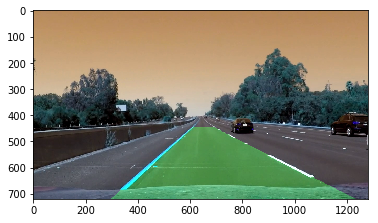

In [32]:
from moviepy.editor import VideoFileClip
video_input = '../project_video.mp4'
video_output = '../project_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
# clip1 = VideoFileClip(video_input).subclip(0,5)
clip1 = VideoFileClip(video_input)
challenge_clip = clip1.fl_image(process_image)
%time challenge_clip.write_videofile(video_output, audio=False)

left curvature is:  1634.33321952  pixels, e.g,  192.881929848  meters
right curvature is:  548.070832369  pixels, e.g,  175.739137054  meters
[MoviePy] >>>> Building video ../challenge_solution.mp4
[MoviePy] Writing video ../challenge_solution.mp4


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

left curvature is:  1634.33321952  pixels, e.g,  192.881929848  meters
right curvature is:  548.070832369  pixels, e.g,  175.739137054  meters


  0%|▎                                                                                 | 1/300 [00:00<01:19,  3.75it/s]

left curvature is:  1441.50264961  pixels, e.g,  172.779504364  meters
right curvature is:  363.958100001  pixels, e.g,  99.895774467  meters


  1%|▌                                                                                 | 2/300 [00:00<01:12,  4.12it/s]

left curvature is:  1075.26982191  pixels, e.g,  128.062736752  meters
right curvature is:  422.163488539  pixels, e.g,  125.169135435  meters


  1%|▊                                                                                 | 3/300 [00:00<01:05,  4.51it/s]

left curvature is:  1501.00347825  pixels, e.g,  216.245512539  meters
right curvature is:  519.271753611  pixels, e.g,  164.559935375  meters


  1%|█                                                                                 | 4/300 [00:00<01:05,  4.53it/s]

left curvature is:  1103.30910532  pixels, e.g,  109.945147602  meters
right curvature is:  432.043345422  pixels, e.g,  131.703422143  meters


  2%|█▎                                                                                | 5/300 [00:01<01:02,  4.75it/s]

left curvature is:  1318.63542981  pixels, e.g,  94.0406418419  meters
right curvature is:  835.403957074  pixels, e.g,  273.292699891  meters


  2%|█▋                                                                                | 6/300 [00:01<00:58,  5.02it/s]

left curvature is:  1357.28490134  pixels, e.g,  304.647452625  meters
right curvature is:  657.987716812  pixels, e.g,  214.381770388  meters


  2%|█▉                                                                                | 7/300 [00:01<00:55,  5.24it/s]

left curvature is:  1186.04734035  pixels, e.g,  241.186362345  meters
right curvature is:  659.790231866  pixels, e.g,  214.557233541  meters


  3%|██▏                                                                               | 8/300 [00:01<00:57,  5.07it/s]

left curvature is:  1090.70184289  pixels, e.g,  235.825442029  meters
right curvature is:  606.625113974  pixels, e.g,  196.299746106  meters


  3%|██▍                                                                               | 9/300 [00:01<00:59,  4.87it/s]

left curvature is:  1066.65797242  pixels, e.g,  198.492288549  meters
right curvature is:  607.387473202  pixels, e.g,  196.116125279  meters


  3%|██▋                                                                              | 10/300 [00:02<01:01,  4.68it/s]

left curvature is:  1013.73819886  pixels, e.g,  166.39037164  meters
right curvature is:  472.413323857  pixels, e.g,  148.10016727  meters


  4%|██▉                                                                              | 11/300 [00:02<01:03,  4.55it/s]

left curvature is:  1123.31924683  pixels, e.g,  143.678384612  meters
right curvature is:  571.38976908  pixels, e.g,  184.267568772  meters


  4%|███▏                                                                             | 12/300 [00:02<01:02,  4.62it/s]

left curvature is:  1095.39431281  pixels, e.g,  136.426924369  meters
right curvature is:  577.891264525  pixels, e.g,  186.724520091  meters


  4%|███▌                                                                             | 13/300 [00:02<01:05,  4.40it/s]

left curvature is:  1035.19989791  pixels, e.g,  130.177613999  meters
right curvature is:  939.22716423  pixels, e.g,  308.490848965  meters


  5%|███▊                                                                             | 14/300 [00:02<01:03,  4.52it/s]

left curvature is:  1013.27733777  pixels, e.g,  159.655225502  meters
right curvature is:  3324.26267601  pixels, e.g,  1075.14717701  meters


  5%|████                                                                             | 15/300 [00:03<01:02,  4.55it/s]

left curvature is:  1166.78147346  pixels, e.g,  212.824319194  meters
right curvature is:  2728.95698288  pixels, e.g,  891.392494987  meters


  5%|████▎                                                                            | 16/300 [00:03<01:02,  4.57it/s]

left curvature is:  962.209981522  pixels, e.g,  139.719602745  meters
right curvature is:  274521.442456  pixels, e.g,  88564.0173391  meters


  6%|████▌                                                                            | 17/300 [00:03<00:59,  4.75it/s]

left curvature is:  752054.062543  pixels, e.g,  244160.910072  meters
right curvature is:  6868.33581804  pixels, e.g,  2232.9842907  meters


  6%|████▊                                                                            | 18/300 [00:03<00:58,  4.79it/s]

left curvature is:  2791.58524941  pixels, e.g,  913.558012076  meters
right curvature is:  1433.66258238  pixels, e.g,  464.627948594  meters


  6%|█████▏                                                                           | 19/300 [00:04<01:00,  4.66it/s]

left curvature is:  1069.50079068  pixels, e.g,  168.242854662  meters
right curvature is:  1516.19916546  pixels, e.g,  491.585865494  meters


  7%|█████▍                                                                           | 20/300 [00:04<00:59,  4.71it/s]

left curvature is:  988.916090801  pixels, e.g,  175.943833321  meters
right curvature is:  891.191011942  pixels, e.g,  289.717851715  meters


  7%|█████▋                                                                           | 21/300 [00:04<00:58,  4.74it/s]

left curvature is:  1039.36148049  pixels, e.g,  201.960182097  meters
right curvature is:  1169.30311881  pixels, e.g,  383.706991462  meters


  7%|█████▉                                                                           | 22/300 [00:04<00:58,  4.76it/s]

left curvature is:  705.829643991  pixels, e.g,  66.547469255  meters
right curvature is:  2756.29131345  pixels, e.g,  901.946054239  meters


  8%|██████▏                                                                          | 23/300 [00:04<00:59,  4.69it/s]

left curvature is:  1275.42110872  pixels, e.g,  318.375773839  meters
right curvature is:  6589.48396645  pixels, e.g,  2147.11312278  meters


  8%|██████▍                                                                          | 24/300 [00:05<00:58,  4.75it/s]

left curvature is:  3586.27536348  pixels, e.g,  1106.40097403  meters
right curvature is:  1540.21280949  pixels, e.g,  489.193428934  meters


  8%|██████▊                                                                          | 25/300 [00:05<00:59,  4.63it/s]

left curvature is:  3616.96803655  pixels, e.g,  1187.79750758  meters
right curvature is:  990.630341201  pixels, e.g,  293.510075345  meters


  9%|███████                                                                          | 26/300 [00:05<01:02,  4.41it/s]

left curvature is:  1298.75619017  pixels, e.g,  342.872576772  meters
right curvature is:  869.05850787  pixels, e.g,  249.574439263  meters


  9%|███████▎                                                                         | 27/300 [00:05<01:01,  4.42it/s]

left curvature is:  1148.15822077  pixels, e.g,  155.81466197  meters
right curvature is:  755.664036797  pixels, e.g,  214.067606832  meters


  9%|███████▌                                                                         | 28/300 [00:06<01:03,  4.25it/s]

left curvature is:  686.380985777  pixels, e.g,  80.6602346122  meters
right curvature is:  626.411089528  pixels, e.g,  166.421952005  meters


 10%|███████▊                                                                         | 29/300 [00:06<01:06,  4.07it/s]

left curvature is:  1038.6171479  pixels, e.g,  132.653223928  meters
right curvature is:  772.542540487  pixels, e.g,  197.338326455  meters


 10%|████████                                                                         | 30/300 [00:06<01:03,  4.23it/s]

left curvature is:  990.797224824  pixels, e.g,  150.284737426  meters
right curvature is:  996.812421856  pixels, e.g,  285.774997806  meters


 10%|████████▎                                                                        | 31/300 [00:06<01:01,  4.36it/s]

left curvature is:  858.134387887  pixels, e.g,  200.718188246  meters
right curvature is:  419.857282627  pixels, e.g,  130.831690386  meters


 11%|████████▋                                                                        | 32/300 [00:06<01:00,  4.41it/s]

left curvature is:  60715.775456  pixels, e.g,  19452.7438938  meters
right curvature is:  579.522876838  pixels, e.g,  181.326673302  meters


 11%|████████▉                                                                        | 33/300 [00:07<01:00,  4.43it/s]

left curvature is:  1275.76274964  pixels, e.g,  208.995159859  meters
right curvature is:  255.317984133  pixels, e.g,  67.4809695365  meters


 11%|█████████▏                                                                       | 34/300 [00:07<00:58,  4.54it/s]

left curvature is:  365.168405807  pixels, e.g,  44.526365957  meters
right curvature is:  259.236342573  pixels, e.g,  74.4856077238  meters


 12%|█████████▍                                                                       | 35/300 [00:07<00:55,  4.74it/s]

left curvature is:  756.655757296  pixels, e.g,  195.274317562  meters
right curvature is:  567.077854978  pixels, e.g,  185.978445094  meters


 12%|█████████▋                                                                       | 36/300 [00:07<00:55,  4.73it/s]

left curvature is:  1001.21736923  pixels, e.g,  285.315764505  meters
right curvature is:  265.173949001  pixels, e.g,  72.4864823658  meters


 12%|█████████▉                                                                       | 37/300 [00:07<00:54,  4.79it/s]

left curvature is:  15122.5901037  pixels, e.g,  4960.08312189  meters
right curvature is:  386.978680536  pixels, e.g,  124.888683754  meters


 13%|██████████▎                                                                      | 38/300 [00:08<00:54,  4.85it/s]

left curvature is:  949.995669154  pixels, e.g,  262.961948628  meters
right curvature is:  362.113729957  pixels, e.g,  117.7158995  meters


 13%|██████████▌                                                                      | 39/300 [00:08<00:55,  4.71it/s]

left curvature is:  1006.69225017  pixels, e.g,  277.689406157  meters
right curvature is:  299.238709328  pixels, e.g,  94.5501138952  meters


 13%|██████████▊                                                                      | 40/300 [00:08<00:53,  4.82it/s]

left curvature is:  1007.7819441  pixels, e.g,  275.850046002  meters
right curvature is:  433.213649659  pixels, e.g,  141.904605212  meters


 14%|███████████                                                                      | 41/300 [00:08<00:53,  4.87it/s]

left curvature is:  1060.06172911  pixels, e.g,  292.716066855  meters
right curvature is:  369.651087902  pixels, e.g,  121.35708861  meters


 14%|███████████▎                                                                     | 42/300 [00:09<00:55,  4.63it/s]

left curvature is:  1052.07219769  pixels, e.g,  290.460370916  meters
right curvature is:  380.362124145  pixels, e.g,  124.883765934  meters


 14%|███████████▌                                                                     | 43/300 [00:09<00:57,  4.46it/s]

left curvature is:  1073.75106915  pixels, e.g,  304.464857361  meters
right curvature is:  398.304757079  pixels, e.g,  130.289692185  meters


 15%|███████████▉                                                                     | 44/300 [00:09<00:59,  4.27it/s]

left curvature is:  1156.48212625  pixels, e.g,  341.971628133  meters
right curvature is:  407.638105276  pixels, e.g,  133.358518984  meters


 15%|████████████▏                                                                    | 45/300 [00:09<00:58,  4.40it/s]

left curvature is:  1417.15054511  pixels, e.g,  402.482275711  meters
right curvature is:  323.593809128  pixels, e.g,  105.736858035  meters


 15%|████████████▍                                                                    | 46/300 [00:09<00:57,  4.44it/s]

left curvature is:  970.084580465  pixels, e.g,  247.470795716  meters
right curvature is:  279.271832795  pixels, e.g,  88.7461054932  meters


 16%|████████████▋                                                                    | 47/300 [00:10<00:55,  4.59it/s]

left curvature is:  1365.83597937  pixels, e.g,  410.78488519  meters
right curvature is:  314.021057497  pixels, e.g,  102.575977193  meters


 16%|████████████▉                                                                    | 48/300 [00:10<00:55,  4.57it/s]

left curvature is:  2880.35519343  pixels, e.g,  934.312350723  meters
right curvature is:  311.765394332  pixels, e.g,  101.011514452  meters


 16%|█████████████▏                                                                   | 49/300 [00:10<00:55,  4.49it/s]

left curvature is:  16090.9941183  pixels, e.g,  5269.42030907  meters
right curvature is:  301.287736919  pixels, e.g,  97.0642295644  meters


 17%|█████████████▌                                                                   | 50/300 [00:10<00:56,  4.43it/s]

left curvature is:  7552.16616305  pixels, e.g,  2441.35580949  meters
right curvature is:  977.464118803  pixels, e.g,  307.652390704  meters


 17%|█████████████▊                                                                   | 51/300 [00:11<00:55,  4.51it/s]

left curvature is:  2372.3981877  pixels, e.g,  740.279137653  meters
right curvature is:  6587.5142233  pixels, e.g,  1930.30594356  meters


 17%|██████████████                                                                   | 52/300 [00:11<00:56,  4.42it/s]

left curvature is:  4532.90300339  pixels, e.g,  1481.78264617  meters
right curvature is:  863.776712418  pixels, e.g,  201.614950208  meters


 18%|██████████████▎                                                                  | 53/300 [00:11<00:56,  4.34it/s]

left curvature is:  1892.06230298  pixels, e.g,  597.895400457  meters
right curvature is:  735.49871687  pixels, e.g,  159.286685124  meters


 18%|██████████████▌                                                                  | 54/300 [00:11<00:55,  4.42it/s]

left curvature is:  1518.65152069  pixels, e.g,  473.618687164  meters
right curvature is:  604.433337004  pixels, e.g,  117.981973584  meters


 18%|██████████████▊                                                                  | 55/300 [00:11<00:55,  4.41it/s]

left curvature is:  1362.44485128  pixels, e.g,  423.467464593  meters
right curvature is:  571.487511922  pixels, e.g,  112.417418678  meters


 19%|███████████████                                                                  | 56/300 [00:12<00:55,  4.38it/s]

left curvature is:  1553.44325984  pixels, e.g,  497.580930433  meters
right curvature is:  536.208407022  pixels, e.g,  104.680681085  meters


 19%|███████████████▍                                                                 | 57/300 [00:12<00:57,  4.24it/s]

left curvature is:  1376.58696853  pixels, e.g,  411.468357016  meters
right curvature is:  516.736754934  pixels, e.g,  104.39529324  meters


 19%|███████████████▋                                                                 | 58/300 [00:12<00:57,  4.22it/s]

left curvature is:  1186.07972597  pixels, e.g,  338.640058379  meters
right curvature is:  456.797974895  pixels, e.g,  84.4654432397  meters


 20%|███████████████▉                                                                 | 59/300 [00:12<01:00,  4.00it/s]

left curvature is:  955.047688339  pixels, e.g,  158.787373613  meters
right curvature is:  455.971541848  pixels, e.g,  76.9784812687  meters


 20%|████████████████▏                                                                | 60/300 [00:13<00:59,  4.04it/s]

left curvature is:  1124.41490158  pixels, e.g,  103.861264598  meters
right curvature is:  435.420003451  pixels, e.g,  80.84587232  meters


 20%|████████████████▍                                                                | 61/300 [00:13<00:58,  4.08it/s]

left curvature is:  1184.25077866  pixels, e.g,  92.6537115483  meters
right curvature is:  414.461149255  pixels, e.g,  83.441858909  meters


 21%|████████████████▋                                                                | 62/300 [00:13<00:55,  4.31it/s]

left curvature is:  1110.11699466  pixels, e.g,  89.176641033  meters
right curvature is:  396.12117535  pixels, e.g,  79.7239307583  meters


 21%|█████████████████                                                                | 63/300 [00:13<00:54,  4.31it/s]

left curvature is:  992.951136825  pixels, e.g,  91.6581469419  meters
right curvature is:  399.787772217  pixels, e.g,  93.2785638191  meters


 21%|█████████████████▎                                                               | 64/300 [00:14<00:53,  4.40it/s]

left curvature is:  1243.97105133  pixels, e.g,  71.4413214568  meters
right curvature is:  363.359261328  pixels, e.g,  71.0357025325  meters


 22%|█████████████████▌                                                               | 65/300 [00:14<00:52,  4.45it/s]

left curvature is:  1689.42439024  pixels, e.g,  41.245989541  meters
right curvature is:  343.946799467  pixels, e.g,  75.5988698838  meters


 22%|█████████████████▊                                                               | 66/300 [00:14<00:51,  4.55it/s]

left curvature is:  192.563524706  pixels, e.g,  31.9146853631  meters
right curvature is:  672.972402431  pixels, e.g,  194.380716119  meters


 22%|██████████████████                                                               | 67/300 [00:14<00:50,  4.60it/s]

left curvature is:  932.529706164  pixels, e.g,  23.8516344839  meters
right curvature is:  531.281256349  pixels, e.g,  138.300139946  meters


 23%|██████████████████▎                                                              | 68/300 [00:14<00:50,  4.55it/s]

left curvature is:  596.080634401  pixels, e.g,  21.3536989862  meters
right curvature is:  933.237654206  pixels, e.g,  272.581135929  meters


 23%|██████████████████▋                                                              | 69/300 [00:15<00:51,  4.52it/s]

left curvature is:  165.331236428  pixels, e.g,  31.9603570717  meters
right curvature is:  649.063645033  pixels, e.g,  177.232948813  meters


 23%|██████████████████▉                                                              | 70/300 [00:15<00:51,  4.48it/s]

left curvature is:  170.831152246  pixels, e.g,  31.5906403694  meters
right curvature is:  688.412308863  pixels, e.g,  180.130126673  meters


 24%|███████████████████▏                                                             | 71/300 [00:15<00:50,  4.55it/s]

left curvature is:  200.059653122  pixels, e.g,  29.273941529  meters
right curvature is:  383.403311361  pixels, e.g,  87.7834058175  meters


 24%|███████████████████▍                                                             | 72/300 [00:15<00:50,  4.47it/s]

left curvature is:  8430.7350008  pixels, e.g,  1958.95531918  meters
right curvature is:  307.793607779  pixels, e.g,  49.26052302  meters


 24%|███████████████████▋                                                             | 73/300 [00:16<00:52,  4.33it/s]

left curvature is:  173.93095069  pixels, e.g,  33.4457054089  meters
right curvature is:  1188.60275608  pixels, e.g,  81.8137522938  meters


 25%|███████████████████▉                                                             | 74/300 [00:16<00:51,  4.36it/s]

left curvature is:  176.881932469  pixels, e.g,  33.196483213  meters
right curvature is:  1152.69789319  pixels, e.g,  85.4307523994  meters


 25%|████████████████████▎                                                            | 75/300 [00:16<00:51,  4.39it/s]

left curvature is:  196.18236877  pixels, e.g,  28.2726128865  meters
right curvature is:  1294.86300492  pixels, e.g,  120.372119233  meters


 25%|████████████████████▌                                                            | 76/300 [00:16<00:49,  4.53it/s]

left curvature is:  2062.69500423  pixels, e.g,  529.864522196  meters
right curvature is:  1323.97829378  pixels, e.g,  82.5793720216  meters


 26%|████████████████████▊                                                            | 77/300 [00:17<00:49,  4.53it/s]

left curvature is:  3180.42711447  pixels, e.g,  745.172241761  meters
right curvature is:  1228.5713432  pixels, e.g,  109.003151776  meters


 26%|█████████████████████                                                            | 78/300 [00:17<00:47,  4.63it/s]

left curvature is:  1131.89558532  pixels, e.g,  230.012584133  meters
right curvature is:  1133.6661149  pixels, e.g,  163.210541671  meters


 26%|█████████████████████▎                                                           | 79/300 [00:17<00:48,  4.53it/s]

left curvature is:  1359.14379853  pixels, e.g,  248.668771727  meters
right curvature is:  2182.20324679  pixels, e.g,  503.933640906  meters


 27%|█████████████████████▌                                                           | 80/300 [00:17<00:48,  4.56it/s]

left curvature is:  1398.8093519  pixels, e.g,  292.156103154  meters
right curvature is:  1217.71796968  pixels, e.g,  105.881057115  meters


 27%|█████████████████████▊                                                           | 81/300 [00:17<00:47,  4.58it/s]

left curvature is:  186.427161966  pixels, e.g,  25.9644412599  meters
right curvature is:  1317.35067341  pixels, e.g,  245.45247361  meters


 27%|██████████████████████▏                                                          | 82/300 [00:18<00:48,  4.54it/s]

left curvature is:  227.043326115  pixels, e.g,  21.7239805023  meters
right curvature is:  807.830985538  pixels, e.g,  69.373825848  meters


 28%|██████████████████████▍                                                          | 83/300 [00:18<00:48,  4.50it/s]

left curvature is:  295.843290431  pixels, e.g,  19.6143231404  meters
right curvature is:  2867.07204612  pixels, e.g,  344.78298822  meters


 28%|██████████████████████▋                                                          | 84/300 [00:18<00:48,  4.46it/s]

left curvature is:  172.075713376  pixels, e.g,  27.7592548273  meters
right curvature is:  1200.66217864  pixels, e.g,  96.3848826029  meters


 28%|██████████████████████▉                                                          | 85/300 [00:18<00:49,  4.34it/s]

left curvature is:  173.625709997  pixels, e.g,  24.7099492149  meters
right curvature is:  1358.43196382  pixels, e.g,  105.056598974  meters


 29%|███████████████████████▏                                                         | 86/300 [00:19<00:51,  4.16it/s]

left curvature is:  166.285596335  pixels, e.g,  23.4598303441  meters
right curvature is:  1452.66296133  pixels, e.g,  125.870511018  meters


 29%|███████████████████████▍                                                         | 87/300 [00:19<00:48,  4.36it/s]

left curvature is:  292.287594919  pixels, e.g,  15.8629730047  meters
right curvature is:  468.653425843  pixels, e.g,  100.662200996  meters


 29%|███████████████████████▊                                                         | 88/300 [00:19<00:48,  4.39it/s]

left curvature is:  244.583458438  pixels, e.g,  16.2102352386  meters
right curvature is:  1222.57543625  pixels, e.g,  109.469218808  meters


 30%|████████████████████████                                                         | 89/300 [00:19<00:46,  4.50it/s]

left curvature is:  168.495490828  pixels, e.g,  23.2462565739  meters
right curvature is:  4012.19613825  pixels, e.g,  535.409397081  meters


 30%|████████████████████████▎                                                        | 90/300 [00:19<00:46,  4.51it/s]

left curvature is:  170.634916503  pixels, e.g,  24.0215181271  meters
right curvature is:  1735.77643111  pixels, e.g,  220.866861949  meters


 30%|████████████████████████▌                                                        | 91/300 [00:20<00:47,  4.40it/s]

left curvature is:  139.246959397  pixels, e.g,  38.6000949009  meters
right curvature is:  1189.41259892  pixels, e.g,  106.588123877  meters


 31%|████████████████████████▊                                                        | 92/300 [00:20<00:47,  4.34it/s]

left curvature is:  160.452425419  pixels, e.g,  33.6956213993  meters
right curvature is:  1112.34028245  pixels, e.g,  109.762375082  meters


 31%|█████████████████████████                                                        | 93/300 [00:20<00:47,  4.37it/s]

left curvature is:  155.009281753  pixels, e.g,  36.847842452  meters
right curvature is:  265.230816837  pixels, e.g,  75.5259710991  meters


 31%|█████████████████████████▍                                                       | 94/300 [00:20<00:47,  4.38it/s]

left curvature is:  150.062247241  pixels, e.g,  38.388361105  meters
right curvature is:  275.047757159  pixels, e.g,  76.3361509622  meters


 32%|█████████████████████████▋                                                       | 95/300 [00:21<00:45,  4.47it/s]

left curvature is:  161.111926184  pixels, e.g,  38.6690052087  meters
right curvature is:  960.580929999  pixels, e.g,  260.506925699  meters


 32%|█████████████████████████▉                                                       | 96/300 [00:21<00:45,  4.47it/s]

left curvature is:  1720.31118807  pixels, e.g,  45.496923201  meters
right curvature is:  213.994553445  pixels, e.g,  53.9823913528  meters


 32%|██████████████████████████▏                                                      | 97/300 [00:21<00:46,  4.35it/s]

left curvature is:  1147.4995562  pixels, e.g,  337.390574843  meters
right curvature is:  3932.31237323  pixels, e.g,  786.514280656  meters


 33%|██████████████████████████▍                                                      | 98/300 [00:21<00:52,  3.84it/s]

left curvature is:  3213.23063177  pixels, e.g,  1030.93398157  meters
right curvature is:  2626.21869461  pixels, e.g,  528.760205581  meters


 33%|██████████████████████████▋                                                      | 99/300 [00:22<00:51,  3.87it/s]

left curvature is:  1374.13208586  pixels, e.g,  419.743065997  meters
right curvature is:  1053.66300234  pixels, e.g,  150.725556788  meters


 33%|██████████████████████████▋                                                     | 100/300 [00:22<00:50,  4.00it/s]

left curvature is:  175.301877686  pixels, e.g,  27.2866232833  meters
right curvature is:  1142.70254875  pixels, e.g,  177.185716947  meters


 34%|██████████████████████████▉                                                     | 101/300 [00:22<00:47,  4.17it/s]

left curvature is:  243.431336229  pixels, e.g,  25.0801977552  meters
right curvature is:  274.428397443  pixels, e.g,  90.1344805588  meters


 34%|███████████████████████████▏                                                    | 102/300 [00:22<00:45,  4.39it/s]

left curvature is:  224.958075355  pixels, e.g,  28.3018987323  meters
right curvature is:  309.236790852  pixels, e.g,  101.071564775  meters


 34%|███████████████████████████▍                                                    | 103/300 [00:22<00:43,  4.53it/s]

left curvature is:  207.030507465  pixels, e.g,  32.2739332511  meters
right curvature is:  1338.3530539  pixels, e.g,  270.165457088  meters


 35%|███████████████████████████▋                                                    | 104/300 [00:23<00:42,  4.58it/s]

left curvature is:  218.419922686  pixels, e.g,  33.3561185883  meters
right curvature is:  568.361879684  pixels, e.g,  132.142947323  meters


 35%|████████████████████████████                                                    | 105/300 [00:23<00:41,  4.64it/s]

left curvature is:  206.910300715  pixels, e.g,  37.7580371895  meters
right curvature is:  1761.85966827  pixels, e.g,  183.071668937  meters


 35%|████████████████████████████▎                                                   | 106/300 [00:23<00:41,  4.69it/s]

left curvature is:  210.696203563  pixels, e.g,  37.5368269193  meters
right curvature is:  6603.53136191  pixels, e.g,  2158.69524221  meters


 36%|████████████████████████████▌                                                   | 107/300 [00:23<00:42,  4.54it/s]

left curvature is:  254.003836576  pixels, e.g,  32.7561845379  meters
right curvature is:  1051.95741668  pixels, e.g,  145.362591965  meters


 36%|████████████████████████████▊                                                   | 108/300 [00:24<00:41,  4.62it/s]

left curvature is:  274.217626569  pixels, e.g,  29.9488896279  meters
right curvature is:  1106.21212888  pixels, e.g,  116.726834171  meters


 36%|█████████████████████████████                                                   | 109/300 [00:24<00:41,  4.61it/s]

left curvature is:  235.630045151  pixels, e.g,  30.1594155724  meters
right curvature is:  1201.66614669  pixels, e.g,  165.013378121  meters


 37%|█████████████████████████████▎                                                  | 110/300 [00:24<00:40,  4.67it/s]

left curvature is:  204.735693438  pixels, e.g,  30.0286147965  meters
right curvature is:  1402.38043646  pixels, e.g,  340.75168259  meters


 37%|█████████████████████████████▌                                                  | 111/300 [00:24<00:40,  4.68it/s]

left curvature is:  196.719744976  pixels, e.g,  30.253919053  meters
right curvature is:  1449.22897784  pixels, e.g,  380.742454443  meters


 37%|█████████████████████████████▊                                                  | 112/300 [00:24<00:44,  4.27it/s]

left curvature is:  191.052575238  pixels, e.g,  30.696210921  meters
right curvature is:  1421.72626647  pixels, e.g,  392.962764905  meters


 38%|██████████████████████████████▏                                                 | 113/300 [00:25<00:42,  4.43it/s]

left curvature is:  197.130391505  pixels, e.g,  30.4259508638  meters
right curvature is:  1174.7956965  pixels, e.g,  285.313286654  meters


 38%|██████████████████████████████▍                                                 | 114/300 [00:25<00:45,  4.05it/s]

left curvature is:  251.293044275  pixels, e.g,  23.2983843042  meters
right curvature is:  1052.72329404  pixels, e.g,  253.624635042  meters


 38%|██████████████████████████████▋                                                 | 115/300 [00:25<00:43,  4.25it/s]

left curvature is:  473.531759749  pixels, e.g,  16.2659015921  meters
right curvature is:  1033.27946057  pixels, e.g,  252.058934638  meters


 39%|██████████████████████████████▉                                                 | 116/300 [00:25<00:42,  4.35it/s]

left curvature is:  262.760296881  pixels, e.g,  23.2341126529  meters
right curvature is:  1114.9094397  pixels, e.g,  315.531471674  meters


 39%|███████████████████████████████▏                                                | 117/300 [00:26<00:40,  4.50it/s]

left curvature is:  275.007027753  pixels, e.g,  18.4360127785  meters
right curvature is:  1114.07117163  pixels, e.g,  338.900753267  meters


 39%|███████████████████████████████▍                                                | 118/300 [00:26<00:39,  4.65it/s]

left curvature is:  161.90444501  pixels, e.g,  22.1835908295  meters
right curvature is:  2687.76678459  pixels, e.g,  882.780907698  meters


 40%|███████████████████████████████▋                                                | 119/300 [00:26<00:40,  4.52it/s]

left curvature is:  127.62213712  pixels, e.g,  23.602409655  meters
right curvature is:  879.013986366  pixels, e.g,  199.925497854  meters


 40%|████████████████████████████████                                                | 120/300 [00:26<00:40,  4.48it/s]

left curvature is:  145.406859149  pixels, e.g,  18.4885578086  meters
right curvature is:  5892.77930401  pixels, e.g,  1606.00471835  meters


 40%|████████████████████████████████▎                                               | 121/300 [00:26<00:39,  4.52it/s]

left curvature is:  109.813653891  pixels, e.g,  28.4699378669  meters
right curvature is:  597.529991729  pixels, e.g,  133.190284515  meters


 41%|████████████████████████████████▌                                               | 122/300 [00:27<00:38,  4.60it/s]

left curvature is:  108.042286413  pixels, e.g,  23.4054648804  meters
right curvature is:  1323.52741713  pixels, e.g,  427.790968529  meters


 41%|████████████████████████████████▊                                               | 123/300 [00:27<00:37,  4.69it/s]

left curvature is:  112.315099766  pixels, e.g,  18.5167803764  meters
right curvature is:  770.387400322  pixels, e.g,  235.660205241  meters


 41%|█████████████████████████████████                                               | 124/300 [00:27<00:37,  4.75it/s]

left curvature is:  110.216307179  pixels, e.g,  14.8841601358  meters
right curvature is:  294.410409573  pixels, e.g,  85.7541921105  meters


 42%|█████████████████████████████████▎                                              | 125/300 [00:27<00:37,  4.71it/s]

left curvature is:  74.9796822932  pixels, e.g,  16.068354269  meters
right curvature is:  284.886505703  pixels, e.g,  68.9635677582  meters


 42%|█████████████████████████████████▌                                              | 126/300 [00:28<00:38,  4.48it/s]

left curvature is:  60.394299243  pixels, e.g,  15.8384424805  meters
right curvature is:  674.807844408  pixels, e.g,  214.035898598  meters


 42%|█████████████████████████████████▊                                              | 127/300 [00:28<00:37,  4.58it/s]

left curvature is:  693.374945382  pixels, e.g,  45.6151650371  meters
right curvature is:  543.231599781  pixels, e.g,  176.252755094  meters


 43%|██████████████████████████████████▏                                             | 128/300 [00:28<00:37,  4.55it/s]

left curvature is:  880.920027188  pixels, e.g,  40.4714524812  meters
right curvature is:  629.362911575  pixels, e.g,  201.999052723  meters


 43%|██████████████████████████████████▍                                             | 129/300 [00:28<00:36,  4.65it/s]

left curvature is:  1782.61657462  pixels, e.g,  135.846872823  meters
right curvature is:  3423.97424469  pixels, e.g,  829.870593324  meters


 43%|██████████████████████████████████▋                                             | 130/300 [00:28<00:36,  4.68it/s]

left curvature is:  1839.25435637  pixels, e.g,  89.4216969848  meters
right curvature is:  1473.7004277  pixels, e.g,  133.404829718  meters


 44%|██████████████████████████████████▉                                             | 131/300 [00:29<00:35,  4.77it/s]

left curvature is:  767.534571209  pixels, e.g,  38.7437207312  meters
right curvature is:  1942.41410547  pixels, e.g,  267.849154805  meters


 44%|███████████████████████████████████▏                                            | 132/300 [00:29<00:35,  4.78it/s]

left curvature is:  1427.77263937  pixels, e.g,  180.432341257  meters
right curvature is:  1479.95067218  pixels, e.g,  257.663100713  meters


 44%|███████████████████████████████████▍                                            | 133/300 [00:29<00:35,  4.76it/s]

left curvature is:  1487.99777603  pixels, e.g,  209.07572958  meters
right curvature is:  1576.09333336  pixels, e.g,  281.347354658  meters


 45%|███████████████████████████████████▋                                            | 134/300 [00:29<00:36,  4.54it/s]

left curvature is:  1507.6390573  pixels, e.g,  155.087642344  meters
right curvature is:  1462.54274424  pixels, e.g,  211.76292958  meters


 45%|████████████████████████████████████                                            | 135/300 [00:29<00:36,  4.56it/s]

left curvature is:  1433.77954816  pixels, e.g,  140.464466805  meters
right curvature is:  1352.77734709  pixels, e.g,  179.102626582  meters


 45%|████████████████████████████████████▎                                           | 136/300 [00:30<00:35,  4.63it/s]

left curvature is:  1479.65854229  pixels, e.g,  150.763082452  meters
right curvature is:  1427.92277853  pixels, e.g,  175.40433266  meters


 46%|████████████████████████████████████▌                                           | 137/300 [00:30<00:38,  4.22it/s]

left curvature is:  1547.79409323  pixels, e.g,  120.030291392  meters
right curvature is:  1437.66134362  pixels, e.g,  137.299928913  meters


 46%|████████████████████████████████████▊                                           | 138/300 [00:30<00:37,  4.29it/s]

left curvature is:  1464.0141079  pixels, e.g,  128.931969569  meters
right curvature is:  1453.1764082  pixels, e.g,  130.707895708  meters


 46%|█████████████████████████████████████                                           | 139/300 [00:30<00:37,  4.27it/s]

left curvature is:  1084.21111927  pixels, e.g,  39.9117782295  meters
right curvature is:  1432.61812078  pixels, e.g,  153.154129468  meters


 47%|█████████████████████████████████████▎                                          | 140/300 [00:31<00:37,  4.21it/s]

left curvature is:  948.242295346  pixels, e.g,  40.3403863806  meters
right curvature is:  1576.4506622  pixels, e.g,  287.540677215  meters


 47%|█████████████████████████████████████▌                                          | 141/300 [00:31<00:37,  4.22it/s]

left curvature is:  259.751299458  pixels, e.g,  58.182244669  meters
right curvature is:  2097.13705109  pixels, e.g,  270.490525239  meters


 47%|█████████████████████████████████████▊                                          | 142/300 [00:31<00:36,  4.35it/s]

left curvature is:  2187.48841599  pixels, e.g,  278.223488596  meters
right curvature is:  1688.9158116  pixels, e.g,  347.003078672  meters


 48%|██████████████████████████████████████▏                                         | 143/300 [00:31<00:35,  4.45it/s]

left curvature is:  262.959246249  pixels, e.g,  52.0161845039  meters
right curvature is:  302.846088425  pixels, e.g,  94.1741285518  meters


 48%|██████████████████████████████████████▍                                         | 144/300 [00:32<00:36,  4.24it/s]

left curvature is:  376.854260486  pixels, e.g,  42.1213788015  meters
right curvature is:  1883.89774112  pixels, e.g,  359.596200053  meters


 48%|██████████████████████████████████████▋                                         | 145/300 [00:32<00:37,  4.17it/s]

left curvature is:  300.067246576  pixels, e.g,  59.2057647434  meters
right curvature is:  2537.65454755  pixels, e.g,  456.77945289  meters


 49%|██████████████████████████████████████▉                                         | 146/300 [00:32<00:37,  4.07it/s]

left curvature is:  299.354554643  pixels, e.g,  55.3881282541  meters
right curvature is:  1942.5384781  pixels, e.g,  266.496712319  meters


 49%|███████████████████████████████████████▏                                        | 147/300 [00:32<00:37,  4.07it/s]

left curvature is:  292.730651618  pixels, e.g,  52.7455621394  meters
right curvature is:  1999.79220712  pixels, e.g,  274.386770534  meters


 49%|███████████████████████████████████████▍                                        | 148/300 [00:33<00:39,  3.86it/s]

left curvature is:  273.978221633  pixels, e.g,  53.0520685029  meters
right curvature is:  2156.39397627  pixels, e.g,  316.327358757  meters


 50%|███████████████████████████████████████▋                                        | 149/300 [00:33<00:36,  4.10it/s]

left curvature is:  616.680712063  pixels, e.g,  57.9692612167  meters
right curvature is:  2052.50707645  pixels, e.g,  301.055993459  meters


 50%|████████████████████████████████████████                                        | 150/300 [00:33<00:35,  4.18it/s]

left curvature is:  260.434409423  pixels, e.g,  43.688194162  meters
right curvature is:  359.530369249  pixels, e.g,  111.089712538  meters


 50%|████████████████████████████████████████▎                                       | 151/300 [00:33<00:35,  4.17it/s]

left curvature is:  200.690986545  pixels, e.g,  49.7518889126  meters
right curvature is:  297.433367007  pixels, e.g,  95.0632586739  meters


 51%|████████████████████████████████████████▌                                       | 152/300 [00:34<00:34,  4.26it/s]

left curvature is:  278.151628469  pixels, e.g,  74.4719435965  meters
right curvature is:  382.317660101  pixels, e.g,  125.327401159  meters


 51%|████████████████████████████████████████▊                                       | 153/300 [00:34<00:33,  4.35it/s]

left curvature is:  2479.91437999  pixels, e.g,  84.8360541052  meters
right curvature is:  387.926294246  pixels, e.g,  127.173953572  meters


 51%|█████████████████████████████████████████                                       | 154/300 [00:34<00:32,  4.47it/s]

left curvature is:  2994.78729358  pixels, e.g,  120.953798041  meters
right curvature is:  2632.91934226  pixels, e.g,  685.309810649  meters


 52%|█████████████████████████████████████████▎                                      | 155/300 [00:34<00:32,  4.43it/s]

left curvature is:  247.156559578  pixels, e.g,  50.8553504171  meters
right curvature is:  360.419419447  pixels, e.g,  118.370511959  meters


 52%|█████████████████████████████████████████▌                                      | 156/300 [00:34<00:32,  4.37it/s]

left curvature is:  246.104883366  pixels, e.g,  53.5594261035  meters
right curvature is:  3558.90236183  pixels, e.g,  701.143836376  meters


 52%|█████████████████████████████████████████▊                                      | 157/300 [00:35<00:32,  4.45it/s]

left curvature is:  233.634142062  pixels, e.g,  46.5702563564  meters
right curvature is:  311.689019754  pixels, e.g,  100.247720511  meters


 53%|██████████████████████████████████████████▏                                     | 158/300 [00:35<00:32,  4.43it/s]

left curvature is:  221.003007931  pixels, e.g,  51.2891010802  meters
right curvature is:  312.103155809  pixels, e.g,  99.8540180276  meters


 53%|██████████████████████████████████████████▍                                     | 159/300 [00:35<00:31,  4.43it/s]

left curvature is:  228.776525968  pixels, e.g,  43.0260198696  meters
right curvature is:  1042.77467009  pixels, e.g,  121.313868889  meters


 53%|██████████████████████████████████████████▋                                     | 160/300 [00:35<00:31,  4.42it/s]

left curvature is:  214.566779396  pixels, e.g,  52.5070492743  meters
right curvature is:  515.039003318  pixels, e.g,  141.317044364  meters


 54%|██████████████████████████████████████████▉                                     | 161/300 [00:36<00:30,  4.52it/s]

left curvature is:  202.410012947  pixels, e.g,  49.0476059354  meters
right curvature is:  541.885070804  pixels, e.g,  146.046207786  meters


 54%|███████████████████████████████████████████▏                                    | 162/300 [00:36<00:30,  4.59it/s]

left curvature is:  213.528795062  pixels, e.g,  51.3735684707  meters
right curvature is:  2872.26454624  pixels, e.g,  423.843133775  meters


 54%|███████████████████████████████████████████▍                                    | 163/300 [00:36<00:29,  4.59it/s]

left curvature is:  211.663904075  pixels, e.g,  59.1079339531  meters
right curvature is:  1082.28518926  pixels, e.g,  258.668405412  meters


 55%|███████████████████████████████████████████▋                                    | 164/300 [00:36<00:29,  4.57it/s]

left curvature is:  209.781168927  pixels, e.g,  60.1591057869  meters
right curvature is:  23890.364915  pixels, e.g,  4179.64387078  meters


 55%|████████████████████████████████████████████                                    | 165/300 [00:36<00:29,  4.62it/s]

left curvature is:  205.343181063  pixels, e.g,  57.2413141204  meters
right curvature is:  304.074027561  pixels, e.g,  97.2386646438  meters


 55%|████████████████████████████████████████████▎                                   | 166/300 [00:37<00:29,  4.51it/s]

left curvature is:  209.284441223  pixels, e.g,  59.6504999524  meters
right curvature is:  317.193697892  pixels, e.g,  102.955290934  meters


 56%|████████████████████████████████████████████▌                                   | 167/300 [00:37<00:29,  4.50it/s]

left curvature is:  208.659716255  pixels, e.g,  58.4295553478  meters
right curvature is:  317.118018833  pixels, e.g,  102.573125853  meters


 56%|████████████████████████████████████████████▊                                   | 168/300 [00:37<00:29,  4.45it/s]

left curvature is:  201.976264275  pixels, e.g,  49.2830723391  meters
right curvature is:  316.851199133  pixels, e.g,  102.175103674  meters


 56%|█████████████████████████████████████████████                                   | 169/300 [00:37<00:28,  4.53it/s]

left curvature is:  3790.44031242  pixels, e.g,  756.429608028  meters
right curvature is:  284.596106583  pixels, e.g,  86.5419692797  meters


 57%|█████████████████████████████████████████████▎                                  | 170/300 [00:38<00:28,  4.54it/s]

left curvature is:  202.748913173  pixels, e.g,  39.6096693377  meters
right curvature is:  292.302210432  pixels, e.g,  90.2732723576  meters


 57%|█████████████████████████████████████████████▌                                  | 171/300 [00:38<00:27,  4.61it/s]

left curvature is:  211.253673153  pixels, e.g,  42.4898488099  meters
right curvature is:  304.258353815  pixels, e.g,  96.9979673914  meters


 57%|█████████████████████████████████████████████▊                                  | 172/300 [00:38<00:27,  4.67it/s]

left curvature is:  206.365638627  pixels, e.g,  44.1999964143  meters
right curvature is:  310.523405424  pixels, e.g,  99.5734913894  meters


 58%|██████████████████████████████████████████████▏                                 | 173/300 [00:38<00:27,  4.63it/s]

left curvature is:  211.168748467  pixels, e.g,  47.034384825  meters
right curvature is:  348.336212124  pixels, e.g,  114.263016705  meters


 58%|██████████████████████████████████████████████▍                                 | 174/300 [00:38<00:27,  4.62it/s]

left curvature is:  207.94715367  pixels, e.g,  46.2194066393  meters
right curvature is:  287.167614626  pixels, e.g,  76.8890648617  meters


 58%|██████████████████████████████████████████████▋                                 | 175/300 [00:39<00:26,  4.67it/s]

left curvature is:  195.261351037  pixels, e.g,  46.7003559719  meters
right curvature is:  957.70834812  pixels, e.g,  103.764469128  meters


 59%|██████████████████████████████████████████████▉                                 | 176/300 [00:39<00:26,  4.64it/s]

left curvature is:  225.151816033  pixels, e.g,  47.9469120664  meters
right curvature is:  5892.74723379  pixels, e.g,  1123.62109134  meters


 59%|███████████████████████████████████████████████▏                                | 177/300 [00:39<00:26,  4.56it/s]

left curvature is:  173.687752109  pixels, e.g,  53.4587557716  meters
right curvature is:  784.879778573  pixels, e.g,  236.293202665  meters


 59%|███████████████████████████████████████████████▍                                | 178/300 [00:39<00:26,  4.63it/s]

left curvature is:  152.627597086  pixels, e.g,  48.291260817  meters
right curvature is:  355.161024396  pixels, e.g,  116.251899085  meters


 60%|███████████████████████████████████████████████▋                                | 179/300 [00:39<00:26,  4.64it/s]

left curvature is:  190.857891515  pixels, e.g,  48.399668515  meters
right curvature is:  493.695367933  pixels, e.g,  159.573756433  meters


 60%|████████████████████████████████████████████████                                | 180/300 [00:40<00:25,  4.71it/s]

left curvature is:  228.682146319  pixels, e.g,  47.4148810571  meters
right curvature is:  1964.28325779  pixels, e.g,  356.762718427  meters


 60%|████████████████████████████████████████████████▎                               | 181/300 [00:40<00:25,  4.67it/s]

left curvature is:  225.448387539  pixels, e.g,  42.9388628067  meters
right curvature is:  631.379484191  pixels, e.g,  199.161132229  meters


 61%|████████████████████████████████████████████████▌                               | 182/300 [00:40<00:25,  4.62it/s]

left curvature is:  214.193559298  pixels, e.g,  45.1984991726  meters
right curvature is:  3871.05084908  pixels, e.g,  1026.5074748  meters


 61%|████████████████████████████████████████████████▊                               | 183/300 [00:40<00:25,  4.64it/s]

left curvature is:  227.976252678  pixels, e.g,  43.8010846748  meters
right curvature is:  391.038204547  pixels, e.g,  128.406899074  meters


 61%|█████████████████████████████████████████████████                               | 184/300 [00:41<00:24,  4.71it/s]

left curvature is:  228.863650674  pixels, e.g,  37.4853897311  meters
right curvature is:  405.115288578  pixels, e.g,  133.05574391  meters


 62%|█████████████████████████████████████████████████▎                              | 185/300 [00:41<00:24,  4.76it/s]

left curvature is:  297.106151043  pixels, e.g,  31.4240352804  meters
right curvature is:  424.784318292  pixels, e.g,  139.444620545  meters


 62%|█████████████████████████████████████████████████▌                              | 186/300 [00:41<00:23,  4.78it/s]

left curvature is:  285.482706886  pixels, e.g,  29.8946814354  meters
right curvature is:  388.860461449  pixels, e.g,  127.641606434  meters


 62%|█████████████████████████████████████████████████▊                              | 187/300 [00:41<00:24,  4.68it/s]

left curvature is:  7428.87714102  pixels, e.g,  2432.03471479  meters
right curvature is:  8242.92778687  pixels, e.g,  1569.75749286  meters


 63%|██████████████████████████████████████████████████▏                             | 188/300 [00:41<00:24,  4.65it/s]

left curvature is:  2542.91912613  pixels, e.g,  820.632359232  meters
right curvature is:  1081.2536728  pixels, e.g,  130.616355111  meters


 63%|██████████████████████████████████████████████████▍                             | 189/300 [00:42<00:23,  4.64it/s]

left curvature is:  3244.17716401  pixels, e.g,  1058.0594041  meters
right curvature is:  3065.75793518  pixels, e.g,  526.26869382  meters


 63%|██████████████████████████████████████████████████▋                             | 190/300 [00:42<00:23,  4.71it/s]

left curvature is:  284.856283963  pixels, e.g,  28.0857093598  meters
right curvature is:  453.062679636  pixels, e.g,  148.581049256  meters


 64%|██████████████████████████████████████████████████▉                             | 191/300 [00:42<00:22,  4.75it/s]

left curvature is:  288.127321834  pixels, e.g,  26.9970905089  meters
right curvature is:  343.762499569  pixels, e.g,  110.641019101  meters


 64%|███████████████████████████████████████████████████▏                            | 192/300 [00:42<00:22,  4.81it/s]

left curvature is:  213.414895607  pixels, e.g,  37.1308682417  meters
right curvature is:  307.907924945  pixels, e.g,  95.020718484  meters


 64%|███████████████████████████████████████████████████▍                            | 193/300 [00:42<00:22,  4.84it/s]

left curvature is:  1613.99594917  pixels, e.g,  223.084802  meters
right curvature is:  334.195388571  pixels, e.g,  106.967482967  meters


 65%|███████████████████████████████████████████████████▋                            | 194/300 [00:43<00:22,  4.81it/s]

left curvature is:  1444.03181941  pixels, e.g,  257.388383056  meters
right curvature is:  371.311865303  pixels, e.g,  121.151848336  meters


 65%|████████████████████████████████████████████████████                            | 195/300 [00:43<00:21,  4.84it/s]

left curvature is:  1353.1490856  pixels, e.g,  207.734159571  meters
right curvature is:  307.927513551  pixels, e.g,  96.1915323046  meters


 65%|████████████████████████████████████████████████████▎                           | 196/300 [00:43<00:21,  4.74it/s]

left curvature is:  1206.32317886  pixels, e.g,  198.295498895  meters
right curvature is:  289.823934328  pixels, e.g,  87.2609160804  meters


 66%|████████████████████████████████████████████████████▌                           | 197/300 [00:43<00:21,  4.70it/s]

left curvature is:  1113.89194046  pixels, e.g,  190.507230766  meters
right curvature is:  293.242338399  pixels, e.g,  88.2712832772  meters


 66%|████████████████████████████████████████████████████▊                           | 198/300 [00:43<00:21,  4.77it/s]

left curvature is:  1750.11627938  pixels, e.g,  356.643041112  meters
right curvature is:  285.798844935  pixels, e.g,  83.943642764  meters


 66%|█████████████████████████████████████████████████████                           | 199/300 [00:44<00:20,  4.84it/s]

left curvature is:  1505.70109069  pixels, e.g,  264.634655138  meters
right curvature is:  286.290279624  pixels, e.g,  86.143237318  meters


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [00:44<00:20,  4.79it/s]

left curvature is:  1397.73214284  pixels, e.g,  254.772612118  meters
right curvature is:  279.221506963  pixels, e.g,  78.285909058  meters


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [00:44<00:20,  4.82it/s]

left curvature is:  1228.10172378  pixels, e.g,  186.139300726  meters
right curvature is:  279.616687362  pixels, e.g,  75.8065073833  meters


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [00:44<00:20,  4.80it/s]

left curvature is:  1457.4801677  pixels, e.g,  144.017684098  meters
right curvature is:  1395.15450053  pixels, e.g,  155.558533399  meters


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [00:45<00:20,  4.76it/s]

left curvature is:  1092.41633983  pixels, e.g,  124.571116106  meters
right curvature is:  1291.40838632  pixels, e.g,  175.60193085  meters


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [00:45<00:20,  4.75it/s]

left curvature is:  1737.74802166  pixels, e.g,  436.961868977  meters
right curvature is:  1272.39677508  pixels, e.g,  217.641380796  meters


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [00:45<00:20,  4.63it/s]

left curvature is:  1292.77490212  pixels, e.g,  190.247306883  meters
right curvature is:  1103.56980975  pixels, e.g,  182.327444802  meters


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [00:45<00:21,  4.45it/s]

left curvature is:  1403.45231389  pixels, e.g,  194.191916845  meters
right curvature is:  1390.72984525  pixels, e.g,  209.012638665  meters


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [00:45<00:20,  4.51it/s]

left curvature is:  1487.72626605  pixels, e.g,  262.285887595  meters
right curvature is:  1462.50215165  pixels, e.g,  247.310763751  meters


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [00:46<00:20,  4.55it/s]

left curvature is:  1512.77650619  pixels, e.g,  290.889428575  meters
right curvature is:  1250.69034203  pixels, e.g,  192.150262425  meters


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [00:46<00:20,  4.53it/s]

left curvature is:  1606.80504737  pixels, e.g,  296.01380602  meters
right curvature is:  334.830433311  pixels, e.g,  109.758598056  meters


 70%|████████████████████████████████████████████████████████                        | 210/300 [00:46<00:19,  4.58it/s]

left curvature is:  1395.37724388  pixels, e.g,  277.754604868  meters
right curvature is:  274.597490508  pixels, e.g,  83.2439523479  meters


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [00:46<00:19,  4.66it/s]

left curvature is:  1289.75481197  pixels, e.g,  175.857730203  meters
right curvature is:  1275.08059132  pixels, e.g,  188.987503227  meters


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [00:46<00:18,  4.67it/s]

left curvature is:  2316.0085821  pixels, e.g,  617.072331224  meters
right curvature is:  1415.46934081  pixels, e.g,  301.717836457  meters


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [00:47<00:18,  4.64it/s]

left curvature is:  1567.44537942  pixels, e.g,  194.862221238  meters
right curvature is:  1268.04328428  pixels, e.g,  282.71331412  meters


 71%|█████████████████████████████████████████████████████████                       | 214/300 [00:47<00:18,  4.59it/s]

left curvature is:  1370.56135777  pixels, e.g,  201.910472192  meters
right curvature is:  1185.15308651  pixels, e.g,  198.955932597  meters


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [00:47<00:18,  4.54it/s]

left curvature is:  1309.21068319  pixels, e.g,  208.976599678  meters
right curvature is:  1199.98789618  pixels, e.g,  186.263251122  meters


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [00:47<00:18,  4.57it/s]

left curvature is:  1221.40576381  pixels, e.g,  197.645924441  meters
right curvature is:  1127.53350566  pixels, e.g,  178.872076063  meters


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [00:48<00:17,  4.61it/s]

left curvature is:  1114.9746475  pixels, e.g,  182.176280105  meters
right curvature is:  1072.21166589  pixels, e.g,  166.401502147  meters


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [00:48<00:18,  4.43it/s]

left curvature is:  1133.2953738  pixels, e.g,  173.478092219  meters
right curvature is:  1136.37918304  pixels, e.g,  140.717724996  meters


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [00:48<00:18,  4.46it/s]

left curvature is:  1536.67146207  pixels, e.g,  249.939235748  meters
right curvature is:  1143.80458754  pixels, e.g,  107.490222696  meters


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [00:48<00:18,  4.36it/s]

left curvature is:  1620.13860508  pixels, e.g,  233.104200725  meters
right curvature is:  1174.52636375  pixels, e.g,  106.817633058  meters


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [00:49<00:18,  4.36it/s]

left curvature is:  1831.64445414  pixels, e.g,  136.872717269  meters
right curvature is:  1263.04140341  pixels, e.g,  122.882838252  meters


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [00:49<00:17,  4.48it/s]

left curvature is:  1779.28311968  pixels, e.g,  172.505474146  meters
right curvature is:  317.195121459  pixels, e.g,  103.377960154  meters


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [00:49<00:17,  4.50it/s]

left curvature is:  1823.96069062  pixels, e.g,  126.66236923  meters
right curvature is:  292.496801708  pixels, e.g,  91.7846411496  meters


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [00:49<00:17,  4.46it/s]

left curvature is:  1187.60764564  pixels, e.g,  211.324913146  meters
right curvature is:  285.027463366  pixels, e.g,  88.3487990215  meters


 75%|████████████████████████████████████████████████████████████                    | 225/300 [00:49<00:17,  4.32it/s]

left curvature is:  1221.47198669  pixels, e.g,  229.654959709  meters
right curvature is:  278.532819448  pixels, e.g,  84.3315997793  meters


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [00:50<00:17,  4.35it/s]

left curvature is:  1292.84405859  pixels, e.g,  247.036946878  meters
right curvature is:  5281.5488137  pixels, e.g,  912.402802565  meters


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [00:50<00:16,  4.32it/s]

left curvature is:  1156.19089027  pixels, e.g,  227.322206574  meters
right curvature is:  427.254244605  pixels, e.g,  121.172265747  meters


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [00:50<00:16,  4.38it/s]

left curvature is:  1225.18930015  pixels, e.g,  276.297315586  meters
right curvature is:  1070.72287485  pixels, e.g,  122.172384305  meters


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [00:50<00:15,  4.45it/s]

left curvature is:  1064.45593549  pixels, e.g,  226.038946259  meters
right curvature is:  1956.48900661  pixels, e.g,  355.562837057  meters


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [00:51<00:15,  4.45it/s]

left curvature is:  1217.97196771  pixels, e.g,  273.294112107  meters
right curvature is:  1070.59871426  pixels, e.g,  131.423691161  meters


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [00:51<00:15,  4.53it/s]

left curvature is:  1341.15630957  pixels, e.g,  200.717547739  meters
right curvature is:  1037.88853243  pixels, e.g,  92.0429858974  meters


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [00:51<00:15,  4.48it/s]

left curvature is:  987.352666856  pixels, e.g,  200.252448151  meters
right curvature is:  1106.69184286  pixels, e.g,  219.948276755  meters


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [00:51<00:14,  4.52it/s]

left curvature is:  1022.46247786  pixels, e.g,  135.11361074  meters
right curvature is:  20455.8877457  pixels, e.g,  5003.52781005  meters


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [00:51<00:14,  4.55it/s]

left curvature is:  954.659656549  pixels, e.g,  166.859942333  meters
right curvature is:  1371.88297276  pixels, e.g,  200.920356239  meters


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [00:52<00:14,  4.55it/s]

left curvature is:  3147.49125317  pixels, e.g,  989.289175464  meters
right curvature is:  321.470793692  pixels, e.g,  104.306195756  meters


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [00:52<00:14,  4.46it/s]

left curvature is:  1056.32471576  pixels, e.g,  180.732346628  meters
right curvature is:  2036.75982274  pixels, e.g,  425.444034642  meters


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [00:52<00:14,  4.49it/s]

left curvature is:  4188.63547662  pixels, e.g,  1350.74436103  meters
right curvature is:  1964.0689625  pixels, e.g,  437.075783702  meters


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [00:52<00:13,  4.48it/s]

left curvature is:  3388.99674972  pixels, e.g,  1089.48850999  meters
right curvature is:  1664.84924187  pixels, e.g,  404.47978107  meters


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [00:53<00:13,  4.55it/s]

left curvature is:  10697.0591541  pixels, e.g,  3507.5831814  meters
right curvature is:  1087.16420322  pixels, e.g,  111.014685055  meters


 80%|████████████████████████████████████████████████████████████████                | 240/300 [00:53<00:13,  4.60it/s]

left curvature is:  1088.17187268  pixels, e.g,  105.51674748  meters
right curvature is:  1088.17187268  pixels, e.g,  105.51674748  meters


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [00:53<00:12,  4.66it/s]

left curvature is:  447.518293302  pixels, e.g,  125.692198574  meters
right curvature is:  400.318776303  pixels, e.g,  116.10162275  meters


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [00:53<00:12,  4.54it/s]

left curvature is:  3481.56602923  pixels, e.g,  564.065864634  meters
right curvature is:  3749.44841183  pixels, e.g,  617.96681672  meters


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [00:53<00:12,  4.60it/s]

left curvature is:  1755.0731168  pixels, e.g,  234.04930278  meters
right curvature is:  1758.94423784  pixels, e.g,  239.517033807  meters


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [00:54<00:11,  4.67it/s]

left curvature is:  1205.21890595  pixels, e.g,  124.468406487  meters
right curvature is:  1203.41295439  pixels, e.g,  129.220893063  meters


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [00:54<00:11,  4.69it/s]

left curvature is:  1163.25365229  pixels, e.g,  143.96124122  meters
right curvature is:  1122.47857162  pixels, e.g,  154.356108429  meters


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [00:54<00:11,  4.68it/s]

left curvature is:  1597.14073933  pixels, e.g,  264.75627996  meters
right curvature is:  1039.15807074  pixels, e.g,  140.869267857  meters


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [00:54<00:11,  4.66it/s]

left curvature is:  1401.49136486  pixels, e.g,  212.995614117  meters
right curvature is:  964.68083692  pixels, e.g,  150.833597385  meters


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [00:54<00:11,  4.53it/s]

left curvature is:  1337.19931864  pixels, e.g,  238.408684436  meters
right curvature is:  1718.52659862  pixels, e.g,  308.835887023  meters


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [00:55<00:11,  4.50it/s]

left curvature is:  1224.29224965  pixels, e.g,  183.662035914  meters
right curvature is:  1526.51167024  pixels, e.g,  265.362814911  meters


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [00:55<00:11,  4.43it/s]

left curvature is:  1138.1603746  pixels, e.g,  178.590277995  meters
right curvature is:  1548.78314045  pixels, e.g,  292.397494845  meters


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [00:55<00:11,  4.29it/s]

left curvature is:  1193.13338698  pixels, e.g,  161.185549531  meters
right curvature is:  1621.23452839  pixels, e.g,  297.629981256  meters


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [00:55<00:11,  4.34it/s]

left curvature is:  1013.44645767  pixels, e.g,  139.000679283  meters
right curvature is:  1745.69627763  pixels, e.g,  466.070545717  meters


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [00:56<00:10,  4.35it/s]

left curvature is:  1248.48911384  pixels, e.g,  172.887242727  meters
right curvature is:  1231.53806084  pixels, e.g,  183.28035734  meters


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [00:56<00:10,  4.50it/s]

left curvature is:  3330.80027412  pixels, e.g,  907.031453182  meters
right curvature is:  1318.42685949  pixels, e.g,  190.517856262  meters


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [00:56<00:09,  4.50it/s]

left curvature is:  1510.98393191  pixels, e.g,  178.539296794  meters
right curvature is:  3296.41806476  pixels, e.g,  574.16359181  meters


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [00:56<00:09,  4.59it/s]

left curvature is:  1343.60970678  pixels, e.g,  197.434922757  meters
right curvature is:  1538.35536869  pixels, e.g,  200.74540536  meters


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [00:56<00:09,  4.59it/s]

left curvature is:  1300.89905973  pixels, e.g,  180.134077618  meters
right curvature is:  8193.26009612  pixels, e.g,  1976.33192851  meters


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [00:57<00:09,  4.64it/s]

left curvature is:  1267.51181024  pixels, e.g,  169.259961197  meters
right curvature is:  294.565593651  pixels, e.g,  94.0037960493  meters


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [00:57<00:08,  4.62it/s]

left curvature is:  1235.81739782  pixels, e.g,  187.883537836  meters
right curvature is:  2064.91975223  pixels, e.g,  293.310037119  meters


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [00:57<00:08,  4.46it/s]

left curvature is:  2051.18247077  pixels, e.g,  315.784833949  meters
right curvature is:  2133.92880759  pixels, e.g,  352.987393977  meters


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [00:57<00:08,  4.52it/s]

left curvature is:  1936.683737  pixels, e.g,  300.866100954  meters
right curvature is:  1998.60620801  pixels, e.g,  332.790399819  meters


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [00:58<00:08,  4.56it/s]

left curvature is:  1843.45436356  pixels, e.g,  318.003254482  meters
right curvature is:  1880.12153294  pixels, e.g,  335.175581356  meters


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [00:58<00:08,  4.62it/s]

left curvature is:  1772.64250348  pixels, e.g,  223.785385673  meters
right curvature is:  1649.95978539  pixels, e.g,  278.49230504  meters


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [00:58<00:07,  4.69it/s]

left curvature is:  1605.07883375  pixels, e.g,  259.166062801  meters
right curvature is:  1928.27957385  pixels, e.g,  582.891996369  meters


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [00:58<00:07,  4.76it/s]

left curvature is:  1469.80726762  pixels, e.g,  173.818966266  meters
right curvature is:  1596.43998445  pixels, e.g,  131.560165954  meters


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [00:58<00:07,  4.70it/s]

left curvature is:  1433.64884721  pixels, e.g,  154.872944625  meters
right curvature is:  1841.53302925  pixels, e.g,  523.027085485  meters


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [00:59<00:06,  4.74it/s]

left curvature is:  1649.72869444  pixels, e.g,  388.550054383  meters
right curvature is:  1870.15823534  pixels, e.g,  530.064752762  meters


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [00:59<00:06,  4.84it/s]

left curvature is:  1239.63203246  pixels, e.g,  276.975261207  meters
right curvature is:  1189.72454135  pixels, e.g,  205.87194334  meters


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [00:59<00:06,  4.75it/s]

left curvature is:  1158.93854179  pixels, e.g,  267.628773898  meters
right curvature is:  1128.08559853  pixels, e.g,  185.237333836  meters


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [00:59<00:06,  4.78it/s]

left curvature is:  1217.85650511  pixels, e.g,  235.936257742  meters
right curvature is:  1108.50921381  pixels, e.g,  155.661140425  meters


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [00:59<00:06,  4.73it/s]

left curvature is:  1329.61778229  pixels, e.g,  253.556603877  meters
right curvature is:  1064.76036914  pixels, e.g,  122.143288027  meters


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [01:00<00:06,  4.62it/s]

left curvature is:  1123.42587156  pixels, e.g,  132.317986533  meters
right curvature is:  1122.03421239  pixels, e.g,  132.764257204  meters


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [01:00<00:05,  4.64it/s]

left curvature is:  1655.79321119  pixels, e.g,  259.545185854  meters
right curvature is:  1656.44699754  pixels, e.g,  260.109181358  meters


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [01:00<00:05,  4.56it/s]

left curvature is:  1425.30310298  pixels, e.g,  179.326967093  meters
right curvature is:  6229.95391564  pixels, e.g,  2042.75402576  meters


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [01:00<00:05,  4.63it/s]

left curvature is:  1940.72766007  pixels, e.g,  108.744463746  meters
right curvature is:  1240.30763858  pixels, e.g,  212.073126372  meters


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [01:01<00:05,  4.63it/s]

left curvature is:  1096.79709904  pixels, e.g,  181.021182474  meters
right curvature is:  1195.80299614  pixels, e.g,  159.296904569  meters


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [01:01<00:05,  4.51it/s]

left curvature is:  1154.72552061  pixels, e.g,  154.619801198  meters
right curvature is:  1105.24701355  pixels, e.g,  149.819642705  meters


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [01:01<00:05,  4.34it/s]

left curvature is:  1359.95387479  pixels, e.g,  115.356869813  meters
right curvature is:  1198.73264906  pixels, e.g,  129.735456833  meters


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [01:01<00:04,  4.39it/s]

left curvature is:  1127.84870757  pixels, e.g,  146.875262517  meters
right curvature is:  1228.44927388  pixels, e.g,  111.449661451  meters


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [01:01<00:04,  4.50it/s]

left curvature is:  1064.29725843  pixels, e.g,  162.561988987  meters
right curvature is:  1100.96068298  pixels, e.g,  130.819616702  meters


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [01:02<00:04,  4.58it/s]

left curvature is:  1099.41923957  pixels, e.g,  115.224263252  meters
right curvature is:  1370.90385836  pixels, e.g,  163.20123273  meters


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [01:02<00:03,  4.58it/s]

left curvature is:  957.506191997  pixels, e.g,  189.989300289  meters
right curvature is:  1275.37956527  pixels, e.g,  178.754640656  meters


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [01:02<00:03,  4.60it/s]

left curvature is:  1085.0761877  pixels, e.g,  188.338679589  meters
right curvature is:  1288.97227009  pixels, e.g,  145.397250276  meters


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [01:02<00:03,  4.43it/s]

left curvature is:  1260.27030531  pixels, e.g,  180.475698185  meters
right curvature is:  1107.44907625  pixels, e.g,  130.63954002  meters


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [01:03<00:03,  4.43it/s]

left curvature is:  1227.64141152  pixels, e.g,  129.187382621  meters
right curvature is:  1453.71288666  pixels, e.g,  248.030395906  meters


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [01:03<00:03,  4.35it/s]

left curvature is:  1487.32815229  pixels, e.g,  100.488077089  meters
right curvature is:  1459.67729515  pixels, e.g,  229.971913873  meters


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [01:03<00:03,  4.29it/s]

left curvature is:  1738.17744446  pixels, e.g,  83.2957508965  meters
right curvature is:  1353.75350217  pixels, e.g,  214.990427649  meters


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [01:03<00:02,  4.31it/s]

left curvature is:  1042.96398727  pixels, e.g,  124.262983532  meters
right curvature is:  1036.43798096  pixels, e.g,  128.539211645  meters


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [01:04<00:02,  4.45it/s]

left curvature is:  1117.22727235  pixels, e.g,  131.375281446  meters
right curvature is:  1110.60198399  pixels, e.g,  143.723721251  meters


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [01:04<00:02,  4.45it/s]

left curvature is:  1119.84001166  pixels, e.g,  104.624011934  meters
right curvature is:  311.008917983  pixels, e.g,  91.2516518128  meters


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [01:04<00:01,  4.55it/s]

left curvature is:  2091.03197162  pixels, e.g,  490.161981749  meters
right curvature is:  307.288154132  pixels, e.g,  87.1443869664  meters


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [01:04<00:01,  4.55it/s]

left curvature is:  1222.67171137  pixels, e.g,  231.033547711  meters
right curvature is:  2154.90093903  pixels, e.g,  518.865011516  meters


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [01:04<00:01,  4.45it/s]

left curvature is:  2153.46650963  pixels, e.g,  602.837352473  meters
right curvature is:  334.056795576  pixels, e.g,  102.678669317  meters


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [01:05<00:01,  4.17it/s]

left curvature is:  1446.76211373  pixels, e.g,  319.383401712  meters
right curvature is:  331.004973416  pixels, e.g,  102.388998935  meters


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [01:05<00:01,  4.40it/s]

left curvature is:  1216.72421707  pixels, e.g,  192.968552417  meters
right curvature is:  333.448880079  pixels, e.g,  103.034799276  meters


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [01:05<00:00,  4.30it/s]

left curvature is:  1191.84469888  pixels, e.g,  240.037966965  meters
right curvature is:  1574.07232499  pixels, e.g,  222.05117244  meters


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [01:05<00:00,  4.39it/s]

left curvature is:  778.135481659  pixels, e.g,  205.992011102  meters
right curvature is:  1385.11693343  pixels, e.g,  167.354337706  meters


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [01:06<00:00,  4.42it/s]

left curvature is:  181.450095676  pixels, e.g,  44.5811198338  meters
right curvature is:  359.803995773  pixels, e.g,  114.128536892  meters


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [01:06<00:00,  4.52it/s]

left curvature is:  1104.64830181  pixels, e.g,  152.792017145  meters
right curvature is:  412.967804445  pixels, e.g,  135.327642637  meters


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:06<00:00,  4.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../challenge_solution.mp4 

Wall time: 1min 8s


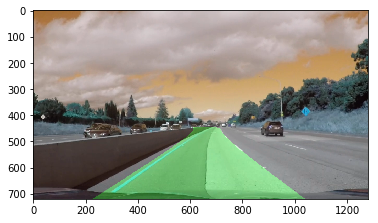

In [33]:

from moviepy.editor import VideoFileClip
challenge_input = '../challenge_video.mp4'
challenge_output = '../challenge_solution.mp4'
# challenge_output = 'test_videos_output/challenge.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip(challenge_input).subclip(0,10)
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

left curvature is:  901.061737241  pixels, e.g,  259.476036295  meters
right curvature is:  1695.25893619  pixels, e.g,  318.334658332  meters
[MoviePy] >>>> Building video ../harder_challenge_solution.mp4
[MoviePy] Writing video ../harder_challenge_solution.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

left curvature is:  901.061737241  pixels, e.g,  259.476036295  meters
right curvature is:  1695.25893619  pixels, e.g,  318.334658332  meters


  0%|▎                                                                                 | 1/251 [00:00<01:13,  3.42it/s]

left curvature is:  333.652031151  pixels, e.g,  109.417454548  meters
right curvature is:  1412.00108331  pixels, e.g,  403.24462214  meters


  1%|▋                                                                                 | 2/251 [00:00<01:09,  3.60it/s]

left curvature is:  369.957557921  pixels, e.g,  119.924412322  meters
right curvature is:  555.140791737  pixels, e.g,  178.825761368  meters


  1%|▉                                                                                 | 3/251 [00:00<01:07,  3.70it/s]

left curvature is:  383.494402282  pixels, e.g,  122.919152192  meters
right curvature is:  597.631076643  pixels, e.g,  191.459587434  meters


  2%|█▎                                                                                | 4/251 [00:01<01:05,  3.76it/s]

left curvature is:  402.734793517  pixels, e.g,  127.231076155  meters
right curvature is:  673.682899563  pixels, e.g,  211.722214777  meters


  2%|█▋                                                                                | 5/251 [00:01<01:03,  3.86it/s]

left curvature is:  422.378385283  pixels, e.g,  131.193537214  meters
right curvature is:  2579.91793842  pixels, e.g,  554.598620238  meters


  2%|█▉                                                                                | 6/251 [00:01<01:04,  3.82it/s]

left curvature is:  462.644909127  pixels, e.g,  140.544235479  meters
right curvature is:  1244.63950057  pixels, e.g,  148.772104773  meters


  3%|██▎                                                                               | 7/251 [00:01<01:02,  3.93it/s]

left curvature is:  1585.38126465  pixels, e.g,  246.762084381  meters
right curvature is:  677.263317356  pixels, e.g,  205.165037439  meters


  3%|██▌                                                                               | 8/251 [00:02<01:01,  3.98it/s]

left curvature is:  1379.86494616  pixels, e.g,  215.563418998  meters
right curvature is:  6951.51816168  pixels, e.g,  1543.91098369  meters


  4%|██▉                                                                               | 9/251 [00:02<00:58,  4.15it/s]

left curvature is:  1320.16007794  pixels, e.g,  207.50286563  meters
right curvature is:  1177.06219087  pixels, e.g,  138.084423866  meters


  4%|███▏                                                                             | 10/251 [00:02<00:59,  4.05it/s]

left curvature is:  1279.4747519  pixels, e.g,  189.830756753  meters
right curvature is:  5873.04659432  pixels, e.g,  1149.03289769  meters


  4%|███▌                                                                             | 11/251 [00:02<00:59,  4.07it/s]

left curvature is:  1299.30503432  pixels, e.g,  190.028770774  meters
right curvature is:  1221.85030487  pixels, e.g,  121.205884339  meters


  5%|███▊                                                                             | 12/251 [00:02<00:57,  4.13it/s]

left curvature is:  1394.28635208  pixels, e.g,  205.527575926  meters
right curvature is:  1103.49370539  pixels, e.g,  123.010173362  meters


  5%|████▏                                                                            | 13/251 [00:03<00:57,  4.16it/s]

left curvature is:  1314.03544556  pixels, e.g,  180.127351669  meters
right curvature is:  1104.88918894  pixels, e.g,  116.167711558  meters


  6%|████▌                                                                            | 14/251 [00:03<00:55,  4.27it/s]

left curvature is:  1251.28851708  pixels, e.g,  165.361460172  meters
right curvature is:  1084.13825824  pixels, e.g,  112.109564447  meters


  6%|████▊                                                                            | 15/251 [00:03<00:54,  4.32it/s]

left curvature is:  1197.83219784  pixels, e.g,  149.307930469  meters
right curvature is:  1116.90449136  pixels, e.g,  101.398698502  meters


  6%|█████▏                                                                           | 16/251 [00:03<00:56,  4.19it/s]

left curvature is:  1136.31570776  pixels, e.g,  140.201534911  meters
right curvature is:  1986.82303667  pixels, e.g,  608.05480069  meters


  7%|█████▍                                                                           | 17/251 [00:04<00:55,  4.24it/s]

left curvature is:  1084.25769564  pixels, e.g,  121.467876547  meters
right curvature is:  1664.14987571  pixels, e.g,  495.901432243  meters


  7%|█████▊                                                                           | 18/251 [00:04<00:53,  4.35it/s]

left curvature is:  1063.36236936  pixels, e.g,  116.742072293  meters
right curvature is:  1391.83944772  pixels, e.g,  395.455981267  meters


  8%|██████▏                                                                          | 19/251 [00:04<00:54,  4.29it/s]

left curvature is:  1055.98029116  pixels, e.g,  126.905573739  meters
right curvature is:  2057.39420953  pixels, e.g,  648.010033071  meters


  8%|██████▍                                                                          | 20/251 [00:04<00:53,  4.34it/s]

left curvature is:  1093.84286754  pixels, e.g,  127.594344286  meters
right curvature is:  1647.5178251  pixels, e.g,  444.458312653  meters


  8%|██████▊                                                                          | 21/251 [00:05<00:52,  4.39it/s]

left curvature is:  1073.00004992  pixels, e.g,  115.110406622  meters
right curvature is:  1410.62123513  pixels, e.g,  348.341118747  meters


  9%|███████                                                                          | 22/251 [00:05<00:51,  4.43it/s]

left curvature is:  1091.33266065  pixels, e.g,  113.403755336  meters
right curvature is:  1294.262174  pixels, e.g,  347.214958322  meters


  9%|███████▍                                                                         | 23/251 [00:05<00:53,  4.29it/s]

left curvature is:  1097.55974026  pixels, e.g,  113.414534188  meters
right curvature is:  1348.20497869  pixels, e.g,  318.18337946  meters


 10%|███████▋                                                                         | 24/251 [00:05<00:52,  4.34it/s]

left curvature is:  1100.38581812  pixels, e.g,  118.431211863  meters
right curvature is:  1311.14868606  pixels, e.g,  295.082122497  meters


 10%|████████                                                                         | 25/251 [00:05<00:52,  4.31it/s]

left curvature is:  1079.14237099  pixels, e.g,  117.083945681  meters
right curvature is:  1226.37025795  pixels, e.g,  279.438924341  meters


 10%|████████▍                                                                        | 26/251 [00:06<00:50,  4.42it/s]

left curvature is:  1101.22427717  pixels, e.g,  125.017516406  meters
right curvature is:  1202.53386944  pixels, e.g,  269.503581585  meters


 11%|████████▋                                                                        | 27/251 [00:06<00:52,  4.29it/s]

left curvature is:  1110.98887545  pixels, e.g,  128.129924748  meters
right curvature is:  1202.46429456  pixels, e.g,  294.152610572  meters


 11%|█████████                                                                        | 28/251 [00:06<00:54,  4.13it/s]

left curvature is:  1104.09818083  pixels, e.g,  126.766482727  meters
right curvature is:  1343.77245772  pixels, e.g,  359.820477176  meters


 12%|█████████▎                                                                       | 29/251 [00:06<00:55,  4.02it/s]

left curvature is:  1105.81993072  pixels, e.g,  127.566221451  meters
right curvature is:  1201.00107115  pixels, e.g,  315.13006156  meters


 12%|█████████▋                                                                       | 30/251 [00:07<00:55,  3.95it/s]

left curvature is:  1099.57415325  pixels, e.g,  127.317518798  meters
right curvature is:  1558.34321404  pixels, e.g,  130.601149707  meters


 12%|██████████                                                                       | 31/251 [00:07<00:53,  4.11it/s]

left curvature is:  2019.3242041  pixels, e.g,  407.248231669  meters
right curvature is:  1309.49972202  pixels, e.g,  404.418479381  meters


 13%|██████████▎                                                                      | 32/251 [00:07<00:51,  4.25it/s]

left curvature is:  2868.1570163  pixels, e.g,  552.845624389  meters
right curvature is:  1326.04463304  pixels, e.g,  138.191465494  meters


 13%|██████████▋                                                                      | 33/251 [00:07<00:50,  4.33it/s]

left curvature is:  381.405257275  pixels, e.g,  103.573357746  meters
right curvature is:  1378.43356765  pixels, e.g,  120.013012175  meters


 14%|██████████▉                                                                      | 34/251 [00:08<00:50,  4.30it/s]

left curvature is:  274.086913688  pixels, e.g,  80.7254364837  meters
right curvature is:  1385.52618743  pixels, e.g,  111.985790115  meters


 14%|███████████▎                                                                     | 35/251 [00:08<00:48,  4.44it/s]

left curvature is:  1125.92861194  pixels, e.g,  132.990532211  meters
right curvature is:  1244.99092266  pixels, e.g,  112.170892486  meters


 14%|███████████▌                                                                     | 36/251 [00:08<00:47,  4.52it/s]

left curvature is:  146.479249901  pixels, e.g,  48.003021894  meters
right curvature is:  1176.84081442  pixels, e.g,  107.24405755  meters


 15%|███████████▉                                                                     | 37/251 [00:08<00:50,  4.26it/s]

left curvature is:  126.530506228  pixels, e.g,  38.9160239455  meters
right curvature is:  1174.31006792  pixels, e.g,  100.270063969  meters


 15%|████████████▎                                                                    | 38/251 [00:09<00:49,  4.31it/s]

left curvature is:  1621.25467821  pixels, e.g,  242.024515603  meters
right curvature is:  984.021502709  pixels, e.g,  104.402848145  meters


 16%|████████████▌                                                                    | 39/251 [00:09<00:49,  4.28it/s]

left curvature is:  1392.70806166  pixels, e.g,  203.882566064  meters
right curvature is:  845.485435034  pixels, e.g,  109.312595149  meters


 16%|████████████▉                                                                    | 40/251 [00:09<00:48,  4.31it/s]

left curvature is:  1200.27104932  pixels, e.g,  173.514748091  meters
right curvature is:  725.938147215  pixels, e.g,  121.056412232  meters


 16%|█████████████▏                                                                   | 41/251 [00:09<00:48,  4.31it/s]

left curvature is:  1137.26282859  pixels, e.g,  161.736716338  meters
right curvature is:  672.556536762  pixels, e.g,  127.264522947  meters


 17%|█████████████▌                                                                   | 42/251 [00:09<00:48,  4.33it/s]

left curvature is:  1128.84604348  pixels, e.g,  155.707005975  meters
right curvature is:  622.430229527  pixels, e.g,  121.220942446  meters


 17%|█████████████▉                                                                   | 43/251 [00:10<00:50,  4.09it/s]

left curvature is:  4352.08483573  pixels, e.g,  762.648561829  meters
right curvature is:  567.900531639  pixels, e.g,  119.047774167  meters


 18%|██████████████▏                                                                  | 44/251 [00:10<00:52,  3.95it/s]

left curvature is:  3594.60338542  pixels, e.g,  614.135656941  meters
right curvature is:  523.687651017  pixels, e.g,  119.818657983  meters


 18%|██████████████▌                                                                  | 45/251 [00:10<00:50,  4.05it/s]

left curvature is:  11139.4150395  pixels, e.g,  1958.8705777  meters
right curvature is:  482.016787188  pixels, e.g,  109.422813716  meters


 18%|██████████████▊                                                                  | 46/251 [00:11<00:50,  4.05it/s]

left curvature is:  2453.9146385  pixels, e.g,  389.722892832  meters
right curvature is:  456.730039924  pixels, e.g,  95.9376957031  meters


 19%|███████████████▏                                                                 | 47/251 [00:11<00:48,  4.17it/s]

left curvature is:  2376.47985592  pixels, e.g,  363.796324661  meters
right curvature is:  438.351427993  pixels, e.g,  83.7111500033  meters


 19%|███████████████▍                                                                 | 48/251 [00:11<00:48,  4.19it/s]

left curvature is:  2345.81455811  pixels, e.g,  351.887901197  meters
right curvature is:  449.323431251  pixels, e.g,  72.0260687615  meters


 20%|███████████████▊                                                                 | 49/251 [00:11<00:47,  4.26it/s]

left curvature is:  2464.85680366  pixels, e.g,  370.434477662  meters
right curvature is:  480.533217107  pixels, e.g,  74.7509613998  meters


 20%|████████████████▏                                                                | 50/251 [00:11<00:47,  4.28it/s]

left curvature is:  2137.85060758  pixels, e.g,  292.704854662  meters
right curvature is:  804.30846642  pixels, e.g,  74.9093549517  meters


 20%|████████████████▍                                                                | 51/251 [00:12<00:47,  4.20it/s]

left curvature is:  1731.71689111  pixels, e.g,  220.942961265  meters
right curvature is:  1668.57553346  pixels, e.g,  498.399951497  meters


 21%|████████████████▊                                                                | 52/251 [00:12<00:46,  4.29it/s]

left curvature is:  1565.19879022  pixels, e.g,  180.529013658  meters
right curvature is:  1504.34871095  pixels, e.g,  465.498101147  meters


 21%|█████████████████                                                                | 53/251 [00:12<00:46,  4.23it/s]

left curvature is:  1348.53236693  pixels, e.g,  141.435939032  meters
right curvature is:  899.242398927  pixels, e.g,  243.779249632  meters


 22%|█████████████████▍                                                               | 54/251 [00:12<00:45,  4.29it/s]

left curvature is:  1382.45619461  pixels, e.g,  157.400446138  meters
right curvature is:  849.185468816  pixels, e.g,  235.19082995  meters


 22%|█████████████████▋                                                               | 55/251 [00:13<00:46,  4.26it/s]

left curvature is:  1397.77500749  pixels, e.g,  179.19068682  meters
right curvature is:  583.972845943  pixels, e.g,  143.93736029  meters


 22%|██████████████████                                                               | 56/251 [00:13<00:45,  4.29it/s]

left curvature is:  1399.67759948  pixels, e.g,  201.535960597  meters
right curvature is:  509.75692705  pixels, e.g,  124.52218801  meters


 23%|██████████████████▍                                                              | 57/251 [00:13<00:44,  4.32it/s]

left curvature is:  1345.35840145  pixels, e.g,  208.595073484  meters
right curvature is:  1153.46953643  pixels, e.g,  314.430604976  meters


 23%|██████████████████▋                                                              | 58/251 [00:13<00:43,  4.43it/s]

left curvature is:  1287.2261394  pixels, e.g,  204.042138649  meters
right curvature is:  564.176189193  pixels, e.g,  145.711150733  meters


 24%|███████████████████                                                              | 59/251 [00:13<00:43,  4.42it/s]

left curvature is:  1256.42672069  pixels, e.g,  213.08820114  meters
right curvature is:  575.074529604  pixels, e.g,  161.409062415  meters


 24%|███████████████████▎                                                             | 60/251 [00:14<00:42,  4.45it/s]

left curvature is:  1338.81170311  pixels, e.g,  259.668281014  meters
right curvature is:  1521.9227167  pixels, e.g,  489.165247006  meters


 24%|███████████████████▋                                                             | 61/251 [00:14<00:42,  4.50it/s]

left curvature is:  805.962436937  pixels, e.g,  104.845820624  meters
right curvature is:  1771.32045266  pixels, e.g,  549.344812087  meters


 25%|████████████████████                                                             | 62/251 [00:14<00:41,  4.59it/s]

left curvature is:  4545.04634105  pixels, e.g,  1463.89654687  meters
right curvature is:  9172.24228889  pixels, e.g,  2968.75360729  meters


 25%|████████████████████▎                                                            | 63/251 [00:14<00:41,  4.55it/s]

left curvature is:  3905.05654108  pixels, e.g,  1251.9258907  meters
right curvature is:  1085.63750373  pixels, e.g,  356.58127197  meters


 25%|████████████████████▋                                                            | 64/251 [00:15<00:40,  4.63it/s]

left curvature is:  29296.1113657  pixels, e.g,  9104.87946523  meters
right curvature is:  985.731069938  pixels, e.g,  281.386110686  meters


 26%|████████████████████▉                                                            | 65/251 [00:15<00:40,  4.55it/s]

left curvature is:  8101.259179  pixels, e.g,  2639.45955377  meters
right curvature is:  1213.81849491  pixels, e.g,  388.515621144  meters


 26%|█████████████████████▎                                                           | 66/251 [00:15<00:41,  4.45it/s]

left curvature is:  1196.93940688  pixels, e.g,  349.239712439  meters
right curvature is:  767.029013991  pixels, e.g,  217.558366463  meters


 27%|█████████████████████▌                                                           | 67/251 [00:15<00:40,  4.50it/s]

left curvature is:  1260.50232646  pixels, e.g,  401.730854796  meters
right curvature is:  1228.43294988  pixels, e.g,  379.441146001  meters


 27%|█████████████████████▉                                                           | 68/251 [00:15<00:40,  4.54it/s]

left curvature is:  13051.0074878  pixels, e.g,  4258.58685786  meters
right curvature is:  1348.01255108  pixels, e.g,  421.558773269  meters


 27%|██████████████████████▎                                                          | 69/251 [00:16<00:41,  4.42it/s]

left curvature is:  172315.260119  pixels, e.g,  56512.9901645  meters
right curvature is:  3232.83022451  pixels, e.g,  1060.00776716  meters


 28%|██████████████████████▌                                                          | 70/251 [00:16<00:40,  4.48it/s]

left curvature is:  12976.2905206  pixels, e.g,  4260.70549555  meters
right curvature is:  869.112002441  pixels, e.g,  260.395905859  meters


 28%|██████████████████████▉                                                          | 71/251 [00:16<00:40,  4.47it/s]

left curvature is:  1277.16126701  pixels, e.g,  375.080225931  meters
right curvature is:  811.460967207  pixels, e.g,  255.285447724  meters


 29%|███████████████████████▏                                                         | 72/251 [00:16<00:40,  4.47it/s]

left curvature is:  777.67330029  pixels, e.g,  178.83542796  meters
right curvature is:  772.549002485  pixels, e.g,  164.987727621  meters


 29%|███████████████████████▌                                                         | 73/251 [00:17<00:39,  4.48it/s]

left curvature is:  2032.50573601  pixels, e.g,  665.352120267  meters
right curvature is:  607.928476034  pixels, e.g,  115.071113447  meters


 29%|███████████████████████▉                                                         | 74/251 [00:17<00:41,  4.29it/s]

left curvature is:  1954.09162003  pixels, e.g,  640.194872082  meters
right curvature is:  1945.59605663  pixels, e.g,  622.25109158  meters


 30%|████████████████████████▏                                                        | 75/251 [00:17<00:41,  4.27it/s]

left curvature is:  1236.59874055  pixels, e.g,  335.413620465  meters
right curvature is:  1397.53466199  pixels, e.g,  437.836333913  meters


 30%|████████████████████████▌                                                        | 76/251 [00:17<00:43,  4.01it/s]

left curvature is:  3843.65899209  pixels, e.g,  1114.96439292  meters
right curvature is:  1274.87093078  pixels, e.g,  196.439198958  meters


 31%|████████████████████████▊                                                        | 77/251 [00:18<00:44,  3.92it/s]

left curvature is:  1733.08091068  pixels, e.g,  430.314750566  meters
right curvature is:  1460.7558414  pixels, e.g,  438.974206275  meters


 31%|█████████████████████████▏                                                       | 78/251 [00:18<00:44,  3.88it/s]

left curvature is:  4013.16380676  pixels, e.g,  1257.18074789  meters
right curvature is:  4913.79191569  pixels, e.g,  1612.74264534  meters


 31%|█████████████████████████▍                                                       | 79/251 [00:18<00:45,  3.81it/s]

left curvature is:  638.85405697  pixels, e.g,  208.915469149  meters
right curvature is:  1089.87625076  pixels, e.g,  308.226381611  meters


 32%|█████████████████████████▊                                                       | 80/251 [00:18<00:45,  3.79it/s]

left curvature is:  626.859912217  pixels, e.g,  182.952257153  meters
right curvature is:  747.750873983  pixels, e.g,  244.515642261  meters


 32%|██████████████████████████▏                                                      | 81/251 [00:19<00:45,  3.70it/s]

left curvature is:  892.691608401  pixels, e.g,  184.432640396  meters
right curvature is:  947.504084007  pixels, e.g,  164.543954444  meters


 33%|██████████████████████████▍                                                      | 82/251 [00:19<00:49,  3.43it/s]

left curvature is:  15879.7428983  pixels, e.g,  5058.00433376  meters
right curvature is:  1824.73442312  pixels, e.g,  563.907689697  meters


 33%|██████████████████████████▊                                                      | 83/251 [00:19<00:48,  3.43it/s]

left curvature is:  46849.3024511  pixels, e.g,  15217.3533186  meters
right curvature is:  6936.27929668  pixels, e.g,  2278.13108641  meters


 33%|███████████████████████████                                                      | 84/251 [00:20<00:51,  3.27it/s]

left curvature is:  788.268337088  pixels, e.g,  79.9169882342  meters
right curvature is:  8434.11440181  pixels, e.g,  2558.40086194  meters


 34%|███████████████████████████▍                                                     | 85/251 [00:20<01:04,  2.58it/s]

left curvature is:  1007.00411446  pixels, e.g,  184.023750288  meters
right curvature is:  7042.49028328  pixels, e.g,  1909.24792162  meters


 34%|███████████████████████████▊                                                     | 86/251 [00:21<00:57,  2.86it/s]

left curvature is:  1106.84192831  pixels, e.g,  253.529664602  meters
right curvature is:  2157.70761604  pixels, e.g,  561.5556823  meters


 35%|████████████████████████████                                                     | 87/251 [00:21<00:54,  3.02it/s]

left curvature is:  1550.85521287  pixels, e.g,  423.484959153  meters
right curvature is:  1376.04942081  pixels, e.g,  302.164276306  meters


 35%|████████████████████████████▍                                                    | 88/251 [00:21<00:52,  3.10it/s]

left curvature is:  1207.59451242  pixels, e.g,  377.402752449  meters
right curvature is:  724.288421849  pixels, e.g,  185.945151266  meters


 35%|████████████████████████████▋                                                    | 89/251 [00:21<00:54,  2.98it/s]

left curvature is:  1359.28199964  pixels, e.g,  418.022329305  meters
right curvature is:  755.070931138  pixels, e.g,  200.053609322  meters


 36%|█████████████████████████████                                                    | 90/251 [00:22<00:51,  3.12it/s]

left curvature is:  934.141880638  pixels, e.g,  256.699276948  meters
right curvature is:  976.034881618  pixels, e.g,  303.810829588  meters


 36%|█████████████████████████████▎                                                   | 91/251 [00:22<00:48,  3.29it/s]

left curvature is:  2034.53972179  pixels, e.g,  661.757857519  meters
right curvature is:  2179.71707481  pixels, e.g,  715.902849478  meters


 37%|█████████████████████████████▋                                                   | 92/251 [00:22<00:45,  3.50it/s]

left curvature is:  17114.2852423  pixels, e.g,  5618.94248085  meters
right curvature is:  1563.26392003  pixels, e.g,  458.774325175  meters


 37%|██████████████████████████████                                                   | 93/251 [00:23<00:43,  3.65it/s]

left curvature is:  14827.146498  pixels, e.g,  4825.72628151  meters
right curvature is:  2288.58958543  pixels, e.g,  670.491068535  meters


 37%|██████████████████████████████▎                                                  | 94/251 [00:23<00:41,  3.76it/s]

left curvature is:  953.351759681  pixels, e.g,  285.162414659  meters
right curvature is:  6816.40194064  pixels, e.g,  2151.13037363  meters


 38%|██████████████████████████████▋                                                  | 95/251 [00:23<00:40,  3.88it/s]

left curvature is:  861.378404739  pixels, e.g,  268.690871501  meters
right curvature is:  665.566135484  pixels, e.g,  196.628868258  meters


 38%|██████████████████████████████▉                                                  | 96/251 [00:23<00:39,  3.88it/s]

left curvature is:  1430.36059829  pixels, e.g,  436.732197426  meters
right curvature is:  492.817323682  pixels, e.g,  141.439222882  meters


 39%|███████████████████████████████▎                                                 | 97/251 [00:24<00:38,  3.96it/s]

left curvature is:  13152.44861  pixels, e.g,  4319.95622701  meters
right curvature is:  5738.191752  pixels, e.g,  1880.85238259  meters


 39%|███████████████████████████████▋                                                 | 98/251 [00:24<00:38,  4.00it/s]

left curvature is:  3241.39626342  pixels, e.g,  1030.21253255  meters
right curvature is:  3700.27562182  pixels, e.g,  1210.37985398  meters


 39%|███████████████████████████████▉                                                 | 99/251 [00:24<00:37,  4.06it/s]

left curvature is:  4362.13873219  pixels, e.g,  1341.11744111  meters
right curvature is:  1194.46065866  pixels, e.g,  378.400085276  meters


 40%|███████████████████████████████▊                                                | 100/251 [00:24<00:36,  4.13it/s]

left curvature is:  2287.64523362  pixels, e.g,  713.866526925  meters
right curvature is:  1076.75950791  pixels, e.g,  336.61363463  meters


 40%|████████████████████████████████▏                                               | 101/251 [00:25<00:37,  3.98it/s]

left curvature is:  526.614818055  pixels, e.g,  160.279352573  meters
right curvature is:  1067.56003449  pixels, e.g,  301.466880381  meters


 41%|████████████████████████████████▌                                               | 102/251 [00:25<00:38,  3.92it/s]

left curvature is:  538.689339492  pixels, e.g,  168.797960727  meters
right curvature is:  853.124156431  pixels, e.g,  231.462826613  meters


 41%|████████████████████████████████▊                                               | 103/251 [00:25<00:38,  3.89it/s]

left curvature is:  1400.44570013  pixels, e.g,  455.060026272  meters
right curvature is:  814.762539499  pixels, e.g,  107.445589624  meters


 41%|█████████████████████████████████▏                                              | 104/251 [00:25<00:37,  3.90it/s]

left curvature is:  2030.00686787  pixels, e.g,  493.987313875  meters
right curvature is:  3901.58484257  pixels, e.g,  1264.31495288  meters


 42%|█████████████████████████████████▍                                              | 105/251 [00:26<00:36,  4.05it/s]

left curvature is:  684.946880225  pixels, e.g,  205.716678809  meters
right curvature is:  991.600543202  pixels, e.g,  306.318047975  meters


 42%|█████████████████████████████████▊                                              | 106/251 [00:26<00:35,  4.08it/s]

left curvature is:  468.186705409  pixels, e.g,  153.305369015  meters
right curvature is:  229.838665144  pixels, e.g,  47.1979762638  meters


 43%|██████████████████████████████████                                              | 107/251 [00:26<00:35,  4.09it/s]

left curvature is:  568.108577555  pixels, e.g,  184.705167105  meters
right curvature is:  2299.50718476  pixels, e.g,  754.945625153  meters


 43%|██████████████████████████████████▍                                             | 108/251 [00:26<00:35,  4.07it/s]

left curvature is:  791.871245324  pixels, e.g,  259.713435338  meters
right curvature is:  285.443151778  pixels, e.g,  81.1858382892  meters


 43%|██████████████████████████████████▋                                             | 109/251 [00:26<00:34,  4.14it/s]

left curvature is:  811.242466221  pixels, e.g,  260.920720217  meters
right curvature is:  15930.6738333  pixels, e.g,  5191.2407846  meters


 44%|███████████████████████████████████                                             | 110/251 [00:27<00:34,  4.14it/s]

left curvature is:  920.37279129  pixels, e.g,  283.459378494  meters
right curvature is:  1278.59715156  pixels, e.g,  417.79809106  meters


 44%|███████████████████████████████████▍                                            | 111/251 [00:27<00:33,  4.16it/s]

left curvature is:  4101.41792903  pixels, e.g,  1242.44020028  meters
right curvature is:  373.349044928  pixels, e.g,  115.148334738  meters


 45%|███████████████████████████████████▋                                            | 112/251 [00:27<00:33,  4.17it/s]

left curvature is:  520.936411096  pixels, e.g,  141.669870369  meters
right curvature is:  270.438783917  pixels, e.g,  83.7874124273  meters


 45%|████████████████████████████████████                                            | 113/251 [00:27<00:33,  4.17it/s]

left curvature is:  722.452692366  pixels, e.g,  161.677458594  meters
right curvature is:  230.877549041  pixels, e.g,  62.2687774764  meters


 45%|████████████████████████████████████▎                                           | 114/251 [00:28<00:32,  4.21it/s]

left curvature is:  773.678425655  pixels, e.g,  180.937004268  meters
right curvature is:  669.98149122  pixels, e.g,  28.3393943457  meters


 46%|████████████████████████████████████▋                                           | 115/251 [00:28<00:33,  4.10it/s]

left curvature is:  1137.78600644  pixels, e.g,  359.659711716  meters
right curvature is:  2217.33994245  pixels, e.g,  19.7958700962  meters


 46%|████████████████████████████████████▉                                           | 116/251 [00:28<00:32,  4.11it/s]

left curvature is:  1308.16957245  pixels, e.g,  369.407226539  meters
right curvature is:  1090.56288721  pixels, e.g,  198.582263842  meters


 47%|█████████████████████████████████████▎                                          | 117/251 [00:28<00:32,  4.18it/s]

left curvature is:  1526.8744734  pixels, e.g,  308.778135054  meters
right curvature is:  1868.98796766  pixels, e.g,  507.730119438  meters


 47%|█████████████████████████████████████▌                                          | 118/251 [00:29<00:32,  4.11it/s]

left curvature is:  804.910817236  pixels, e.g,  113.707392526  meters
right curvature is:  2084.36593679  pixels, e.g,  582.245225203  meters


 47%|█████████████████████████████████████▉                                          | 119/251 [00:29<00:32,  4.04it/s]

left curvature is:  785.430594304  pixels, e.g,  222.542626806  meters
right curvature is:  1009.28459781  pixels, e.g,  210.025373792  meters


 48%|██████████████████████████████████████▏                                         | 120/251 [00:29<00:33,  3.89it/s]

left curvature is:  558.558148346  pixels, e.g,  96.7140975666  meters
right curvature is:  1436.46540548  pixels, e.g,  441.665353418  meters


 48%|██████████████████████████████████████▌                                         | 121/251 [00:30<00:36,  3.60it/s]

left curvature is:  578.676899378  pixels, e.g,  65.384665357  meters
right curvature is:  2242.55661505  pixels, e.g,  711.850243226  meters


 49%|██████████████████████████████████████▉                                         | 122/251 [00:30<00:44,  2.92it/s]

left curvature is:  622.960259939  pixels, e.g,  44.4548343764  meters
right curvature is:  569.33778689  pixels, e.g,  174.618096747  meters


 49%|███████████████████████████████████████▏                                        | 123/251 [00:30<00:40,  3.14it/s]

left curvature is:  588.755905997  pixels, e.g,  38.5536009081  meters
right curvature is:  1075.73731925  pixels, e.g,  258.793944724  meters


 49%|███████████████████████████████████████▌                                        | 124/251 [00:31<00:38,  3.28it/s]

left curvature is:  599.320361141  pixels, e.g,  33.1858532683  meters
right curvature is:  913.886465609  pixels, e.g,  252.960425903  meters


 50%|███████████████████████████████████████▊                                        | 125/251 [00:31<00:37,  3.40it/s]

left curvature is:  584.024190909  pixels, e.g,  30.7110030959  meters
right curvature is:  527.651037096  pixels, e.g,  124.517583222  meters


 50%|████████████████████████████████████████▏                                       | 126/251 [00:31<00:35,  3.48it/s]

left curvature is:  546.568818007  pixels, e.g,  28.5156945339  meters
right curvature is:  403.085259289  pixels, e.g,  83.5441009142  meters


 51%|████████████████████████████████████████▍                                       | 127/251 [00:31<00:34,  3.60it/s]

left curvature is:  491.162329636  pixels, e.g,  28.5400725908  meters
right curvature is:  362.012160604  pixels, e.g,  92.439349374  meters


 51%|████████████████████████████████████████▊                                       | 128/251 [00:32<00:33,  3.68it/s]

left curvature is:  438.189696177  pixels, e.g,  27.5167560427  meters
right curvature is:  311.333709028  pixels, e.g,  94.2862681753  meters


 51%|█████████████████████████████████████████                                       | 129/251 [00:32<00:32,  3.76it/s]

left curvature is:  401.148366344  pixels, e.g,  26.4531237791  meters
right curvature is:  354.660483037  pixels, e.g,  116.128823251  meters


 52%|█████████████████████████████████████████▍                                      | 130/251 [00:32<00:31,  3.82it/s]

left curvature is:  351.773519539  pixels, e.g,  25.7203255092  meters
right curvature is:  265.479613206  pixels, e.g,  86.3847212968  meters


 52%|█████████████████████████████████████████▊                                      | 131/251 [00:32<00:30,  3.87it/s]

left curvature is:  282.594840903  pixels, e.g,  26.4319297355  meters
right curvature is:  173.882662678  pixels, e.g,  57.0988515032  meters


 53%|██████████████████████████████████████████                                      | 132/251 [00:33<00:30,  3.89it/s]

left curvature is:  688.861388726  pixels, e.g,  216.486134141  meters
right curvature is:  132.464021226  pixels, e.g,  43.5025427137  meters


 53%|██████████████████████████████████████████▍                                     | 133/251 [00:33<00:29,  3.97it/s]

left curvature is:  1256.79568438  pixels, e.g,  355.419208  meters
right curvature is:  200.976148761  pixels, e.g,  12.081245185  meters


 53%|██████████████████████████████████████████▋                                     | 134/251 [00:33<00:29,  4.01it/s]

left curvature is:  3902.32509777  pixels, e.g,  965.875695145  meters
right curvature is:  158.613682781  pixels, e.g,  11.9512092636  meters


 54%|███████████████████████████████████████████                                     | 135/251 [00:33<00:30,  3.86it/s]

left curvature is:  183.395149581  pixels, e.g,  22.0803538033  meters
right curvature is:  124.154400444  pixels, e.g,  11.8883458384  meters


 54%|███████████████████████████████████████████▎                                    | 136/251 [00:34<00:29,  3.87it/s]

left curvature is:  169.745882409  pixels, e.g,  21.4955058201  meters
right curvature is:  141.027399732  pixels, e.g,  10.4815777508  meters


 55%|███████████████████████████████████████████▋                                    | 137/251 [00:34<00:29,  3.92it/s]

left curvature is:  115.965102035  pixels, e.g,  31.6539407878  meters
right curvature is:  118.209163978  pixels, e.g,  10.1177334784  meters


 55%|███████████████████████████████████████████▉                                    | 138/251 [00:34<00:28,  3.94it/s]

left curvature is:  140.233272951  pixels, e.g,  46.058208733  meters
right curvature is:  85.6439009407  pixels, e.g,  10.2109041292  meters


 55%|████████████████████████████████████████████▎                                   | 139/251 [00:34<00:28,  3.94it/s]

left curvature is:  1271.66007751  pixels, e.g,  187.914289377  meters
right curvature is:  977.784178695  pixels, e.g,  43.5707822954  meters


 56%|████████████████████████████████████████████▌                                   | 140/251 [00:35<00:27,  4.02it/s]

left curvature is:  1365.706724  pixels, e.g,  192.084430214  meters
right curvature is:  1026.43780819  pixels, e.g,  39.2008573977  meters


 56%|████████████████████████████████████████████▉                                   | 141/251 [00:35<00:31,  3.50it/s]

left curvature is:  1100.89447262  pixels, e.g,  135.677141435  meters
right curvature is:  2077.15125982  pixels, e.g,  14.790879491  meters


 57%|█████████████████████████████████████████████▎                                  | 142/251 [00:36<00:39,  2.79it/s]

left curvature is:  1306.75887028  pixels, e.g,  162.732684064  meters
right curvature is:  1157.76211061  pixels, e.g,  30.1293874722  meters


 57%|█████████████████████████████████████████████▌                                  | 143/251 [00:36<00:35,  3.04it/s]

left curvature is:  77.0927048822  pixels, e.g,  23.36097823  meters
right curvature is:  2210.55089976  pixels, e.g,  13.9478807894  meters


 57%|█████████████████████████████████████████████▉                                  | 144/251 [00:36<00:34,  3.13it/s]

left curvature is:  1134.50423047  pixels, e.g,  116.459961012  meters
right curvature is:  2210.43199917  pixels, e.g,  13.6289259068  meters


 58%|██████████████████████████████████████████████▏                                 | 145/251 [00:36<00:30,  3.43it/s]

left curvature is:  73.7251793933  pixels, e.g,  24.0765341895  meters
right curvature is:  1371.19173233  pixels, e.g,  15.1304878983  meters


 58%|██████████████████████████████████████████████▌                                 | 146/251 [00:37<00:28,  3.67it/s]

left curvature is:  868.715043875  pixels, e.g,  61.646076761  meters
right curvature is:  2131.67501638  pixels, e.g,  13.3918576628  meters


 59%|██████████████████████████████████████████████▊                                 | 147/251 [00:37<00:26,  3.89it/s]

left curvature is:  928.350090744  pixels, e.g,  59.850226739  meters
right curvature is:  2225.26545104  pixels, e.g,  13.1875325171  meters


 59%|███████████████████████████████████████████████▏                                | 148/251 [00:37<00:26,  3.93it/s]

left curvature is:  984.9382734  pixels, e.g,  57.2365119056  meters
right curvature is:  1945.0610784  pixels, e.g,  13.5890171063  meters


 59%|███████████████████████████████████████████████▍                                | 149/251 [00:37<00:25,  3.98it/s]

left curvature is:  980.408780714  pixels, e.g,  45.3307326497  meters
right curvature is:  1823.09389183  pixels, e.g,  13.6217685025  meters


 60%|███████████████████████████████████████████████▊                                | 150/251 [00:38<00:26,  3.87it/s]

left curvature is:  966.17448057  pixels, e.g,  37.0604816965  meters
right curvature is:  1729.94238153  pixels, e.g,  14.5354817562  meters


 60%|████████████████████████████████████████████████▏                               | 151/251 [00:38<00:26,  3.83it/s]

left curvature is:  1033.40722165  pixels, e.g,  35.3421304499  meters
right curvature is:  1893.45314318  pixels, e.g,  13.8625170138  meters


 61%|████████████████████████████████████████████████▍                               | 152/251 [00:38<00:24,  3.98it/s]

left curvature is:  538.662613264  pixels, e.g,  62.414049994  meters
right curvature is:  1213.08008761  pixels, e.g,  15.3608369721  meters


 61%|████████████████████████████████████████████████▊                               | 153/251 [00:38<00:23,  4.15it/s]

left curvature is:  1220.28521803  pixels, e.g,  36.9302169793  meters
right curvature is:  1131.08639989  pixels, e.g,  15.1432009031  meters


 61%|█████████████████████████████████████████████████                               | 154/251 [00:38<00:22,  4.26it/s]

left curvature is:  1237.44703791  pixels, e.g,  32.4061675365  meters
right curvature is:  1128.37250903  pixels, e.g,  15.1309555168  meters


 62%|█████████████████████████████████████████████████▍                              | 155/251 [00:39<00:22,  4.33it/s]

left curvature is:  1309.58094708  pixels, e.g,  29.7894518876  meters
right curvature is:  2095.89358456  pixels, e.g,  17.2311010348  meters


 62%|█████████████████████████████████████████████████▋                              | 156/251 [00:39<00:22,  4.17it/s]

left curvature is:  1364.64236397  pixels, e.g,  25.9609698429  meters
right curvature is:  1723.48584224  pixels, e.g,  17.7161804321  meters


 63%|██████████████████████████████████████████████████                              | 157/251 [00:39<00:23,  4.08it/s]

left curvature is:  40553.869742  pixels, e.g,  1829.91316915  meters
right curvature is:  1146.96840732  pixels, e.g,  13.2167537375  meters


 63%|██████████████████████████████████████████████████▎                             | 158/251 [00:39<00:22,  4.09it/s]

left curvature is:  11003.5550777  pixels, e.g,  487.249426158  meters
right curvature is:  2172.59369211  pixels, e.g,  12.9825941516  meters


 63%|██████████████████████████████████████████████████▋                             | 159/251 [00:40<00:22,  4.11it/s]

left curvature is:  12701.3262621  pixels, e.g,  452.79494441  meters
right curvature is:  1061.61377829  pixels, e.g,  13.143097157  meters


 64%|██████████████████████████████████████████████████▉                             | 160/251 [00:40<00:21,  4.25it/s]

left curvature is:  3830.3733561  pixels, e.g,  165.444506905  meters
right curvature is:  1319.52095614  pixels, e.g,  11.2019986475  meters


 64%|███████████████████████████████████████████████████▎                            | 161/251 [00:40<00:20,  4.38it/s]

left curvature is:  7096.13889387  pixels, e.g,  205.953960968  meters
right curvature is:  1549.81262566  pixels, e.g,  10.5032901805  meters


 65%|███████████████████████████████████████████████████▋                            | 162/251 [00:40<00:22,  3.94it/s]

left curvature is:  3833.18267761  pixels, e.g,  93.4954639904  meters
right curvature is:  1542.1856755  pixels, e.g,  10.4024218599  meters


 65%|███████████████████████████████████████████████████▉                            | 163/251 [00:41<00:21,  4.09it/s]

left curvature is:  3045.54088518  pixels, e.g,  71.890475162  meters
right curvature is:  1082.19091707  pixels, e.g,  11.4190265768  meters


 65%|████████████████████████████████████████████████████▎                           | 164/251 [00:41<00:20,  4.26it/s]

left curvature is:  3029.86044673  pixels, e.g,  72.8931795627  meters
right curvature is:  1374.88685184  pixels, e.g,  10.7639926137  meters


 66%|████████████████████████████████████████████████████▌                           | 165/251 [00:41<00:19,  4.41it/s]

left curvature is:  2675.21051233  pixels, e.g,  61.9730766293  meters
right curvature is:  1390.52911952  pixels, e.g,  10.8330580581  meters


 66%|████████████████████████████████████████████████████▉                           | 166/251 [00:41<00:21,  3.86it/s]

left curvature is:  3100.37982935  pixels, e.g,  63.9917229438  meters
right curvature is:  221.903221451  pixels, e.g,  3.18217362432  meters


 67%|█████████████████████████████████████████████████████▏                          | 167/251 [00:42<00:20,  4.05it/s]

left curvature is:  7994.62232586  pixels, e.g,  226.094802266  meters
right curvature is:  178.156509014  pixels, e.g,  3.14720716025  meters


 67%|█████████████████████████████████████████████████████▌                          | 168/251 [00:42<00:20,  4.14it/s]

left curvature is:  4130.50613949  pixels, e.g,  103.597577812  meters
right curvature is:  1092.9004225  pixels, e.g,  12.6038304309  meters


 67%|█████████████████████████████████████████████████████▊                          | 169/251 [00:42<00:19,  4.27it/s]

left curvature is:  7251.45341046  pixels, e.g,  201.919995781  meters
right curvature is:  1684.47507341  pixels, e.g,  4.09224254749  meters


 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:42<00:19,  4.17it/s]

left curvature is:  4741.25512801  pixels, e.g,  122.922757565  meters
right curvature is:  342.630764385  pixels, e.g,  3.16811779922  meters


 68%|██████████████████████████████████████████████████████▌                         | 171/251 [00:43<00:18,  4.27it/s]

left curvature is:  2873.38090954  pixels, e.g,  57.249272742  meters
right curvature is:  152.229674686  pixels, e.g,  3.11833725723  meters


 69%|██████████████████████████████████████████████████████▊                         | 172/251 [00:43<00:17,  4.47it/s]

left curvature is:  2245.13273303  pixels, e.g,  34.8190124295  meters
right curvature is:  1571.43775362  pixels, e.g,  4.15379653803  meters


 69%|███████████████████████████████████████████████████████▏                        | 173/251 [00:43<00:17,  4.54it/s]

left curvature is:  1833.88187594  pixels, e.g,  12.4763245245  meters
right curvature is:  55.6818124761  pixels, e.g,  3.78295048265  meters


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:43<00:16,  4.64it/s]

left curvature is:  1969.7409788  pixels, e.g,  10.8583461552  meters
right curvature is:  428.201677346  pixels, e.g,  46.954593543  meters


 70%|███████████████████████████████████████████████████████▊                        | 175/251 [00:43<00:16,  4.69it/s]

left curvature is:  2434.7926415  pixels, e.g,  9.23726564271  meters
right curvature is:  435.730643939  pixels, e.g,  33.8984568959  meters


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:44<00:16,  4.67it/s]

left curvature is:  1834.03824408  pixels, e.g,  9.25863770694  meters
right curvature is:  165.449532837  pixels, e.g,  54.3278759453  meters


 71%|████████████████████████████████████████████████████████▍                       | 177/251 [00:44<00:15,  4.73it/s]

left curvature is:  1524.7140489  pixels, e.g,  9.47631843878  meters
right curvature is:  118.1917181  pixels, e.g,  38.7168878973  meters


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:44<00:15,  4.81it/s]

left curvature is:  1181.97383669  pixels, e.g,  9.92664639252  meters
right curvature is:  485.749656109  pixels, e.g,  68.5088058568  meters


 71%|█████████████████████████████████████████████████████████                       | 179/251 [00:44<00:14,  4.81it/s]

left curvature is:  998.70940511  pixels, e.g,  10.3315428508  meters
right curvature is:  410.057551206  pixels, e.g,  74.7342751429  meters


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:44<00:14,  4.80it/s]

left curvature is:  604.871776661  pixels, e.g,  14.2902795781  meters
right curvature is:  495.409083252  pixels, e.g,  107.252833183  meters


 72%|█████████████████████████████████████████████████████████▋                      | 181/251 [00:45<00:14,  4.83it/s]

left curvature is:  573.870956277  pixels, e.g,  14.4212874878  meters
right curvature is:  548.480251751  pixels, e.g,  117.04952616  meters


 73%|██████████████████████████████████████████████████████████                      | 182/251 [00:45<00:14,  4.80it/s]

left curvature is:  559.285397677  pixels, e.g,  14.7663231204  meters
right curvature is:  259.711227819  pixels, e.g,  84.5939392214  meters


 73%|██████████████████████████████████████████████████████████▎                     | 183/251 [00:45<00:14,  4.83it/s]

left curvature is:  550.352965901  pixels, e.g,  14.7648238557  meters
right curvature is:  13322.6141006  pixels, e.g,  4278.60180216  meters


 73%|██████████████████████████████████████████████████████████▋                     | 184/251 [00:45<00:13,  4.82it/s]

left curvature is:  498.357780815  pixels, e.g,  15.6842173751  meters
right curvature is:  2623.41319587  pixels, e.g,  846.987624794  meters


 74%|██████████████████████████████████████████████████████████▉                     | 185/251 [00:45<00:13,  4.79it/s]

left curvature is:  421.394713639  pixels, e.g,  18.8064822286  meters
right curvature is:  1191.54168539  pixels, e.g,  386.165004723  meters


 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:46<00:13,  4.74it/s]

left curvature is:  1679.06118791  pixels, e.g,  550.170403427  meters
right curvature is:  672.433169105  pixels, e.g,  159.238155601  meters


 75%|███████████████████████████████████████████████████████████▌                    | 187/251 [00:46<00:13,  4.78it/s]

left curvature is:  275.792834181  pixels, e.g,  68.7283807555  meters
right curvature is:  1194.2330097  pixels, e.g,  63.340786878  meters


 75%|███████████████████████████████████████████████████████████▉                    | 188/251 [00:46<00:13,  4.76it/s]

left curvature is:  219.437678388  pixels, e.g,  35.7240736807  meters
right curvature is:  593.708916572  pixels, e.g,  67.6092416028  meters


 75%|████████████████████████████████████████████████████████████▏                   | 189/251 [00:46<00:13,  4.75it/s]

left curvature is:  402.913199346  pixels, e.g,  85.7534789003  meters
right curvature is:  507.311562842  pixels, e.g,  76.6609473122  meters


 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:46<00:12,  4.71it/s]

left curvature is:  516.977944878  pixels, e.g,  113.755145278  meters
right curvature is:  550.61258225  pixels, e.g,  97.9376437217  meters


 76%|████████████████████████████████████████████████████████████▉                   | 191/251 [00:47<00:12,  4.67it/s]

left curvature is:  1562.53243991  pixels, e.g,  503.959749209  meters
right curvature is:  651.708409326  pixels, e.g,  19.3734418635  meters


 76%|█████████████████████████████████████████████████████████████▏                  | 192/251 [00:47<00:13,  4.23it/s]

left curvature is:  848.66095235  pixels, e.g,  255.192847579  meters
right curvature is:  1238.3195266  pixels, e.g,  78.6574089711  meters


 77%|█████████████████████████████████████████████████████████████▌                  | 193/251 [00:47<00:13,  4.23it/s]

left curvature is:  1229.52782389  pixels, e.g,  366.280213499  meters
right curvature is:  871.287792173  pixels, e.g,  233.296434592  meters


 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:47<00:13,  4.15it/s]

left curvature is:  503.977660478  pixels, e.g,  92.1167859226  meters
right curvature is:  12571.4147144  pixels, e.g,  3992.72037274  meters


 78%|██████████████████████████████████████████████████████████████▏                 | 195/251 [00:48<00:13,  4.26it/s]

left curvature is:  2479.28488403  pixels, e.g,  806.536824827  meters
right curvature is:  956.227495857  pixels, e.g,  212.651144086  meters


 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:48<00:12,  4.32it/s]

left curvature is:  1028.89964123  pixels, e.g,  275.433464129  meters
right curvature is:  4448.63499874  pixels, e.g,  1455.2007578  meters


 78%|██████████████████████████████████████████████████████████████▊                 | 197/251 [00:48<00:13,  4.06it/s]

left curvature is:  2452.92104244  pixels, e.g,  738.071071877  meters
right curvature is:  1662.51295668  pixels, e.g,  442.189007476  meters


 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:48<00:13,  3.90it/s]

left curvature is:  1359.48432409  pixels, e.g,  224.536915914  meters
right curvature is:  1268.60194999  pixels, e.g,  216.924358842  meters


 79%|███████████████████████████████████████████████████████████████▍                | 199/251 [00:49<00:13,  3.75it/s]

left curvature is:  1109.07615391  pixels, e.g,  249.180931067  meters
right curvature is:  1164.23534687  pixels, e.g,  308.675628965  meters


 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:49<00:13,  3.71it/s]

left curvature is:  1078.36555906  pixels, e.g,  223.448395259  meters
right curvature is:  1379.44085381  pixels, e.g,  452.749016543  meters


 80%|████████████████████████████████████████████████████████████████                | 201/251 [00:49<00:13,  3.62it/s]

left curvature is:  845.072014886  pixels, e.g,  146.040922281  meters
right curvature is:  1945.27196935  pixels, e.g,  629.371597734  meters


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:50<00:13,  3.63it/s]

left curvature is:  739.381084148  pixels, e.g,  88.0884627776  meters
right curvature is:  519.355042696  pixels, e.g,  134.340023994  meters


 81%|████████████████████████████████████████████████████████████████▋               | 203/251 [00:50<00:12,  3.74it/s]

left curvature is:  1736.69583941  pixels, e.g,  545.459457561  meters
right curvature is:  538.259368542  pixels, e.g,  171.194198231  meters


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:50<00:12,  3.90it/s]

left curvature is:  1098.55609536  pixels, e.g,  319.069926024  meters
right curvature is:  1232.13607577  pixels, e.g,  404.269763751  meters


 82%|█████████████████████████████████████████████████████████████████▎              | 205/251 [00:50<00:11,  3.99it/s]

left curvature is:  609.683719855  pixels, e.g,  119.043747268  meters
right curvature is:  2436.17580847  pixels, e.g,  740.89268391  meters


 82%|█████████████████████████████████████████████████████████████████▋              | 206/251 [00:51<00:11,  3.88it/s]

left curvature is:  553.156843061  pixels, e.g,  111.523035145  meters
right curvature is:  485.672372604  pixels, e.g,  109.079251601  meters


 82%|█████████████████████████████████████████████████████████████████▉              | 207/251 [00:51<00:11,  3.98it/s]

left curvature is:  1583.14310033  pixels, e.g,  403.777860935  meters
right curvature is:  1756.53571189  pixels, e.g,  569.103142922  meters


 83%|██████████████████████████████████████████████████████████████████▎             | 208/251 [00:51<00:10,  3.99it/s]

left curvature is:  2656.68947018  pixels, e.g,  817.971860609  meters
right curvature is:  2862.28893302  pixels, e.g,  907.810366081  meters


 83%|██████████████████████████████████████████████████████████████████▌             | 209/251 [00:51<00:10,  3.93it/s]

left curvature is:  1742.67295742  pixels, e.g,  514.615975001  meters
right curvature is:  1871.29980134  pixels, e.g,  611.779042107  meters


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:52<00:10,  3.94it/s]

left curvature is:  6548.87274717  pixels, e.g,  2104.83895936  meters
right curvature is:  8053.86305714  pixels, e.g,  2577.06654511  meters


 84%|███████████████████████████████████████████████████████████████████▎            | 211/251 [00:52<00:10,  3.87it/s]

left curvature is:  886.061784185  pixels, e.g,  255.842964564  meters
right curvature is:  1306.39971232  pixels, e.g,  405.750993132  meters


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:52<00:10,  3.68it/s]

left curvature is:  4836.4013751  pixels, e.g,  1549.77843151  meters
right curvature is:  1742.14440205  pixels, e.g,  542.849092343  meters


 85%|███████████████████████████████████████████████████████████████████▉            | 213/251 [00:52<00:10,  3.56it/s]

left curvature is:  4156.64411373  pixels, e.g,  1322.18018021  meters
right curvature is:  2813.98718617  pixels, e.g,  890.178632538  meters


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:53<00:10,  3.43it/s]

left curvature is:  923.375340305  pixels, e.g,  200.086348051  meters
right curvature is:  19992.2817834  pixels, e.g,  6539.11011758  meters


 86%|████████████████████████████████████████████████████████████████████▌           | 215/251 [00:53<00:10,  3.53it/s]

left curvature is:  1577.16166754  pixels, e.g,  515.723183583  meters
right curvature is:  2141.63575663  pixels, e.g,  699.001126888  meters


 86%|████████████████████████████████████████████████████████████████████▊           | 216/251 [00:53<00:09,  3.51it/s]

left curvature is:  13145.924381  pixels, e.g,  4242.827057  meters
right curvature is:  1100.34737534  pixels, e.g,  335.961016782  meters


 86%|█████████████████████████████████████████████████████████████████████▏          | 217/251 [00:54<00:10,  3.19it/s]

left curvature is:  2148.42952773  pixels, e.g,  603.69586745  meters
right curvature is:  1070.17692976  pixels, e.g,  305.778239073  meters


 87%|█████████████████████████████████████████████████████████████████████▍          | 218/251 [00:54<00:10,  3.11it/s]

left curvature is:  4096.15820628  pixels, e.g,  1037.51378418  meters
right curvature is:  999.509700956  pixels, e.g,  263.788475916  meters


 87%|█████████████████████████████████████████████████████████████████████▊          | 219/251 [00:54<00:10,  3.20it/s]

left curvature is:  1150.39956874  pixels, e.g,  372.726307802  meters
right curvature is:  942.585930098  pixels, e.g,  247.117072067  meters


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:55<00:09,  3.35it/s]

left curvature is:  18588.4977676  pixels, e.g,  5439.94974826  meters
right curvature is:  1412.97135938  pixels, e.g,  409.745406285  meters


 88%|██████████████████████████████████████████████████████████████████████▍         | 221/251 [00:55<00:08,  3.47it/s]

left curvature is:  2285.95534927  pixels, e.g,  596.409290384  meters
right curvature is:  1267.23260789  pixels, e.g,  352.468640856  meters


 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:55<00:08,  3.53it/s]

left curvature is:  1162.47425884  pixels, e.g,  253.204976465  meters
right curvature is:  1061.28506902  pixels, e.g,  266.702108823  meters


 89%|███████████████████████████████████████████████████████████████████████         | 223/251 [00:55<00:07,  3.63it/s]

left curvature is:  991.488666644  pixels, e.g,  176.298880075  meters
right curvature is:  1326.91000318  pixels, e.g,  360.287918717  meters


 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:56<00:07,  3.56it/s]

left curvature is:  1038.67351405  pixels, e.g,  199.288001103  meters
right curvature is:  1171.72713698  pixels, e.g,  341.783129953  meters


 90%|███████████████████████████████████████████████████████████████████████▋        | 225/251 [00:56<00:07,  3.63it/s]

left curvature is:  559.411324744  pixels, e.g,  116.567371138  meters
right curvature is:  1468.83786974  pixels, e.g,  445.412272455  meters


 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:56<00:06,  3.61it/s]

left curvature is:  383.16640071  pixels, e.g,  104.607312755  meters
right curvature is:  3931.44874939  pixels, e.g,  1264.15872656  meters


 90%|████████████████████████████████████████████████████████████████████████▎       | 227/251 [00:57<00:06,  3.52it/s]

left curvature is:  8106.05783721  pixels, e.g,  2508.85067094  meters
right curvature is:  647.393775655  pixels, e.g,  167.073028508  meters


 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:57<00:06,  3.51it/s]

left curvature is:  1717.09875061  pixels, e.g,  473.45235847  meters
right curvature is:  16754.5528539  pixels, e.g,  5476.30381399  meters


 91%|████████████████████████████████████████████████████████████████████████▉       | 229/251 [00:57<00:06,  3.59it/s]

left curvature is:  1065.31426711  pixels, e.g,  241.869861834  meters
right curvature is:  913.346830223  pixels, e.g,  242.331282414  meters


 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:57<00:06,  3.45it/s]

left curvature is:  951.425628488  pixels, e.g,  207.486202403  meters
right curvature is:  4226.80912537  pixels, e.g,  1371.02722736  meters


 92%|█████████████████████████████████████████████████████████████████████████▋      | 231/251 [00:58<00:05,  3.41it/s]

left curvature is:  1575.36841999  pixels, e.g,  475.284698745  meters
right curvature is:  1058.54082944  pixels, e.g,  292.95274642  meters


 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:58<00:06,  3.07it/s]

left curvature is:  1294.36700441  pixels, e.g,  365.241408253  meters
right curvature is:  3200.08998804  pixels, e.g,  1025.88660377  meters


 93%|██████████████████████████████████████████████████████████████████████████▎     | 233/251 [00:58<00:05,  3.05it/s]

left curvature is:  1513.05503927  pixels, e.g,  294.256075732  meters
right curvature is:  1591.94156827  pixels, e.g,  485.277722183  meters


 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:59<00:05,  3.15it/s]

left curvature is:  1438.30574577  pixels, e.g,  170.245224933  meters
right curvature is:  974.525024406  pixels, e.g,  210.142851147  meters


 94%|██████████████████████████████████████████████████████████████████████████▉     | 235/251 [00:59<00:04,  3.30it/s]

left curvature is:  1448.35773547  pixels, e.g,  180.033860643  meters
right curvature is:  1576.3644387  pixels, e.g,  375.587246014  meters


 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:59<00:04,  3.34it/s]

left curvature is:  677.189400196  pixels, e.g,  156.484013389  meters
right curvature is:  1594.52344988  pixels, e.g,  498.552121687  meters


 94%|███████████████████████████████████████████████████████████████████████████▌    | 237/251 [01:00<00:04,  3.39it/s]

left curvature is:  939.747633318  pixels, e.g,  155.906793582  meters
right curvature is:  1327.27062085  pixels, e.g,  288.588578727  meters


 95%|███████████████████████████████████████████████████████████████████████████▊    | 238/251 [01:00<00:03,  3.43it/s]

left curvature is:  928.604203842  pixels, e.g,  163.460192863  meters
right curvature is:  1236.94264219  pixels, e.g,  274.980829036  meters


 95%|████████████████████████████████████████████████████████████████████████████▏   | 239/251 [01:00<00:03,  3.50it/s]

left curvature is:  1117.20716651  pixels, e.g,  271.662634545  meters
right curvature is:  1650.24584441  pixels, e.g,  451.724540897  meters


 96%|████████████████████████████████████████████████████████████████████████████▍   | 240/251 [01:00<00:03,  3.44it/s]

left curvature is:  1158.09758844  pixels, e.g,  306.153479092  meters
right curvature is:  1754.51801452  pixels, e.g,  450.526991478  meters


 96%|████████████████████████████████████████████████████████████████████████████▊   | 241/251 [01:01<00:02,  3.44it/s]

left curvature is:  15555.6639571  pixels, e.g,  5108.52630631  meters
right curvature is:  2423.61163744  pixels, e.g,  602.310015237  meters


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 242/251 [01:01<00:02,  3.38it/s]

left curvature is:  5763.04186142  pixels, e.g,  1883.89187564  meters
right curvature is:  3268.17474128  pixels, e.g,  828.160477769  meters


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 243/251 [01:01<00:02,  3.39it/s]

left curvature is:  1009.88094593  pixels, e.g,  276.985367457  meters
right curvature is:  1009.88094593  pixels, e.g,  276.985367457  meters


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 244/251 [01:02<00:02,  3.37it/s]

left curvature is:  944.777884596  pixels, e.g,  223.590078658  meters
right curvature is:  3074.92011045  pixels, e.g,  817.156045559  meters


 98%|██████████████████████████████████████████████████████████████████████████████  | 245/251 [01:02<00:01,  3.39it/s]

left curvature is:  970.470207369  pixels, e.g,  243.255183024  meters
right curvature is:  2954.29579052  pixels, e.g,  947.66276589  meters


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 246/251 [01:02<00:01,  3.40it/s]

left curvature is:  840.340162519  pixels, e.g,  220.222103293  meters
right curvature is:  1508.02374932  pixels, e.g,  345.582002567  meters


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 247/251 [01:03<00:01,  3.36it/s]

left curvature is:  2384.98463755  pixels, e.g,  781.988891767  meters
right curvature is:  1413.94757365  pixels, e.g,  341.988760746  meters


 99%|███████████████████████████████████████████████████████████████████████████████ | 248/251 [01:03<00:00,  3.31it/s]

left curvature is:  555.889681453  pixels, e.g,  142.191154908  meters
right curvature is:  1097.0358615  pixels, e.g,  252.397995939  meters


 99%|███████████████████████████████████████████████████████████████████████████████▎| 249/251 [01:03<00:00,  3.31it/s]

left curvature is:  12723.885654  pixels, e.g,  4177.99566959  meters
right curvature is:  852.798099128  pixels, e.g,  205.316795533  meters


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [01:03<00:00,  3.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../harder_challenge_solution.mp4 

Wall time: 1min 6s


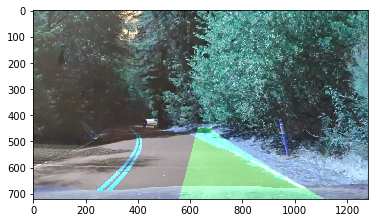

In [35]:

from moviepy.editor import VideoFileClip
harder_challenge_input = '../harder_challenge_video.mp4'
harder_challenge_output = '../harder_challenge_solution.mp4'

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip(harder_challenge_input).subclip(0,10)
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(harder_challenge_output, audio=False)
